In [1]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [3]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x) / 5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    fig.subplots_adjust(top=.9)

In [4]:
# chk: https://fred.stlouisfed.org/series/IPGMFN
# IPGMFN monthly data
industrial_production = web.DataReader('IPGMFN', 'fred', '2000', '2022-12-31').squeeze().dropna()
# NASDAQCOM daily data
# chk: https://www.nasdaq.com/market-activity/index/comp
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2000', '2022-12-31').squeeze().dropna()

In [5]:
# log transformation
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

# Differencing
nasdaq_log_diff = nasdaq_log.diff().dropna()
# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

In [6]:
industrial_production_log_diff.tail()

DATE
2022-08-01    0.025688
2022-09-01    0.040818
2022-10-01    0.025143
2022-11-01    0.009435
2022-12-01   -0.009811
Name: IPGMFN, dtype: float64

In [7]:
# ARMA vs ARIMA: ARMA MDL is ARIMA MDL's case of I=0. Thus, (2, 0, 2)
model1 = tsa.ARIMA(endog=nasdaq_log_diff, order=(2, 0, 2)).fit()
model2 = tsa.ARIMA(endog=nasdaq_log, order=(2, 1, 2)).fit()

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

In [8]:
# model1.params.sort_index() == model2.params.sort_index().values
model1.params.sort_index()
# model2.params.sort_index()

ar.L1    -0.354101
ar.L2     0.197578
const     0.000156
ma.L1     0.292450
ma.L2    -0.244030
sigma2    0.000256
dtype: float64

In [9]:
# Seasonal differencing vs SARIMAX
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2, 0, 2), seasonal_order=(0, 1, 0, 12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2, 0, 2), seasonal_order=(0, 0, 0, 12)).fit()

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [10]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

SARIMAX      diff
ar.L1   1.005546  1.003347
ar.L2  -0.088012 -0.085751
ma.L1   0.137518  0.136172
ma.L2  -0.160299 -0.158429
sigma2  0.000423  0.000423

In [11]:
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
# to find the optimal ARMA lags
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        # print("P&Q: ", p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T - train_size:T]
            try:
                model = tsa.ARIMA(endog=train_set, order=(p, 0, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1
            print("model.params : " , model.params)
            forecast = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).replace(np.inf, np.nan).dropna())

        rmse = np.sqrt(mean_squared_error(y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse, np.mean(aic), np.mean(bic), convergence_error, stationarity_error]

results[:10]

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000576
ma.L1     0.940018
sigma2    0.001320
dtype: float64
model.params :  const    -0.000176
ma.L1     0.934580
sigma2    0.001328
dtype: float64
model.params :  const     0.000324
ma.L1     0.938949
sigma2    0.001333
dtype: float64
model.params :  const     0.000687
ma.L1     0.935377
sigma2    0.001338
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001084
ma.L1     0.935516
sigma2    0.001336
dtype: float64
model.params :  const     0.001579
ma.L1     0.935365
sigma2    0.001333
dtype: float64
model.params :  const     0.001864
ma.L1     0.936146
sigma2    0.001333
dtype: float64
model.params :  const     0.002641
ma.L1     0.935768
sigma2    0.001325
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002916
ma.L1     0.935952
sigma2    0.001324
dtype: float64
model.params :  const     0.003750
ma.L1     0.934833
sigma2    0.001318
dtype: float64
model.params :  const     0.004244
ma.L1     0.934752
sigma2    0.001314
dtype: float64
model.params :  const     0.005121
ma.L1     0.933789
sigma2    0.001303
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005696
ma.L1     0.934137
sigma2    0.001299
dtype: float64
model.params :  const     0.006607
ma.L1     0.932760
sigma2    0.001291
dtype: float64
model.params :  const     0.006959
ma.L1     0.934159
sigma2    0.001293
dtype: float64
model.params :  const     0.007625
ma.L1     0.933027
sigma2    0.001283
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007987
ma.L1     0.934618
sigma2    0.001288
dtype: float64
model.params :  const     0.008188
ma.L1     0.934134
sigma2    0.001287
dtype: float64
model.params :  const     0.008616
ma.L1     0.935318
sigma2    0.001292
dtype: float64
model.params :  const     0.008402
ma.L1     0.935746
sigma2    0.001292
dtype: float64
model.params :  const     0.008839
ma.L1     0.936394
sigma2    0.001295
dtype: float64
model.params :  const     0.008349
ma.L1     0.936835
sigma2    0.001290
dtype: float64
model.params :  const     0.008505
ma.L1     0.936868
sigma2    0.001291
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008146
ma.L1     0.936742
sigma2    0.001285
dtype: float64
model.params :  const     0.008287
ma.L1     0.936721
sigma2    0.001286
dtype: float64
model.params :  const     0.007893
ma.L1     0.936211
sigma2    0.001284
dtype: float64
model.params :  const     0.007951
ma.L1     0.936163
sigma2    0.001284
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007521
ma.L1     0.935084
sigma2    0.001281
dtype: float64
model.params :  const     0.007699
ma.L1     0.934729
sigma2    0.001282
dtype: float64
model.params :  const     0.007588
ma.L1     0.934438
sigma2    0.001282
dtype: float64
model.params :  const     0.007714
ma.L1     0.934088
sigma2    0.001283
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007665
ma.L1     0.933997
sigma2    0.001283
dtype: float64
model.params :  const     0.007848
ma.L1     0.933272
sigma2    0.001286
dtype: float64
model.params :  const     0.007829
ma.L1     0.933010
sigma2    0.001286
dtype: float64
model.params :  const     0.007956
ma.L1     0.931821
sigma2    0.001288
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007863
ma.L1     0.930732
sigma2    0.001290
dtype: float64
model.params :  const     0.007580
ma.L1     0.930436
sigma2    0.001285
dtype: float64
model.params :  const     0.007396
ma.L1     0.928471
sigma2    0.001288
dtype: float64
model.params :  const     0.007397
ma.L1     0.926992
sigma2    0.001288
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007260
ma.L1     0.926465
sigma2    0.001288
dtype: float64
model.params :  const     0.007205
ma.L1     0.925814
sigma2    0.001288
dtype: float64
model.params :  const     0.006981
ma.L1     0.925649
sigma2    0.001286
dtype: float64
model.params :  const     0.006776
ma.L1     0.925172
sigma2    0.001283
dtype: float64
model.params :  const     0.006842
ma.L1     0.925915
sigma2    0.001284
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006198
ma.L1     0.924766
sigma2    0.001270
dtype: float64
model.params :  const     0.006397
ma.L1     0.925097
sigma2    0.001271
dtype: float64
model.params :  const     0.005909
ma.L1     0.923341
sigma2    0.001264
dtype: float64
model.params :  const     0.006027
ma.L1     0.924459
sigma2    0.001265
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005708
ma.L1     0.922927
sigma2    0.001262
dtype: float64
model.params :  const     0.005687
ma.L1     0.924787
sigma2    0.001262
dtype: float64
model.params :  const     0.004942
ma.L1     0.921185
sigma2    0.001255
dtype: float64
model.params :  const     0.004954
ma.L1     0.922006
sigma2    0.001255
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004338
ma.L1     0.917646
sigma2    0.001251
dtype: float64
model.params :  const     0.004029
ma.L1     0.921176
sigma2    0.001246
dtype: float64
model.params :  const     0.003504
ma.L1     0.918059
sigma2    0.001247
dtype: float64
model.params :  const     0.003066
ma.L1     0.924044
sigma2    0.001235
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002717
ma.L1     0.922160
sigma2    0.001238
dtype: float64
model.params :  const     0.002074
ma.L1     0.929359
sigma2    0.001225
dtype: float64
model.params :  const     0.002098
ma.L1     0.930644
sigma2    0.001225
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001224
ma.L1     0.939053
sigma2    0.001209
dtype: float64
model.params :  const     0.001151
ma.L1     0.939595
sigma2    0.001209
dtype: float64
model.params :  const     0.000446
ma.L1     0.947562
sigma2    0.001192
dtype: float64
model.params :  const     0.00055
ma.L1     0.94985
sigma2    0.00119
dtype: float64
model.params :  const    -0.000235
ma.L1     0.959223
sigma2    0.001178
dtype: float64
model.params :  const    -0.000063
ma.L1     0.961200
sigma2    0.001177
dtype: float64
model.params :  const    -0.000729
ma.L1     0.977931
sigma2    0.001170
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000546
ma.L1     0.975414
sigma2    0.001173
dtype: float64
model.params :  const    -0.001371
ma.L1     0.999890
sigma2    0.001154
dtype: float64
model.params :  const    -0.001293
ma.L1     0.999809
sigma2    0.001154
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001918
ma.L1     0.999941
sigma2    0.001149
dtype: float64
model.params :  const    -0.002025
ma.L1     0.999948
sigma2    0.001148
dtype: float64
model.params :  const    -0.002329
ma.L1     0.999676
sigma2    0.001148
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002319
ma.L1     0.959153
sigma2    0.001171
dtype: float64
model.params :  const    -0.002854
ma.L1     0.999813
sigma2    0.001146
dtype: float64
model.params :  const    -0.002550
ma.L1     0.962192
sigma2    0.001169
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003129
ma.L1     0.999787
sigma2    0.001143
dtype: float64
model.params :  const    -0.003115
ma.L1     0.965276
sigma2    0.001163
dtype: float64
model.params :  const    -0.003680
ma.L1     0.999918
sigma2    0.001130
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003574
ma.L1     0.999696
sigma2    0.001131
dtype: float64
model.params :  const    -0.004125
ma.L1     0.992967
sigma2    0.001126
dtype: float64
model.params :  const    -0.004127
ma.L1     0.987840
sigma2    0.001129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.004586
ma.L1     0.986042
sigma2    0.001124
dtype: float64
model.params :  const    -0.004499
ma.L1     0.981538
sigma2    0.001127
dtype: float64
model.params :  const    -0.004858
ma.L1     0.981093
sigma2    0.001121
dtype: float64
model.params :  const    -0.004861
ma.L1     0.977944
sigma2    0.001123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.005143
ma.L1     0.976558
sigma2    0.001122
dtype: float64
model.params :  const    -0.005051
ma.L1     0.970623
sigma2    0.001126
dtype: float64
model.params :  const    -0.005041
ma.L1     0.970480
sigma2    0.001126
dtype: float64
model.params :  const    -0.004583
ma.L1     0.962739
sigma2    0.001136
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.004744
ma.L1     0.957207
sigma2    0.001139
dtype: float64
model.params :  const    -0.004060
ma.L1     0.950437
sigma2    0.001149
dtype: float64
model.params :  const    -0.003900
ma.L1     0.943633
sigma2    0.001148
dtype: float64
model.params :  const    -0.003158
ma.L1     0.937987
sigma2    0.001157
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002584
ma.L1     0.923353
sigma2    0.001146
dtype: float64
model.params :  const    -0.001580
ma.L1     0.933985
sigma2    0.001123
dtype: float64
model.params :  const    -0.000955
ma.L1     0.915900
sigma2    0.001108
dtype: float64
model.params :  const     0.000603
ma.L1     0.931154
sigma2    0.001047
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001830
ma.L1     0.895006
sigma2    0.000995
dtype: float64
model.params :  const     0.003594
ma.L1     0.922175
sigma2    0.000873
dtype: float64
model.params :  const     0.004679
ma.L1     0.887466
sigma2    0.000830
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006416
ma.L1     0.912168
sigma2    0.000674
dtype: float64
model.params :  const     0.007743
ma.L1     0.871997
sigma2    0.000619
dtype: float64
model.params :  const     0.009432
ma.L1     0.883840
sigma2    0.000468
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.010499
ma.L1     0.833821
sigma2    0.000416
dtype: float64
model.params :  const     0.011832
ma.L1     0.839058
sigma2    0.000321
dtype: float64
model.params :  const     0.012289
ma.L1     0.812248
sigma2    0.000303
dtype: float64
model.params :  const     0.013069
ma.L1     0.812205
sigma2    0.000259
dtype: float64
model.params :  const     0.013336
ma.L1     0.804102
sigma2    0.000253
dtype: float64
model.params :  const     0.013638
ma.L1     0.799436
sigma2    0.000241
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.013343
ma.L1     0.799873
sigma2    0.000241
dtype: float64
model.params :  const     0.013177
ma.L1     0.798225
sigma2    0.000241
dtype: float64
model.params :  const     0.012120
ma.L1     0.804120
sigma2    0.000267
dtype: float64
model.params :  const     0.008674
ma.L1     0.846050
sigma2    0.000544
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007819
ma.L1     0.850563
sigma2    0.000538
dtype: float64
model.params :  const     0.005542
ma.L1     0.806637
sigma2    0.000575
dtype: float64
model.params :  const     0.005007
ma.L1     0.796578
sigma2    0.000564
dtype: float64
model.params :  const     0.003503
ma.L1     0.765799
sigma2    0.000574
dtype: float64
model.params :  const     0.002822
ma.L1     0.771822
sigma2    0.000570
dtype: float64
model.params :  const     0.001915
ma.L1     0.764119
sigma2    0.000557
dtype: float64
model.params :  const     0.001256
ma.L1     0.770219
sigma2    0.000557
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000532
ma.L1     0.765301
sigma2    0.000548
dtype: float64
model.params :  const     0.000046
ma.L1     0.763666
sigma2    0.000540
dtype: float64
model.params :  const    -0.001206
ma.L1     0.754910
sigma2    0.000560
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000775
ma.L1     0.733610
sigma2    0.000584
dtype: float64
model.params :  const     0.001111
ma.L1     0.798491
sigma2    0.000761
dtype: float64
model.params :  const     0.001566
ma.L1     0.800354
sigma2    0.000774
dtype: float64
model.params :  const     0.002133
ma.L1     0.803447
sigma2    0.000790
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002268
ma.L1     0.803710
sigma2    0.000793
dtype: float64
model.params :  const     0.002320
ma.L1     0.804750
sigma2    0.000794
dtype: float64
model.params :  const     0.002417
ma.L1     0.804393
sigma2    0.000795
dtype: float64
model.params :  const     0.002384
ma.L1     0.806151
sigma2    0.000794
dtype: float64
model.params :  const     0.002596
ma.L1     0.806299
sigma2    0.000797
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002436
ma.L1     0.808170
sigma2    0.000794
dtype: float64
model.params :  const     0.002398
ma.L1     0.807532
sigma2    0.000794
dtype: float64
model.params :  const     0.002828
ma.L1     0.808044
sigma2    0.000817
dtype: float64
model.params :  const     0.002628
ma.L1     0.806590
sigma2    0.000817
dtype: float64
model.params :  const     0.002862
ma.L1     0.800410
sigma2    0.000825
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002617
ma.L1     0.799521
sigma2    0.000823
dtype: float64
model.params :  const     0.002698
ma.L1     0.794286
sigma2    0.000825
dtype: float64
model.params :  const     0.002428
ma.L1     0.793328
sigma2    0.000823
dtype: float64
model.params :  const     0.002608
ma.L1     0.789209
sigma2    0.000827
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002683
ma.L1     0.792276
sigma2    0.000828
dtype: float64
model.params :  const     0.002719
ma.L1     0.791718
sigma2    0.000828
dtype: float64
model.params :  const     0.002678
ma.L1     0.791531
sigma2    0.000828
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000296
ma.L1     1.306227
ma.L2     0.701962
sigma2    0.000678
dtype: float64
model.params :  const    -0.000246
ma.L1     1.316200
ma.L2     0.701812
sigma2    0.000678
dtype: float64
model.params :  const     0.000840
ma.L1     1.334625
ma.L2     0.709551
sigma2    0.000678
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000470
ma.L1     1.327835
ma.L2     0.715422
sigma2    0.000673
dtype: float64
model.params :  const     0.001110
ma.L1     1.308424
ma.L2     0.719639
sigma2    0.000668
dtype: float64
model.params :  const     0.001603
ma.L1     1.318653
ma.L2     0.719046
sigma2    0.000667
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001650
ma.L1     1.322027
ma.L2     0.720062
sigma2    0.000667
dtype: float64
model.params :  const     0.002703
ma.L1     1.322305
ma.L2     0.728354
sigma2    0.000658
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002814
ma.L1     1.322557
ma.L2     0.728306
sigma2    0.000658
dtype: float64
model.params :  const     0.003516
ma.L1     1.308985
ma.L2     0.730334
sigma2    0.000658
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004466
ma.L1     1.337707
ma.L2     0.730982
sigma2    0.000649
dtype: float64
model.params :  const     0.004547
ma.L1     1.339051
ma.L2     0.732119
sigma2    0.000650
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005948
ma.L1     1.333698
ma.L2     0.739634
sigma2    0.000636
dtype: float64
model.params :  const     0.006470
ma.L1     1.340352
ma.L2     0.738065
sigma2    0.000635
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006861
ma.L1     1.339934
ma.L2     0.737706
sigma2    0.000637
dtype: float64
model.params :  const     0.007759
ma.L1     1.376047
ma.L2     0.744512
sigma2    0.000622
dtype: float64
model.params :  const     0.007914
ma.L1     1.380841
ma.L2     0.747939
sigma2    0.000625
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008458
ma.L1     1.380619
ma.L2     0.750902
sigma2    0.000619
dtype: float64
model.params :  const     0.008521
ma.L1     1.372281
ma.L2     0.750756
sigma2    0.000619
dtype: float64
model.params :  const     0.008666
ma.L1     1.371897
ma.L2     0.750512
sigma2    0.000619
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008776
ma.L1     1.372944
ma.L2     0.751043
sigma2    0.000619
dtype: float64
model.params :  const     0.008631
ma.L1     1.374498
ma.L2     0.752393
sigma2    0.000618
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008389
ma.L1     1.371858
ma.L2     0.751361
sigma2    0.000619
dtype: float64
model.params :  const     0.008532
ma.L1     1.361380
ma.L2     0.750401
sigma2    0.000621
dtype: float64
model.params :  const     0.008212
ma.L1     1.362677
ma.L2     0.750719
sigma2    0.000621
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008001
ma.L1     1.361243
ma.L2     0.749537
sigma2    0.000621
dtype: float64
model.params :  const     0.008126
ma.L1     1.362531
ma.L2     0.749918
sigma2    0.000622
dtype: float64
model.params :  const     0.007497
ma.L1     1.361819
ma.L2     0.744504
sigma2    0.000622
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007811
ma.L1     1.356835
ma.L2     0.742924
sigma2    0.000623
dtype: float64
model.params :  const     0.007416
ma.L1     1.367003
ma.L2     0.744600
sigma2    0.000622
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007947
ma.L1     1.386961
ma.L2     0.754037
sigma2    0.000618
dtype: float64
model.params :  const     0.007368
ma.L1     1.395616
ma.L2     0.764408
sigma2    0.000613
dtype: float64
model.params :  const     0.008119
ma.L1     1.387808
ma.L2     0.771044
sigma2    0.000608
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007802
ma.L1     1.379071
ma.L2     0.770758
sigma2    0.000608
dtype: float64
model.params :  const     0.007802
ma.L1     1.396146
ma.L2     0.773669
sigma2    0.000608
dtype: float64
model.params :  const     0.008354
ma.L1     1.417026
ma.L2     0.789063
sigma2    0.000600
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007118
ma.L1     1.410706
ma.L2     0.803313
sigma2    0.000582
dtype: float64
model.params :  const     0.007673
ma.L1     1.397035
ma.L2     0.808059
sigma2    0.000578
dtype: float64
model.params :  const     0.007495
ma.L1     1.392265
ma.L2     0.807239
sigma2    0.000578
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007094
ma.L1     1.407585
ma.L2     0.815630
sigma2    0.000572
dtype: float64
model.params :  const     0.007605
ma.L1     1.407170
ma.L2     0.827289
sigma2    0.000565
dtype: float64
model.params :  const     0.006918
ma.L1     1.387309
ma.L2     0.834213
sigma2    0.000553
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006871
ma.L1     1.386867
ma.L2     0.834317
sigma2    0.000553
dtype: float64
model.params :  const     0.007285
ma.L1     1.392927
ma.L2     0.838652
sigma2    0.000552
dtype: float64
model.params :  const     0.006144
ma.L1     1.397051
ma.L2     0.849335
sigma2    0.000534
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006477
ma.L1     1.394407
ma.L2     0.850618
sigma2    0.000533
dtype: float64
model.params :  const     0.006314
ma.L1     1.390137
ma.L2     0.849580
sigma2    0.000532
dtype: float64
model.params :  const     0.005858
ma.L1     1.399146
ma.L2     0.853319
sigma2    0.000527
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006103
ma.L1     1.400537
ma.L2     0.855002
sigma2    0.000526
dtype: float64
model.params :  const     0.005960
ma.L1     1.396512
ma.L2     0.854428
sigma2    0.000524
dtype: float64
model.params :  const     0.004880
ma.L1     1.396267
ma.L2     0.851405
sigma2    0.000519
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005192
ma.L1     1.397594
ma.L2     0.851494
sigma2    0.000519
dtype: float64
model.params :  const     0.004475
ma.L1     1.402213
ma.L2     0.851509
sigma2    0.000512
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004151
ma.L1     1.400802
ma.L2     0.849162
sigma2    0.000513
dtype: float64
model.params :  const     0.003529
ma.L1     1.402351
ma.L2     0.850638
sigma2    0.000508
dtype: float64
model.params :  const     0.003457
ma.L1     1.402696
ma.L2     0.850273
sigma2    0.000508
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002562
ma.L1     1.401845
ma.L2     0.848450
sigma2    0.000506
dtype: float64
model.params :  const     0.002224
ma.L1     1.402807
ma.L2     0.849667
sigma2    0.000505
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002227
ma.L1     1.403552
ma.L2     0.849910
sigma2    0.000505
dtype: float64
model.params :  const     0.001165
ma.L1     1.405875
ma.L2     0.850583
sigma2    0.000508
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001298
ma.L1     1.405765
ma.L2     0.849619
sigma2    0.000509
dtype: float64
model.params :  const     0.000680
ma.L1     1.402458
ma.L2     0.846090
sigma2    0.000505
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000339
ma.L1     1.404499
ma.L2     0.846518
sigma2    0.000506
dtype: float64
model.params :  const     0.000039
ma.L1     1.405582
ma.L2     0.844872
sigma2    0.000505
dtype: float64
model.params :  const    -0.000024
ma.L1     1.404082
ma.L2     0.845109
sigma2    0.000505
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000934
ma.L1     1.408961
ma.L2     0.848007
sigma2    0.000506
dtype: float64
model.params :  const    -0.000069
ma.L1     1.409977
ma.L2     0.849298
sigma2    0.000508
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001576
ma.L1     1.404225
ma.L2     0.848290
sigma2    0.000502
dtype: float64
model.params :  const    -0.001274
ma.L1     1.402308
ma.L2     0.847112
sigma2    0.000501
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001261
ma.L1     1.402805
ma.L2     0.841210
sigma2    0.000502
dtype: float64
model.params :  const    -0.002570
ma.L1     1.398465
ma.L2     0.838967
sigma2    0.000502
dtype: float64
model.params :  const    -0.001821
ma.L1     1.390911
ma.L2     0.834460
sigma2    0.000504
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002265
ma.L1     1.386453
ma.L2     0.830716
sigma2    0.000503
dtype: float64
model.params :  const    -0.002785
ma.L1     1.389910
ma.L2     0.830454
sigma2    0.000503
dtype: float64
model.params :  const    -0.002487
ma.L1     1.396382
ma.L2     0.815109
sigma2    0.000507
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002747
ma.L1     1.396673
ma.L2     0.809487
sigma2    0.000508
dtype: float64
model.params :  const    -0.003254
ma.L1     1.400970
ma.L2     0.812624
sigma2    0.000504
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003087
ma.L1     1.425242
ma.L2     0.803194
sigma2    0.000506
dtype: float64
model.params :  const    -0.003742
ma.L1     1.430306
ma.L2     0.801233
sigma2    0.000508
dtype: float64
model.params :  const    -0.003730
ma.L1     1.459954
ma.L2     0.805014
sigma2    0.000507
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003997
ma.L1     1.451758
ma.L2     0.800851
sigma2    0.000508
dtype: float64
model.params :  const    -0.004658
ma.L1     1.441705
ma.L2     0.801205
sigma2    0.000502
dtype: float64
model.params :  const    -0.003962
ma.L1     1.455995
ma.L2     0.803913
sigma2    0.000505
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.004871
ma.L1     1.439339
ma.L2     0.795438
sigma2    0.000501
dtype: float64
model.params :  const    -0.004601
ma.L1     1.433756
ma.L2     0.792288
sigma2    0.000504
dtype: float64
model.params :  const    -0.004961
ma.L1     1.423578
ma.L2     0.788439
sigma2    0.000505
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.004983
ma.L1     1.393875
ma.L2     0.794475
sigma2    0.000504
dtype: float64
model.params :  const    -0.004914
ma.L1     1.399544
ma.L2     0.791510
sigma2    0.000505
dtype: float64
model.params :  const    -0.004429
ma.L1     1.404576
ma.L2     0.795035
sigma2    0.000505
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.004904
ma.L1     1.412426
ma.L2     0.798472
sigma2    0.000504
dtype: float64
model.params :  const    -0.004065
ma.L1     1.420458
ma.L2     0.803683
sigma2    0.000505
dtype: float64
model.params :  const    -0.003690
ma.L1     1.424470
ma.L2     0.800959
sigma2    0.000504
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003617
ma.L1     1.433962
ma.L2     0.800915
sigma2    0.000504
dtype: float64
model.params :  const    -0.002304
ma.L1     1.489091
ma.L2     0.821000
sigma2    0.000493
dtype: float64
model.params :  const    -0.002675
ma.L1     1.477906
ma.L2     0.815634
sigma2    0.000496
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000687
ma.L1     1.477733
ma.L2     0.823225
sigma2    0.000473
dtype: float64
model.params :  const    -0.000554
ma.L1     1.478785
ma.L2     0.822307
sigma2    0.000472
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001269
ma.L1     1.413715
ma.L2     0.798446
sigma2    0.000434
dtype: float64
model.params :  const     0.002439
ma.L1     0.929841
ma.L2     0.905175
sigma2    0.000464
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003817
ma.L1     1.404198
ma.L2     0.780524
sigma2    0.000388
dtype: float64
model.params :  const     0.005364
ma.L1     1.385248
ma.L2     0.779426
sigma2    0.000336
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006845
ma.L1     0.902867
ma.L2     0.871932
sigma2    0.000342
dtype: float64
model.params :  const     0.008560
ma.L1     1.226187
ma.L2     0.678042
sigma2    0.000269
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.009708
ma.L1     1.232252
ma.L2     0.674720
sigma2    0.000235
dtype: float64
model.params :  const     0.011198
ma.L1     0.853428
ma.L2     0.743730
sigma2    0.000204
dtype: float64
model.params :  const     0.011991
ma.L1     0.908529
ma.L2     0.686554
sigma2    0.000182
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.012585
ma.L1     1.085015
ma.L2     0.561619
sigma2    0.000170
dtype: float64
model.params :  const     0.013193
ma.L1     0.803252
ma.L2     0.703453
sigma2    0.000161
dtype: float64
model.params :  const     0.013576
ma.L1     0.842210
ma.L2     0.661156
sigma2    0.000152
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.013205
ma.L1     1.083247
ma.L2     0.550690
sigma2    0.000149
dtype: float64
model.params :  const     0.013327
ma.L1     1.073790
ma.L2     0.552170
sigma2    0.000148
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011892
ma.L1     0.770476
ma.L2     0.725418
sigma2    0.000180
dtype: float64
model.params :  const     0.007440
ma.L1     1.340011
ma.L2     0.727584
sigma2    0.000372
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008170
ma.L1     1.233993
ma.L2     0.659131
sigma2    0.000394
dtype: float64
model.params :  const     0.005957
ma.L1     1.072828
ma.L2     0.585671
sigma2    0.000415
dtype: float64
model.params :  const     0.004536
ma.L1     1.109147
ma.L2     0.575693
sigma2    0.000414
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003976
ma.L1     1.103202
ma.L2     0.561240
sigma2    0.000407
dtype: float64
model.params :  const     0.002598
ma.L1     1.047314
ma.L2     0.502754
sigma2    0.000422
dtype: float64
model.params :  const     0.002139
ma.L1     1.029472
ma.L2     0.491843
sigma2    0.000412
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001317
ma.L1     1.004595
ma.L2     0.504435
sigma2    0.000418
dtype: float64
model.params :  const     0.000549
ma.L1     1.003111
ma.L2     0.492793
sigma2    0.000413
dtype: float64
model.params :  const     0.000285
ma.L1     0.998387
ma.L2     0.484120
sigma2    0.000410
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001395
ma.L1     0.971302
ma.L2     0.455838
sigma2    0.000440
dtype: float64
model.params :  const    -0.000473
ma.L1     0.875655
ma.L2     0.475597
sigma2    0.000479
dtype: float64
model.params :  const     0.002115
ma.L1     1.105051
ma.L2     0.421909
sigma2    0.000641
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001504
ma.L1     1.088961
ma.L2     0.397681
sigma2    0.000644
dtype: float64
model.params :  const     0.002405
ma.L1     1.056239
ma.L2     0.377133
sigma2    0.000662
dtype: float64
model.params :  const     0.002460
ma.L1     1.068900
ma.L2     0.379920
sigma2    0.000662
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002354
ma.L1     1.068503
ma.L2     0.379133
sigma2    0.000662
dtype: float64
model.params :  const     0.002605
ma.L1     1.066148
ma.L2     0.371363
sigma2    0.000665
dtype: float64
model.params :  const     0.002501
ma.L1     1.068127
ma.L2     0.371893
sigma2    0.000664
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002760
ma.L1     1.064899
ma.L2     0.371164
sigma2    0.000667
dtype: float64
model.params :  const     0.002529
ma.L1     1.068097
ma.L2     0.369975
sigma2    0.000665
dtype: float64
model.params :  const     0.002541
ma.L1     1.067942
ma.L2     0.370045
sigma2    0.000665
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003173
ma.L1     1.070090
ma.L2     0.363947
sigma2    0.000689
dtype: float64
model.params :  const     0.002698
ma.L1     1.055797
ma.L2     0.353757
sigma2    0.000693
dtype: float64
model.params :  const     0.002988
ma.L1     1.038210
ma.L2     0.351345
sigma2    0.000700
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002846
ma.L1     1.038293
ma.L2     0.349807
sigma2    0.000700
dtype: float64
model.params :  const     0.002736
ma.L1     1.034493
ma.L2     0.353217
sigma2    0.000698
dtype: float64
model.params :  const     0.002584
ma.L1     1.035328
ma.L2     0.351077
sigma2    0.000697
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002712
ma.L1     1.035484
ma.L2     0.353474
sigma2    0.000698
dtype: float64
model.params :  const     0.002840
ma.L1     1.036229
ma.L2     0.352803
sigma2    0.000700
dtype: float64
model.params :  const     0.002714
ma.L1     1.034996
ma.L2     0.351674
sigma2    0.000700
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002760
ma.L1     1.033994
ma.L2     0.351418
sigma2    0.000701
dtype: float64
model.params :  const     0.000011
ma.L1     1.251099
ma.L2     1.147479
ma.L3     0.750556
sigma2    0.000417
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000314
ma.L1     1.252611
ma.L2     1.150997
ma.L3     0.751977
sigma2    0.000416
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000603
ma.L1     1.246737
ma.L2     1.142817
ma.L3     0.757424
sigma2    0.000417
dtype: float64
model.params :  const     0.000642
ma.L1     1.253545
ma.L2     1.148647
ma.L3     0.747333
sigma2    0.000418
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001186
ma.L1     1.248368
ma.L2     1.147149
ma.L3     0.744802
sigma2    0.000415
dtype: float64
model.params :  const     0.001210
ma.L1     1.252820
ma.L2     1.149609
ma.L3     0.745098
sigma2    0.000415
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001749
ma.L1     1.250433
ma.L2     1.141105
ma.L3     0.744879
sigma2    0.000418
dtype: float64
model.params :  const     0.002665
ma.L1     1.253791
ma.L2     1.142522
ma.L3     0.745061
sigma2    0.000416
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002626
ma.L1     1.251325
ma.L2     1.139373
ma.L3     0.740820
sigma2    0.000416
dtype: float64
model.params :  const     0.003528
ma.L1     1.246151
ma.L2     1.133001
ma.L3     0.740696
sigma2    0.000415
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004023
ma.L1     1.251302
ma.L2     1.133231
ma.L3     0.737999
sigma2    0.000416
dtype: float64
model.params :  const     0.004746
ma.L1     1.248099
ma.L2     1.130463
ma.L3     0.740657
sigma2    0.000413
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005520
ma.L1     1.246828
ma.L2     1.130530
ma.L3     0.737846
sigma2    0.000410
dtype: float64
model.params :  const     0.006525
ma.L1     1.238363
ma.L2     1.118509
ma.L3     0.735508
sigma2    0.000411
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006956
ma.L1     1.247692
ma.L2     1.125508
ma.L3     0.733496
sigma2    0.000412
dtype: float64
model.params :  const     0.007486
ma.L1     1.254725
ma.L2     1.126560
ma.L3     0.726272
sigma2    0.000406
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007978
ma.L1     1.233269
ma.L2     1.109034
ma.L3     0.734359
sigma2    0.000410
dtype: float64
model.params :  const     0.008658
ma.L1     1.234784
ma.L2     1.109857
ma.L3     0.730526
sigma2    0.000409
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008812
ma.L1     1.238773
ma.L2     1.114265
ma.L3     0.729024
sigma2    0.000409
dtype: float64
model.params :  const     0.008374
ma.L1     1.244294
ma.L2     1.117769
ma.L3     0.724494
sigma2    0.000410
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.009064
ma.L1     1.234107
ma.L2     1.106977
ma.L3     0.721287
sigma2    0.000413
dtype: float64
model.params :  const     0.008692
ma.L1     1.230351
ma.L2     1.103706
ma.L3     0.723502
sigma2    0.000413
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008693
ma.L1     1.233970
ma.L2     1.104194
ma.L3     0.723580
sigma2    0.000413
dtype: float64
model.params :  const     0.008289
ma.L1     1.224190
ma.L2     1.095673
ma.L3     0.731675
sigma2    0.000409
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008691
ma.L1     1.231795
ma.L2     1.099775
ma.L3     0.724439
sigma2    0.000410
dtype: float64
model.params :  const     0.007976
ma.L1     1.212182
ma.L2     1.084765
ma.L3     0.729569
sigma2    0.000412
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008062
ma.L1     1.207385
ma.L2     1.082169
ma.L3     0.731975
sigma2    0.000412
dtype: float64
model.params :  const     0.007739
ma.L1     1.208988
ma.L2     1.081076
ma.L3     0.727745
sigma2    0.000410
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007963
ma.L1     1.218183
ma.L2     1.087129
ma.L3     0.720646
sigma2    0.000410
dtype: float64
model.params :  const     0.007309
ma.L1     1.225985
ma.L2     1.091163
ma.L3     0.709055
sigma2    0.000411
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007652
ma.L1     1.212347
ma.L2     1.082547
ma.L3     0.713844
sigma2    0.000411
dtype: float64
model.params :  const     0.007770
ma.L1     1.211091
ma.L2     1.082152
ma.L3     0.716464
sigma2    0.000411
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007948
ma.L1     1.218166
ma.L2     1.088226
ma.L3     0.711989
sigma2    0.000412
dtype: float64
model.params :  const     0.007698
ma.L1     1.224593
ma.L2     1.092133
ma.L3     0.704771
sigma2    0.000412
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008201
ma.L1     1.219583
ma.L2     1.088083
ma.L3     0.700491
sigma2    0.000414
dtype: float64
model.params :  const     0.008112
ma.L1     1.209070
ma.L2     1.081895
ma.L3     0.706074
sigma2    0.000414
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007387
ma.L1     1.220577
ma.L2     1.086554
ma.L3     0.703570
sigma2    0.000412
dtype: float64
model.params :  const     0.007385
ma.L1     1.231399
ma.L2     1.094441
ma.L3     0.697088
sigma2    0.000412
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007527
ma.L1     1.238311
ma.L2     1.097962
ma.L3     0.688259
sigma2    0.000413
dtype: float64
model.params :  const     0.007659
ma.L1     1.238472
ma.L2     1.097834
ma.L3     0.688738
sigma2    0.000413
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007220
ma.L1     1.246555
ma.L2     1.101677
ma.L3     0.686671
sigma2    0.000413
dtype: float64
model.params :  const     0.007128
ma.L1     1.240438
ma.L2     1.095332
ma.L3     0.686691
sigma2    0.000413
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007334
ma.L1     1.247526
ma.L2     1.099638
ma.L3     0.680998
sigma2    0.000413
dtype: float64
model.params :  const     0.007117
ma.L1     1.253855
ma.L2     1.105315
ma.L3     0.674528
sigma2    0.000413
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005934
ma.L1     1.509294
ma.L2     1.284160
ma.L3     0.509397
sigma2    0.000401
dtype: float64
model.params :  const     0.007103
ma.L1     1.526189
ma.L2     1.304852
ma.L3     0.514974
sigma2    0.000396
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006010
ma.L1     1.525477
ma.L2     1.309180
ma.L3     0.520084
sigma2    0.000390
dtype: float64
model.params :  const     0.006099
ma.L1     1.524097
ma.L2     1.306214
ma.L3     0.514462
sigma2    0.000390
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006282
ma.L1     1.524155
ma.L2     1.306896
ma.L3     0.510565
sigma2    0.000389
dtype: float64
model.params :  const     0.006136
ma.L1     1.519801
ma.L2     1.305401
ma.L3     0.504691
sigma2    0.000389
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004800
ma.L1     1.524205
ma.L2     1.302276
ma.L3     0.504469
sigma2    0.000384
dtype: float64
model.params :  const     0.005477
ma.L1     1.533187
ma.L2     1.307451
ma.L3     0.502102
sigma2    0.000382
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004375
ma.L1     1.548495
ma.L2     1.320925
ma.L3     0.498385
sigma2    0.000374
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004422
ma.L1     1.550800
ma.L2     1.325682
ma.L3     0.501866
sigma2    0.000374
dtype: float64
model.params :  const     0.003497
ma.L1     1.544150
ma.L2     1.322903
ma.L3     0.503424
sigma2    0.000372
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003525
ma.L1     1.547320
ma.L2     1.325597
ma.L3     0.502284
sigma2    0.000372
dtype: float64
model.params :  const     0.002881
ma.L1     1.541407
ma.L2     1.317892
ma.L3     0.497880
sigma2    0.000374
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001939
ma.L1     1.540571
ma.L2     1.321438
ma.L3     0.508872
sigma2    0.000372
dtype: float64
model.params :  const     0.002358
ma.L1     1.540888
ma.L2     1.318705
ma.L3     0.505150
sigma2    0.000375
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001445
ma.L1     1.310320
ma.L2     1.146971
ma.L3     0.661184
sigma2    0.000384
dtype: float64
model.params :  const     0.001001
ma.L1     1.312494
ma.L2     1.146341
ma.L3     0.654246
sigma2    0.000385
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000527
ma.L1     1.556302
ma.L2     1.329772
ma.L3     0.514043
sigma2    0.000372
dtype: float64
model.params :  const     0.000955
ma.L1     1.562875
ma.L2     1.343461
ma.L3     0.533123
sigma2    0.000367
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000536
ma.L1     1.560273
ma.L2     1.340138
ma.L3     0.537591
sigma2    0.000362
dtype: float64
model.params :  const     0.000299
ma.L1     1.554927
ma.L2     1.323360
ma.L3     0.523078
sigma2    0.000368
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000333
ma.L1     1.324080
ma.L2     1.153303
ma.L3     0.674831
sigma2    0.000376
dtype: float64
model.params :  const    -0.000703
ma.L1     1.327605
ma.L2     1.161738
ma.L3     0.674257
sigma2    0.000375
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001473
ma.L1     1.521170
ma.L2     1.299409
ma.L3     0.525346
sigma2    0.000371
dtype: float64
model.params :  const    -0.001003
ma.L1     1.515245
ma.L2     1.296771
ma.L3     0.530156
sigma2    0.000368
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001276
ma.L1     1.499362
ma.L2     1.281459
ma.L3     0.530402
sigma2    0.000367
dtype: float64
model.params :  const    -0.002418
ma.L1     1.502685
ma.L2     1.291282
ma.L3     0.545105
sigma2    0.000360
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001892
ma.L1     1.490330
ma.L2     1.280373
ma.L3     0.551130
sigma2    0.000358
dtype: float64
model.params :  const    -0.002007
ma.L1     1.480948
ma.L2     1.269764
ma.L3     0.550073
sigma2    0.000357
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002690
ma.L1     1.465462
ma.L2     1.261580
ma.L3     0.561954
sigma2    0.000356
dtype: float64
model.params :  const    -0.002732
ma.L1     1.481279
ma.L2     1.274742
ma.L3     0.552429
sigma2    0.000356
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002300
ma.L1     1.485288
ma.L2     1.282374
ma.L3     0.553651
sigma2    0.000355
dtype: float64
model.params :  const    -0.003080
ma.L1     1.465484
ma.L2     1.268450
ma.L3     0.559912
sigma2    0.000354
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003288
ma.L1     1.498229
ma.L2     1.300842
ma.L3     0.559328
sigma2    0.000352
dtype: float64
model.params :  const    -0.003124
ma.L1     1.498262
ma.L2     1.305600
ma.L3     0.566762
sigma2    0.000351
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003797
ma.L1     1.448195
ma.L2     1.262530
ma.L3     0.592237
sigma2    0.000347
dtype: float64
model.params :  const    -0.004100
ma.L1     1.480205
ma.L2     1.293414
ma.L3     0.576741
sigma2    0.000346
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.004208
ma.L1     1.482308
ma.L2     1.293657
ma.L3     0.574712
sigma2    0.000346
dtype: float64
model.params :  const    -0.003777
ma.L1     1.489498
ma.L2     1.301173
ma.L3     0.575205
sigma2    0.000346
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.004868
ma.L1     1.528335
ma.L2     1.358374
ma.L3     0.580352
sigma2    0.000335
dtype: float64
model.params :  const    -0.004393
ma.L1     1.524886
ma.L2     1.359622
ma.L3     0.582719
sigma2    0.000334
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.004623
ma.L1     1.520897
ma.L2     1.354654
ma.L3     0.580892
sigma2    0.000334
dtype: float64
model.params :  const    -0.004954
ma.L1     1.537425
ma.L2     1.382446
ma.L3     0.595703
sigma2    0.000330
dtype: float64
model.params :  const    -0.004751
ma.L1     1.523662
ma.L2     1.366559
ma.L3     0.595996
sigma2    0.000329
dtype: float64
model.params :  const    -0.004161
ma.L1     1.519930
ma.L2     1.365971
ma.L3     0.595511
sigma2    0.000330
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.005169
ma.L1     1.517014
ma.L2     1.372903
ma.L3     0.593932
sigma2    0.000329
dtype: float64
model.params :  const    -0.004247
ma.L1     1.513206
ma.L2     1.373815
ma.L3     0.585987
sigma2    0.000332
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003163
ma.L1     1.532392
ma.L2     1.398658
ma.L3     0.602036
sigma2    0.000324
dtype: float64
model.params :  const    -0.003865
ma.L1     1.521189
ma.L2     1.384577
ma.L3     0.602528
sigma2    0.000319
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001914
ma.L1     0.529848
ma.L2     0.530403
ma.L3     0.999612
sigma2    0.000600
dtype: float64
model.params :  const    -0.002183
ma.L1     1.391456
ma.L2     1.296625
ma.L3     0.674021
sigma2    0.000310
dtype: float64
model.params :  const    -0.001999
ma.L1     1.326314
ma.L2     1.208465
ma.L3     0.721695
sigma2    0.000326
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000747
ma.L1     1.159188
ma.L2     1.108569
ma.L3     0.779975
sigma2    0.000327
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000792
ma.L1     1.364900
ma.L2     1.263426
ma.L3     0.617694
sigma2    0.000287
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.001788
ma.L1     1.372122
ma.L2     1.262119
ma.L3     0.635340
sigma2    0.000272
dtype: float64
model.params :  const     0.003226
ma.L1     1.350761
ma.L2     1.236665
ma.L3     0.596346
sigma2    0.000265
dtype: float64
model.params :  const     0.004765
ma.L1     1.169881
ma.L2     1.100375
ma.L3     0.747072
sigma2    0.000238
dtype: float64
model.params :  const     0.006087
ma.L1     1.264372
ma.L2     1.165924
ma.L3     0.588676
sigma2    0.000225
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007904
ma.L1     1.281707
ma.L2     1.151591
ma.L3     0.577313
sigma2    0.000190
dtype: float64
model.params :  const     0.008734
ma.L1     1.051743
ma.L2     0.991397
ma.L3     0.651846
sigma2    0.000182
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.010813
ma.L1     1.070173
ma.L2     0.996704
ma.L3     0.669251
sigma2    0.000136
dtype: float64
model.params :  const     0.011231
ma.L1     1.084068
ma.L2     0.996933
ma.L3     0.583426
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011804
ma.L1     1.058882
ma.L2     0.950956
ma.L3     0.596885
sigma2    0.000124
dtype: float64
model.params :  const     0.012670
ma.L1     0.979283
ma.L2     0.929922
ma.L3     0.612942
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.013553
ma.L1     0.996142
ma.L2     0.934496
ma.L3     0.604920
sigma2    0.000103
dtype: float64
model.params :  const     0.013047
ma.L1     1.000511
ma.L2     0.939049
ma.L3     0.604449
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.013234
ma.L1     1.004553
ma.L2     0.936012
ma.L3     0.598402
sigma2    0.000102
dtype: float64
model.params :  const     0.011651
ma.L1     0.983645
ma.L2     0.936388
ma.L3     0.649066
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005968
ma.L1     1.506156
ma.L2     1.165344
ma.L3     0.413238
sigma2    0.000341
dtype: float64
model.params :  const     0.008197
ma.L1     1.238475
ma.L2     0.716340
ma.L3     0.088125
sigma2    0.000393
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006388
ma.L1     1.063964
ma.L2     0.771875
ma.L3     0.389002
sigma2    0.000386
dtype: float64
model.params :  const     0.005140
ma.L1     1.035765
ma.L2     0.696542
ma.L3     0.392760
sigma2    0.000387
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003584
ma.L1     1.085554
ma.L2     0.690191
ma.L3     0.253499
sigma2    0.000391
dtype: float64
model.params :  const     0.002902
ma.L1     1.078115
ma.L2     0.699513
ma.L3     0.278194
sigma2    0.000389
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002146
ma.L1     1.079719
ma.L2     0.692151
ma.L3     0.268689
sigma2    0.000381
dtype: float64
model.params :  const     0.001315
ma.L1     1.080547
ma.L2     0.686820
ma.L3     0.265645
sigma2    0.000386
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000635
ma.L1     1.075676
ma.L2     0.682766
ma.L3     0.263412
sigma2    0.000381
dtype: float64
model.params :  const     0.000352
ma.L1     1.074341
ma.L2     0.676821
ma.L3     0.256549
sigma2    0.000379
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001394
ma.L1     1.051965
ma.L2     0.645170
ma.L3     0.251795
sigma2    0.000404
dtype: float64
model.params :  const    -0.000276
ma.L1     0.944909
ma.L2     0.582679
ma.L3     0.269434
sigma2    0.000444
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003009
ma.L1     1.179684
ma.L2     0.662712
ma.L3     0.211790
sigma2    0.000618
dtype: float64
model.params :  const     0.001790
ma.L1     1.102085
ma.L2     0.533533
ma.L3     0.161828
sigma2    0.000630
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002260
ma.L1     1.078091
ma.L2     0.546887
ma.L3     0.205123
sigma2    0.000634
dtype: float64
model.params :  const     0.002624
ma.L1     1.080533
ma.L2     0.522565
ma.L3     0.184501
sigma2    0.000639
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002512
ma.L1     1.081079
ma.L2     0.522715
ma.L3     0.184370
sigma2    0.000638
dtype: float64
model.params :  const     0.002616
ma.L1     1.078526
ma.L2     0.524890
ma.L3     0.191224
sigma2    0.000639
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002636
ma.L1     1.078244
ma.L2     0.520606
ma.L3     0.188330
sigma2    0.000639
dtype: float64
model.params :  const     0.002868
ma.L1     1.081200
ma.L2     0.523904
ma.L3     0.188380
sigma2    0.000641
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002631
ma.L1     1.082736
ma.L2     0.522627
ma.L3     0.187436
sigma2    0.000639
dtype: float64
model.params :  const     0.002637
ma.L1     1.082989
ma.L2     0.522757
ma.L3     0.187398
sigma2    0.000639
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003384
ma.L1     1.082676
ma.L2     0.517686
ma.L3     0.182650
sigma2    0.000663
dtype: float64
model.params :  const     0.002857
ma.L1     1.064923
ma.L2     0.503541
ma.L3     0.182071
sigma2    0.000668
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003070
ma.L1     1.052380
ma.L2     0.505842
ma.L3     0.190613
sigma2    0.000671
dtype: float64
model.params :  const     0.002938
ma.L1     1.051397
ma.L2     0.503796
ma.L3     0.190589
sigma2    0.000671
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002896
ma.L1     1.052119
ma.L2     0.505874
ma.L3     0.185064
sigma2    0.000670
dtype: float64
model.params :  const     0.002612
ma.L1     1.051712
ma.L2     0.503596
ma.L3     0.182217
sigma2    0.000669
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002835
ma.L1     1.049489
ma.L2     0.502254
ma.L3     0.178904
sigma2    0.000671
dtype: float64
model.params :  const     0.002906
ma.L1     1.053592
ma.L2     0.505595
ma.L3     0.181225
sigma2    0.000672
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002793
ma.L1     1.052452
ma.L2     0.504063
ma.L3     0.181564
sigma2    0.000672
dtype: float64
model.params :  const     0.002779
ma.L1     1.052355
ma.L2     0.504001
ma.L3     0.181502
sigma2    0.000672
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000165
ma.L1     1.388814
ma.L2     1.517006
ma.L3     1.228488
ma.L4     0.632070
sigma2    0.000287
dtype: float64
model.params :  const     0.000749
ma.L1     1.387339
ma.L2     1.530152
ma.L3     1.232533
ma.L4     0.634559
sigma2    0.000286
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000830
ma.L1     1.389409
ma.L2     1.531441
ma.L3     1.233139
ma.L4     0.635227
sigma2    0.000286
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.000075
ma.L1     1.386523
ma.L2     1.529538
ma.L3     1.228942
ma.L4     0.635147
sigma2    0.000284
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001204
ma.L1     1.378013
ma.L2     1.529467
ma.L3     1.219683
ma.L4     0.629063
sigma2    0.000280
dtype: float64
model.params :  const     0.001498
ma.L1     1.378287
ma.L2     1.532127
ma.L3     1.219587
ma.L4     0.626920
sigma2    0.000281
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001382
ma.L1     1.383752
ma.L2     1.536761
ma.L3     1.227723
ma.L4     0.634921
sigma2    0.000281
dtype: float64
model.params :  const     0.002563
ma.L1     1.384104
ma.L2     1.539741
ma.L3     1.223948
ma.L4     0.639191
sigma2    0.000277
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002713
ma.L1     1.384511
ma.L2     1.538313
ma.L3     1.224886
ma.L4     0.639655
sigma2    0.000277
dtype: float64
model.params :  const     0.003374
ma.L1     1.383268
ma.L2     1.540898
ma.L3     1.223653
ma.L4     0.637942
sigma2    0.000278
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004145
ma.L1     1.396829
ma.L2     1.551217
ma.L3     1.239304
ma.L4     0.649107
sigma2    0.000277
dtype: float64
model.params :  const     0.003959
ma.L1     1.402524
ma.L2     1.556908
ma.L3     1.246270
ma.L4     0.656285
sigma2    0.000276
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005567
ma.L1     1.403652
ma.L2     1.554294
ma.L3     1.236756
ma.L4     0.666144
sigma2    0.000268
dtype: float64
model.params :  const     0.006435
ma.L1     1.398071
ma.L2     1.549889
ma.L3     1.234601
ma.L4     0.661174
sigma2    0.000268
dtype: float64
model.params :  const     0.006903
ma.L1     1.400231
ma.L2     1.553765
ma.L3     1.238253
ma.L4     0.663148
sigma2    0.000269
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007478
ma.L1     1.426574
ma.L2     1.572589
ma.L3     1.248066
ma.L4     0.664932
sigma2    0.000265
dtype: float64
model.params :  const     0.007730
ma.L1     1.431273
ma.L2     1.578656
ma.L3     1.254556
ma.L4     0.671110
sigma2    0.000266
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009168
ma.L1     1.424656
ma.L2     1.570498
ma.L3     1.254799
ma.L4     0.678427
sigma2    0.000261
dtype: float64
model.params :  const     0.008881
ma.L1     1.420289
ma.L2     1.568077
ma.L3     1.248762
ma.L4     0.674076
sigma2    0.000261
dtype: float64
model.params :  const     0.008552
ma.L1     1.421489
ma.L2     1.568350
ma.L3     1.247539
ma.L4     0.674577
sigma2    0.000261
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008560
ma.L1     1.419972
ma.L2     1.567994
ma.L3     1.247723
ma.L4     0.674289
sigma2    0.000261
dtype: float64
model.params :  const     0.009157
ma.L1     1.421564
ma.L2     1.565900
ma.L3     1.242444
ma.L4     0.669531
sigma2    0.000262
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008798
ma.L1     1.409713
ma.L2     1.557034
ma.L3     1.235343
ma.L4     0.665558
sigma2    0.000263
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008793
ma.L1     1.386881
ma.L2     1.539815
ma.L3     1.223516
ma.L4     0.663359
sigma2    0.000264
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.008158
ma.L1     1.394687
ma.L2     1.550116
ma.L3     1.238427
ma.L4     0.675071
sigma2    0.000262
dtype: float64
model.params :  const     0.008068
ma.L1     1.395978
ma.L2     1.549434
ma.L3     1.246594
ma.L4     0.684443
sigma2    0.000262
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008586
ma.L1     1.395579
ma.L2     1.549644
ma.L3     1.247398
ma.L4     0.680712
sigma2    0.000262
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007711
ma.L1     1.391539
ma.L2     1.537963
ma.L3     1.246083
ma.L4     0.678937
sigma2    0.000261
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008000
ma.L1     1.382438
ma.L2     1.532288
ma.L3     1.240735
ma.L4     0.676217
sigma2    0.000262
dtype: float64
model.params :  const     0.007034
ma.L1     1.395360
ma.L2     1.543803
ma.L3     1.250750
ma.L4     0.679407
sigma2    0.000261
dtype: float64
model.params :  const     0.008001
ma.L1     1.416774
ma.L2     1.565483
ma.L3     1.284676
ma.L4     0.708686
sigma2    0.000257
dtype: float64
model.params :  const     0.008138
ma.L1     1.422836
ma.L2     1.565732
ma.L3     1.290400
ma.L4     0.721391
sigma2    0.000256
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008241
ma.L1     1.424495
ma.L2     1.569101
ma.L3     1.293116
ma.L4     0.727363
sigma2    0.000255
dtype: float64
model.params :  const     0.007654
ma.L1     1.421267
ma.L2     1.572920
ma.L3     1.287974
ma.L4     0.721528
sigma2    0.000255
dtype: float64
model.params :  const     0.007977
ma.L1     1.413528
ma.L2     1.570102
ma.L3     1.283035
ma.L4     0.716760
sigma2    0.000255
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008733
ma.L1     1.444118
ma.L2     1.595201
ma.L3     1.304212
ma.L4     0.731914
sigma2    0.000252
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006914
ma.L1     1.452266
ma.L2     1.614626
ma.L3     1.323106
ma.L4     0.746373
sigma2    0.000243
dtype: float64
model.params :  const     0.007491
ma.L1     1.445436
ma.L2     1.609104
ma.L3     1.317262
ma.L4     0.744711
sigma2    0.000241
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007634
ma.L1     1.442474
ma.L2     1.607023
ma.L3     1.312671
ma.L4     0.740498
sigma2    0.000242
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007781
ma.L1     1.446357
ma.L2     1.609923
ma.L3     1.318632
ma.L4     0.746237
sigma2    0.000242
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007612
ma.L1     1.453787
ma.L2     1.613414
ma.L3     1.319025
ma.L4     0.747160
sigma2    0.000243
dtype: float64
model.params :  const     0.006709
ma.L1     1.443835
ma.L2     1.619320
ma.L3     1.300456
ma.L4     0.727294
sigma2    0.000238
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007489
ma.L1     1.436144
ma.L2     1.620645
ma.L3     1.299049
ma.L4     0.725200
sigma2    0.000237
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007965
ma.L1     1.437700
ma.L2     1.625203
ma.L3     1.301012
ma.L4     0.726157
sigma2    0.000237
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006241
ma.L1     1.429794
ma.L2     1.636836
ma.L3     1.303655
ma.L4     0.735280
sigma2    0.000233
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006534
ma.L1     1.422256
ma.L2     1.633131
ma.L3     1.295188
ma.L4     0.734261
sigma2    0.000233
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006459
ma.L1     1.405570
ma.L2     1.620332
ma.L3     1.263674
ma.L4     0.720519
sigma2    0.000233
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006502
ma.L1     1.413368
ma.L2     1.621203
ma.L3     1.270414
ma.L4     0.724219
sigma2    0.000233
dtype: float64
model.params :  const     0.006719
ma.L1     1.415421
ma.L2     1.617085
ma.L3     1.254222
ma.L4     0.718042
sigma2    0.000232
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005859
ma.L1     1.411337
ma.L2     1.640510
ma.L3     1.248609
ma.L4     0.720996
sigma2    0.000228
dtype: float64
model.params :  const     0.005072
ma.L1     1.417264
ma.L2     1.635470
ma.L3     1.247780
ma.L4     0.714839
sigma2    0.000228
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006221
ma.L1     1.438498
ma.L2     1.650363
ma.L3     1.272010
ma.L4     0.713889
sigma2    0.000227
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005071
ma.L1     1.450577
ma.L2     1.667229
ma.L3     1.316385
ma.L4     0.743528
sigma2    0.000219
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004068
ma.L1     1.458521
ma.L2     1.673294
ma.L3     1.328631
ma.L4     0.743565
sigma2    0.000219
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003618
ma.L1     1.459324
ma.L2     1.672266
ma.L3     1.324073
ma.L4     0.740780
sigma2    0.000219
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004284
ma.L1     1.460314
ma.L2     1.673717
ma.L3     1.320871
ma.L4     0.739254
sigma2    0.000220
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002950
ma.L1     1.451825
ma.L2     1.676550
ma.L3     1.337249
ma.L4     0.750354
sigma2    0.000214
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001474
ma.L1     1.455953
ma.L2     1.687381
ma.L3     1.339532
ma.L4     0.750394
sigma2    0.000217
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002404
ma.L1     1.448342
ma.L2     1.681636
ma.L3     1.335589
ma.L4     0.750982
sigma2    0.000218
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001417
ma.L1     1.432579
ma.L2     1.674977
ma.L3     1.327103
ma.L4     0.756807
sigma2    0.000217
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001013
ma.L1     1.454604
ma.L2     1.712123
ma.L3     1.391512
ma.L4     0.780309
sigma2    0.000216
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000565
ma.L1     1.451551
ma.L2     1.720816
ma.L3     1.398800
ma.L4     0.782826
sigma2    0.000214
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001180
ma.L1     1.455281
ma.L2     1.713312
ma.L3     1.388748
ma.L4     0.773076
sigma2    0.000212
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000342
ma.L1     1.450390
ma.L2     1.725279
ma.L3     1.419511
ma.L4     0.789474
sigma2    0.000211
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000290
ma.L1     1.466449
ma.L2     1.671456
ma.L3     1.333032
ma.L4     0.752674
sigma2    0.000214
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001665
ma.L1     1.470813
ma.L2     1.704484
ma.L3     1.402629
ma.L4     0.772786
sigma2    0.000212
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000515
ma.L1     1.659735
ma.L2     1.899117
ma.L3     1.645972
ma.L4     0.972679
sigma2    0.000203
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001621
ma.L1     1.672101
ma.L2     1.919357
ma.L3     1.670810
ma.L4     0.996595
sigma2    0.000195
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000376
ma.L1     1.672298
ma.L2     1.915813
ma.L3     1.663142
ma.L4     0.992053
sigma2    0.000194
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001162
ma.L1     1.674890
ma.L2     1.924056
ma.L3     1.667065
ma.L4     0.992103
sigma2    0.000191
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002633
ma.L1     1.678241
ma.L2     1.927473
ma.L3     1.668182
ma.L4     0.991035
sigma2    0.000194
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001172
ma.L1     1.673005
ma.L2     1.874569
ma.L3     1.581855
ma.L4     0.931761
sigma2    0.000198
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002672
ma.L1     1.685846
ma.L2     1.944009
ma.L3     1.680090
ma.L4     0.993005
sigma2    0.000180
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002436
ma.L1     1.686675
ma.L2     1.948114
ma.L3     1.685940
ma.L4     0.997101
sigma2    0.000179
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001872
ma.L1     1.686796
ma.L2     1.946558
ma.L3     1.684222
ma.L4     0.996934
sigma2    0.000180
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002416
ma.L1     1.685810
ma.L2     1.942058
ma.L3     1.680152
ma.L4     0.993357
sigma2    0.000182
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002959
ma.L1     1.687028
ma.L2     1.928752
ma.L3     1.657516
ma.L4     0.977801
sigma2    0.000182
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002802
ma.L1     1.687674
ma.L2     1.910528
ma.L3     1.621168
ma.L4     0.954787
sigma2    0.000186
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002720
ma.L1     1.689324
ma.L2     1.923402
ma.L3     1.647431
ma.L4     0.970991
sigma2    0.000184
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003349
ma.L1     1.687429
ma.L2     1.935315
ma.L3     1.670311
ma.L4     0.983929
sigma2    0.000179
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004451
ma.L1     1.692741
ma.L2     1.952591
ma.L3     1.690960
ma.L4     0.997626
sigma2    0.000176
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003846
ma.L1     1.692569
ma.L2     1.950983
ma.L3     1.690479
ma.L4     0.997465
sigma2    0.000177
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003122
ma.L1     1.693590
ma.L2     1.953317
ma.L3     1.691138
ma.L4     0.995261
sigma2    0.000178
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004617
ma.L1     1.694686
ma.L2     1.956460
ma.L3     1.693370
ma.L4     0.994037
sigma2    0.000178
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004390
ma.L1     1.695656
ma.L2     1.955659
ma.L3     1.694760
ma.L4     0.998213
sigma2    0.000178
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005198
ma.L1     1.692625
ma.L2     1.950899
ma.L3     1.691868
ma.L4     0.998002
sigma2    0.000178
dtype: float64
model.params :  const    -0.003195
ma.L1     1.686976
ma.L2     1.944793
ma.L3     1.674334
ma.L4     0.970991
sigma2    0.000188
dtype: float64
model.params :  const    -0.004468
ma.L1     1.626590
ma.L2     1.859883
ma.L3     1.573449
ma.L4     0.885449
sigma2    0.000193
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.004775
ma.L1     1.649879
ma.L2     1.893190
ma.L3     1.613301
ma.L4     0.918259
sigma2    0.000192
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005624
ma.L1     1.618859
ma.L2     1.857972
ma.L3     1.577882
ma.L4     0.891435
sigma2    0.000190
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.002698
ma.L1     1.632049
ma.L2     1.882704
ma.L3     1.584799
ma.L4     0.893879
sigma2    0.000191
dtype: float64
model.params :  const    -0.002371
ma.L1     1.637539
ma.L2     1.880583
ma.L3     1.582732
ma.L4     0.894823
sigma2    0.000195
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.004665
ma.L1     1.614667
ma.L2     1.853276
ma.L3     1.546455
ma.L4     0.858236
sigma2    0.000196
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002189
ma.L1     1.606100
ma.L2     1.868565
ma.L3     1.567004
ma.L4     0.867440
sigma2    0.000185
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003127
ma.L1     1.595354
ma.L2     1.852331
ma.L3     1.547810
ma.L4     0.856239
sigma2    0.000186
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001182
ma.L1     1.653168
ma.L2     1.875752
ma.L3     1.528169
ma.L4     0.885882
sigma2    0.000192
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.000986
ma.L1     1.578017
ma.L2     1.802898
ma.L3     1.459861
ma.L4     0.818129
sigma2    0.000203
dtype: float64
model.params :  const     0.002572
ma.L1     1.610320
ma.L2     1.797965
ma.L3     1.453960
ma.L4     0.813874
sigma2    0.000187
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000178
ma.L1     1.586893
ma.L2     1.834950
ma.L3     1.507932
ma.L4     0.831226
sigma2    0.000178
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002325
ma.L1     1.516703
ma.L2     1.710446
ma.L3     1.362901
ma.L4     0.725190
sigma2    0.000171
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005773
ma.L1     1.485192
ma.L2     1.764114
ma.L3     1.430147
ma.L4     0.749890
sigma2    0.000150
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005121
ma.L1     1.494606
ma.L2     1.765807
ma.L3     1.422695
ma.L4     0.759792
sigma2    0.000149
dtype: float64
model.params :  const     0.006349
ma.L1     1.438928
ma.L2     1.624714
ma.L3     1.196204
ma.L4     0.596223
sigma2    0.000148
dtype: float64
model.params :  const     0.007598
ma.L1     1.422891
ma.L2     1.611390
ma.L3     1.232735
ma.L4     0.652322
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.010586
ma.L1     1.290168
ma.L2     1.503088
ma.L3     1.156489
ma.L4     0.523293
sigma2    0.000113
dtype: float64
model.params :  const     0.010054
ma.L1     1.223436
ma.L2     1.370980
ma.L3     0.954794
ma.L4     0.403260
sigma2    0.000114
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.011058
ma.L1     1.250367
ma.L2     1.373461
ma.L3     0.977493
ma.L4     0.417565
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.011442
ma.L1     1.093314
ma.L2     1.165250
ma.L3     0.777556
ma.L4     0.306068
sigma2    0.000104
dtype: float64
model.params :  const     0.013501
ma.L1     1.196458
ma.L2     1.297828
ma.L3     0.944707
ma.L4     0.366297
sigma2    0.000090
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.010649
ma.L1     1.339035
ma.L2     1.440591
ma.L3     1.101322
ma.L4     0.563644
sigma2    0.000095
dtype: float64
model.params :  const     0.013400
ma.L1     0.764950
ma.L2     0.385568
ma.L3     0.643384
ma.L4     0.832157
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010398
ma.L1     1.439098
ma.L2     1.642397
ma.L3     1.333028
ma.L4     0.674592
sigma2    0.000111
dtype: float64
model.params :  const     0.003082
ma.L1     1.625328
ma.L2     1.767062
ma.L3     1.314323
ma.L4     0.687933
sigma2    0.000291
dtype: float64
model.params :  const     0.006447
ma.L1     1.135955
ma.L2     0.740846
ma.L3     0.741045
ma.L4     0.760003
sigma2    0.000362
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006213
ma.L1     1.101854
ma.L2     0.825174
ma.L3     0.476215
ma.L4     0.425070
sigma2    0.000357
dtype: float64
model.params :  const     0.005239
ma.L1     1.083149
ma.L2     0.790994
ma.L3     0.470338
ma.L4     0.423998
sigma2    0.000353
dtype: float64
model.params :  const     0.004487
ma.L1     1.076885
ma.L2     0.774307
ma.L3     0.443355
ma.L4     0.419945
sigma2    0.000349
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002444
ma.L1     1.103232
ma.L2     0.789815
ma.L3     0.431170
ma.L4     0.218234
sigma2    0.000373
dtype: float64
model.params :  const     0.002332
ma.L1     1.085346
ma.L2     0.742936
ma.L3     0.379071
ma.L4     0.148926
sigma2    0.000371
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001345
ma.L1     1.055746
ma.L2     0.720438
ma.L3     0.372429
ma.L4     0.148062
sigma2    0.000377
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000671
ma.L1     1.058810
ma.L2     0.716706
ma.L3     0.364847
ma.L4     0.139281
sigma2    0.000373
dtype: float64
model.params :  const     0.000427
ma.L1     1.054390
ma.L2     0.704534
ma.L3     0.358830
ma.L4     0.134762
sigma2    0.000372
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001402
ma.L1     1.044375
ma.L2     0.682867
ma.L3     0.390761
ma.L4     0.139825
sigma2    0.000395
dtype: float64
model.params :  const    -0.000129
ma.L1     0.960104
ma.L2     0.615054
ma.L3     0.356288
ma.L4     0.102626
sigma2    0.000437
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003567
ma.L1     1.175731
ma.L2     0.712752
ma.L3     0.377914
ma.L4     0.146239
sigma2    0.000610
dtype: float64
model.params :  const     0.002337
ma.L1     1.095755
ma.L2     0.564564
ma.L3     0.307524
ma.L4     0.160223
sigma2    0.000619
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002634
ma.L1     1.092281
ma.L2     0.576795
ma.L3     0.332322
ma.L4     0.171595
sigma2    0.000619
dtype: float64
model.params :  const     0.002412
ma.L1     1.091123
ma.L2     0.570975
ma.L3     0.332108
ma.L4     0.180271
sigma2    0.000618
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002606
ma.L1     1.089582
ma.L2     0.567717
ma.L3     0.323617
ma.L4     0.176380
sigma2    0.000619
dtype: float64
model.params :  const     0.002859
ma.L1     1.093389
ma.L2     0.572457
ma.L3     0.324077
ma.L4     0.164348
sigma2    0.000621
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002643
ma.L1     1.094309
ma.L2     0.573217
ma.L3     0.326204
ma.L4     0.165237
sigma2    0.000620
dtype: float64
model.params :  const     0.003047
ma.L1     1.093499
ma.L2     0.576096
ma.L3     0.329702
ma.L4     0.161383
sigma2    0.000622
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002731
ma.L1     1.094293
ma.L2     0.572883
ma.L3     0.327549
ma.L4     0.160719
sigma2    0.000621
dtype: float64
model.params :  const     0.002770
ma.L1     1.095067
ma.L2     0.573414
ma.L3     0.328004
ma.L4     0.161135
sigma2    0.000621
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003582
ma.L1     1.096529
ma.L2     0.566958
ma.L3     0.332181
ma.L4     0.168167
sigma2    0.000644
dtype: float64
model.params :  const     0.003024
ma.L1     1.079361
ma.L2     0.548667
ma.L3     0.325978
ma.L4     0.165092
sigma2    0.000648
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003276
ma.L1     1.070647
ma.L2     0.555878
ma.L3     0.333636
ma.L4     0.161799
sigma2    0.000651
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003007
ma.L1     1.068643
ma.L2     0.554715
ma.L3     0.331404
ma.L4     0.159186
sigma2    0.000651
dtype: float64
model.params :  const     0.003007
ma.L1     1.064853
ma.L2     0.553499
ma.L3     0.324678
ma.L4     0.157205
sigma2    0.000651
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002753
ma.L1     1.064505
ma.L2     0.550654
ma.L3     0.323501
ma.L4     0.157669
sigma2    0.000650
dtype: float64
model.params :  const     0.002870
ma.L1     1.063781
ma.L2     0.551567
ma.L3     0.324443
ma.L4     0.161587
sigma2    0.000651
dtype: float64
model.params :  const     0.003044
ma.L1     1.066258
ma.L2     0.555333
ma.L3     0.326554
ma.L4     0.155631
sigma2    0.000653
dtype: float64
model.params :  const     0.002860
ma.L1     1.063531
ma.L2     0.552336
ma.L3     0.324822
ma.L4     0.152708
sigma2    0.000654
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002853
ma.L1     1.063264
ma.L2     0.552212
ma.L3     0.324809
ma.L4     0.152645
sigma2    0.000654
dtype: float64
model.params :  const     0.012242
ar.L1     0.978980
sigma2    0.000204
dtype: float64
model.params :  const     0.010138
ar.L1     0.978292
sigma2    0.000204
dtype: float64
model.params :  const     0.008413
ar.L1     0.978266
sigma2    0.000204
dtype: float64
model.params :  const     0.002898
ar.L1     0.977197
sigma2    0.000200
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001368
ar.L1     0.971080
sigma2    0.000202
dtype: float64
model.params :  const    -0.003076
ar.L1     0.974841
sigma2    0.000202
dtype: float64
model.params :  const    -0.003162
ar.L1     0.974461
sigma2    0.000202
dtype: float64
model.params :  const    -0.001302
ar.L1     0.974715
sigma2    0.000202
dtype: float64
model.params :  const    -0.003732
ar.L1     0.973422
sigma2    0.000201
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002939
ar.L1     0.972971
sigma2    0.000201
dtype: float64
model.params :  const    -0.002429
ar.L1     0.972570
sigma2    0.000201
dtype: float64
model.params :  const    -0.001622
ar.L1     0.972636
sigma2    0.000201
dtype: float64
model.params :  const     0.002646
ar.L1     0.974708
sigma2    0.000198
dtype: float64
model.params :  const     0.004737
ar.L1     0.975141
sigma2    0.000198
dtype: float64
model.params :  const     0.007628
ar.L1     0.975807
sigma2    0.000198
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.010923
ar.L1     0.976728
sigma2    0.000193
dtype: float64
model.params :  const     0.012253
ar.L1     0.977087
sigma2    0.000194
dtype: float64
model.params :  const     0.015555
ar.L1     0.977307
sigma2    0.000191
dtype: float64
model.params :  const     0.015219
ar.L1     0.977484
sigma2    0.000191
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.015885
ar.L1     0.976960
sigma2    0.000190
dtype: float64
model.params :  const     0.015605
ar.L1     0.971034
sigma2    0.000190
dtype: float64
model.params :  const     0.015689
ar.L1     0.976407
sigma2    0.000190
dtype: float64
model.params :  const     0.014099
ar.L1     0.975976
sigma2    0.000191
dtype: float64
model.params :  const     0.008120
ar.L1     0.976459
sigma2    0.000191
dtype: float64
model.params :  const     0.015376
ar.L1     0.976303
sigma2    0.000191
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.013365
ar.L1     0.975965
sigma2    0.000192
dtype: float64
model.params :  const     0.007734
ar.L1     0.976099
sigma2    0.000192
dtype: float64
model.params :  const     0.008260
ar.L1     0.976925
sigma2    0.000188
dtype: float64
model.params :  const     0.009129
ar.L1     0.976939
sigma2    0.000188
dtype: float64
model.params :  const     0.007151
ar.L1     0.970663
sigma2    0.000188
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007630
ar.L1     0.970656
sigma2    0.000188
dtype: float64
model.params :  const     0.006283
ar.L1     0.976956
sigma2    0.000188
dtype: float64
model.params :  const     0.010011
ar.L1     0.976937
sigma2    0.000188
dtype: float64
model.params :  const     0.010194
ar.L1     0.976911
sigma2    0.000188
dtype: float64
model.params :  const     0.013593
ar.L1     0.976876
sigma2    0.000188
dtype: float64
model.params :  const     0.007785
ar.L1     0.976636
sigma2    0.000188
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006812
ar.L1     0.976988
sigma2    0.000187
dtype: float64
model.params :  const     0.007450
ar.L1     0.976957
sigma2    0.000187
dtype: float64
model.params :  const     0.009269
ar.L1     0.976898
sigma2    0.000187
dtype: float64
model.params :  const     0.013790
ar.L1     0.976494
sigma2    0.000187
dtype: float64
model.params :  const     0.014164
ar.L1     0.975949
sigma2    0.000187
dtype: float64
model.params :  const     0.006836
ar.L1     0.976608
sigma2    0.000186
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.016378
ar.L1     0.975739
sigma2    0.000184
dtype: float64
model.params :  const     0.016386
ar.L1     0.976247
sigma2    0.000184
dtype: float64
model.params :  const     0.006250
ar.L1     0.976989
sigma2    0.000182
dtype: float64
model.params :  const     0.014763
ar.L1     0.976347
sigma2    0.000181
dtype: float64
model.params :  const     0.005873
ar.L1     0.977068
sigma2    0.000180
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.015781
ar.L1     0.976560
sigma2    0.000179
dtype: float64
model.params :  const     0.017102
ar.L1     0.973247
sigma2    0.000178
dtype: float64
model.params :  const     0.016715
ar.L1     0.976414
sigma2    0.000177
dtype: float64
model.params :  const     0.011997
ar.L1     0.976537
sigma2    0.000178
dtype: float64
model.params :  const     0.013249
ar.L1     0.973238
sigma2    0.000177
dtype: float64
model.params :  const     0.011026
ar.L1     0.976410
sigma2    0.000175
dtype: float64
model.params :  const     0.011987
ar.L1     0.973363
sigma2    0.000174
dtype: float64
model.params :  const     0.009105
ar.L1     0.976122
sigma2    0.000175
dtype: float64
model.params :  const     0.009448
ar.L1     0.976135
sigma2    0.000175
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007166
ar.L1     0.976759
sigma2    0.000174
dtype: float64
model.params :  const     0.002163
ar.L1     0.976877
sigma2    0.000175
dtype: float64
model.params :  const     0.007397
ar.L1     0.972323
sigma2    0.000175
dtype: float64
model.params :  const     0.004887
ar.L1     0.976295
sigma2    0.000176
dtype: float64
model.params :  const     0.003647
ar.L1     0.976516
sigma2    0.000176
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001174
ar.L1     0.976768
sigma2    0.000176
dtype: float64
model.params :  const     0.000316
ar.L1     0.976172
sigma2    0.000175
dtype: float64
model.params :  const    -0.000104
ar.L1     0.977484
sigma2    0.000173
dtype: float64
model.params :  const    -0.000273
ar.L1     0.976742
sigma2    0.000174
dtype: float64
model.params :  const    -0.000591
ar.L1     0.976713
sigma2    0.000174
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004965
ar.L1     0.976115
sigma2    0.000175
dtype: float64
model.params :  const     0.003228
ar.L1     0.976148
sigma2    0.000175
dtype: float64
model.params :  const     0.004484
ar.L1     0.975383
sigma2    0.000174
dtype: float64
model.params :  const     0.003023
ar.L1     0.976751
sigma2    0.000172
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000933
ar.L1     0.971290
sigma2    0.000172
dtype: float64
model.params :  const     0.004352
ar.L1     0.976402
sigma2    0.000170
dtype: float64
model.params :  const     0.002301
ar.L1     0.977402
sigma2    0.000168
dtype: float64
model.params :  const     0.002668
ar.L1     0.977173
sigma2    0.000168
dtype: float64
model.params :  const     0.005207
ar.L1     0.976614
sigma2    0.000168
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007676
ar.L1     0.975733
sigma2    0.000167
dtype: float64
model.params :  const     0.004956
ar.L1     0.975926
sigma2    0.000167
dtype: float64
model.params :  const     0.006802
ar.L1     0.976035
sigma2    0.000168
dtype: float64
model.params :  const     0.007118
ar.L1     0.975425
sigma2    0.000168
dtype: float64
model.params :  const     0.005333
ar.L1     0.976423
sigma2    0.000167
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005118
ar.L1     0.976120
sigma2    0.000167
dtype: float64
model.params :  const     0.004016
ar.L1     0.975948
sigma2    0.000167
dtype: float64
model.params :  const     0.006992
ar.L1     0.975478
sigma2    0.000168
dtype: float64
model.params :  const     0.005244
ar.L1     0.976884
sigma2    0.000166
dtype: float64
model.params :  const     0.006256
ar.L1     0.976641
sigma2    0.000166
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001166
ar.L1     0.977244
sigma2    0.000165
dtype: float64
model.params :  const    -0.005237
ar.L1     0.978228
sigma2    0.000164
dtype: float64
model.params :  const    -0.005060
ar.L1     0.978317
sigma2    0.000164
dtype: float64
model.params :  const    -0.004773
ar.L1     0.978685
sigma2    0.000163
dtype: float64
model.params :  const    -0.007328
ar.L1     0.977018
sigma2    0.000165
dtype: float64
model.params :  const    -0.004173
ar.L1     0.976863
sigma2    0.000165
dtype: float64
model.params :  const    -0.009000
ar.L1     0.975794
sigma2    0.000163
dtype: float64
model.params :  const    -0.014370
ar.L1     0.971477
sigma2    0.000152
dtype: float64
model.params :  const    -0.017510
ar.L1     0.980279
sigma2    0.000151
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.031309
ar.L1     0.984110
sigma2    0.000147
dtype: float64
model.params :  const    -0.047533
ar.L1     0.989182
sigma2    0.000138
dtype: float64
model.params :  const    -0.063644
ar.L1     0.992800
sigma2    0.000130
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.059560
ar.L1     0.992236
sigma2    0.000130
dtype: float64
model.params :  const    -0.069970
ar.L1     0.992652
sigma2    0.000131
dtype: float64
model.params :  const    -0.075793
ar.L1     0.993431
sigma2    0.000130
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.074916
ar.L1     0.992371
sigma2    0.000132
dtype: float64
model.params :  const    -0.070563
ar.L1     0.992326
sigma2    0.000133
dtype: float64
model.params :  const    -0.051359
ar.L1     0.989325
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.039770
ar.L1     0.985614
sigma2    0.000120
dtype: float64
model.params :  const    -0.017316
ar.L1     0.975025
sigma2    0.000108
dtype: float64
model.params :  const    -0.010380
ar.L1     0.966743
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000108
ar.L1     0.949092
sigma2    0.000096
dtype: float64
model.params :  const     0.007918
ar.L1     0.922818
sigma2    0.000088
dtype: float64
model.params :  const     0.010808
ar.L1     0.948375
sigma2    0.000070
dtype: float64
model.params :  const     0.011466
ar.L1     0.945521
sigma2    0.000070
dtype: float64
model.params :  const     0.015767
ar.L1     0.936538
sigma2    0.000063
dtype: float64
model.params :  const     0.012248
ar.L1     0.932200
sigma2    0.000081
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.029337
ar.L1     0.985374
sigma2    0.000319
dtype: float64
model.params :  const    -0.004885
ar.L1     0.958457
sigma2    0.000339
dtype: float64
model.params :  const     0.003768
ar.L1     0.887715
sigma2    0.000362
dtype: float64
model.params :  const     0.004710
ar.L1     0.844400
sigma2    0.000368
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003870
ar.L1     0.856155
sigma2    0.000365
dtype: float64
model.params :  const     0.002659
ar.L1     0.842992
sigma2    0.000366
dtype: float64
model.params :  const     0.002621
ar.L1     0.842941
sigma2    0.000365
dtype: float64
model.params :  const     0.002097
ar.L1     0.844850
sigma2    0.000366
dtype: float64
model.params :  const     0.001295
ar.L1     0.840132
sigma2    0.000364
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001424
ar.L1     0.834673
sigma2    0.000365
dtype: float64
model.params :  const    -0.001421
ar.L1     0.834312
sigma2    0.000383
dtype: float64
model.params :  const     0.000384
ar.L1     0.802178
sigma2    0.000418
dtype: float64
model.params :  const     0.007667
ar.L1     0.820232
sigma2    0.000686
dtype: float64
model.params :  const     0.007126
ar.L1     0.813474
sigma2    0.000686
dtype: float64
model.params :  const     0.004553
ar.L1     0.778147
sigma2    0.000704
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004235
ar.L1     0.781508
sigma2    0.000704
dtype: float64
model.params :  const     0.003784
ar.L1     0.777456
sigma2    0.000705
dtype: float64
model.params :  const     0.003628
ar.L1     0.772971
sigma2    0.000705
dtype: float64
model.params :  const     0.003747
ar.L1     0.777414
sigma2    0.000705
dtype: float64
model.params :  const     0.004053
ar.L1     0.774651
sigma2    0.000706
dtype: float64
model.params :  const     0.004014
ar.L1     0.774555
sigma2    0.000706
dtype: float64
model.params :  const     0.003600
ar.L1     0.773463
sigma2    0.000707
dtype: float64
model.params :  const     0.004850
ar.L1     0.774026
sigma2    0.000728
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004673
ar.L1     0.774145
sigma2    0.000728
dtype: float64
model.params :  const     0.004288
ar.L1     0.770747
sigma2    0.000728
dtype: float64
model.params :  const     0.004220
ar.L1     0.772514
sigma2    0.000727
dtype: float64
model.params :  const     0.003803
ar.L1     0.769190
sigma2    0.000726
dtype: float64
model.params :  const     0.003483
ar.L1     0.768151
sigma2    0.000725
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003447
ar.L1     0.768116
sigma2    0.000725
dtype: float64
model.params :  const     0.003746
ar.L1     0.769837
sigma2    0.000727
dtype: float64
model.params :  const     0.003699
ar.L1     0.769076
sigma2    0.000728
dtype: float64
model.params :  const     0.003229
ar.L1     0.767638
sigma2    0.000729
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008807
ar.L1     0.964193
ma.L1     0.177948
sigma2    0.000193
dtype: float64
model.params :  const     0.007046
ar.L1     0.963458
ma.L1     0.175922
sigma2    0.000194
dtype: float64
model.params :  const     0.007858
ar.L1     0.970970
ma.L1     0.169554
sigma2    0.000193
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000641
ar.L1     0.969769
ma.L1     0.172491
sigma2    0.000189
dtype: float64
model.params :  const     0.001160
ar.L1     0.963056
ma.L1     0.183176
sigma2    0.000190
dtype: float64
model.params :  const    -0.003587
ar.L1     0.967183
ma.L1     0.176797
sigma2    0.000190
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002265
ar.L1     0.966012
ma.L1     0.183566
sigma2    0.000190
dtype: float64
model.params :  const    -0.000046
ar.L1     0.965675
ma.L1     0.185782
sigma2    0.000190
dtype: float64
model.params :  const    -0.002613
ar.L1     0.964965
ma.L1     0.185334
sigma2    0.000190
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001634
ar.L1     0.965331
ma.L1     0.184495
sigma2    0.000190
dtype: float64
model.params :  const    -0.001706
ar.L1     0.967292
ma.L1     0.183658
sigma2    0.000190
dtype: float64
model.params :  const    -0.001501
ar.L1     0.967364
ma.L1     0.182741
sigma2    0.000190
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003225
ar.L1     0.967906
ma.L1     0.179963
sigma2    0.000187
dtype: float64
model.params :  const     0.005341
ar.L1     0.963251
ma.L1     0.183503
sigma2    0.000187
dtype: float64
model.params :  const     0.007112
ar.L1     0.970018
ma.L1     0.183366
sigma2    0.000187
dtype: float64
model.params :  const     0.007569
ar.L1     0.969143
ma.L1     0.186569
sigma2    0.000182
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011249
ar.L1     0.969954
ma.L1     0.186789
sigma2    0.000182
dtype: float64
model.params :  const     0.014460
ar.L1     0.969516
ma.L1     0.187672
sigma2    0.000179
dtype: float64
model.params :  const     0.013027
ar.L1     0.962957
ma.L1     0.192864
sigma2    0.000179
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.014444
ar.L1     0.969178
ma.L1     0.183392
sigma2    0.000179
dtype: float64
model.params :  const     0.015457
ar.L1     0.968930
ma.L1     0.184081
sigma2    0.000178
dtype: float64
model.params :  const     0.014379
ar.L1     0.969137
ma.L1     0.184745
sigma2    0.000179
dtype: float64
model.params :  const     0.013382
ar.L1     0.968569
ma.L1     0.188022
sigma2    0.000179
dtype: float64
model.params :  const     0.013780
ar.L1     0.968692
ma.L1     0.185283
sigma2    0.000179
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.013415
ar.L1     0.962809
ma.L1     0.191553
sigma2    0.000179
dtype: float64
model.params :  const     0.011706
ar.L1     0.962527
ma.L1     0.192493
sigma2    0.000180
dtype: float64
model.params :  const     0.007739
ar.L1     0.969309
ma.L1     0.187628
sigma2    0.000180
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007843
ar.L1     0.969345
ma.L1     0.191575
sigma2    0.000176
dtype: float64
model.params :  const     0.009546
ar.L1     0.969380
ma.L1     0.189727
sigma2    0.000177
dtype: float64
model.params :  const     0.005808
ar.L1     0.969401
ma.L1     0.190663
sigma2    0.000176
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007511
ar.L1     0.969417
ma.L1     0.193174
sigma2    0.000176
dtype: float64
model.params :  const     0.005310
ar.L1     0.969409
ma.L1     0.190029
sigma2    0.000176
dtype: float64
model.params :  const     0.009582
ar.L1     0.962558
ma.L1     0.195143
sigma2    0.000177
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.010114
ar.L1     0.969174
ma.L1     0.187905
sigma2    0.000177
dtype: float64
model.params :  const     0.012539
ar.L1     0.969810
ma.L1     0.187914
sigma2    0.000177
dtype: float64
model.params :  const     0.007787
ar.L1     0.969182
ma.L1     0.194045
sigma2    0.000177
dtype: float64
model.params :  const     0.006186
ar.L1     0.969207
ma.L1     0.197051
sigma2    0.000175
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008637
ar.L1     0.968847
ma.L1     0.201165
sigma2    0.000174
dtype: float64
model.params :  const     0.010073
ar.L1     0.968392
ma.L1     0.198751
sigma2    0.000174
dtype: float64
model.params :  const     0.007224
ar.L1     0.968619
ma.L1     0.203349
sigma2    0.000175
dtype: float64
model.params :  const     0.013054
ar.L1     0.967124
ma.L1     0.206013
sigma2    0.000174
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006840
ar.L1     0.967718
ma.L1     0.217581
sigma2    0.000173
dtype: float64
model.params :  const     0.014165
ar.L1     0.963980
ma.L1     0.212970
sigma2    0.000170
dtype: float64
model.params :  const     0.014775
ar.L1     0.963912
ma.L1     0.210477
sigma2    0.000170
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.009782
ar.L1     0.962756
ma.L1     0.218760
sigma2    0.000168
dtype: float64
model.params :  const     0.014281
ar.L1     0.967867
ma.L1     0.227753
sigma2    0.000166
dtype: float64
model.params :  const     0.010019
ar.L1     0.963111
ma.L1     0.225936
sigma2    0.000165
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.013910
ar.L1     0.968107
ma.L1     0.221444
sigma2    0.000165
dtype: float64
model.params :  const     0.015368
ar.L1     0.965049
ma.L1     0.222006
sigma2    0.000163
dtype: float64
model.params :  const     0.015143
ar.L1     0.967679
ma.L1     0.216448
sigma2    0.000163
dtype: float64
model.params :  const     0.005001
ar.L1     0.967986
ma.L1     0.230111
sigma2    0.000163
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.012555
ar.L1     0.966754
ma.L1     0.235907
sigma2    0.000160
dtype: float64
model.params :  const     0.009432
ar.L1     0.967329
ma.L1     0.243254
sigma2    0.000158
dtype: float64
model.params :  const     0.011335
ar.L1     0.967707
ma.L1     0.241184
sigma2    0.000157
dtype: float64
model.params :  const     0.008019
ar.L1     0.968367
ma.L1     0.241575
sigma2    0.000157
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.009143
ar.L1     0.967949
ma.L1     0.241019
sigma2    0.000158
dtype: float64
model.params :  const     0.006487
ar.L1     0.967594
ma.L1     0.236987
sigma2    0.000157
dtype: float64
model.params :  const     0.003524
ar.L1     0.967856
ma.L1     0.240816
sigma2    0.000158
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007672
ar.L1     0.967531
ma.L1     0.237675
sigma2    0.000159
dtype: float64
model.params :  const     0.004699
ar.L1     0.968700
ma.L1     0.231435
sigma2    0.000160
dtype: float64
model.params :  const     0.003854
ar.L1     0.967822
ma.L1     0.236659
sigma2    0.000160
dtype: float64
model.params :  const     0.002368
ar.L1     0.961688
ma.L1     0.247838
sigma2    0.000159
dtype: float64
model.params :  const     0.005753
ar.L1     0.967434
ma.L1     0.255339
sigma2    0.000157
dtype: float64
model.params :  const    -0.000105
ar.L1     0.967836
ma.L1     0.260637
sigma2    0.000155
dtype: float64
model.params :  const     0.003796
ar.L1     0.966903
ma.L1     0.256542
sigma2    0.000155
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001401
ar.L1     0.967251
ma.L1     0.250072
sigma2    0.000157
dtype: float64
model.params :  const     0.004557
ar.L1     0.966184
ma.L1     0.246428
sigma2    0.000157
dtype: float64
model.params :  const     0.002251
ar.L1     0.967657
ma.L1     0.252072
sigma2    0.000158
dtype: float64
model.params :  const     0.004518
ar.L1     0.968416
ma.L1     0.249179
sigma2    0.000156
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003024
ar.L1     0.967471
ma.L1     0.245129
sigma2    0.000155
dtype: float64
model.params :  const     0.001457
ar.L1     0.968064
ma.L1     0.256158
sigma2    0.000154
dtype: float64
model.params :  const     0.004015
ar.L1     0.967981
ma.L1     0.262286
sigma2    0.000151
dtype: float64
model.params :  const    -0.002561
ar.L1     0.967893
ma.L1     0.251356
sigma2    0.000149
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000978
ar.L1     0.967101
ma.L1     0.261002
sigma2    0.000149
dtype: float64
model.params :  const     0.002753
ar.L1     0.963010
ma.L1     0.260148
sigma2    0.000149
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005403
ar.L1     0.964070
ma.L1     0.260678
sigma2    0.000148
dtype: float64
model.params :  const     0.003075
ar.L1     0.966753
ma.L1     0.258395
sigma2    0.000148
dtype: float64
model.params :  const     0.005158
ar.L1     0.967663
ma.L1     0.256081
sigma2    0.000150
dtype: float64
model.params :  const     0.005392
ar.L1     0.967206
ma.L1     0.256236
sigma2    0.000150
dtype: float64
model.params :  const     0.002805
ar.L1     0.962805
ma.L1     0.258454
sigma2    0.000149
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002706
ar.L1     0.962887
ma.L1     0.258551
sigma2    0.000149
dtype: float64
model.params :  const     0.002290
ar.L1     0.967609
ma.L1     0.252729
sigma2    0.000149
dtype: float64
model.params :  const     0.006060
ar.L1     0.967333
ma.L1     0.263255
sigma2    0.000149
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003318
ar.L1     0.968303
ma.L1     0.264658
sigma2    0.000147
dtype: float64
model.params :  const     0.003782
ar.L1     0.962733
ma.L1     0.271184
sigma2    0.000146
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000275
ar.L1     0.969029
ma.L1     0.262717
sigma2    0.000146
dtype: float64
model.params :  const    -0.000734
ar.L1     0.962438
ma.L1     0.261180
sigma2    0.000146
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000973
ar.L1     0.969176
ma.L1     0.256869
sigma2    0.000146
dtype: float64
model.params :  const    -0.001663
ar.L1     0.963473
ma.L1     0.255127
sigma2    0.000146
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.007303
ar.L1     0.966635
ma.L1     0.246358
sigma2    0.000148
dtype: float64
model.params :  const    -0.005461
ar.L1     0.964098
ma.L1     0.240493
sigma2    0.000149
dtype: float64
model.params :  const    -0.006074
ar.L1     0.962538
ma.L1     0.234883
sigma2    0.000149
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.014479
ar.L1     0.972202
ma.L1     0.239296
sigma2    0.000137
dtype: float64
model.params :  const    -0.013464
ar.L1     0.971448
ma.L1     0.241756
sigma2    0.000137
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.024856
ar.L1     0.976014
ma.L1     0.228376
sigma2    0.000135
dtype: float64
model.params :  const    -0.038197
ar.L1     0.983710
ma.L1     0.192769
sigma2    0.000130
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.056586
ar.L1     0.989819
ma.L1     0.201037
sigma2    0.000121
dtype: float64
model.params :  const    -0.050751
ar.L1     0.988489
ma.L1     0.203735
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.060576
ar.L1     0.989183
ma.L1     0.199929
sigma2    0.000122
dtype: float64
model.params :  const    -0.067929
ar.L1     0.990805
ma.L1     0.202289
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.065455
ar.L1     0.988884
ma.L1     0.203772
sigma2    0.000123
dtype: float64
model.params :  const    -0.063610
ar.L1     0.989655
ma.L1     0.196825
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.043719
ar.L1     0.984903
ma.L1     0.184624
sigma2    0.000117
dtype: float64
model.params :  const    -0.034342
ar.L1     0.980714
ma.L1     0.162071
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.010599
ar.L1     0.962975
ma.L1     0.155950
sigma2    0.000104
dtype: float64
model.params :  const    -0.006704
ar.L1     0.955522
ma.L1     0.134105
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002007
ar.L1     0.936516
ma.L1     0.105547
sigma2    0.000094
dtype: float64
model.params :  const     0.007248
ar.L1     0.931409
ma.L1     0.000925
sigma2    0.000088
dtype: float64
model.params :  const     0.010955
ar.L1     0.943847
ma.L1    -0.006251
sigma2    0.000070
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011733
ar.L1     0.937595
ma.L1    -0.003531
sigma2    0.000070
dtype: float64
model.params :  const     0.017475
ar.L1     0.965109
ma.L1    -0.110026
sigma2    0.000062
dtype: float64
model.params :  const     0.013000
ar.L1     0.930181
ma.L1    -0.109279
sigma2    0.000080
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.032473
ar.L1     0.974186
ma.L1     0.443725
sigma2    0.000288
dtype: float64
model.params :  const    -0.007022
ar.L1     0.965539
ma.L1    -0.030430
sigma2    0.000339
dtype: float64
model.params :  const     0.005126
ar.L1     0.797396
ma.L1     0.286445
sigma2    0.000349
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004988
ar.L1     0.776455
ma.L1     0.293891
sigma2    0.000349
dtype: float64
model.params :  const     0.003775
ar.L1     0.767131
ma.L1     0.298256
sigma2    0.000347
dtype: float64
model.params :  const     0.002788
ar.L1     0.775086
ma.L1     0.289965
sigma2    0.000348
dtype: float64
model.params :  const     0.002486
ar.L1     0.751354
ma.L1     0.307939
sigma2    0.000346
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001716
ar.L1     0.761496
ma.L1     0.290476
sigma2    0.000349
dtype: float64
model.params :  const     0.001050
ar.L1     0.753354
ma.L1     0.293761
sigma2    0.000347
dtype: float64
model.params :  const     0.000998
ar.L1     0.747296
ma.L1     0.298579
sigma2    0.000346
dtype: float64
model.params :  const    -0.001542
ar.L1     0.749041
ma.L1     0.283706
sigma2    0.000368
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000396
ar.L1     0.741474
ma.L1     0.174001
sigma2    0.000413
dtype: float64
model.params :  const     0.005181
ar.L1     0.657184
ma.L1     0.527660
sigma2    0.000599
dtype: float64
model.params :  const     0.002758
ar.L1     0.568090
ma.L1     0.543213
sigma2    0.000613
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003051
ar.L1     0.579605
ma.L1     0.529935
sigma2    0.000613
dtype: float64
model.params :  const     0.003045
ar.L1     0.580274
ma.L1     0.533956
sigma2    0.000613
dtype: float64
model.params :  const     0.002805
ar.L1     0.576781
ma.L1     0.537029
sigma2    0.000613
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003010
ar.L1     0.578036
ma.L1     0.536096
sigma2    0.000614
dtype: float64
model.params :  const     0.002953
ar.L1     0.577089
ma.L1     0.538365
sigma2    0.000614
dtype: float64
model.params :  const     0.003274
ar.L1     0.579805
ma.L1     0.536779
sigma2    0.000615
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002985
ar.L1     0.576252
ma.L1     0.541308
sigma2    0.000614
dtype: float64
model.params :  const     0.002980
ar.L1     0.576037
ma.L1     0.542633
sigma2    0.000614
dtype: float64
model.params :  const     0.003962
ar.L1     0.574913
ma.L1     0.545056
sigma2    0.000638
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003278
ar.L1     0.566893
ma.L1     0.533814
sigma2    0.000643
dtype: float64
model.params :  const     0.003503
ar.L1     0.576979
ma.L1     0.513973
sigma2    0.000646
dtype: float64
model.params :  const     0.003331
ar.L1     0.575684
ma.L1     0.514192
sigma2    0.000645
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003181
ar.L1     0.577235
ma.L1     0.509091
sigma2    0.000645
dtype: float64
model.params :  const     0.002877
ar.L1     0.575153
ma.L1     0.510609
sigma2    0.000644
dtype: float64
model.params :  const     0.003080
ar.L1     0.577342
ma.L1     0.506976
sigma2    0.000645
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003200
ar.L1     0.578454
ma.L1     0.509569
sigma2    0.000646
dtype: float64
model.params :  const     0.003012
ar.L1     0.576254
ma.L1     0.510100
sigma2    0.000646
dtype: float64
model.params :  const     0.002957
ar.L1     0.575802
ma.L1     0.510396
sigma2    0.000646
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.010097
ar.L1     0.969929
ma.L1     0.040983
ma.L2     0.374779
sigma2    0.000167
dtype: float64
model.params :  const     0.010672
ar.L1     0.969267
ma.L1     0.042628
ma.L2     0.376914
sigma2    0.000166
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011110
ar.L1     0.964374
ma.L1     0.014830
ma.L2     0.400738
sigma2    0.000165
dtype: float64
model.params :  const     0.001790
ar.L1     0.957234
ma.L1     0.056353
ma.L2     0.371595
sigma2    0.000163
dtype: float64
model.params :  const     0.001053
ar.L1     0.954576
ma.L1     0.067257
ma.L2     0.372822
sigma2    0.000164
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003042
ar.L1     0.954793
ma.L1     0.070883
ma.L2     0.375994
sigma2    0.000164
dtype: float64
model.params :  const    -0.001694
ar.L1     0.955372
ma.L1     0.065433
ma.L2     0.377449
sigma2    0.000164
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001901
ar.L1     0.965632
ma.L1     0.075732
ma.L2     0.359094
sigma2    0.000165
dtype: float64
model.params :  const    -0.001916
ar.L1     0.966027
ma.L1     0.071896
ma.L2     0.354356
sigma2    0.000164
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001252
ar.L1     0.956301
ma.L1     0.068368
ma.L2     0.366656
sigma2    0.000165
dtype: float64
model.params :  const    -0.002641
ar.L1     0.967657
ma.L1     0.062887
ma.L2     0.365251
sigma2    0.000164
dtype: float64
model.params :  const    -0.000454
ar.L1     0.956681
ma.L1     0.062359
ma.L2     0.372556
sigma2    0.000164
dtype: float64
model.params :  const     0.003226
ar.L1     0.967762
ma.L1     0.067422
ma.L2     0.363360
sigma2    0.000162
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003755
ar.L1     0.968603
ma.L1     0.067291
ma.L2     0.364992
sigma2    0.000162
dtype: float64
model.params :  const     0.006144
ar.L1     0.968414
ma.L1     0.063235
ma.L2     0.366313
sigma2    0.000162
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008414
ar.L1     0.954356
ma.L1     0.077993
ma.L2     0.351109
sigma2    0.000159
dtype: float64
model.params :  const     0.009802
ar.L1     0.955110
ma.L1     0.068232
ma.L2     0.355395
sigma2    0.000160
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.013375
ar.L1     0.955441
ma.L1     0.081746
ma.L2     0.344594
sigma2    0.000158
dtype: float64
model.params :  const     0.012673
ar.L1     0.968322
ma.L1     0.077522
ma.L2     0.339075
sigma2    0.000158
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.012173
ar.L1     0.955232
ma.L1     0.087555
ma.L2     0.337334
sigma2    0.000158
dtype: float64
model.params :  const     0.014111
ar.L1     0.967026
ma.L1     0.082412
ma.L2     0.329747
sigma2    0.000157
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.013274
ar.L1     0.955629
ma.L1     0.082593
ma.L2     0.341464
sigma2    0.000157
dtype: float64
model.params :  const     0.011944
ar.L1     0.955524
ma.L1     0.083735
ma.L2     0.340888
sigma2    0.000158
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.011742
ar.L1     0.954508
ma.L1     0.074292
ma.L2     0.353887
sigma2    0.000157
dtype: float64
model.params :  const     0.007449
ar.L1     0.959533
ma.L1     0.085539
ma.L2     0.341884
sigma2    0.000158
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.011874
ar.L1     0.955484
ma.L1     0.071477
ma.L2     0.349281
sigma2    0.000159
dtype: float64
model.params :  const     0.011066
ar.L1     0.955390
ma.L1     0.066294
ma.L2     0.351400
sigma2    0.000159
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008278
ar.L1     0.955489
ma.L1     0.075172
ma.L2     0.338992
sigma2    0.000156
dtype: float64
model.params :  const     0.009577
ar.L1     0.968273
ma.L1     0.066490
ma.L2     0.339397
sigma2    0.000156
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006213
ar.L1     0.968567
ma.L1     0.075495
ma.L2     0.329529
sigma2    0.000156
dtype: float64
model.params :  const     0.008526
ar.L1     0.968534
ma.L1     0.076426
ma.L2     0.329108
sigma2    0.000156
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006464
ar.L1     0.955502
ma.L1     0.081497
ma.L2     0.336282
sigma2    0.000156
dtype: float64
model.params :  const     0.008936
ar.L1     0.955274
ma.L1     0.081439
ma.L2     0.333083
sigma2    0.000157
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.009377
ar.L1     0.967731
ma.L1     0.063974
ma.L2     0.341995
sigma2    0.000157
dtype: float64
model.params :  const     0.012220
ar.L1     0.955966
ma.L1     0.075061
ma.L2     0.344096
sigma2    0.000155
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010753
ar.L1     0.955737
ma.L1     0.075198
ma.L2     0.343686
sigma2    0.000156
dtype: float64
model.params :  const     0.006227
ar.L1     0.955363
ma.L1     0.086335
ma.L2     0.337106
sigma2    0.000155
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007562
ar.L1     0.955843
ma.L1     0.097833
ma.L2     0.326538
sigma2    0.000155
dtype: float64
model.params :  const     0.007886
ar.L1     0.966822
ma.L1     0.100680
ma.L2     0.314569
sigma2    0.000156
dtype: float64
model.params :  const     0.014191
ar.L1     0.966406
ma.L1     0.118153
ma.L2     0.309021
sigma2    0.000156
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011321
ar.L1     0.955283
ma.L1     0.122835
ma.L2     0.306102
sigma2    0.000157
dtype: float64
model.params :  const     0.010021
ar.L1     0.966386
ma.L1     0.138536
ma.L2     0.288459
sigma2    0.000156
dtype: float64
model.params :  const     0.014408
ar.L1     0.956365
ma.L1     0.162035
ma.L2     0.288591
sigma2    0.000152
dtype: float64
model.params :  const     0.014936
ar.L1     0.965542
ma.L1     0.152796
ma.L2     0.291190
sigma2    0.000151
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.013079
ar.L1     0.960245
ma.L1     0.175817
ma.L2     0.271894
sigma2    0.000155
dtype: float64
model.params :  const     0.013407
ar.L1     0.958689
ma.L1     0.224682
ma.L2     0.258921
sigma2    0.000149
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008323
ar.L1     0.953506
ma.L1     0.213091
ma.L2     0.277533
sigma2    0.000146
dtype: float64
model.params :  const     0.013515
ar.L1     0.965332
ma.L1     0.187437
ma.L2     0.283925
sigma2    0.000146
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.014858
ar.L1     0.956309
ma.L1     0.211019
ma.L2     0.287228
sigma2    0.000144
dtype: float64
model.params :  const     0.014033
ar.L1     0.965479
ma.L1     0.194293
ma.L2     0.293686
sigma2    0.000142
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008000
ar.L1     0.953198
ma.L1     0.222949
ma.L2     0.297610
sigma2    0.000141
dtype: float64
model.params :  const     0.011565
ar.L1     0.965195
ma.L1     0.229564
ma.L2     0.279572
sigma2    0.000141
dtype: float64
model.params :  const     0.008898
ar.L1     0.965005
ma.L1     0.241324
ma.L2     0.275014
sigma2    0.000140
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010535
ar.L1     0.964262
ma.L1     0.240401
ma.L2     0.273987
sigma2    0.000139
dtype: float64
model.params :  const     0.006742
ar.L1     0.954433
ma.L1     0.255170
ma.L2     0.271372
sigma2    0.000139
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008668
ar.L1     0.954549
ma.L1     0.265588
ma.L2     0.273116
sigma2    0.000141
dtype: float64
model.params :  const     0.007653
ar.L1     0.954151
ma.L1     0.240242
ma.L2     0.278697
sigma2    0.000139
dtype: float64
model.params :  const     0.002247
ar.L1     0.965364
ma.L1     0.236644
ma.L2     0.266724
sigma2    0.000140
dtype: float64
model.params :  const     0.003469
ar.L1     0.956833
ma.L1     0.233405
ma.L2     0.257226
sigma2    0.000144
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004151
ar.L1     0.954546
ma.L1     0.212608
ma.L2     0.283268
sigma2    0.000142
dtype: float64
model.params :  const     0.002328
ar.L1     0.966223
ma.L1     0.205129
ma.L2     0.279958
sigma2    0.000142
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003536
ar.L1     0.965636
ma.L1     0.212219
ma.L2     0.267769
sigma2    0.000143
dtype: float64
model.params :  const     0.005451
ar.L1     0.953565
ma.L1     0.243372
ma.L2     0.261409
sigma2    0.000141
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001777
ar.L1     0.952627
ma.L1     0.266461
ma.L2     0.250063
sigma2    0.000140
dtype: float64
model.params :  const     0.003536
ar.L1     0.966703
ma.L1     0.234350
ma.L2     0.249755
sigma2    0.000141
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001775
ar.L1     0.953694
ma.L1     0.230682
ma.L2     0.256971
sigma2    0.000142
dtype: float64
model.params :  const     0.002192
ar.L1     0.953251
ma.L1     0.225280
ma.L2     0.267382
sigma2    0.000142
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001040
ar.L1     0.953375
ma.L1     0.222271
ma.L2     0.270164
sigma2    0.000142
dtype: float64
model.params :  const     0.005096
ar.L1     0.966473
ma.L1     0.247775
ma.L2     0.264060
sigma2    0.000140
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000655
ar.L1     0.956464
ma.L1     0.226078
ma.L2     0.285526
sigma2    0.000137
dtype: float64
model.params :  const     0.000103
ar.L1     0.964850
ma.L1     0.235978
ma.L2     0.283155
sigma2    0.000137
dtype: float64
model.params :  const     0.002736
ar.L1     0.952838
ma.L1     0.269417
ma.L2     0.287742
sigma2    0.000134
dtype: float64
model.params :  const     0.000482
ar.L1     0.952535
ma.L1     0.255132
ma.L2     0.293217
sigma2    0.000131
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000598
ar.L1     0.952366
ma.L1     0.253416
ma.L2     0.295703
sigma2    0.000131
dtype: float64
model.params :  const     0.002755
ar.L1     0.965761
ma.L1     0.232977
ma.L2     0.298317
sigma2    0.000131
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004805
ar.L1     0.954794
ma.L1     0.250054
ma.L2     0.299804
sigma2    0.000130
dtype: float64
model.params :  const     0.002163
ar.L1     0.965172
ma.L1     0.239192
ma.L2     0.300766
sigma2    0.000130
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003491
ar.L1     0.953460
ma.L1     0.236660
ma.L2     0.308206
sigma2    0.000131
dtype: float64
model.params :  const     0.006468
ar.L1     0.965837
ma.L1     0.232701
ma.L2     0.304996
sigma2    0.000131
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002957
ar.L1     0.965463
ma.L1     0.230761
ma.L2     0.306678
sigma2    0.000130
dtype: float64
model.params :  const     0.000920
ar.L1     0.952807
ma.L1     0.238556
ma.L2     0.312180
sigma2    0.000130
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000703
ar.L1     0.952794
ma.L1     0.237760
ma.L2     0.313182
sigma2    0.000130
dtype: float64
model.params :  const     0.003904
ar.L1     0.953489
ma.L1     0.240833
ma.L2     0.310343
sigma2    0.000131
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001546
ar.L1     0.952146
ma.L1     0.263243
ma.L2     0.298434
sigma2    0.000129
dtype: float64
model.params :  const    -0.000260
ar.L1     0.953121
ma.L1     0.265494
ma.L2     0.312214
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000165
ar.L1     0.966330
ma.L1     0.257362
ma.L2     0.300900
sigma2    0.000128
dtype: float64
model.params :  const    -0.000912
ar.L1     0.951828
ma.L1     0.267861
ma.L2     0.294230
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000440
ar.L1     0.962576
ma.L1     0.262542
ma.L2     0.290370
sigma2    0.000128
dtype: float64
model.params :  const    -0.001867
ar.L1     0.961973
ma.L1     0.247785
ma.L2     0.309193
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.007842
ar.L1     0.954655
ma.L1     0.270575
ma.L2     0.307958
sigma2    0.000129
dtype: float64
model.params :  const    -0.003603
ar.L1     0.949465
ma.L1     0.263051
ma.L2     0.334241
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002102
ar.L1     0.952771
ma.L1     0.245871
ma.L2     0.342289
sigma2    0.000129
dtype: float64
model.params :  const    -0.008840
ar.L1     0.929017
ma.L1     0.320859
ma.L2     0.339329
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.014833
ar.L1     0.956645
ma.L1     0.279740
ma.L2     0.357669
sigma2    0.000117
dtype: float64
model.params :  const     0.007834
ar.L1     0.938721
ma.L1     0.224417
ma.L2     0.419739
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.007814
ar.L1     0.944859
ma.L1     0.260649
ma.L2     0.356988
sigma2    0.000115
dtype: float64
model.params :  const    -0.018924
ar.L1     0.979279
ma.L1     0.240099
ma.L2     0.334021
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.011070
ar.L1     0.921156
ma.L1     0.313716
ma.L2     0.325674
sigma2    0.000108
dtype: float64
model.params :  const    -0.032348
ar.L1     0.970734
ma.L1     0.252548
ma.L2     0.338127
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.045259
ar.L1     0.975270
ma.L1     0.216416
ma.L2     0.296570
sigma2    0.000107
dtype: float64
model.params :  const    -0.041479
ar.L1     0.965242
ma.L1     0.270075
ma.L2     0.380845
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.050003
ar.L1     0.983412
ma.L1     0.228953
ma.L2     0.343535
sigma2    0.000108
dtype: float64
model.params :  const    -0.035860
ar.L1     0.977205
ma.L1     0.213958
ma.L2     0.300169
sigma2    0.000105
dtype: float64
model.params :  const    -0.019676
ar.L1     0.960028
ma.L1     0.181142
ma.L2     0.298439
sigma2    0.000104
dtype: float64
model.params :  const    -0.002887
ar.L1     0.932470
ma.L1     0.192043
ma.L2     0.311822
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.005661
ar.L1     0.947805
ma.L1     0.170509
ma.L2     0.288061
sigma2    0.000095
dtype: float64
model.params :  const    -0.000186
ar.L1     0.938132
ma.L1     0.109288
ma.L2     0.200094
sigma2    0.000091
dtype: float64
model.params :  const     0.007246
ar.L1     0.923672
ma.L1    -0.009522
ma.L2     0.221212
sigma2    0.000084
dtype: float64
model.params :  const     0.011350
ar.L1     0.928746
ma.L1     0.006178
ma.L2     0.105862
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.011319
ar.L1     0.927489
ma.L1     0.020493
ma.L2     0.120041
sigma2    0.000069
dtype: float64
model.params :  const     0.017682
ar.L1     0.963295
ma.L1    -0.106809
ma.L2     0.002282
sigma2    0.000062
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.021622
ar.L1     0.989120
ma.L1    -0.255807
ma.L2    -0.031729
sigma2    0.000075
dtype: float64
model.params :  const    -0.035993
ar.L1     0.960529
ma.L1     0.651705
ma.L2     0.254931
sigma2    0.000280
dtype: float64
model.params :  const    -0.007726
ar.L1     0.986228
ma.L1    -0.027717
ma.L2    -0.320575
sigma2    0.000326
dtype: float64
model.params :  const    -0.014322
ar.L1     0.995612
ma.L1    -0.044486
ma.L2    -0.386872
sigma2    0.000321
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000422
ar.L1     0.970751
ma.L1    -0.065291
ma.L2    -0.353469
sigma2    0.000341
dtype: float64
model.params :  const     0.003442
ar.L1     0.856136
ma.L1     0.154852
ma.L2    -0.159625
sigma2    0.000343
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002318
ar.L1     0.914403
ma.L1     0.045431
ma.L2    -0.260804
sigma2    0.000342
dtype: float64
model.params :  const     0.002538
ar.L1     0.838050
ma.L1     0.165813
ma.L2    -0.159241
sigma2    0.000342
dtype: float64
model.params :  const     0.001897
ar.L1     0.857965
ma.L1     0.131374
ma.L2    -0.189663
sigma2    0.000344
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001342
ar.L1     0.849752
ma.L1     0.137083
ma.L2    -0.182816
sigma2    0.000342
dtype: float64
model.params :  const     0.001366
ar.L1     0.860568
ma.L1     0.116983
ma.L2    -0.207464
sigma2    0.000342
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001785
ar.L1     0.907816
ma.L1     0.022951
ma.L2    -0.301100
sigma2    0.000359
dtype: float64
model.params :  const     0.000698
ar.L1     0.850130
ma.L1     0.033421
ma.L2    -0.209103
sigma2    0.000405
dtype: float64
model.params :  const     0.005572
ar.L1     0.718424
ma.L1     0.428240
ma.L2    -0.100989
sigma2    0.000599
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005014
ar.L1     0.796508
ma.L1     0.255883
ma.L2    -0.264582
sigma2    0.000605
dtype: float64
model.params :  const     0.005087
ar.L1     0.800235
ma.L1     0.250572
ma.L2    -0.271080
sigma2    0.000605
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004145
ar.L1     0.767520
ma.L1     0.290675
ma.L2    -0.232743
sigma2    0.000604
dtype: float64
model.params :  const     0.003514
ar.L1     0.750792
ma.L1     0.310451
ma.L2    -0.218620
sigma2    0.000606
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003605
ar.L1     0.754998
ma.L1     0.304821
ma.L2    -0.223851
sigma2    0.000606
dtype: float64
model.params :  const     0.003554
ar.L1     0.763139
ma.L1     0.294522
ma.L2    -0.234452
sigma2    0.000606
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004024
ar.L1     0.768625
ma.L1     0.289042
ma.L2    -0.240530
sigma2    0.000606
dtype: float64
model.params :  const     0.003638
ar.L1     0.763457
ma.L1     0.295647
ma.L2    -0.237520
sigma2    0.000606
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003612
ar.L1     0.763473
ma.L1     0.296974
ma.L2    -0.237807
sigma2    0.000606
dtype: float64
model.params :  const     0.004925
ar.L1     0.783752
ma.L1     0.268691
ma.L2    -0.264606
sigma2    0.000627
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004159
ar.L1     0.778476
ma.L1     0.259740
ma.L2    -0.264093
sigma2    0.000632
dtype: float64
model.params :  const     0.004482
ar.L1     0.782428
ma.L1     0.249618
ma.L2    -0.260520
sigma2    0.000634
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003994
ar.L1     0.775804
ma.L1     0.254218
ma.L2    -0.252464
sigma2    0.000634
dtype: float64
model.params :  const     0.003908
ar.L1     0.781499
ma.L1     0.243679
ma.L2    -0.256707
sigma2    0.000634
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003321
ar.L1     0.771628
ma.L1     0.254336
ma.L2    -0.246102
sigma2    0.000633
dtype: float64
model.params :  const     0.003608
ar.L1     0.781832
ma.L1     0.239246
ma.L2    -0.255579
sigma2    0.000634
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003701
ar.L1     0.778338
ma.L1     0.246866
ma.L2    -0.252318
sigma2    0.000635
dtype: float64
model.params :  const     0.003491
ar.L1     0.777559
ma.L1     0.246449
ma.L2    -0.253592
sigma2    0.000635
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003356
ar.L1     0.783630
ma.L1     0.238293
ma.L2    -0.261066
sigma2    0.000636
dtype: float64
model.params :  const     0.009363
ar.L1     0.957930
ma.L1    -0.039902
ma.L2     0.267466
ma.L3     0.388650
sigma2    0.000152
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007164
ar.L1     0.950690
ma.L1     0.007884
ma.L2     0.280468
ma.L3     0.328318
sigma2    0.000152
dtype: float64
model.params :  const     0.006717
ar.L1     0.957419
ma.L1    -0.021507
ma.L2     0.275321
ma.L3     0.343580
sigma2    0.000152
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001499
ar.L1     0.956511
ma.L1    -0.043568
ma.L2     0.268198
ma.L3     0.380740
sigma2    0.000148
dtype: float64
model.params :  const    -0.000344
ar.L1     0.956750
ma.L1    -0.021060
ma.L2     0.263744
ma.L3     0.364232
sigma2    0.000150
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003863
ar.L1     0.955115
ma.L1    -0.048905
ma.L2     0.263542
ma.L3     0.400333
sigma2    0.000150
dtype: float64
model.params :  const    -0.001788
ar.L1     0.955071
ma.L1    -0.060947
ma.L2     0.263616
ma.L3     0.411472
sigma2    0.000151
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002324
ar.L1     0.954283
ma.L1    -0.045011
ma.L2     0.259314
ma.L3     0.400131
sigma2    0.000152
dtype: float64
model.params :  const    -0.000081
ar.L1     0.957262
ma.L1    -0.035793
ma.L2     0.261082
ma.L3     0.383325
sigma2    0.000151
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000971
ar.L1     0.957886
ma.L1    -0.028897
ma.L2     0.261978
ma.L3     0.372941
sigma2    0.000151
dtype: float64
model.params :  const    -0.001836
ar.L1     0.957136
ma.L1    -0.012400
ma.L2     0.265117
ma.L3     0.352298
sigma2    0.000151
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001173
ar.L1     0.956923
ma.L1    -0.005216
ma.L2     0.268057
ma.L3     0.342999
sigma2    0.000151
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.003399
ar.L1     0.949144
ma.L1     0.065688
ma.L2     0.295846
ma.L3     0.261346
sigma2    0.000150
dtype: float64
model.params :  const     0.004209
ar.L1     0.950178
ma.L1     0.083431
ma.L2     0.296621
ma.L3     0.250827
sigma2    0.000151
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.008773
ar.L1     0.954776
ma.L1     0.070058
ma.L2     0.292954
ma.L3     0.257693
sigma2    0.000151
dtype: float64
model.params :  const     0.008749
ar.L1     0.956608
ma.L1     0.051925
ma.L2     0.281141
ma.L3     0.282606
sigma2    0.000147
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008733
ar.L1     0.957190
ma.L1     0.024471
ma.L2     0.269872
ma.L3     0.312266
sigma2    0.000147
dtype: float64
model.params :  const     0.012423
ar.L1     0.956623
ma.L1     0.054686
ma.L2     0.275289
ma.L3     0.280737
sigma2    0.000145
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011849
ar.L1     0.957819
ma.L1     0.071144
ma.L2     0.286139
ma.L3     0.263975
sigma2    0.000145
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.011606
ar.L1     0.949084
ma.L1     0.054068
ma.L2     0.281549
ma.L3     0.278337
sigma2    0.000145
dtype: float64
model.params :  const     0.013597
ar.L1     0.957521
ma.L1     0.046375
ma.L2     0.277765
ma.L3     0.283993
sigma2    0.000144
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.014702
ar.L1     0.952903
ma.L1     0.044813
ma.L2     0.276333
ma.L3     0.298027
sigma2    0.000143
dtype: float64
model.params :  const     0.011242
ar.L1     0.957180
ma.L1     0.045459
ma.L2     0.279609
ma.L3     0.287351
sigma2    0.000145
dtype: float64
model.params :  const     0.011475
ar.L1     0.957001
ma.L1     0.066385
ma.L2     0.289650
ma.L3     0.269767
sigma2    0.000145
dtype: float64
model.params :  const     0.016246
ar.L1     0.957254
ma.L1     0.038044
ma.L2     0.275050
ma.L3     0.310215
sigma2    0.000144
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.012484
ar.L1     0.955400
ma.L1     0.039914
ma.L2     0.274960
ma.L3     0.306023
sigma2    0.000145
dtype: float64
model.params :  const     0.011665
ar.L1     0.958154
ma.L1     0.057555
ma.L2     0.283056
ma.L3     0.279703
sigma2    0.000145
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007517
ar.L1     0.948134
ma.L1     0.070332
ma.L2     0.283704
ma.L3     0.282907
sigma2    0.000142
dtype: float64
model.params :  const     0.009916
ar.L1     0.958564
ma.L1     0.068991
ma.L2     0.281034
ma.L3     0.273994
sigma2    0.000143
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008169
ar.L1     0.958005
ma.L1     0.067612
ma.L2     0.278489
ma.L3     0.277125
sigma2    0.000142
dtype: float64
model.params :  const     0.007535
ar.L1     0.957940
ma.L1     0.068776
ma.L2     0.277209
ma.L3     0.274624
sigma2    0.000142
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004924
ar.L1     0.957907
ma.L1     0.075169
ma.L2     0.277701
ma.L3     0.269500
sigma2    0.000142
dtype: float64
model.params :  const     0.008116
ar.L1     0.948496
ma.L1     0.070242
ma.L2     0.277268
ma.L3     0.276468
sigma2    0.000144
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.009664
ar.L1     0.958259
ma.L1     0.056810
ma.L2     0.270587
ma.L3     0.280844
sigma2    0.000143
dtype: float64
model.params :  const     0.013101
ar.L1     0.957948
ma.L1     0.071568
ma.L2     0.287537
ma.L3     0.258931
sigma2    0.000143
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010790
ar.L1     0.948659
ma.L1     0.079589
ma.L2     0.291445
ma.L3     0.255160
sigma2    0.000144
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005802
ar.L1     0.958913
ma.L1     0.098915
ma.L2     0.289098
ma.L3     0.244552
sigma2    0.000142
dtype: float64
model.params :  const     0.006600
ar.L1     0.958110
ma.L1     0.105915
ma.L2     0.297143
ma.L3     0.249479
sigma2    0.000142
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004355
ar.L1     0.950102
ma.L1     0.116639
ma.L2     0.309143
ma.L3     0.233794
sigma2    0.000143
dtype: float64
model.params :  const     0.013499
ar.L1     0.957900
ma.L1     0.129406
ma.L2     0.302697
ma.L3     0.220517
sigma2    0.000145
dtype: float64
model.params :  const     0.011164
ar.L1     0.946744
ma.L1     0.126440
ma.L2     0.295553
ma.L3     0.227498
sigma2    0.000146
dtype: float64
model.params :  const     0.009383
ar.L1     0.958690
ma.L1     0.133933
ma.L2     0.293521
ma.L3     0.216198
sigma2    0.000145
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.012995
ar.L1     0.948109
ma.L1     0.145849
ma.L2     0.311858
ma.L3     0.213379
sigma2    0.000141
dtype: float64
model.params :  const     0.015043
ar.L1     0.957854
ma.L1     0.137506
ma.L2     0.304849
ma.L3     0.202110
sigma2    0.000142
dtype: float64
model.params :  const     0.008942
ar.L1     0.959312
ma.L1     0.134377
ma.L2     0.302001
ma.L3     0.218254
sigma2    0.000141
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011669
ar.L1     0.958820
ma.L1     0.136254
ma.L2     0.284711
ma.L3     0.212530
sigma2    0.000140
dtype: float64
model.params :  const     0.009100
ar.L1     0.947487
ma.L1     0.175048
ma.L2     0.301823
ma.L3     0.193331
sigma2    0.000138
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.013321
ar.L1     0.959377
ma.L1     0.146121
ma.L2     0.298505
ma.L3     0.203821
sigma2    0.000138
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.017061
ar.L1     0.959630
ma.L1     0.159704
ma.L2     0.309825
ma.L3     0.194017
sigma2    0.000136
dtype: float64
model.params :  const     0.014225
ar.L1     0.959370
ma.L1     0.155802
ma.L2     0.316352
ma.L3     0.184520
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006444
ar.L1     0.947179
ma.L1     0.175570
ma.L2     0.315792
ma.L3     0.183848
sigma2    0.000137
dtype: float64
model.params :  const     0.010676
ar.L1     0.958393
ma.L1     0.182959
ma.L2     0.305547
ma.L3     0.181187
sigma2    0.000135
dtype: float64
model.params :  const     0.010857
ar.L1     0.948097
ma.L1     0.213481
ma.L2     0.319476
ma.L3     0.180789
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.016585
ar.L1     0.955536
ma.L1     0.200175
ma.L2     0.310383
ma.L3     0.191774
sigma2    0.000131
dtype: float64
model.params :  const     0.007812
ar.L1     0.958515
ma.L1     0.193265
ma.L2     0.299460
ma.L3     0.186061
sigma2    0.000133
dtype: float64
model.params :  const     0.008341
ar.L1     0.958463
ma.L1     0.181001
ma.L2     0.304611
ma.L3     0.189969
sigma2    0.000133
dtype: float64
model.params :  const     0.005351
ar.L1     0.958774
ma.L1     0.181373
ma.L2     0.306470
ma.L3     0.189168
sigma2    0.000132
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002027
ar.L1     0.946852
ma.L1     0.187941
ma.L2     0.308001
ma.L3     0.199579
sigma2    0.000133
dtype: float64
model.params :  const     0.006900
ar.L1     0.958439
ma.L1     0.173668
ma.L2     0.301246
ma.L3     0.202858
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004864
ar.L1     0.954474
ma.L1     0.175280
ma.L2     0.301634
ma.L3     0.216336
sigma2    0.000136
dtype: float64
model.params :  const     0.002888
ar.L1     0.958761
ma.L1     0.168726
ma.L2     0.302013
ma.L3     0.204094
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003155
ar.L1     0.958900
ma.L1     0.171595
ma.L2     0.290251
ma.L3     0.212423
sigma2    0.000133
dtype: float64
model.params :  const     0.006829
ar.L1     0.959140
ma.L1     0.187444
ma.L2     0.290250
ma.L3     0.214611
sigma2    0.000132
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.001512
ar.L1     0.956765
ma.L1     0.195336
ma.L2     0.284505
ma.L3     0.223627
sigma2    0.000131
dtype: float64
model.params :  const     0.002473
ar.L1     0.959407
ma.L1     0.172129
ma.L2     0.272020
ma.L3     0.229127
sigma2    0.000132
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000353
ar.L1     0.956695
ma.L1     0.168469
ma.L2     0.289137
ma.L3     0.215865
sigma2    0.000132
dtype: float64
model.params :  const     0.003243
ar.L1     0.954130
ma.L1     0.153559
ma.L2     0.283552
ma.L3     0.240812
sigma2    0.000132
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002427
ar.L1     0.947202
ma.L1     0.163242
ma.L2     0.290797
ma.L3     0.218186
sigma2    0.000133
dtype: float64
model.params :  const     0.003007
ar.L1     0.947811
ma.L1     0.191503
ma.L2     0.293588
ma.L3     0.211884
sigma2    0.000132
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001142
ar.L1     0.957726
ma.L1     0.194493
ma.L2     0.310967
ma.L3     0.187925
sigma2    0.000130
dtype: float64
model.params :  const     0.000179
ar.L1     0.957021
ma.L1     0.188802
ma.L2     0.305420
ma.L3     0.187125
sigma2    0.000130
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003930
ar.L1     0.958944
ma.L1     0.226784
ma.L2     0.310044
ma.L3     0.177600
sigma2    0.000128
dtype: float64
model.params :  const    -0.001129
ar.L1     0.944922
ma.L1     0.229748
ma.L2     0.320850
ma.L3     0.191945
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001239
ar.L1     0.944788
ma.L1     0.230868
ma.L2     0.321823
ma.L3     0.192907
sigma2    0.000124
dtype: float64
model.params :  const     0.001359
ar.L1     0.945916
ma.L1     0.225815
ma.L2     0.323106
ma.L3     0.191138
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003780
ar.L1     0.947316
ma.L1     0.231163
ma.L2     0.327056
ma.L3     0.184146
sigma2    0.000123
dtype: float64
model.params :  const     0.001107
ar.L1     0.958213
ma.L1     0.221923
ma.L2     0.318879
ma.L3     0.180808
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.000956
ar.L1     0.955659
ma.L1     0.211939
ma.L2     0.322211
ma.L3     0.182250
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005787
ar.L1     0.960513
ma.L1     0.214972
ma.L2     0.316782
ma.L3     0.182161
sigma2    0.000125
dtype: float64
model.params :  const     0.002384
ar.L1     0.960541
ma.L1     0.215925
ma.L2     0.316494
ma.L3     0.185311
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001833
ar.L1     0.960953
ma.L1     0.217064
ma.L2     0.317115
ma.L3     0.183193
sigma2    0.000123
dtype: float64
model.params :  const    -0.004478
ar.L1     0.957909
ma.L1     0.226477
ma.L2     0.308277
ma.L3     0.184793
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005331
ar.L1     0.960687
ma.L1     0.221013
ma.L2     0.311058
ma.L3     0.184736
sigma2    0.000124
dtype: float64
model.params :  const    -0.001071
ar.L1     0.954895
ma.L1     0.240728
ma.L2     0.297499
ma.L3     0.179238
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004216
ar.L1     0.955297
ma.L1     0.243143
ma.L2     0.318260
ma.L3     0.181604
sigma2    0.000122
dtype: float64
model.params :  const    -0.001135
ar.L1     0.954811
ma.L1     0.246703
ma.L2     0.319270
ma.L3     0.167649
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000472
ar.L1     0.951879
ma.L1     0.224587
ma.L2     0.301155
ma.L3     0.175831
sigma2    0.000123
dtype: float64
model.params :  const    -0.001299
ar.L1     0.944025
ma.L1     0.230600
ma.L2     0.305135
ma.L3     0.179051
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003340
ar.L1     0.933687
ma.L1     0.256969
ma.L2     0.331263
ma.L3     0.167268
sigma2    0.000122
dtype: float64
model.params :  const    -0.006948
ar.L1     0.944535
ma.L1     0.249324
ma.L2     0.322707
ma.L3     0.141650
sigma2    0.000126
dtype: float64
model.params :  const    -0.003507
ar.L1     0.942813
ma.L1     0.243475
ma.L2     0.335894
ma.L3     0.141149
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003795
ar.L1     0.908599
ma.L1     0.313054
ma.L2     0.377628
ma.L3     0.127065
sigma2    0.000132
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.010797
ar.L1     0.954734
ma.L1     0.290718
ma.L2     0.353525
ma.L3     0.086209
sigma2    0.000117
dtype: float64
model.params :  const    -0.007644
ar.L1     0.942004
ma.L1     0.315468
ma.L2     0.377261
ma.L3     0.120392
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.000478
ar.L1     0.924058
ma.L1     0.340731
ma.L2     0.399752
ma.L3     0.077823
sigma2    0.000116
dtype: float64
model.params :  const    -0.048015
ar.L1     0.957013
ma.L1     0.223098
ma.L2     0.387437
ma.L3     0.067397
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.020302
ar.L1     0.922223
ma.L1     0.364733
ma.L2     0.403830
ma.L3     0.076851
sigma2    0.000113
dtype: float64
model.params :  const    -0.027043
ar.L1     0.966721
ma.L1     0.243207
ma.L2     0.326298
ma.L3     0.078607
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.014459
ar.L1     0.926336
ma.L1     0.321303
ma.L2     0.404324
ma.L3     0.084314
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.019877
ar.L1     0.946044
ma.L1     0.316737
ma.L2     0.377055
ma.L3     0.044777
sigma2    0.000109
dtype: float64
model.params :  const    -0.037028
ar.L1     0.971008
ma.L1     0.253824
ma.L2     0.337014
ma.L3     0.058464
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.034694
ar.L1     0.969370
ma.L1     0.256797
ma.L2     0.354207
ma.L3     0.058828
sigma2    0.000109
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.022272
ar.L1     0.960996
ma.L1     0.230277
ma.L2     0.303409
ma.L3     0.072059
sigma2    0.000105
dtype: float64
model.params :  const    -0.012660
ar.L1     0.942860
ma.L1     0.203233
ma.L2     0.296806
ma.L3     0.079777
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001375
ar.L1     0.922199
ma.L1     0.213698
ma.L2     0.308917
ma.L3     0.052212
sigma2    0.000095
dtype: float64
model.params :  const     0.000161
ar.L1     0.914682
ma.L1     0.204027
ma.L2     0.307630
ma.L3     0.028933
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000414
ar.L1     0.934122
ma.L1     0.103311
ma.L2     0.154463
ma.L3     0.100025
sigma2    0.000090
dtype: float64
model.params :  const     0.006344
ar.L1     0.935476
ma.L1    -0.018999
ma.L2     0.216639
ma.L3    -0.005249
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010746
ar.L1     0.943880
ma.L1    -0.012643
ma.L2     0.096493
ma.L3    -0.047801
sigma2    0.000069
dtype: float64
model.params :  const     0.010850
ar.L1     0.942253
ma.L1    -0.006303
ma.L2     0.106830
ma.L3    -0.043862
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.016697
ar.L1     0.953197
ma.L1    -0.086634
ma.L2     0.028787
ma.L3    -0.023901
sigma2    0.000062
dtype: float64
model.params :  const     0.013881
ar.L1     0.966235
ma.L1    -0.229259
ma.L2    -0.025661
ma.L3     0.048260
sigma2    0.000076
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.015776
ar.L1     0.888711
ma.L1     0.746350
ma.L2     0.559614
ma.L3     0.259803
sigma2    0.000287
dtype: float64
model.params :  const    -0.004713
ar.L1     0.989373
ma.L1     0.008409
ma.L2    -0.332680
ma.L3    -0.129772
sigma2    0.000325
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006127
ar.L1     0.954660
ma.L1     0.050509
ma.L2    -0.316018
ma.L3    -0.151191
sigma2    0.000320
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.017969
ar.L1     0.967461
ma.L1     0.117714
ma.L2    -0.326180
ma.L3    -0.297131
sigma2    0.000339
dtype: float64
model.params :  const    -0.002959
ar.L1     0.989116
ma.L1     0.026604
ma.L2    -0.337755
ma.L3    -0.238410
sigma2    0.000318
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.006546
ar.L1     0.983971
ma.L1     0.046728
ma.L2    -0.397586
ma.L3    -0.210782
sigma2    0.000333
dtype: float64
model.params :  const     0.000108
ar.L1     0.964741
ma.L1     0.024834
ma.L2    -0.331728
ma.L3    -0.220111
sigma2    0.000331
dtype: float64
model.params :  const    -0.001211
ar.L1     0.977090
ma.L1     0.005682
ma.L2    -0.347378
ma.L3    -0.230259
sigma2    0.000331
dtype: float64
model.params :  const     0.000136
ar.L1     0.950382
ma.L1     0.034016
ma.L2    -0.301107
ma.L3    -0.215666
sigma2    0.000331
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001020
ar.L1     0.928130
ma.L1     0.063143
ma.L2    -0.282732
ma.L3    -0.184674
sigma2    0.000334
dtype: float64
model.params :  const    -0.003713
ar.L1     0.964786
ma.L1    -0.009130
ma.L2    -0.357535
ma.L3    -0.191187
sigma2    0.000348
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000823
ar.L1     0.905615
ma.L1    -0.032302
ma.L2    -0.249875
ma.L3    -0.102352
sigma2    0.000402
dtype: float64
model.params :  const     0.006398
ar.L1     0.820811
ma.L1     0.325376
ma.L2    -0.266146
ma.L3    -0.125934
sigma2    0.000593
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004483
ar.L1     0.830399
ma.L1     0.254922
ma.L2    -0.325105
ma.L3    -0.105901
sigma2    0.000601
dtype: float64
model.params :  const     0.005667
ar.L1     0.838318
ma.L1     0.242880
ma.L2    -0.322592
ma.L3    -0.093416
sigma2    0.000601
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005316
ar.L1     0.849168
ma.L1     0.224750
ma.L2    -0.335433
ma.L3    -0.096675
sigma2    0.000602
dtype: float64
model.params :  const     0.004231
ar.L1     0.821710
ma.L1     0.254893
ma.L2    -0.312026
ma.L3    -0.083963
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004175
ar.L1     0.815549
ma.L1     0.260141
ma.L2    -0.304859
ma.L3    -0.081217
sigma2    0.000603
dtype: float64
model.params :  const     0.004162
ar.L1     0.828316
ma.L1     0.248312
ma.L2    -0.320948
ma.L3    -0.085465
sigma2    0.000602
dtype: float64
model.params :  const     0.004614
ar.L1     0.832017
ma.L1     0.245103
ma.L2    -0.324745
ma.L3    -0.085819
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004165
ar.L1     0.831553
ma.L1     0.245425
ma.L2    -0.327469
ma.L3    -0.086374
sigma2    0.000602
dtype: float64
model.params :  const     0.004120
ar.L1     0.830386
ma.L1     0.247490
ma.L2    -0.327044
ma.L3    -0.086166
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005454
ar.L1     0.839639
ma.L1     0.234179
ma.L2    -0.342550
ma.L3    -0.088715
sigma2    0.000623
dtype: float64
model.params :  const     0.004625
ar.L1     0.831750
ma.L1     0.223514
ma.L2    -0.336819
ma.L3    -0.078328
sigma2    0.000629
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005023
ar.L1     0.842033
ma.L1     0.203984
ma.L2    -0.337694
ma.L3    -0.079304
sigma2    0.000631
dtype: float64
model.params :  const     0.004357
ar.L1     0.829940
ma.L1     0.212352
ma.L2    -0.323051
ma.L3    -0.074971
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004194
ar.L1     0.831309
ma.L1     0.210711
ma.L2    -0.323398
ma.L3    -0.078496
sigma2    0.000631
dtype: float64
model.params :  const     0.003652
ar.L1     0.828641
ma.L1     0.212799
ma.L2    -0.321307
ma.L3    -0.079311
sigma2    0.000630
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003865
ar.L1     0.837166
ma.L1     0.204834
ma.L2    -0.331904
ma.L3    -0.084088
sigma2    0.000630
dtype: float64
model.params :  const     0.004009
ar.L1     0.836082
ma.L1     0.206311
ma.L2    -0.329054
ma.L3    -0.083635
sigma2    0.000631
dtype: float64
model.params :  const     0.003870
ar.L1     0.850299
ma.L1     0.190000
ma.L2    -0.345276
ma.L3    -0.087554
sigma2    0.000632
dtype: float64
model.params :  const     0.003515
ar.L1     0.831185
ma.L1     0.209814
ma.L2    -0.325272
ma.L3    -0.080256
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.009816
ar.L1     0.945112
ma.L1     0.025056
ma.L2     0.376775
ma.L3     0.382961
ma.L4     0.287156
sigma2    0.000136
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009487
ar.L1     0.945796
ma.L1     0.030453
ma.L2     0.380195
ma.L3     0.371568
ma.L4     0.292133
sigma2    0.000137
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004787
ar.L1     0.937053
ma.L1     0.026055
ma.L2     0.379388
ma.L3     0.352110
ma.L4     0.283933
sigma2    0.000136
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.000057
ar.L1     0.944485
ma.L1     0.031672
ma.L2     0.371258
ma.L3     0.378626
ma.L4     0.300060
sigma2    0.000133
dtype: float64
model.params :  const     0.003511
ar.L1     0.943412
ma.L1     0.031765
ma.L2     0.369117
ma.L3     0.380724
ma.L4     0.307723
sigma2    0.000134
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.004304
ar.L1     0.945698
ma.L1     0.038333
ma.L2     0.377106
ma.L3     0.381860
ma.L4     0.306018
sigma2    0.000133
dtype: float64
model.params :  const    -0.001086
ar.L1     0.945322
ma.L1     0.031017
ma.L2     0.378168
ma.L3     0.384248
ma.L4     0.301910
sigma2    0.000134
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004503
ar.L1     0.944853
ma.L1     0.051421
ma.L2     0.379581
ma.L3     0.388031
ma.L4     0.322561
sigma2    0.000134
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002151
ar.L1     0.942655
ma.L1     0.047908
ma.L2     0.374917
ma.L3     0.388485
ma.L4     0.315058
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001664
ar.L1     0.928095
ma.L1     0.059448
ma.L2     0.378370
ma.L3     0.392808
ma.L4     0.327062
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000992
ar.L1     0.942135
ma.L1     0.045181
ma.L2     0.378790
ma.L3     0.382640
ma.L4     0.315672
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002489
ar.L1     0.943724
ma.L1     0.052797
ma.L2     0.379243
ma.L3     0.383202
ma.L4     0.324139
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001810
ar.L1     0.942808
ma.L1     0.054409
ma.L2     0.365404
ma.L3     0.379168
ma.L4     0.324944
sigma2    0.000132
dtype: float64
model.params :  const     0.003895
ar.L1     0.943216
ma.L1     0.060987
ma.L2     0.374196
ma.L3     0.368137
ma.L4     0.326563
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007760
ar.L1     0.943406
ma.L1     0.056211
ma.L2     0.383908
ma.L3     0.362397
ma.L4     0.323006
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008723
ar.L1     0.941003
ma.L1     0.064815
ma.L2     0.362990
ma.L3     0.366901
ma.L4     0.302545
sigma2    0.000131
dtype: float64
model.params :  const     0.006789
ar.L1     0.944833
ma.L1     0.073852
ma.L2     0.358761
ma.L3     0.372481
ma.L4     0.317231
sigma2    0.000131
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.010093
ar.L1     0.944531
ma.L1     0.077363
ma.L2     0.353262
ma.L3     0.369253
ma.L4     0.318916
sigma2    0.000130
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.009933
ar.L1     0.943996
ma.L1     0.076310
ma.L2     0.353408
ma.L3     0.370996
ma.L4     0.314364
sigma2    0.000130
dtype: float64
model.params :  const     0.012628
ar.L1     0.942851
ma.L1     0.070897
ma.L2     0.359344
ma.L3     0.374772
ma.L4     0.318437
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.014418
ar.L1     0.943850
ma.L1     0.077359
ma.L2     0.355058
ma.L3     0.368215
ma.L4     0.317793
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.012024
ar.L1     0.943914
ma.L1     0.079705
ma.L2     0.351766
ma.L3     0.367537
ma.L4     0.321724
sigma2    0.000128
dtype: float64
model.params :  const     0.009442
ar.L1     0.944023
ma.L1     0.080041
ma.L2     0.352775
ma.L3     0.365114
ma.L4     0.307966
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.011005
ar.L1     0.942143
ma.L1     0.060613
ma.L2     0.355310
ma.L3     0.361002
ma.L4     0.307152
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.015364
ar.L1     0.942488
ma.L1     0.064106
ma.L2     0.350396
ma.L3     0.361809
ma.L4     0.300727
sigma2    0.000131
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.016246
ar.L1     0.941548
ma.L1     0.071027
ma.L2     0.334173
ma.L3     0.372622
ma.L4     0.301305
sigma2    0.000131
dtype: float64
model.params :  const     0.012011
ar.L1     0.945374
ma.L1     0.074845
ma.L2     0.332009
ma.L3     0.354941
ma.L4     0.300954
sigma2    0.000131
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006351
ar.L1     0.943140
ma.L1     0.069850
ma.L2     0.342463
ma.L3     0.360774
ma.L4     0.290828
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009185
ar.L1     0.930315
ma.L1     0.075105
ma.L2     0.345552
ma.L3     0.359638
ma.L4     0.302586
sigma2    0.000129
dtype: float64
model.params :  const     0.008921
ar.L1     0.944960
ma.L1     0.070562
ma.L2     0.329871
ma.L3     0.350186
ma.L4     0.288640
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006535
ar.L1     0.941957
ma.L1     0.073739
ma.L2     0.321071
ma.L3     0.348624
ma.L4     0.283267
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003282
ar.L1     0.940736
ma.L1     0.074123
ma.L2     0.329882
ma.L3     0.361346
ma.L4     0.294115
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008334
ar.L1     0.942133
ma.L1     0.080353
ma.L2     0.317978
ma.L3     0.361752
ma.L4     0.311271
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006884
ar.L1     0.935860
ma.L1     0.089875
ma.L2     0.313951
ma.L3     0.365601
ma.L4     0.322580
sigma2    0.000129
dtype: float64
model.params :  const     0.013252
ar.L1     0.943031
ma.L1     0.063176
ma.L2     0.329646
ma.L3     0.349479
ma.L4     0.326215
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.012483
ar.L1     0.941777
ma.L1     0.063314
ma.L2     0.330722
ma.L3     0.354042
ma.L4     0.333616
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005908
ar.L1     0.940514
ma.L1     0.080453
ma.L2     0.302605
ma.L3     0.364533
ma.L4     0.347376
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006003
ar.L1     0.939976
ma.L1     0.110226
ma.L2     0.299476
ma.L3     0.360181
ma.L4     0.360517
sigma2    0.000126
dtype: float64
model.params :  const     0.005049
ar.L1     0.939303
ma.L1     0.109868
ma.L2     0.309193
ma.L3     0.359691
ma.L4     0.381335
sigma2    0.000126
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010985
ar.L1     0.938749
ma.L1     0.119252
ma.L2     0.304893
ma.L3     0.350265
ma.L4     0.399023
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.014182
ar.L1     0.939168
ma.L1     0.145810
ma.L2     0.287041
ma.L3     0.391281
ma.L4     0.472061
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.012703
ar.L1     0.937460
ma.L1     0.145408
ma.L2     0.280755
ma.L3     0.371135
ma.L4     0.453105
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.014320
ar.L1     0.939037
ma.L1     0.165479
ma.L2     0.312363
ma.L3     0.325183
ma.L4     0.427373
sigma2    0.000123
dtype: float64
model.params :  const     0.013197
ar.L1     0.940114
ma.L1     0.136600
ma.L2     0.325053
ma.L3     0.325530
ma.L4     0.426306
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003955
ar.L1     0.937980
ma.L1     0.213233
ma.L2     0.346126
ma.L3     0.403457
ma.L4     0.570753
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009927
ar.L1     0.939593
ma.L1     0.221955
ma.L2     0.329402
ma.L3     0.358072
ma.L4     0.563009
sigma2    0.000114
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009162
ar.L1     0.936373
ma.L1     0.194338
ma.L2     0.343892
ma.L3     0.378915
ma.L4     0.549059
sigma2    0.000114
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.014375
ar.L1     0.936525
ma.L1     0.189421
ma.L2     0.362728
ma.L3     0.398235
ma.L4     0.563008
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.016136
ar.L1     0.938586
ma.L1     0.232286
ma.L2     0.366724
ma.L3     0.362742
ma.L4     0.565261
sigma2    0.000111
dtype: float64
model.params :  const     0.009438
ar.L1     0.936274
ma.L1     0.185121
ma.L2     0.399823
ma.L3     0.404300
ma.L4     0.588903
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005800
ar.L1     0.930619
ma.L1     0.190723
ma.L2     0.420382
ma.L3     0.455890
ma.L4     0.623896
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004717
ar.L1     0.938596
ma.L1     0.250548
ma.L2     0.374719
ma.L3     0.372257
ma.L4     0.605279
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008860
ar.L1     0.937718
ma.L1     0.246770
ma.L2     0.364202
ma.L3     0.429678
ma.L4     0.609054
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.012554
ar.L1     0.936443
ma.L1     0.211345
ma.L2     0.394876
ma.L3     0.452530
ma.L4     0.616837
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008086
ar.L1     0.934599
ma.L1     0.216053
ma.L2     0.387548
ma.L3     0.462767
ma.L4     0.613820
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008635
ar.L1     0.934647
ma.L1     0.205071
ma.L2     0.396024
ma.L3     0.459431
ma.L4     0.616605
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007003
ar.L1     0.935450
ma.L1     0.203061
ma.L2     0.382282
ma.L3     0.445353
ma.L4     0.608791
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000316
ar.L1     0.939260
ma.L1     0.270790
ma.L2     0.381607
ma.L3     0.407215
ma.L4     0.630196
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008772
ar.L1     0.938953
ma.L1     0.251534
ma.L2     0.358895
ma.L3     0.410158
ma.L4     0.610841
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004872
ar.L1     0.937542
ma.L1     0.201636
ma.L2     0.378023
ma.L3     0.468118
ma.L4     0.602584
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003989
ar.L1     0.939508
ma.L1     0.245401
ma.L2     0.369945
ma.L3     0.402593
ma.L4     0.602786
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002346
ar.L1     0.938459
ma.L1     0.278095
ma.L2     0.376448
ma.L3     0.450005
ma.L4     0.644375
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004974
ar.L1     0.935521
ma.L1     0.195863
ma.L2     0.391608
ma.L3     0.487099
ma.L4     0.618620
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003306
ar.L1     0.937608
ma.L1     0.210904
ma.L2     0.388450
ma.L3     0.485470
ma.L4     0.625930
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004333
ar.L1     0.934901
ma.L1     0.198878
ma.L2     0.377703
ma.L3     0.501826
ma.L4     0.606090
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002129
ar.L1     0.935399
ma.L1     0.187889
ma.L2     0.384463
ma.L3     0.503691
ma.L4     0.601791
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002467
ar.L1     0.935713
ma.L1     0.182584
ma.L2     0.402771
ma.L3     0.483559
ma.L4     0.621689
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002064
ar.L1     0.939242
ma.L1     0.245688
ma.L2     0.371833
ma.L3     0.451141
ma.L4     0.612820
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006821
ar.L1     0.940265
ma.L1     0.233390
ma.L2     0.338913
ma.L3     0.443238
ma.L4     0.568613
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003927
ar.L1     0.940946
ma.L1     0.248892
ma.L2     0.351136
ma.L3     0.411067
ma.L4     0.566826
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008196
ar.L1     0.935859
ma.L1     0.172376
ma.L2     0.391379
ma.L3     0.476272
ma.L4     0.582417
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003445
ar.L1     0.936364
ma.L1     0.220371
ma.L2     0.357510
ma.L3     0.496666
ma.L4     0.581161
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002839
ar.L1     0.938329
ma.L1     0.205341
ma.L2     0.354252
ma.L3     0.500441
ma.L4     0.572022
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004981
ar.L1     0.938923
ma.L1     0.189423
ma.L2     0.358627
ma.L3     0.485657
ma.L4     0.554540
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000820
ar.L1     0.942661
ma.L1     0.215335
ma.L2     0.347651
ma.L3     0.411184
ma.L4     0.525571
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000503
ar.L1     0.943655
ma.L1     0.200854
ma.L2     0.342311
ma.L3     0.402175
ma.L4     0.515403
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004460
ar.L1     0.943475
ma.L1     0.218948
ma.L2     0.331290
ma.L3     0.416609
ma.L4     0.516185
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004285
ar.L1     0.942854
ma.L1     0.170077
ma.L2     0.346986
ma.L3     0.456611
ma.L4     0.502479
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000508
ar.L1     0.942380
ma.L1     0.153031
ma.L2     0.361556
ma.L3     0.472790
ma.L4     0.511726
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002841
ar.L1     0.942492
ma.L1     0.152079
ma.L2     0.348049
ma.L3     0.463429
ma.L4     0.493989
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001764
ar.L1     0.941264
ma.L1     0.156570
ma.L2     0.356051
ma.L3     0.461110
ma.L4     0.514337
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001857
ar.L1     0.938453
ma.L1     0.176777
ma.L2     0.320353
ma.L3     0.410885
ma.L4     0.481748
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000859
ar.L1     0.938347
ma.L1     0.164150
ma.L2     0.314536
ma.L3     0.425538
ma.L4     0.466878
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001590
ar.L1     0.935573
ma.L1     0.170944
ma.L2     0.323135
ma.L3     0.435055
ma.L4     0.470029
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004515
ar.L1     0.932149
ma.L1     0.207976
ma.L2     0.316240
ma.L3     0.413733
ma.L4     0.490473
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000195
ar.L1     0.923913
ma.L1     0.168775
ma.L2     0.330319
ma.L3     0.425979
ma.L4     0.483101
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001297
ar.L1     0.923335
ma.L1     0.165625
ma.L2     0.326258
ma.L3     0.409831
ma.L4     0.479912
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002009
ar.L1     0.915368
ma.L1     0.193987
ma.L2     0.325179
ma.L3     0.368045
ma.L4     0.490355
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001686
ar.L1     0.911427
ma.L1     0.160557
ma.L2     0.334953
ma.L3     0.435710
ma.L4     0.506736
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001445
ar.L1     0.902372
ma.L1     0.157909
ma.L2     0.336631
ma.L3     0.412509
ma.L4     0.504608
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004267
ar.L1     0.909377
ma.L1     0.150444
ma.L2     0.357070
ma.L3     0.469325
ma.L4     0.541055
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002776
ar.L1     0.909223
ma.L1     0.156352
ma.L2     0.355049
ma.L3     0.479904
ma.L4     0.545824
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003680
ar.L1     0.896537
ma.L1     0.235199
ma.L2     0.301767
ma.L3     0.376521
ma.L4     0.526996
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002233
ar.L1     0.907939
ma.L1     0.205725
ma.L2     0.325796
ma.L3     0.382959
ma.L4     0.525318
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.010704
ar.L1     0.923006
ma.L1     0.139610
ma.L2     0.350754
ma.L3     0.519931
ma.L4     0.527509
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.017862
ar.L1     0.929733
ma.L1     0.089480
ma.L2     0.343040
ma.L3     0.401175
ma.L4     0.448448
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.022044
ar.L1     0.946204
ma.L1     0.116999
ma.L2     0.288515
ma.L3     0.341879
ma.L4     0.404862
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.019443
ar.L1     0.960418
ma.L1     0.131071
ma.L2     0.289698
ma.L3     0.303913
ma.L4     0.393751
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.024077
ar.L1     0.961463
ma.L1     0.162547
ma.L2     0.254424
ma.L3     0.294050
ma.L4     0.400641
sigma2    0.000095
dtype: float64
model.params :  const    -0.025444
ar.L1     0.953602
ma.L1     0.135546
ma.L2     0.291912
ma.L3     0.345649
ma.L4     0.428665
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.022369
ar.L1     0.942251
ma.L1     0.169666
ma.L2     0.259674
ma.L3     0.310320
ma.L4     0.402334
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.013418
ar.L1     0.928299
ma.L1     0.147035
ma.L2     0.289874
ma.L3     0.344661
ma.L4     0.442919
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.007721
ar.L1     0.908269
ma.L1     0.185409
ma.L2     0.261033
ma.L3     0.299045
ma.L4     0.402816
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.008907
ar.L1     0.921240
ma.L1     0.166652
ma.L2     0.233612
ma.L3     0.260925
ma.L4     0.362956
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004564
ar.L1     0.924953
ma.L1     0.094419
ma.L2     0.233710
ma.L3     0.216608
ma.L4     0.291029
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.006270
ar.L1     0.934210
ma.L1     0.053115
ma.L2     0.232690
ma.L3     0.172264
ma.L4     0.288764
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003040
ar.L1     0.938605
ma.L1     0.033516
ma.L2     0.171841
ma.L3     0.226883
ma.L4     0.248975
sigma2    0.000086
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001604
ar.L1     0.957485
ma.L1    -0.057811
ma.L2     0.215624
ma.L3     0.060020
ma.L4     0.118953
sigma2    0.000083
dtype: float64
model.params :  const     0.011748
ar.L1     0.946093
ma.L1     0.003092
ma.L2     0.107571
ma.L3    -0.072126
ma.L4    -0.082112
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.012346
ar.L1     0.937500
ma.L1     0.028414
ma.L2     0.124563
ma.L3    -0.062310
ma.L4    -0.093150
sigma2    0.000069
dtype: float64
model.params :  const     0.015342
ar.L1     0.919251
ma.L1    -0.060890
ma.L2     0.034913
ma.L3     0.038202
ma.L4     0.086044
sigma2    0.000063
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.014617
ar.L1     0.951597
ma.L1    -0.226334
ma.L2    -0.068243
ma.L3     0.089504
ma.L4     0.103008
sigma2    0.000077
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001198
ar.L1     0.614626
ma.L1     1.259750
ma.L2     1.311655
ma.L3     0.953435
ma.L4     0.479157
sigma2    0.000281
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005234
ar.L1     0.724228
ma.L1     0.359863
ma.L2    -0.124288
ma.L3    -0.032968
ma.L4     0.474133
sigma2    0.000337
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003105
ar.L1     0.776524
ma.L1     0.336964
ma.L2    -0.134930
ma.L3    -0.074494
ma.L4     0.466987
sigma2    0.000324
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004324
ar.L1     0.565613
ma.L1     0.521314
ma.L2     0.171131
ma.L3     0.036274
ma.L4     0.299942
sigma2    0.000342
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004630
ar.L1     0.668226
ma.L1     0.426319
ma.L2     0.044208
ma.L3    -0.009624
ma.L4     0.198724
sigma2    0.000344
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002585
ar.L1     0.661080
ma.L1     0.413893
ma.L2     0.054909
ma.L3    -0.007332
ma.L4     0.098138
sigma2    0.000351
dtype: float64
model.params :  const    -0.000033
ar.L1     0.965479
ma.L1     0.036019
ma.L2    -0.321379
ma.L3    -0.217524
ma.L4    -0.039086
sigma2    0.000331
dtype: float64
model.params :  const    -0.000935
ar.L1     0.972789
ma.L1     0.023442
ma.L2    -0.327130
ma.L3    -0.222871
ma.L4    -0.040351
sigma2    0.000330
dtype: float64
model.params :  const    -0.000981
ar.L1     0.970027
ma.L1     0.021123
ma.L2    -0.318088
ma.L3    -0.229222
ma.L4    -0.042385
sigma2    0.000330
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000854
ar.L1     0.930736
ma.L1     0.067796
ma.L2    -0.281351
ma.L3    -0.185239
ma.L4    -0.027229
sigma2    0.000333
dtype: float64
model.params :  const    -0.005802
ar.L1     0.983402
ma.L1    -0.010975
ma.L2    -0.357339
ma.L3    -0.205075
ma.L4    -0.066119
sigma2    0.000346
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000730
ar.L1     0.909595
ma.L1    -0.025574
ma.L2    -0.246765
ma.L3    -0.100045
ma.L4    -0.041102
sigma2    0.000401
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.012009
ar.L1     0.953658
ma.L1     0.225752
ma.L2    -0.408702
ma.L3    -0.191293
ma.L4    -0.000718
sigma2    0.000607
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008730
ar.L1     0.890573
ma.L1     0.204974
ma.L2    -0.409118
ma.L3    -0.143465
ma.L4     0.080034
sigma2    0.000597
dtype: float64
model.params :  const     0.005883
ar.L1     0.822509
ma.L1     0.249172
ma.L2    -0.327112
ma.L3    -0.062759
ma.L4     0.066504
sigma2    0.000600
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004507
ar.L1     0.824104
ma.L1     0.247004
ma.L2    -0.321481
ma.L3    -0.082100
ma.L4     0.044544
sigma2    0.000600
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004027
ar.L1     0.805163
ma.L1     0.269075
ma.L2    -0.304358
ma.L3    -0.073032
ma.L4     0.028591
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004271
ar.L1     0.809973
ma.L1     0.261986
ma.L2    -0.313880
ma.L3    -0.074192
ma.L4     0.030427
sigma2    0.000602
dtype: float64
model.params :  const     0.003906
ar.L1     0.806933
ma.L1     0.266049
ma.L2    -0.308133
ma.L3    -0.072046
ma.L4     0.027558
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010057
ar.L1     0.859978
ma.L1     0.236177
ma.L2    -0.364966
ma.L3    -0.114122
ma.L4     0.016806
sigma2    0.000600
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004477
ar.L1     0.817387
ma.L1     0.257608
ma.L2    -0.321013
ma.L3    -0.075165
ma.L4     0.025256
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003932
ar.L1     0.816482
ma.L1     0.261423
ma.L2    -0.330815
ma.L3    -0.079328
ma.L4     0.033674
sigma2    0.000603
dtype: float64
model.params :  const     0.005416
ar.L1     0.832914
ma.L1     0.238876
ma.L2    -0.344474
ma.L3    -0.082082
ma.L4     0.020680
sigma2    0.000623
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004634
ar.L1     0.824332
ma.L1     0.234915
ma.L2    -0.340890
ma.L3    -0.072145
ma.L4     0.025418
sigma2    0.000628
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004906
ar.L1     0.828970
ma.L1     0.216668
ma.L2    -0.328545
ma.L3    -0.069913
ma.L4     0.012608
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004367
ar.L1     0.825520
ma.L1     0.220110
ma.L2    -0.323746
ma.L3    -0.071676
ma.L4     0.011850
sigma2    0.000631
dtype: float64
model.params :  const     0.004151
ar.L1     0.827939
ma.L1     0.210980
ma.L2    -0.325940
ma.L3    -0.075936
ma.L4     0.013392
sigma2    0.000630
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003528
ar.L1     0.823396
ma.L1     0.215343
ma.L2    -0.325534
ma.L3    -0.074858
ma.L4     0.017827
sigma2    0.000630
dtype: float64
model.params :  const     0.003819
ar.L1     0.825323
ma.L1     0.213677
ma.L2    -0.324564
ma.L3    -0.075970
ma.L4     0.018984
sigma2    0.000630
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004023
ar.L1     0.832209
ma.L1     0.204440
ma.L2    -0.332939
ma.L3    -0.077146
ma.L4     0.012458
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003695
ar.L1     0.828851
ma.L1     0.208644
ma.L2    -0.327618
ma.L3    -0.074148
ma.L4     0.012193
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003575
ar.L1     0.827998
ma.L1     0.210543
ma.L2    -0.329534
ma.L3    -0.075470
ma.L4     0.015408
sigma2    0.000633
dtype: float64
model.params :  const     0.008075
ar.L1     1.283698
ar.L2    -0.313239
sigma2    0.000184
dtype: float64
model.params :  const     0.006331
ar.L1     1.279782
ar.L2    -0.310227
sigma2    0.000185
dtype: float64
model.params :  const     0.006630
ar.L1     1.272148
ar.L2    -0.302591
sigma2    0.000185
dtype: float64
model.params :  const     0.000639
ar.L1     1.284746
ar.L2    -0.314899
sigma2    0.000180
dtype: float64
model.params :  const     0.001194
ar.L1     1.291248
ar.L2    -0.323728
sigma2    0.000181
dtype: float64
model.params :  const     0.001552
ar.L1     1.294427
ar.L2    -0.327547
sigma2    0.000180
dtype: float64
model.params :  const    -0.001299
ar.L1     1.291072
ar.L2    -0.323713
sigma2    0.000180
dtype: float64
model.params :  const     0.001248
ar.L1     1.292611
ar.L2    -0.326366
sigma2    0.00

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001114
ar.L1     1.287542
ar.L2    -0.321618
sigma2    0.000180
dtype: float64
model.params :  const    -0.000097
ar.L1     1.286314
ar.L2    -0.320460
sigma2    0.000180
dtype: float64
model.params :  const    -0.000134
ar.L1     1.286669
ar.L2    -0.320667
sigma2    0.000180
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000599
ar.L1     1.288351
ar.L2    -0.320672
sigma2    0.000180
dtype: float64
model.params :  const     0.003894
ar.L1     1.286084
ar.L2    -0.318496
sigma2    0.000177
dtype: float64
model.params :  const     0.006496
ar.L1     1.290857
ar.L2    -0.322936
sigma2    0.000178
dtype: float64
model.params :  const     0.007111
ar.L1     1.287018
ar.L2    -0.316993
sigma2    0.000178
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.009306
ar.L1     1.298473
ar.L2    -0.329933
sigma2    0.000172
dtype: float64
model.params :  const     0.007866
ar.L1     1.294802
ar.L2    -0.325138
sigma2    0.000173
dtype: float64
model.params :  const     0.012843
ar.L1     1.294417
ar.L2    -0.324948
sigma2    0.000170
dtype: float64
model.params :  const     0.011916
ar.L1     1.301822
ar.L2    -0.332417
sigma2    0.000170
dtype: float64
model.params :  const     0.011709
ar.L1     1.290422
ar.L2    -0.325718
sigma2    0.000170
dtype: float64
model.params :  const     0.013397
ar.L1     1.299161
ar.L2    -0.330212
sigma2    0.000169
dtype: float64
model.params :  const     0.012048
ar.L1     1.290712
ar.L2    -0.325903
sigma2    0.000169
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011997
ar.L1     1.302587
ar.L2    -0.333741
sigma2    0.000170
dtype: float64
model.params :  const     0.011881
ar.L1     1.290845
ar.L2    -0.326286
sigma2    0.000170
dtype: float64
model.params :  const     0.012649
ar.L1     1.293789
ar.L2    -0.325055
sigma2    0.000170
dtype: float64
model.params :  const     0.010870
ar.L1     1.293444
ar.L2    -0.324832
sigma2    0.000171
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.012083
ar.L1     1.295460
ar.L2    -0.326053
sigma2    0.000171
dtype: float64
model.params :  const     0.010739
ar.L1     1.292599
ar.L2    -0.326989
sigma2    0.000169
dtype: float64
model.params :  const     0.007620
ar.L1     1.302804
ar.L2    -0.333535
sigma2    0.000167
dtype: float64
model.params :  const     0.007636
ar.L1     1.304571
ar.L2    -0.335287
sigma2    0.000167
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007611
ar.L1     1.294473
ar.L2    -0.329762
sigma2    0.000166
dtype: float64
model.params :  const     0.007713
ar.L1     1.304981
ar.L2    -0.335705
sigma2    0.000167
dtype: float64
model.params :  const     0.009901
ar.L1     1.301554
ar.L2    -0.332271
sigma2    0.000167
dtype: float64
model.params :  const     0.007808
ar.L1     1.299749
ar.L2    -0.330577
sigma2    0.000167
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011589
ar.L1     1.293682
ar.L2    -0.324321
sigma2    0.000167
dtype: float64
model.params :  const     0.011457
ar.L1     1.298677
ar.L2    -0.329078
sigma2    0.000167
dtype: float64
model.params :  const     0.007586
ar.L1     1.312321
ar.L2    -0.343296
sigma2    0.000165
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.007450
ar.L1     1.318805
ar.L2    -0.349608
sigma2    0.000164
dtype: float64
model.params :  const     0.007265
ar.L1     1.317696
ar.L2    -0.349053
sigma2    0.000164
dtype: float64
model.params :  const     0.011571
ar.L1     1.317861
ar.L2    -0.349607
sigma2    0.000164
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011264
ar.L1     1.310434
ar.L2    -0.345232
sigma2    0.000164
dtype: float64
model.params :  const     0.006833
ar.L1     1.325944
ar.L2    -0.358240
sigma2    0.000162
dtype: float64
model.params :  const     0.012896
ar.L1     1.330702
ar.L2    -0.362173
sigma2    0.000159
dtype: float64
model.params :  const     0.014002
ar.L1     1.329540
ar.L2    -0.360154
sigma2    0.000159
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006248
ar.L1     1.342102
ar.L2    -0.374083
sigma2    0.000157
dtype: float64
model.params :  const     0.012053
ar.L1     1.347396
ar.L2    -0.378356
sigma2    0.000154
dtype: float64
model.params :  const     0.005873
ar.L1     1.359481
ar.L2    -0.391542
sigma2    0.000152
dtype: float64
model.params :  const     0.011040
ar.L1     1.353365
ar.L2    -0.385900
sigma2    0.000152
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.013372
ar.L1     1.355929
ar.L2    -0.387377
sigma2    0.000151
dtype: float64
model.params :  const     0.012869
ar.L1     1.353675
ar.L2    -0.384681
sigma2    0.000150
dtype: float64
model.params :  const     0.006263
ar.L1     1.363754
ar.L2    -0.396950
sigma2    0.000150
dtype: float64
model.params :  const     0.010297
ar.L1     1.379626
ar.L2    -0.411296
sigma2    0.000146
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004248
ar.L1     1.388242
ar.L2    -0.421496
sigma2    0.000144
dtype: float64
model.params :  const     0.009109
ar.L1     1.393493
ar.L2    -0.425827
sigma2    0.000143
dtype: float64
model.params :  const     0.003369
ar.L1     1.394690
ar.L2    -0.427046
sigma2    0.000143
dtype: float64
model.params :  const     0.007863
ar.L1     1.389208
ar.L2    -0.421288
sigma2    0.000144
dtype: float64
model.params :  const     0.002574
ar.L1     1.389569
ar.L2    -0.421890
sigma2    0.000143
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002161
ar.L1     1.390333
ar.L2    -0.423118
sigma2    0.000144
dtype: float64
model.params :  const     0.006076
ar.L1     1.379645
ar.L2    -0.412281
sigma2    0.000145
dtype: float64
model.params :  const     0.001356
ar.L1     1.379278
ar.L2    -0.411618
sigma2    0.000146
dtype: float64
model.params :  const     0.000894
ar.L1     1.377579
ar.L2    -0.409375
sigma2    0.000146
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000546
ar.L1     1.383789
ar.L2    -0.416953
sigma2    0.000145
dtype: float64
model.params :  const     0.000321
ar.L1     1.394158
ar.L2    -0.426011
sigma2    0.000143
dtype: float64
model.params :  const    -0.000106
ar.L1     1.406738
ar.L2    -0.439329
sigma2    0.000140
dtype: float64
model.params :  const     0.002737
ar.L1     1.391673
ar.L2    -0.424432
sigma2    0.000142
dtype: float64
model.params :  const    -0.000592
ar.L1     1.390743
ar.L2    -0.423693
sigma2    0.000143
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002962
ar.L1     1.380813
ar.L2    -0.413724
sigma2    0.000144
dtype: float64
model.params :  const    -0.001215
ar.L1     1.383242
ar.L2    -0.416955
sigma2    0.000145
dtype: float64
model.params :  const     0.003228
ar.L1     1.395605
ar.L2    -0.427471
sigma2    0.000142
dtype: float64
model.params :  const     0.001779
ar.L1     1.391667
ar.L2    -0.424001
sigma2    0.000141
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001607
ar.L1     1.397864
ar.L2    -0.431058
sigma2    0.000140
dtype: float64
model.params :  const     0.002624
ar.L1     1.413645
ar.L2    -0.445678
sigma2    0.000136
dtype: float64
model.params :  const    -0.002564
ar.L1     1.421816
ar.L2    -0.454529
sigma2    0.000134
dtype: float64
model.params :  const    -0.001130
ar.L1     1.418263
ar.L2    -0.451426
sigma2    0.000134
dtype: float64
model.params :  const    -0.002866
ar.L1     1.413839
ar.L2    -0.447475
sigma2    0.000134
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003097
ar.L1     1.418613
ar.L2    -0.451513
sigma2    0.000132
dtype: float64
model.params :  const     0.000245
ar.L1     1.411904
ar.L2    -0.444955
sigma2    0.000133
dtype: float64
model.params :  const     0.002267
ar.L1     1.411859
ar.L2    -0.445572
sigma2    0.000135
dtype: float64
model.params :  const     0.002649
ar.L1     1.410919
ar.L2    -0.443662
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000319
ar.L1     1.405975
ar.L2    -0.441794
sigma2    0.000133
dtype: float64
model.params :  const     0.000260
ar.L1     1.408042
ar.L2    -0.441390
sigma2    0.000133
dtype: float64
model.params :  const    -0.001237
ar.L1     1.414229
ar.L2    -0.448423
sigma2    0.000133
dtype: float64
model.params :  const     0.003454
ar.L1     1.417637
ar.L2    -0.450224
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000037
ar.L1     1.425067
ar.L2    -0.458570
sigma2    0.000131
dtype: float64
model.params :  const     0.001558
ar.L1     1.423705
ar.L2    -0.459378
sigma2    0.000130
dtype: float64
model.params :  const    -0.001417
ar.L1     1.422054
ar.L2    -0.454385
sigma2    0.000131
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001005
ar.L1     1.408977
ar.L2    -0.440624
sigma2    0.000131
dtype: float64
model.params :  const    -0.005059
ar.L1     1.411590
ar.L2    -0.443504
sigma2    0.000131
dtype: float64
model.params :  const    -0.001406
ar.L1     1.409193
ar.L2    -0.440744
sigma2    0.000131
dtype: float64
model.params :  const    -0.004537
ar.L1     1.399425
ar.L2    -0.432378
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.004171
ar.L1     1.383052
ar.L2    -0.416421
sigma2    0.000136
dtype: float64
model.params :  const    -0.002834
ar.L1     1.383175
ar.L2    -0.420399
sigma2    0.000136
dtype: float64
model.params :  const    -0.008991
ar.L1     1.372730
ar.L2    -0.407615
sigma2    0.000126
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.007223
ar.L1     1.398403
ar.L2    -0.429937
sigma2    0.000124
dtype: float64
model.params :  const    -0.014812
ar.L1     1.372380
ar.L2    -0.400746
sigma2    0.000126
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.024147
ar.L1     1.327750
ar.L2    -0.348265
sigma2    0.000123
dtype: float64
model.params :  const    -0.076599
ar.L1     1.329770
ar.L2    -0.340178
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.033540
ar.L1     1.345297
ar.L2    -0.360263
sigma2    0.000114
dtype: float64
model.params :  const    -0.042960
ar.L1     1.340169
ar.L2    -0.353869
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.052226
ar.L1     1.338798
ar.L2    -0.349516
sigma2    0.000114
dtype: float64
model.params :  const    -0.047974
ar.L1     1.339560
ar.L2    -0.352977
sigma2    0.000116
dtype: float64
model.params :  const    -0.050432
ar.L1     1.339264
ar.L2    -0.350587
sigma2    0.000118
dtype: float64
model.params :  const    -0.031897
ar.L1     1.294826
ar.L2    -0.312081
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.025751
ar.L1     1.258363
ar.L2    -0.279623
sigma2    0.000111
dtype: float64
model.params :  const    -0.004285
ar.L1     1.208789
ar.L2    -0.251401
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003118
ar.L1     1.170380
ar.L2    -0.217580
sigma2    0.000102
dtype: float64
model.params :  const     0.002945
ar.L1     1.082199
ar.L2    -0.143738
sigma2    0.000094
dtype: float64
model.params :  const     0.007721
ar.L1     0.926647
ar.L2     0.016181
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011041
ar.L1     0.933856
ar.L2     0.008654
sigma2    0.000070
dtype: float64
model.params :  const     0.011604
ar.L1     0.933967
ar.L2     0.006793
sigma2    0.000070
dtype: float64
model.params :  const     0.017362
ar.L1     0.856520
ar.L2     0.103419
sigma2    0.000062
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.016117
ar.L1     0.741438
ar.L2     0.242102
sigma2    0.000076
dtype: float64
model.params :  const     0.009927
ar.L1     1.644655
ar.L2    -0.654069
sigma2    0.000287
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.006394
ar.L1     0.941561
ar.L2     0.021328
sigma2    0.000339
dtype: float64
model.params :  const     0.005246
ar.L1     1.008928
ar.L2    -0.162951
sigma2    0.000356
dtype: float64
model.params :  const     0.005093
ar.L1     1.017990
ar.L2    -0.194285
sigma2    0.000354
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003889
ar.L1     1.008045
ar.L2    -0.184652
sigma2    0.000353
dtype: float64
model.params :  const     0.002771
ar.L1     1.003457
ar.L2    -0.177530
sigma2    0.000354
dtype: float64
model.params :  const     0.002495
ar.L1     0.999463
ar.L2    -0.189401
sigma2    0.000352
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001785
ar.L1     0.992157
ar.L2    -0.177054
sigma2    0.000355
dtype: float64
model.params :  const     0.001016
ar.L1     0.989552
ar.L2    -0.180552
sigma2    0.000353
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001031
ar.L1     0.986832
ar.L2    -0.183636
sigma2    0.000353
dtype: float64
model.params :  const    -0.001495
ar.L1     0.967181
ar.L2    -0.159636
sigma2    0.000374
dtype: float64
model.params :  const     0.000382
ar.L1     0.879480
ar.L2    -0.094255
sigma2    0.000415
dtype: float64
model.params :  const     0.005075
ar.L1     1.106760
ar.L2    -0.348571
sigma2    0.000632
dtype: float64
model.params :  const     0.003317
ar.L1     0.986230
ar.L2    -0.258599
sigma2    0.000649
dtype: float64
model.params :  const     0.002319
ar.L1     0.987484
ar.L2    -0.286788
sigma2    0.000653
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002875
ar.L1     0.974491
ar.L2    -0.258669
sigma2    0.000657
dtype: float64
model.params :  const     0.002729
ar.L1     0.974555
ar.L2    -0.260066
sigma2    0.000657
dtype: float64
model.params :  const     0.002859
ar.L1     0.973645
ar.L2    -0.255927
sigma2    0.000657
dtype: float64
model.params :  const     0.002944
ar.L1     0.972652
ar.L2    -0.255889
sigma2    0.000658
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003164
ar.L1     0.977480
ar.L2    -0.259009
sigma2    0.000659
dtype: float64
model.params :  const     0.003048
ar.L1     0.973918
ar.L2    -0.256829
sigma2    0.000659
dtype: float64
model.params :  const     0.002853
ar.L1     0.973871
ar.L2    -0.257253
sigma2    0.000659
dtype: float64
model.params :  const     0.003912
ar.L1     0.971778
ar.L2    -0.252090
sigma2    0.000683
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003459
ar.L1     0.961068
ar.L2    -0.245391
sigma2    0.000685
dtype: float64
model.params :  const     0.003322
ar.L1     0.959810
ar.L2    -0.244018
sigma2    0.000685
dtype: float64
model.params :  const     0.003403
ar.L1     0.959680
ar.L2    -0.242386
sigma2    0.000685
dtype: float64
model.params :  const     0.003122
ar.L1     0.954753
ar.L2    -0.239430
sigma2    0.000683
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002939
ar.L1     0.959896
ar.L2    -0.242776
sigma2    0.000683
dtype: float64
model.params :  const     0.003019
ar.L1     0.952797
ar.L2    -0.237403
sigma2    0.000683
dtype: float64
model.params :  const     0.003195
ar.L1     0.955608
ar.L2    -0.238908
sigma2    0.000685
dtype: float64
model.params :  const     0.003089
ar.L1     0.960258
ar.L2    -0.241664
sigma2    0.000685
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002878
ar.L1     0.961009
ar.L2    -0.242818
sigma2    0.000686
dtype: float64
model.params :  const     0.009519
ar.L1     0.059966
ar.L2     0.883544
ma.L1     0.985527
sigma2    0.000198
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007424
ar.L1     0.062558
ar.L2     0.881450
ma.L1     0.984283
sigma2    0.000197
dtype: float64
model.params :  const     0.005422
ar.L1     0.078695
ar.L2     0.867336
ma.L1     0.963547
sigma2    0.000198
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.015389
ar.L1     0.070874
ar.L2     0.887904
ma.L1     0.978189
sigma2    0.000193
dtype: float64
model.params :  const     0.001191
ar.L1     0.055809
ar.L2     0.886658
ma.L1     0.982933
sigma2    0.000196
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.022414
ar.L1     0.090755
ar.L2     0.856895
ma.L1     0.938165
sigma2    0.000190
dtype: float64
model.params :  const    -0.003017
ar.L1     0.047843
ar.L2     0.895340
ma.L1     0.998684
sigma2    0.000194
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000299
ar.L1     0.057059
ar.L2     0.886060
ma.L1     0.982017
sigma2    0.000197
dtype: float64
model.params :  const    -0.003975
ar.L1     0.200067
ar.L2     0.756588
ma.L1     0.842211
sigma2    0.000199
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.007143
ar.L1     0.081298
ar.L2     0.864570
ma.L1     0.966028
sigma2    0.000197
dtype: float64
model.params :  const    -0.002543
ar.L1     0.068979
ar.L2     0.876510
ma.L1     0.973083
sigma2    0.000196
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.012123
ar.L1     0.070056
ar.L2     0.884826
ma.L1     0.957150
sigma2    0.000196
dtype: float64
model.params :  const     0.001610
ar.L1     0.195437
ar.L2     0.759719
ma.L1     0.836300
sigma2    0.000197
dtype: float64
model.params :  const     0.005293
ar.L1     0.065244
ar.L2     0.877619
ma.L1     0.972249
sigma2    0.000193
dtype: float64
model.params :  const     0.006783
ar.L1     0.200391
ar.L2     0.752342
ma.L1     0.829889
sigma2    0.000197
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011473
ar.L1     0.204330
ar.L2     0.746901
ma.L1     0.832566
sigma2    0.000192
dtype: float64
model.params :  const     0.028430
ar.L1     0.079223
ar.L2     0.876910
ma.L1     0.972123
sigma2    0.000187
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001674
ar.L1     0.078937
ar.L2     0.873415
ma.L1     0.946518
sigma2    0.000191
dtype: float64
model.params :  const     0.014395
ar.L1     0.206182
ar.L2     0.743667
ma.L1     0.823277
sigma2    0.000190
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.005362
ar.L1     0.068574
ar.L2     0.878426
ma.L1     0.958555
sigma2    0.000183
dtype: float64
model.params :  const     0.015665
ar.L1     0.058456
ar.L2     0.884313
ma.L1     0.976973
sigma2    0.000185
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.013543
ar.L1     0.059084
ar.L2     0.883008
ma.L1     0.975762
sigma2    0.000185
dtype: float64
model.params :  const     0.013440
ar.L1     0.061550
ar.L2     0.880862
ma.L1     0.976175
sigma2    0.000186
dtype: float64
model.params :  const     0.013436
ar.L1     0.207368
ar.L2     0.742837
ma.L1     0.826767
sigma2    0.000189
dtype: float64
model.params :  const     0.015636
ar.L1     0.068799
ar.L2     0.873011
ma.L1     0.978191
sigma2    0.000182
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.012584
ar.L1     0.208388
ar.L2     0.741422
ma.L1     0.827718
sigma2    0.000190
dtype: float64
model.params :  const     0.011531
ar.L1     0.062847
ar.L2     0.879027
ma.L1     0.977259
sigma2    0.000186
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007763
ar.L1     0.209451
ar.L2     0.740164
ma.L1     0.828584
sigma2    0.000186
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008961
ar.L1     0.208534
ar.L2     0.740972
ma.L1     0.829197
sigma2    0.000187
dtype: float64
model.params :  const     0.007127
ar.L1     0.046373
ar.L2     0.895682
ma.L1     0.994898
sigma2    0.000181
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.021050
ar.L1     0.058480
ar.L2     0.889131
ma.L1     0.976218
sigma2    0.000187
dtype: float64
model.params :  const     0.007066
ar.L1     0.205486
ar.L2     0.743215
ma.L1     0.827861
sigma2    0.000185
dtype: float64
model.params :  const     0.009572
ar.L1     0.209558
ar.L2     0.738408
ma.L1     0.821865
sigma2    0.000187
dtype: float64
model.params :  const     0.009673
ar.L1     0.240900
ar.L2     0.706061
ma.L1     0.789237
sigma2    0.000187
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.012639
ar.L1     0.206406
ar.L2     0.741686
ma.L1     0.818434
sigma2    0.000187
dtype: float64
model.params :  const     0.011952
ar.L1     0.205220
ar.L2     0.742697
ma.L1     0.818589
sigma2    0.000187
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.009137
ar.L1     0.043935
ar.L2     0.897496
ma.L1     0.994777
sigma2    0.000181
dtype: float64
model.params :  const     0.008470
ar.L1     0.041950
ar.L2     0.900807
ma.L1     0.997834
sigma2    0.000180
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.015125
ar.L1     0.084467
ar.L2     0.860246
ma.L1     0.928332
sigma2    0.000184
dtype: float64
model.params :  const     0.012951
ar.L1     0.206705
ar.L2     0.743106
ma.L1     0.827382
sigma2    0.000186
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.013490
ar.L1     0.206818
ar.L2     0.743456
ma.L1     0.828492
sigma2    0.000186
dtype: float64
model.params :  const     0.011845
ar.L1     0.043764
ar.L2     0.898548
ma.L1     0.996975
sigma2    0.000179
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.015268
ar.L1     0.202789
ar.L2     0.747320
ma.L1     0.821236
sigma2    0.000182
dtype: float64
model.params :  const     0.018171
ar.L1     0.070464
ar.L2     0.870331
ma.L1     0.934811
sigma2    0.000182
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.014502
ar.L1     0.074739
ar.L2     0.868691
ma.L1     0.936098
sigma2    0.000178
dtype: float64
model.params :  const     0.014212
ar.L1     0.205434
ar.L2     0.746007
ma.L1     0.831093
sigma2    0.000179
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.012086
ar.L1     0.047116
ar.L2     0.897926
ma.L1     0.985983
sigma2    0.000175
dtype: float64
model.params :  const     0.013989
ar.L1     0.048694
ar.L2     0.895788
ma.L1     0.983401
sigma2    0.000175
dtype: float64
model.params :  const     0.017304
ar.L1     0.190691
ar.L2     0.764060
ma.L1     0.847533
sigma2    0.000177
dtype: float64
model.params :  const     0.014146
ar.L1     0.127734
ar.L2     0.829918
ma.L1     0.883424
sigma2    0.000176
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010733
ar.L1     0.205055
ar.L2     0.744820
ma.L1     0.821671
sigma2    0.000177
dtype: float64
model.params :  const     0.013378
ar.L1     0.204351
ar.L2     0.747693
ma.L1     0.831914
sigma2    0.000175
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.010186
ar.L1     0.195257
ar.L2     0.754691
ma.L1     0.840036
sigma2    0.000173
dtype: float64
model.params :  const     0.011715
ar.L1     0.207409
ar.L2     0.742750
ma.L1     0.826589
sigma2    0.000173
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006124
ar.L1     1.899976
ar.L2    -0.922408
ma.L1    -0.681571
sigma2    0.000113
dtype: float64
model.params :  const     0.008659
ar.L1     0.208862
ar.L2     0.738974
ma.L1     0.819071
sigma2    0.000174
dtype: float64
model.params :  const     0.006495
ar.L1     0.207045
ar.L2     0.739925
ma.L1     0.814937
sigma2    0.000173
dtype: float64
model.params :  const     0.004055
ar.L1     0.208716
ar.L2     0.738444
ma.L1     0.818922
sigma2    0.000174
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002836
ar.L1     1.850672
ar.L2    -0.872244
ma.L1    -0.656927
sigma2    0.000121
dtype: float64
model.params :  const     0.004107
ar.L1     0.210627
ar.L2     0.738280
ma.L1     0.828120
sigma2    0.000174
dtype: float64
model.params :  const     0.003592
ar.L1     0.054558
ar.L2     0.890113
ma.L1     0.981949
sigma2    0.000172
dtype: float64
model.params :  const     0.002475
ar.L1     0.217687
ar.L2     0.729239
ma.L1     0.831889
sigma2    0.000173
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.018716
ar.L1     0.101126
ar.L2     0.865513
ma.L1     0.966748
sigma2    0.000167
dtype: float64
model.params :  const    -0.731924
ar.L1     0.036323
ar.L2     0.963248
ma.L1     0.973418
sigma2    0.000178
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.023295
ar.L1     0.000649
ar.L2     0.999350
ma.L1     0.998660
sigma2    0.000172
dtype: float64
model.params :  const     8.166625
ar.L1     0.003491
ar.L2     0.996504
ma.L1     0.992317
sigma2    0.000180
dtype: float64
model.params :  const    -0.479239
ar.L1     0.001637
ar.L2     0.998360
ma.L1    -0.999674
sigma2    0.140663
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001281
ar.L1     0.005767
ar.L2     0.994203
ma.L1    -0.998451
sigma2    0.015221
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000821
ar.L1     0.112254
ar.L2     0.880796
ma.L1     0.998067
sigma2    0.000169
dtype: float64
model.params :  const     0.002522
ar.L1     0.209094
ar.L2     0.740626
ma.L1     0.838077
sigma2    0.000170
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.000059
ar.L1     1.860987
ar.L2    -0.889087
ma.L1    -0.999187
sigma2    0.000292
dtype: float64
model.params :  const     1.869963
ar.L1     0.015961
ar.L2     0.983941
ma.L1     0.988909
sigma2    0.000174
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -2.174332
ar.L1     0.000161
ar.L2     0.999839
ma.L1     0.994613
sigma2    0.000171
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.140579
ar.L1     1.017487
ar.L2    -0.054261
ma.L1     0.261737
sigma2    0.000165
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002002
ar.L1     1.980520
ar.L2    -0.996276
ma.L1    -0.987900
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.128010
ar.L1     1.990312
ar.L2    -0.991146
ma.L1    -0.632815
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003376
ar.L1     0.016303
ar.L2     0.983455
ma.L1    -0.994692
sigma2    0.014668
dtype: float64
model.params :  const     0.005556
ar.L1     0.212976
ar.L2     0.736391
ma.L1     0.834585
sigma2    0.000166
dtype: float64
model.params :  const     0.006314
ar.L1     0.212100
ar.L2     0.738327
ma.L1     0.838042
sigma2    0.000166
dtype: float64
model.params :  const     0.004166
ar.L1     0.215524
ar.L2     0.733593
ma.L1     0.836899
sigma2    0.000165
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.012455
ar.L1     0.072859
ar.L2     0.870695
ma.L1     0.976437
sigma2    0.000158
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.651500
ar.L1     1.999124
ar.L2    -0.999319
ma.L1    -0.624719
sigma2    0.000138
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.027574
ar.L1     1.972361
ar.L2    -0.994017
ma.L1     0.113047
sigma2    0.000153
dtype: float64
model.params :  const    -0.704773
ar.L1     0.000270
ar.L2     0.999730
ma.L1     0.993493
sigma2    0.000168
dtype: float64
model.params :  const     3.332974
ar.L1     0.000492
ar.L2     0.999507
ma.L1     0.996479
sigma2    0.000168
dtype: float64
model.params :  const    -2.080399
ar.L1     0.000205
ar.L2     0.999795
ma.L1     0.973304
sigma2    0.000171
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.030498
ar.L1     1.859348
ar.L2    -0.896078
ma.L1    -0.558151
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.172988
ar.L1     0.212534
ar.L2     0.783202
ma.L1     0.926989
sigma2    0.001294
dtype: float64
model.params :  const     3.280641
ar.L1     1.999962
ar.L2    -0.999985
ma.L1    -0.992382
sigma2    0.000170
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.002872
ar.L1     0.070415
ar.L2     0.887777
ma.L1     0.961628
sigma2    0.000162
dtype: float64
model.params :  const    -0.006355
ar.L1     0.207978
ar.L2     0.740275
ma.L1     0.823212
sigma2    0.000164
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.008413
ar.L1     0.202232
ar.L2     0.749692
ma.L1     0.820787
sigma2    0.000163
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006062
ar.L1     0.739442
ar.L2     0.221791
ma.L1     0.442911
sigma2    0.000141
dtype: float64
model.params :  const    -0.017133
ar.L1     0.182600
ar.L2     0.780232
ma.L1     0.845131
sigma2    0.000150
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.030311
ar.L1     0.167548
ar.L2     0.801984
ma.L1     0.857154
sigma2    0.000146
dtype: float64
model.params :  const    -0.088517
ar.L1     0.086259
ar.L2     0.898917
ma.L1     0.968780
sigma2    0.000126
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.064267
ar.L1     0.037507
ar.L2     0.947718
ma.L1     0.989846
sigma2    0.000128
dtype: float64
model.params :  const    -0.060769
ar.L1     0.115815
ar.L2     0.870331
ma.L1     0.893961
sigma2    0.000130
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.071172
ar.L1     0.115094
ar.L2     0.871754
ma.L1     0.892969
sigma2    0.000131
dtype: float64
model.params :  const    -0.092031
ar.L1     0.077303
ar.L2     0.918666
ma.L1     0.972868
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.098104
ar.L1     0.086107
ar.L2     0.909743
ma.L1     0.974625
sigma2    0.000129
dtype: float64
model.params :  const    -0.138710
ar.L1     0.077271
ar.L2     0.918384
ma.L1     0.973467
sigma2    0.000132
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.048468
ar.L1     0.101735
ar.L2     0.891957
ma.L1     0.961986
sigma2    0.000121
dtype: float64
model.params :  const    -0.045133
ar.L1     0.149060
ar.L2     0.829449
ma.L1     0.871375
sigma2    0.000120
dtype: float64
model.params :  const    -0.018594
ar.L1     0.194683
ar.L2     0.764129
ma.L1     0.821977
sigma2    0.000108
dtype: float64
model.params :  const    -0.010573
ar.L1     0.206355
ar.L2     0.735364
ma.L1     0.773982
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000447
ar.L1     0.243496
ar.L2     0.667190
ma.L1     0.740325
sigma2    0.000095
dtype: float64
model.params :  const     0.007120
ar.L1     0.222519
ar.L2     0.667197
ma.L1     0.641074
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011041
ar.L1     0.224963
ar.L2     0.677046
ma.L1     0.688901
sigma2    0.000070
dtype: float64
model.params :  const     0.011616
ar.L1     0.227016
ar.L2     0.671965
ma.L1     0.682341
sigma2    0.000070
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.017021
ar.L1     0.556534
ar.L2     0.387729
ma.L1     0.309443
sigma2    0.000062
dtype: float64
model.params :  const     0.027952
ar.L1     1.000676
ar.L2    -0.012581
ma.L1    -0.285197
sigma2    0.000074
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.069781
ar.L1     1.448261
ar.L2    -0.462573
ma.L1     0.158458
sigma2    0.000284
dtype: float64
model.params :  const    -0.002656
ar.L1     0.265804
ar.L2     0.649162
ma.L1     0.723475
sigma2    0.000339
dtype: float64
model.params :  const     0.004131
ar.L1     0.426851
ar.L2     0.359894
ma.L1     0.639647
sigma2    0.000344
dtype: float64
model.params :  const     0.004983
ar.L1     0.640669
ar.L2     0.126226
ma.L1     0.416942
sigma2    0.000348
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003481
ar.L1    -0.050058
ar.L2     0.760795
ma.L1     0.995857
sigma2    0.000352
dtype: float64
model.params :  const     0.002807
ar.L1     0.615919
ar.L2     0.146739
ma.L1     0.434185
sigma2    0.000347
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002513
ar.L1     0.600531
ar.L2     0.139357
ma.L1     0.444108
sigma2    0.000345
dtype: float64
model.params :  const     0.002297
ar.L1    -0.050881
ar.L2     0.737639
ma.L1     0.997946
sigma2    0.000347
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.001017
ar.L1    -0.056828
ar.L2     0.736762
ma.L1     0.996023
sigma2    0.000346
dtype: float64
model.params :  const    -0.004699
ar.L1     0.386526
ar.L2     0.342574
ma.L1     0.608437
sigma2    0.000361
dtype: float64
model.params :  const    -0.001560
ar.L1     0.477777
ar.L2     0.240897
ma.L1     0.537578
sigma2    0.000366
dtype: float64
model.params :  const     0.000479
ar.L1     0.306530
ar.L2     0.354403
ma.L1     0.609355
sigma2    0.000410
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005256
ar.L1     0.591866
ar.L2     0.058956
ma.L1     0.573311
sigma2    0.000599
dtype: float64
model.params :  const     0.006520
ar.L1    -0.028279
ar.L2     0.648780
ma.L1     0.998005
sigma2    0.000624
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003474
ar.L1     0.445911
ar.L2     0.139098
ma.L1     0.641111
sigma2    0.000610
dtype: float64
model.params :  const     0.003271
ar.L1     0.445517
ar.L2     0.139423
ma.L1     0.641573
sigma2    0.000609
dtype: float64
model.params :  const     0.003308
ar.L1    -0.071509
ar.L2     0.615948
ma.L1     0.993724
sigma2    0.000647
dtype: float64
model.params :  const     0.003180
ar.L1     0.437393
ar.L2     0.145359
ma.L1     0.648380
sigma2    0.000609
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003119
ar.L1     0.437226
ar.L2     0.145036
ma.L1     0.649485
sigma2    0.000609
dtype: float64
model.params :  const     0.003515
ar.L1     0.436296
ar.L2     0.148604
ma.L1     0.651932
sigma2    0.000610
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003193
ar.L1     0.435001
ar.L2     0.146680
ma.L1     0.653728
sigma2    0.000610
dtype: float64
model.params :  const     0.003139
ar.L1     0.435884
ar.L2     0.145892
ma.L1     0.653997
sigma2    0.000610
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004238
ar.L1     0.427616
ar.L2     0.154654
ma.L1     0.660787
sigma2    0.000632
dtype: float64
model.params :  const     0.003554
ar.L1     0.408180
ar.L2     0.164318
ma.L1     0.662076
sigma2    0.000637
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003816
ar.L1     0.406314
ar.L2     0.172240
ma.L1     0.656096
sigma2    0.000639
dtype: float64
model.params :  const     0.003501
ar.L1     0.407670
ar.L2     0.169063
ma.L1     0.652426
sigma2    0.000639
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003413
ar.L1     0.414247
ar.L2     0.163954
ma.L1     0.643733
sigma2    0.000639
dtype: float64
model.params :  const     0.002998
ar.L1     0.415939
ar.L2     0.160242
ma.L1     0.641031
sigma2    0.000638
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003220
ar.L1     0.419866
ar.L2     0.158500
ma.L1     0.635875
sigma2    0.000639
dtype: float64
model.params :  const     0.003347
ar.L1     0.418213
ar.L2     0.161306
ma.L1     0.640595
sigma2    0.000640
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003161
ar.L1     0.413473
ar.L2     0.163650
ma.L1     0.643369
sigma2    0.000640
dtype: float64
model.params :  const     0.003054
ar.L1     0.415127
ar.L2     0.161483
ma.L1     0.642189
sigma2    0.000641
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001756
ar.L1     1.875453
ar.L2    -0.905019
ma.L1    -0.968795
ma.L2     0.388812
sigma2    0.000123
dtype: float64
model.params :  const     0.002800
ar.L1     1.876740
ar.L2    -0.904992
ma.L1    -0.965527
ma.L2     0.382836
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.002438
ar.L1     1.864100
ar.L2    -0.893439
ma.L1    -0.952659
ma.L2     0.397870
sigma2    0.000123
dtype: float64
model.params :  const     0.000489
ar.L1     1.860615
ar.L2    -0.889385
ma.L1    -0.939620
ma.L2     0.393859
sigma2    0.000121
dtype: float64
model.params :  const     0.000604
ar.L1     1.871459
ar.L2    -0.901153
ma.L1    -0.943519
ma.L2     0.379900
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000738
ar.L1     1.882327
ar.L2    -0.911753
ma.L1    -0.948854
ma.L2     0.367247
sigma2    0.000122
dtype: float64
model.params :  const     0.001051
ar.L1     1.869504
ar.L2    -0.899255
ma.L1    -0.944096
ma.L2     0.377063
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003855
ar.L1     1.865565
ar.L2    -0.895041
ma.L1    -0.926006
ma.L2     0.359520
sigma2    0.000125
dtype: float64
model.params :  const     0.002979
ar.L1     1.869041
ar.L2    -0.897925
ma.L1    -0.930322
ma.L2     0.355869
sigma2    0.000124
dtype: float64
model.params :  const     0.003006
ar.L1     1.867494
ar.L2    -0.895760
ma.L1    -0.926499
ma.L2     0.359028
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002466
ar.L1     1.871595
ar.L2    -0.899529
ma.L1    -0.929379
ma.L2     0.359941
sigma2    0.000123
dtype: float64
model.params :  const     0.002208
ar.L1     1.867766
ar.L2    -0.894835
ma.L1    -0.927136
ma.L2     0.359271
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003967
ar.L1     1.875699
ar.L2    -0.902783
ma.L1    -0.928516
ma.L2     0.352768
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003797
ar.L1     1.867561
ar.L2    -0.895334
ma.L1    -0.916292
ma.L2     0.354854
sigma2    0.000123
dtype: float64
model.params :  const     0.004606
ar.L1     1.868345
ar.L2    -0.895982
ma.L1    -0.923579
ma.L2     0.357163
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006043
ar.L1     1.862528
ar.L2    -0.890274
ma.L1    -0.915969
ma.L2     0.348414
sigma2    0.000121
dtype: float64
model.params :  const     0.006104
ar.L1     1.864323
ar.L2    -0.891997
ma.L1    -0.920686
ma.L2     0.353050
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008295
ar.L1     1.885527
ar.L2    -0.912097
ma.L1    -0.914291
ma.L2     0.331211
sigma2    0.000119
dtype: float64
model.params :  const     0.006605
ar.L1     1.905071
ar.L2    -0.930170
ma.L1    -0.950763
ma.L2     0.331975
sigma2    0.000120
dtype: float64
model.params :  const     0.007623
ar.L1     1.864677
ar.L2    -0.892157
ma.L1    -0.915937
ma.L2     0.345163
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008064
ar.L1     1.866005
ar.L2    -0.893287
ma.L1    -0.915631
ma.L2     0.342423
sigma2    0.000119
dtype: float64
model.params :  const     0.007182
ar.L1     1.884918
ar.L2    -0.911668
ma.L1    -0.899470
ma.L2     0.325599
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007311
ar.L1     1.865691
ar.L2    -0.893063
ma.L1    -0.914581
ma.L2     0.342404
sigma2    0.000119
dtype: float64
model.params :  const     0.008293
ar.L1     1.861571
ar.L2    -0.888781
ma.L1    -0.908138
ma.L2     0.338801
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010664
ar.L1     1.862538
ar.L2    -0.889636
ma.L1    -0.910465
ma.L2     0.344417
sigma2    0.000120
dtype: float64
model.params :  const     0.010521
ar.L1     1.864124
ar.L2    -0.891479
ma.L1    -0.916595
ma.L2     0.351387
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.009876
ar.L1     1.865149
ar.L2    -0.892735
ma.L1    -0.919838
ma.L2     0.350903
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007411
ar.L1     1.869049
ar.L2    -0.896256
ma.L1    -0.929570
ma.L2     0.347706
sigma2    0.000116
dtype: float64
model.params :  const     0.007539
ar.L1     1.867382
ar.L2    -0.894577
ma.L1    -0.926490
ma.L2     0.344697
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006847
ar.L1     1.870434
ar.L2    -0.897506
ma.L1    -0.933684
ma.L2     0.349975
sigma2    0.000116
dtype: float64
model.params :  const     0.006704
ar.L1     1.870492
ar.L2    -0.897576
ma.L1    -0.933970
ma.L2     0.350213
sigma2    0.000116
dtype: float64
model.params :  const     0.005676
ar.L1     1.871209
ar.L2    -0.898629
ma.L1    -0.933503
ma.L2     0.349513
sigma2    0.000116
dtype: float64
model.params :  const     0.007195
ar.L1     1.909074
ar.L2    -0.934058
ma.L1    -0.968387
ma.L2     0.343430
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007978
ar.L1     1.869659
ar.L2    -0.896729
ma.L1    -0.939598
ma.L2     0.356813
sigma2    0.000117
dtype: float64
model.params :  const     0.009906
ar.L1     1.866722
ar.L2    -0.894114
ma.L1    -0.930258
ma.L2     0.357799
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005751
ar.L1     1.883278
ar.L2    -0.910237
ma.L1    -0.930154
ma.L2     0.318816
sigma2    0.000117
dtype: float64
model.params :  const     0.004701
ar.L1     1.872085
ar.L2    -0.900136
ma.L1    -0.933225
ma.L2     0.352442
sigma2    0.000116
dtype: float64
model.params :  const     0.004265
ar.L1     1.913701
ar.L2    -0.939262
ma.L1    -0.952695
ma.L2     0.329043
sigma2    0.000116
dtype: float64
model.params :  const     0.005094
ar.L1     1.873438
ar.L2    -0.901964
ma.L1    -0.927853
ma.L2     0.341606
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008088
ar.L1     1.874039
ar.L2    -0.902535
ma.L1    -0.913102
ma.L2     0.319973
sigma2    0.000119
dtype: float64
model.params :  const     0.007880
ar.L1     1.927801
ar.L2    -0.952123
ma.L1    -0.955889
ma.L2     0.305900
sigma2    0.000120
dtype: float64
model.params :  const     0.007355
ar.L1     1.875893
ar.L2    -0.903569
ma.L1    -0.911904
ma.L2     0.309511
sigma2    0.000118
dtype: float64
model.params :  const     0.008538
ar.L1     1.873979
ar.L2    -0.903968
ma.L1    -0.894124
ma.L2     0.310393
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007561
ar.L1     1.881729
ar.L2    -0.913359
ma.L1    -0.917865
ma.L2     0.327095
sigma2    0.000115
dtype: float64
model.params :  const     0.004751
ar.L1     1.917593
ar.L2    -0.948519
ma.L1    -0.933816
ma.L2     0.312347
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004837
ar.L1     1.898988
ar.L2    -0.929690
ma.L1    -0.915308
ma.L2     0.303092
sigma2    0.000113
dtype: float64
model.params :  const     0.003471
ar.L1     1.922459
ar.L2    -0.947828
ma.L1    -0.915067
ma.L2     0.275277
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006643
ar.L1     1.876682
ar.L2    -0.903610
ma.L1    -0.887868
ma.L2     0.295220
sigma2    0.000111
dtype: float64
model.params :  const     0.007339
ar.L1     1.913224
ar.L2    -0.938398
ma.L1    -0.903346
ma.L2     0.274049
sigma2    0.000110
dtype: float64
model.params :  const     0.005762
ar.L1     1.920666
ar.L2    -0.945275
ma.L1    -0.918485
ma.L2     0.280152
sigma2    0.000109
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003458
ar.L1     1.876330
ar.L2    -0.904330
ma.L1    -0.872605
ma.L2     0.284132
sigma2    0.000109
dtype: float64
model.params :  const     0.004208
ar.L1     1.881074
ar.L2    -0.909598
ma.L1    -0.862646
ma.L2     0.273119
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.003211
ar.L1     1.885778
ar.L2    -0.915437
ma.L1    -0.858557
ma.L2     0.261364
sigma2    0.000107
dtype: float64
model.params :  const     0.005090
ar.L1     1.881112
ar.L2    -0.910148
ma.L1    -0.820128
ma.L2     0.248738
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002610
ar.L1     1.944075
ar.L2    -0.968902
ma.L1    -0.889077
ma.L2     0.236657
sigma2    0.000107
dtype: float64
model.params :  const     0.004571
ar.L1     1.881961
ar.L2    -0.912106
ma.L1    -0.862990
ma.L2     0.274725
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002041
ar.L1     1.891921
ar.L2    -0.923104
ma.L1    -0.868990
ma.L2     0.272286
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.000668
ar.L1     1.943813
ar.L2    -0.968586
ma.L1    -0.892670
ma.L2     0.238835
sigma2    0.000107
dtype: float64
model.params :  const     0.003565
ar.L1     1.895152
ar.L2    -0.927237
ma.L1    -0.887904
ma.L2     0.290509
sigma2    0.000106
dtype: float64
model.params :  const     0.001685
ar.L1     1.941101
ar.L2    -0.965548
ma.L1    -0.925456
ma.L2     0.261774
sigma2    0.000108
dtype: float64
model.params :  const     0.000677
ar.L1     1.935866
ar.L2    -0.966667
ma.L1    -0.915713
ma.L2     0.270070
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000869
ar.L1     1.957148
ar.L2    -0.986001
ma.L1    -0.925194
ma.L2     0.267696
sigma2    0.000109
dtype: float64
model.params :  const     0.001560
ar.L1     1.954183
ar.L2    -0.983232
ma.L1    -0.910602
ma.L2     0.255888
sigma2    0.000109
dtype: float64
model.params :  const    -0.002459
ar.L1     1.970822
ar.L2    -0.994614
ma.L1    -0.900314
ma.L2     0.226139
sigma2    0.000108
dtype: float64
model.params :  const     0.002596
ar.L1     1.969317
ar.L2    -0.995803
ma.L1    -0.955966
ma.L2     0.282174
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001717
ar.L1     1.966210
ar.L2    -0.988426
ma.L1    -0.906735
ma.L2     0.237022
sigma2    0.000109
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.009683
ar.L1     1.934744
ar.L2    -0.963377
ma.L1    -0.940198
ma.L2     0.277242
sigma2    0.000105
dtype: float64
model.params :  const     0.001602
ar.L1     1.911095
ar.L2    -0.944991
ma.L1    -0.874283
ma.L2     0.284137
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.000164
ar.L1     1.890226
ar.L2    -0.922115
ma.L1    -0.883669
ma.L2     0.293282
sigma2    0.000105
dtype: float64
model.params :  const    -0.002252
ar.L1     1.920853
ar.L2    -0.952943
ma.L1    -0.909434
ma.L2     0.280204
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000632
ar.L1     1.937381
ar.L2    -0.968563
ma.L1    -0.932844
ma.L2     0.283070
sigma2    0.000102
dtype: float64
model.params :  const    -0.001790
ar.L1     1.944856
ar.L2    -0.970050
ma.L1    -0.896697
ma.L2     0.236070
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003894
ar.L1     1.931428
ar.L2    -0.962207
ma.L1    -0.904866
ma.L2     0.273315
sigma2    0.000097
dtype: float64
model.params :  const    -0.004190
ar.L1     1.909935
ar.L2    -0.941728
ma.L1    -0.890226
ma.L2     0.278712
sigma2    0.000097
dtype: float64
model.params :  const    -0.003274
ar.L1     1.932446
ar.L2    -0.957876
ma.L1    -0.920227
ma.L2     0.269476
sigma2    0.000097
dtype: float64
model.params :  const    -0.001742
ar.L1     1.898930
ar.L2    -0.930417
ma.L1    -0.885319
ma.L2     0.287685
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003787
ar.L1     1.904713
ar.L2    -0.936894
ma.L1    -0.893950
ma.L2     0.291019
sigma2    0.000096
dtype: float64
model.params :  const    -0.002930
ar.L1     1.914251
ar.L2    -0.947221
ma.L1    -0.907048
ma.L2     0.292013
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.002693
ar.L1     1.933908
ar.L2    -0.959731
ma.L1    -0.901555
ma.L2     0.264223
sigma2    0.000097
dtype: float64
model.params :  const    -0.004077
ar.L1     1.902673
ar.L2    -0.934591
ma.L1    -0.899352
ma.L2     0.299343
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.005982
ar.L1     1.886945
ar.L2    -0.919005
ma.L1    -0.908621
ma.L2     0.309057
sigma2    0.000095
dtype: float64
model.params :  const    -0.004451
ar.L1     1.898659
ar.L2    -0.929456
ma.L1    -0.898855
ma.L2     0.298582
sigma2    0.000095
dtype: float64
model.params :  const    -0.002465
ar.L1     1.912297
ar.L2    -0.943338
ma.L1    -0.911176
ma.L2     0.297198
sigma2    0.000096
dtype: float64
model.params :  const    -0.001831
ar.L1     1.935069
ar.L2    -0.960154
ma.L1    -0.896734
ma.L2     0.255176
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000207
ar.L1     1.933645
ar.L2    -0.958619
ma.L1    -0.883665
ma.L2     0.240750
sigma2    0.000095
dtype: float64
model.params :  const    -0.002458
ar.L1     1.941011
ar.L2    -0.965636
ma.L1    -0.892571
ma.L2     0.243616
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003390
ar.L1     1.904244
ar.L2    -0.935646
ma.L1    -0.907364
ma.L2     0.296601
sigma2    0.000095
dtype: float64
model.params :  const    -0.001690
ar.L1     1.886976
ar.L2    -0.915272
ma.L1    -0.884226
ma.L2     0.289966
sigma2    0.000095
dtype: float64
model.params :  const    -0.000769
ar.L1     1.886595
ar.L2    -0.915017
ma.L1    -0.879414
ma.L2     0.286970
sigma2    0.000096
dtype: float64
model.params :  const    -0.001286
ar.L1     1.897666
ar.L2    -0.927037
ma.L1    -0.930000
ma.L2     0.308567
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001613
ar.L1     1.895487
ar.L2    -0.928027
ma.L1    -0.990448
ma.L2     0.397979
sigma2    0.000091
dtype: float64
model.params :  const     0.004085
ar.L1     1.909799
ar.L2    -0.938331
ma.L1    -0.977022
ma.L2     0.328315
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.003985
ar.L1     1.924715
ar.L2    -0.952038
ma.L1    -0.941342
ma.L2     0.272924
sigma2    0.000093
dtype: float64
model.params :  const     0.005888
ar.L1     1.936189
ar.L2    -0.970724
ma.L1    -0.963579
ma.L2     0.296742
sigma2    0.000085
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.003196
ar.L1     1.909478
ar.L2    -0.936770
ma.L1    -0.926971
ma.L2     0.278454
sigma2    0.000091
dtype: float64
model.params :  const    -0.005447
ar.L1     1.846232
ar.L2    -0.879759
ma.L1    -0.775050
ma.L2     0.325114
sigma2    0.000086
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.005544
ar.L1     1.848423
ar.L2    -0.868193
ma.L1    -0.790715
ma.L2     0.229516
sigma2    0.000091
dtype: float64
model.params :  const     0.004031
ar.L1     1.915745
ar.L2    -0.944287
ma.L1    -0.882842
ma.L2     0.239300
sigma2    0.000085
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004500
ar.L1     1.948686
ar.L2    -0.980155
ma.L1    -0.959846
ma.L2     0.267208
sigma2    0.000085
dtype: float64
model.params :  const     0.001439
ar.L1     1.940305
ar.L2    -0.964594
ma.L1    -0.995513
ma.L2     0.274310
sigma2    0.000086
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.003443
ar.L1     1.929164
ar.L2    -0.957298
ma.L1    -0.963152
ma.L2     0.296847
sigma2    0.000086
dtype: float64
model.params :  const    -0.000142
ar.L1     1.877979
ar.L2    -0.915123
ma.L1    -0.822109
ma.L2     0.243982
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004662
ar.L1     1.919239
ar.L2    -0.949066
ma.L1    -0.937128
ma.L2     0.254073
sigma2    0.000085
dtype: float64
model.params :  const    -0.015229
ar.L1     1.925676
ar.L2    -0.935899
ma.L1    -0.903988
ma.L2     0.242913
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.001559
ar.L1     1.937661
ar.L2    -0.956855
ma.L1    -0.922229
ma.L2     0.203379
sigma2    0.000084
dtype: float64
model.params :  const     0.007895
ar.L1     1.915094
ar.L2    -0.958786
ma.L1    -0.938879
ma.L2     0.259203
sigma2    0.000083
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008807
ar.L1     1.524605
ar.L2    -0.619297
ma.L1    -0.489464
ma.L2     0.239497
sigma2    0.000091
dtype: float64
model.params :  const     0.008747
ar.L1     0.722905
ar.L2     0.155349
ma.L1     0.177408
ma.L2     0.255538
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010749
ar.L1     0.256691
ar.L2     0.625809
ma.L1     0.679120
ma.L2     0.069145
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.011553
ar.L1     0.300357
ar.L2     0.591142
ma.L1     0.633376
ma.L2     0.061573
sigma2    0.000070
dtype: float64
model.params :  const     0.015439
ar.L1     0.916515
ar.L2     0.015428
ma.L1    -0.051755
ma.L2     0.091374
sigma2    0.000063
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.018717
ar.L1     0.102853
ar.L2     0.880035
ma.L1     0.636105
ma.L2    -0.292103
sigma2    0.000074
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.029721
ar.L1     0.384933
ar.L2     0.557653
ma.L1     1.185393
ma.L2     0.509614
sigma2    0.000279
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000578
ar.L1     0.301488
ar.L2     0.612991
ma.L1     0.679231
ma.L2    -0.064573
sigma2    0.000337
dtype: float64
model.params :  const    -0.015406
ar.L1     1.233744
ar.L2    -0.234364
ma.L1    -0.256468
ma.L2    -0.368627
sigma2    0.000320
dtype: float64
model.params :  const    -0.003790
ar.L1     1.399519
ar.L2    -0.403606
ma.L1    -0.425163
ma.L2    -0.335261
sigma2    0.000329
dtype: float64
model.params :  const     0.003769
ar.L1     0.351942
ar.L2     0.329413
ma.L1     0.710382
ma.L2     0.114300
sigma2    0.000347
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002807
ar.L1     0.352051
ar.L2     0.339558
ma.L1     0.703231
ma.L2     0.094805
sigma2    0.000348
dtype: float64
model.params :  const     0.000355
ar.L1     1.382843
ar.L2    -0.405065
ma.L1    -0.396280
ma.L2    -0.334925
sigma2    0.000333
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002280
ar.L1     1.435020
ar.L2    -0.443787
ma.L1    -0.450864
ma.L2    -0.344088
sigma2    0.000333
dtype: float64
model.params :  const    -0.000136
ar.L1     1.382915
ar.L2    -0.407380
ma.L1    -0.404247
ma.L2    -0.325622
sigma2    0.000333
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000611
ar.L1     1.363485
ar.L2    -0.395639
ma.L1    -0.379505
ma.L2    -0.323218
sigma2    0.000335
dtype: float64
model.params :  const     0.000241
ar.L1     1.487058
ar.L2    -0.489768
ma.L1    -0.501421
ma.L2    -0.346846
sigma2    0.000349
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000030
ar.L1     1.477769
ar.L2    -0.488996
ma.L1    -0.587561
ma.L2    -0.249318
sigma2    0.000406
dtype: float64
model.params :  const     0.005782
ar.L1     1.380384
ar.L2    -0.449923
ma.L1    -0.221245
ma.L2    -0.422762
sigma2    0.000597
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004873
ar.L1     1.038771
ar.L2    -0.174902
ma.L1     0.029425
ma.L2    -0.362496
sigma2    0.000603
dtype: float64
model.params :  const     0.004271
ar.L1     1.036556
ar.L2    -0.171604
ma.L1     0.025846
ma.L2    -0.334401
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.006475
ar.L1     1.213917
ar.L2    -0.309372
ma.L1    -0.129291
ma.L2    -0.413957
sigma2    0.000613
dtype: float64
model.params :  const     0.004543
ar.L1     1.053269
ar.L2    -0.194598
ma.L1     0.019748
ma.L2    -0.358860
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004678
ar.L1     1.247034
ar.L2    -0.324876
ma.L1    -0.166490
ma.L2    -0.424088
sigma2    0.000607
dtype: float64
model.params :  const     0.003926
ar.L1     1.035822
ar.L2    -0.179321
ma.L1     0.034015
ma.L2    -0.355688
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004916
ar.L1     1.224736
ar.L2    -0.308609
ma.L1    -0.144272
ma.L2    -0.420976
sigma2    0.000606
dtype: float64
model.params :  const     0.004838
ar.L1     1.217156
ar.L2    -0.302675
ma.L1    -0.136328
ma.L2    -0.423240
sigma2    0.000606
dtype: float64
model.params :  const     0.003939
ar.L1     1.032970
ar.L2    -0.176589
ma.L1     0.038995
ma.L2    -0.359052
sigma2    0.000603
dtype: float64
model.params :  const     0.005432
ar.L1     1.059238
ar.L2    -0.185049
ma.L1     0.008892
ma.L2    -0.383297
sigma2    0.000624
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004628
ar.L1     1.139790
ar.L2    -0.237399
ma.L1    -0.093088
ma.L2    -0.414129
sigma2    0.000631
dtype: float64
model.params :  const     0.005010
ar.L1     1.022621
ar.L2    -0.160423
ma.L1     0.020497
ma.L2    -0.357392
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.005807
ar.L1     1.170263
ar.L2    -0.269820
ma.L1    -0.127327
ma.L2    -0.386497
sigma2    0.000628
dtype: float64
model.params :  const     0.004037
ar.L1     1.114634
ar.L2    -0.234564
ma.L1    -0.053654
ma.L2    -0.372947
sigma2    0.000630
dtype: float64
model.params :  const     0.004039
ar.L1     1.205346
ar.L2    -0.289467
ma.L1    -0.156111
ma.L2    -0.409449
sigma2    0.000632
dtype: float64
model.params :  const     0.003203
ar.L1     1.039217
ar.L2    -0.172283
ma.L1    -0.005516
ma.L2    -0.358012
sigma2    0.000635
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003653
ar.L1     1.213362
ar.L2    -0.293402
ma.L1    -0.160950
ma.L2    -0.402766
sigma2    0.000634
dtype: float64
model.params :  const     0.004551
ar.L1     1.205700
ar.L2    -0.288677
ma.L1    -0.156152
ma.L2    -0.409660
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002091
ar.L1     1.041860
ar.L2    -0.174642
ma.L1    -0.002270
ma.L2    -0.375575
sigma2    0.000640
dtype: float64
model.params :  const     0.001853
ar.L1     1.867738
ar.L2    -0.897828
ma.L1    -0.960971
ma.L2     0.411961
ma.L3    -0.021209
sigma2    0.000123
dtype: float64
model.params :  const     0.002728
ar.L1     1.873462
ar.L2    -0.902675
ma.L1    -0.963439
ma.L2     0.403701
ma.L3    -0.018280
sigma2    0.000123
dtype: float64
model.params :  const     0.002384
ar.L1     1.864775
ar.L2    -0.894505
ma.L1    -0.958557
ma.L2     0.410118
ma.L3    -0.017143
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000558
ar.L1     1.859895
ar.L2    -0.889843
ma.L1    -0.942794
ma.L2     0.410745
ma.L3    -0.014599
sigma2    0.000121
dtype: float64
model.params :  const     0.001466
ar.L1     1.873733
ar.L2    -0.902774
ma.L1    -0.959056
ma.L2     0.397900
ma.L3    -0.018900
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000813
ar.L1     1.874388
ar.L2    -0.903053
ma.L1    -0.953335
ma.L2     0.394599
ma.L3    -0.024584
sigma2    0.000122
dtype: float64
model.params :  const     0.000969
ar.L1     1.867353
ar.L2    -0.896100
ma.L1    -0.946111
ma.L2     0.391682
ma.L3    -0.015780
sigma2    0.000122
dtype: float64
model.params :  const     0.003459
ar.L1     1.869032
ar.L2    -0.897905
ma.L1    -0.938910
ma.L2     0.373976
ma.L3    -0.008711
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002984
ar.L1     1.866679
ar.L2    -0.894377
ma.L1    -0.929842
ma.L2     0.361977
ma.L3    -0.005932
sigma2    0.000124
dtype: float64
model.params :  const     0.002868
ar.L1     1.856298
ar.L2    -0.883857
ma.L1    -0.920904
ma.L2     0.374580
ma.L3    -0.012681
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002455
ar.L1     1.874420
ar.L2    -0.902364
ma.L1    -0.939095
ma.L2     0.379305
ma.L3    -0.017113
sigma2    0.000123
dtype: float64
model.params :  const     0.002261
ar.L1     1.870539
ar.L2    -0.899008
ma.L1    -0.934198
ma.L2     0.376209
ma.L3    -0.014713
sigma2    0.000123
dtype: float64
model.params :  const     0.003829
ar.L1     1.857744
ar.L2    -0.886388
ma.L1    -0.917745
ma.L2     0.367814
ma.L3    -0.008046
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004103
ar.L1     1.862352
ar.L2    -0.891368
ma.L1    -0.921151
ma.L2     0.357133
ma.L3    -0.003807
sigma2    0.000123
dtype: float64
model.params :  const     0.005256
ar.L1     1.852570
ar.L2    -0.881112
ma.L1    -0.913660
ma.L2     0.373263
ma.L3    -0.008602
sigma2    0.000123
dtype: float64
model.params :  const     0.006180
ar.L1     1.856322
ar.L2    -0.884381
ma.L1    -0.911980
ma.L2     0.352393
ma.L3     0.000176
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006181
ar.L1     1.860405
ar.L2    -0.888972
ma.L1    -0.913759
ma.L2     0.344116
ma.L3     0.005390
sigma2    0.000121
dtype: float64
model.params :  const     0.007787
ar.L1     1.849968
ar.L2    -0.878582
ma.L1    -0.898225
ma.L2     0.334579
ma.L3     0.015180
sigma2    0.000120
dtype: float64
model.params :  const     0.008334
ar.L1     1.843799
ar.L2    -0.872618
ma.L1    -0.875966
ma.L2     0.340749
ma.L3     0.023342
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007658
ar.L1     1.861786
ar.L2    -0.890728
ma.L1    -0.915915
ma.L2     0.344196
ma.L3     0.007053
sigma2    0.000119
dtype: float64
model.params :  const     0.008501
ar.L1     1.839696
ar.L2    -0.867867
ma.L1    -0.870465
ma.L2     0.343174
ma.L3     0.024703
sigma2    0.000119
dtype: float64
model.params :  const     0.008416
ar.L1     1.839812
ar.L2    -0.868084
ma.L1    -0.869596
ma.L2     0.342544
ma.L3     0.023558
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007298
ar.L1     1.865160
ar.L2    -0.893974
ma.L1    -0.912674
ma.L2     0.340730
ma.L3     0.004184
sigma2    0.000119
dtype: float64
model.params :  const     0.008318
ar.L1     1.858605
ar.L2    -0.886836
ma.L1    -0.905605
ma.L2     0.342669
ma.L3    -0.001614
sigma2    0.000120
dtype: float64
model.params :  const     0.010571
ar.L1     1.861389
ar.L2    -0.889179
ma.L1    -0.907039
ma.L2     0.345279
ma.L3     0.000421
sigma2    0.000120
dtype: float64
model.params :  const     0.010547
ar.L1     1.853657
ar.L2    -0.881943
ma.L1    -0.903106
ma.L2     0.345409
ma.L3     0.008917
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.009854
ar.L1     1.863402
ar.L2    -0.891842
ma.L1    -0.915306
ma.L2     0.347301
ma.L3     0.004302
sigma2    0.000120
dtype: float64
model.params :  const     0.007574
ar.L1     1.852008
ar.L2    -0.880481
ma.L1    -0.894630
ma.L2     0.329574
ma.L3     0.039013
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008090
ar.L1     1.858647
ar.L2    -0.886659
ma.L1    -0.912024
ma.L2     0.325709
ma.L3     0.022787
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006667
ar.L1     1.855722
ar.L2    -0.884113
ma.L1    -0.908588
ma.L2     0.322423
ma.L3     0.031338
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.006772
ar.L1     1.859344
ar.L2    -0.887718
ma.L1    -0.922413
ma.L2     0.335379
ma.L3     0.023975
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005733
ar.L1     1.850487
ar.L2    -0.879501
ma.L1    -0.903257
ma.L2     0.322234
ma.L3     0.032272
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007479
ar.L1     1.856242
ar.L2    -0.884929
ma.L1    -0.916160
ma.L2     0.325930
ma.L3     0.033034
sigma2    0.000117
dtype: float64
model.params :  const     0.007809
ar.L1     1.855834
ar.L2    -0.884231
ma.L1    -0.884522
ma.L2     0.325891
ma.L3     0.040602
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.010000
ar.L1     1.851283
ar.L2    -0.879953
ma.L1    -0.909119
ma.L2     0.342197
ma.L3     0.021946
sigma2    0.000116
dtype: float64
model.params :  const     0.008666
ar.L1     1.847783
ar.L2    -0.876166
ma.L1    -0.912268
ma.L2     0.346184
ma.L3     0.022017
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004619
ar.L1     1.870275
ar.L2    -0.898197
ma.L1    -0.919240
ma.L2     0.315248
ma.L3     0.033295
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004531
ar.L1     1.868978
ar.L2    -0.896956
ma.L1    -0.908376
ma.L2     0.307621
ma.L3     0.032994
sigma2    0.000116
dtype: float64
model.params :  const     0.005033
ar.L1     1.850658
ar.L2    -0.877305
ma.L1    -0.891381
ma.L2     0.301066
ma.L3     0.041734
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008200
ar.L1     1.857770
ar.L2    -0.885193
ma.L1    -0.881297
ma.L2     0.266304
ma.L3     0.050533
sigma2    0.000119
dtype: float64
model.params :  const     0.008742
ar.L1     1.863604
ar.L2    -0.890255
ma.L1    -0.871667
ma.L2     0.253946
ma.L3     0.059681
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007938
ar.L1     1.856712
ar.L2    -0.883838
ma.L1    -0.875495
ma.L2     0.238605
ma.L3     0.070918
sigma2    0.000118
dtype: float64
model.params :  const     0.009448
ar.L1     1.868853
ar.L2    -0.896100
ma.L1    -0.877520
ma.L2     0.262253
ma.L3     0.044772
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.008947
ar.L1     1.855105
ar.L2    -0.883128
ma.L1    -0.895987
ma.L2     0.306819
ma.L3     0.038989
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005458
ar.L1     1.871986
ar.L2    -0.900068
ma.L1    -0.890436
ma.L2     0.265454
ma.L3     0.049125
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007378
ar.L1     1.859291
ar.L2    -0.887446
ma.L1    -0.866339
ma.L2     0.240648
ma.L3     0.059931
sigma2    0.000114
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004427
ar.L1     1.851322
ar.L2    -0.877805
ma.L1    -0.849819
ma.L2     0.234513
ma.L3     0.059999
sigma2    0.000111
dtype: float64
model.params :  const     0.008240
ar.L1     1.845277
ar.L2    -0.872058
ma.L1    -0.843816
ma.L2     0.244062
ma.L3     0.047803
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008084
ar.L1     1.844270
ar.L2    -0.870397
ma.L1    -0.841854
ma.L2     0.241106
ma.L3     0.055342
sigma2    0.000110
dtype: float64
model.params :  const     0.007412
ar.L1     1.849649
ar.L2    -0.876522
ma.L1    -0.853934
ma.L2     0.262718
ma.L3     0.030167
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003765
ar.L1     1.843642
ar.L2    -0.871764
ma.L1    -0.846137
ma.L2     0.246429
ma.L3     0.048528
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005083
ar.L1     1.852943
ar.L2    -0.881006
ma.L1    -0.853893
ma.L2     0.254115
ma.L3     0.041719
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003306
ar.L1     1.873129
ar.L2    -0.901819
ma.L1    -0.839824
ma.L2     0.221031
ma.L3     0.049344
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004213
ar.L1     1.859381
ar.L2    -0.887301
ma.L1    -0.817594
ma.L2     0.220857
ma.L3     0.038136
sigma2    0.000109
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004074
ar.L1     1.843440
ar.L2    -0.871860
ma.L1    -0.834295
ma.L2     0.216468
ma.L3     0.073551
sigma2    0.000105
dtype: float64
model.params :  const     0.004251
ar.L1     1.867757
ar.L2    -0.896738
ma.L1    -0.839636
ma.L2     0.218122
ma.L3     0.062808
sigma2    0.000106
dtype: float64
model.params :  const     0.004809
ar.L1     1.841767
ar.L2    -0.870653
ma.L1    -0.814432
ma.L2     0.214219
ma.L3     0.062284
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001393
ar.L1     1.834087
ar.L2    -0.861522
ma.L1    -0.803836
ma.L2     0.242429
ma.L3     0.046499
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004237
ar.L1     1.867597
ar.L2    -0.896701
ma.L1    -0.840789
ma.L2     0.240011
ma.L3     0.043801
sigma2    0.000106
dtype: float64
model.params :  const     0.002153
ar.L1     1.846036
ar.L2    -0.874081
ma.L1    -0.827379
ma.L2     0.255946
ma.L3     0.042455
sigma2    0.000107
dtype: float64
model.params :  const     0.000918
ar.L1     1.871019
ar.L2    -0.900007
ma.L1    -0.856979
ma.L2     0.250978
ma.L3     0.042079
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001369
ar.L1     1.859090
ar.L2    -0.886412
ma.L1    -0.844452
ma.L2     0.229954
ma.L3     0.058990
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002438
ar.L1     1.860257
ar.L2    -0.887681
ma.L1    -0.830269
ma.L2     0.194480
ma.L3     0.071749
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000976
ar.L1     1.861742
ar.L2    -0.890798
ma.L1    -0.849544
ma.L2     0.228321
ma.L3     0.075884
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000677
ar.L1     1.864181
ar.L2    -0.893659
ma.L1    -0.852800
ma.L2     0.229053
ma.L3     0.078420
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001287
ar.L1     1.869837
ar.L2    -0.899664
ma.L1    -0.854426
ma.L2     0.216713
ma.L3     0.077904
sigma2    0.000104
dtype: float64
model.params :  const     0.000527
ar.L1     1.865472
ar.L2    -0.892473
ma.L1    -0.850761
ma.L2     0.227108
ma.L3     0.072153
sigma2    0.000105
dtype: float64
model.params :  const    -0.000094
ar.L1     1.859050
ar.L2    -0.887094
ma.L1    -0.854263
ma.L2     0.228658
ma.L3     0.076499
sigma2    0.000105
dtype: float64
model.params :  const     0.001559
ar.L1     1.854276
ar.L2    -0.882462
ma.L1    -0.828129
ma.L2     0.219744
ma.L3     0.075327
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001074
ar.L1     1.877181
ar.L2    -0.906571
ma.L1    -0.873612
ma.L2     0.239701
ma.L3     0.060025
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002293
ar.L1     1.866302
ar.L2    -0.894952
ma.L1    -0.844938
ma.L2     0.201796
ma.L3     0.084520
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000647
ar.L1     1.875210
ar.L2    -0.903410
ma.L1    -0.868476
ma.L2     0.222432
ma.L3     0.071129
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.003468
ar.L1     1.865565
ar.L2    -0.893734
ma.L1    -0.840592
ma.L2     0.214290
ma.L3     0.071957
sigma2    0.000096
dtype: float64
model.params :  const    -0.003639
ar.L1     1.872123
ar.L2    -0.900237
ma.L1    -0.837962
ma.L2     0.221186
ma.L3     0.062371
sigma2    0.000097
dtype: float64
model.params :  const    -0.002542
ar.L1     1.868353
ar.L2    -0.897741
ma.L1    -0.850525
ma.L2     0.232125
ma.L3     0.066990
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000860
ar.L1     1.861899
ar.L2    -0.890604
ma.L1    -0.838767
ma.L2     0.226409
ma.L3     0.071908
sigma2    0.000095
dtype: float64
model.params :  const    -0.002958
ar.L1     1.863927
ar.L2    -0.892855
ma.L1    -0.842738
ma.L2     0.239120
ma.L3     0.064658
sigma2    0.000095
dtype: float64
model.params :  const    -0.001872
ar.L1     1.864878
ar.L2    -0.892898
ma.L1    -0.852774
ma.L2     0.242566
ma.L3     0.064058
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003329
ar.L1     1.872942
ar.L2    -0.900510
ma.L1    -0.862871
ma.L2     0.235317
ma.L3     0.059570
sigma2    0.000096
dtype: float64
model.params :  const    -0.003433
ar.L1     1.871076
ar.L2    -0.898159
ma.L1    -0.853192
ma.L2     0.247145
ma.L3     0.057802
sigma2    0.000095
dtype: float64
model.params :  const    -0.003737
ar.L1     1.870864
ar.L2    -0.898376
ma.L1    -0.854211
ma.L2     0.245992
ma.L3     0.059497
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.004032
ar.L1     1.869064
ar.L2    -0.897056
ma.L1    -0.854046
ma.L2     0.247082
ma.L3     0.060546
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001290
ar.L1     1.875793
ar.L2    -0.903531
ma.L1    -0.866349
ma.L2     0.233750
ma.L3     0.080677
sigma2    0.000095
dtype: float64
model.params :  const    -0.001413
ar.L1     1.863687
ar.L2    -0.891944
ma.L1    -0.840496
ma.L2     0.220482
ma.L3     0.085942
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.000267
ar.L1     1.862010
ar.L2    -0.893869
ma.L1    -0.846316
ma.L2     0.210870
ma.L3     0.108085
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003111
ar.L1     1.875062
ar.L2    -0.907029
ma.L1    -0.856046
ma.L2     0.219049
ma.L3     0.091781
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003280
ar.L1     1.830758
ar.L2    -0.864272
ma.L1    -0.826824
ma.L2     0.213985
ma.L3     0.133471
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003313
ar.L1     1.844889
ar.L2    -0.879233
ma.L1    -0.860391
ma.L2     0.231223
ma.L3     0.128380
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002398
ar.L1     1.834607
ar.L2    -0.870608
ma.L1    -0.861556
ma.L2     0.239700
ma.L3     0.142824
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001943
ar.L1     1.882324
ar.L2    -0.913064
ma.L1    -0.859928
ma.L2     0.219501
ma.L3     0.078312
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000940
ar.L1     1.823320
ar.L2    -0.863261
ma.L1    -0.901866
ma.L2     0.257638
ma.L3     0.149422
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002470
ar.L1     1.885620
ar.L2    -0.915292
ma.L1    -0.958108
ma.L2     0.247465
ma.L3     0.125806
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000302
ar.L1     1.828573
ar.L2    -0.864802
ma.L1    -0.878409
ma.L2     0.244778
ma.L3     0.087348
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005254
ar.L1     1.874717
ar.L2    -0.904138
ma.L1    -0.837693
ma.L2     0.203562
ma.L3     0.085698
sigma2    0.000089
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003724
ar.L1     1.918582
ar.L2    -0.949061
ma.L1    -0.942480
ma.L2     0.213675
ma.L3     0.102888
sigma2    0.000089
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000902
ar.L1     1.885427
ar.L2    -0.920706
ma.L1    -0.882929
ma.L2     0.246844
ma.L3     0.079210
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002413
ar.L1     1.909806
ar.L2    -0.926193
ma.L1    -0.854263
ma.L2     0.193101
ma.L3     0.027256
sigma2    0.000090
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004569
ar.L1     1.928859
ar.L2    -0.960888
ma.L1    -0.896704
ma.L2     0.224854
ma.L3     0.077081
sigma2    0.000083
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000383
ar.L1     1.881583
ar.L2    -0.909539
ma.L1    -0.851647
ma.L2     0.199743
ma.L3     0.090414
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002560
ar.L1     1.862776
ar.L2    -0.897106
ma.L1    -0.804960
ma.L2     0.204847
ma.L3     0.091615
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.026136
ar.L1     1.768708
ar.L2    -0.786045
ma.L1    -0.748470
ma.L2     0.244412
ma.L3     0.112649
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.012813
ar.L1     1.836643
ar.L2    -0.855908
ma.L1    -0.794777
ma.L2     0.196893
ma.L3     0.118301
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003587
ar.L1     1.932734
ar.L2    -0.963945
ma.L1    -0.951641
ma.L2     0.218494
ma.L3     0.087856
sigma2    0.000083
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001700
ar.L1     1.856688
ar.L2    -0.903776
ma.L1    -0.913946
ma.L2     0.185396
ma.L3     0.152628
sigma2    0.000086
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008076
ar.L1     1.714564
ar.L2    -0.787682
ma.L1    -0.721035
ma.L2     0.128453
ma.L3     0.254721
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004217
ar.L1     1.190505
ar.L2    -0.284970
ma.L1    -0.075969
ma.L2     0.262971
ma.L3    -0.011837
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005187
ar.L1     1.670811
ar.L2    -0.717216
ma.L1    -0.703548
ma.L2     0.191929
ma.L3     0.142705
sigma2    0.000083
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007828
ar.L1     1.693228
ar.L2    -0.719290
ma.L1    -0.788113
ma.L2     0.257876
ma.L3    -0.021840
sigma2    0.000081
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009491
ar.L1     1.370853
ar.L2    -0.499076
ma.L1    -0.717986
ma.L2    -0.569117
ma.L3     0.895630
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.012012
ar.L1     0.256902
ar.L2     0.630119
ma.L1     0.714971
ma.L2     0.141174
ma.L3     0.124614
sigma2    0.000070
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.017586
ar.L1     0.183960
ar.L2     0.752870
ma.L1     0.672012
ma.L2    -0.078432
ma.L3    -0.014873
sigma2    0.000062
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.012087
ar.L1     0.037763
ar.L2     0.961126
ma.L1     0.677358
ma.L2    -0.749431
ma.L3    -0.927594
sigma2    0.000254
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.033863
ar.L1     0.267375
ar.L2     0.676489
ma.L1     1.286146
ma.L2     0.575796
ma.L3     0.040322
sigma2    0.000282
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.004328
ar.L1     0.199729
ar.L2     0.766177
ma.L1     0.775833
ma.L2    -0.311337
ma.L3    -0.322788
sigma2    0.000325
dtype: float64
model.params :  const    -0.004106
ar.L1     0.049945
ar.L2     0.923428
ma.L1     0.906876
ma.L2    -0.399194
ma.L3    -0.362153
sigma2    0.000322
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.002059
ar.L1     0.233668
ar.L2     0.707412
ma.L1     0.778391
ma.L2    -0.255326
ma.L3    -0.539171
sigma2    0.000317
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003047
ar.L1     0.318165
ar.L2     0.564323
ma.L1     0.687442
ma.L2    -0.248160
ma.L3    -0.368539
sigma2    0.000331
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001658
ar.L1     0.335574
ar.L2     0.557086
ma.L1     0.632949
ma.L2    -0.284370
ma.L3    -0.326057
sigma2    0.000332
dtype: float64
model.params :  const    -0.002046
ar.L1     1.122895
ar.L2    -0.136611
ma.L1    -0.124378
ma.L2    -0.347897
ma.L3    -0.187745
sigma2    0.000330
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001822
ar.L1     0.418131
ar.L2     0.377809
ma.L1     0.591838
ma.L2    -0.102612
ma.L3    -0.179563
sigma2    0.000341
dtype: float64
model.params :  const    -0.000306
ar.L1     1.067925
ar.L2    -0.104100
ma.L1    -0.078860
ma.L2    -0.310596
ma.L3    -0.187706
sigma2    0.000331
dtype: float64
model.params :  const     0.000863
ar.L1     1.036210
ar.L2    -0.093422
ma.L1    -0.042588
ma.L2    -0.293637
ma.L3    -0.163482
sigma2    0.000333
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003718
ar.L1     1.134234
ar.L2    -0.164134
ma.L1    -0.168358
ma.L2    -0.341243
ma.L3    -0.129732
sigma2    0.000348
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000770
ar.L1     0.924519
ar.L2    -0.022772
ma.L1    -0.048863
ma.L2    -0.242209
ma.L3    -0.091751
sigma2    0.000402
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006336
ar.L1     1.047402
ar.L2    -0.176188
ma.L1     0.101507
ma.L2    -0.335267
ma.L3    -0.075516
sigma2    0.000595
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004924
ar.L1     0.800536
ar.L2     0.038624
ma.L1     0.279813
ma.L2    -0.338298
ma.L3    -0.127852
sigma2    0.000601
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005546
ar.L1     0.866191
ar.L2    -0.020267
ma.L1     0.208300
ma.L2    -0.331366
ma.L3    -0.081977
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004474
ar.L1     0.819263
ar.L2     0.026514
ma.L1     0.257118
ma.L2    -0.328271
ma.L3    -0.106956
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004321
ar.L1     0.893535
ar.L2    -0.053566
ma.L1     0.181063
ma.L2    -0.333967
ma.L3    -0.067289
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004345
ar.L1     0.825564
ar.L2     0.001759
ma.L1     0.248416
ma.L2    -0.318985
ma.L3    -0.087091
sigma2    0.000603
dtype: float64
model.params :  const     0.004138
ar.L1     1.000164
ar.L2    -0.141687
ma.L1     0.072653
ma.L2    -0.357082
ma.L3    -0.028727
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.004618
ar.L1     1.071078
ar.L2    -0.193500
ma.L1    -0.000163
ma.L2    -0.381889
ma.L3    -0.008758
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.004165
ar.L1     1.074109
ar.L2    -0.199970
ma.L1    -0.001020
ma.L2    -0.378215
ma.L3    -0.006432
sigma2    0.000604
dtype: float64
model.params :  const     0.004105
ar.L1     1.088441
ar.L2    -0.212568
ma.L1    -0.014153
ma.L2    -0.381363
ma.L3     0.000242
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005659
ar.L1     1.085934
ar.L2    -0.199436
ma.L1    -0.013495
ma.L2    -0.396878
ma.L3    -0.007859
sigma2    0.000625
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005192
ar.L1     0.835500
ar.L2     0.002047
ma.L1     0.229443
ma.L2    -0.350403
ma.L3    -0.074248
sigma2    0.000635
dtype: float64
model.params :  const     0.004977
ar.L1     1.197167
ar.L2    -0.296867
ma.L1    -0.152792
ma.L2    -0.400228
ma.L3     0.047971
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004454
ar.L1     1.219316
ar.L2    -0.316898
ma.L1    -0.178949
ma.L2    -0.399625
ma.L3     0.053585
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004188
ar.L1     1.182271
ar.L2    -0.284743
ma.L1    -0.143500
ma.L2    -0.390859
ma.L3     0.036319
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.003711
ar.L1     1.138315
ar.L2    -0.249330
ma.L1    -0.099807
ma.L2    -0.383076
ma.L3     0.019036
sigma2    0.000631
dtype: float64
model.params :  const     0.004129
ar.L1     1.045729
ar.L2    -0.181425
ma.L1    -0.011661
ma.L2    -0.356155
ma.L3    -0.002174
sigma2    0.000635
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.004106
ar.L1     1.174989
ar.L2    -0.275333
ma.L1    -0.135331
ma.L2    -0.393705
ma.L3     0.027029
sigma2    0.000632
dtype: float64
model.params :  const     0.003695
ar.L1     1.181587
ar.L2    -0.282643
ma.L1    -0.142391
ma.L2    -0.395262
ma.L3     0.035651
sigma2    0.000633
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003704
ar.L1     1.181147
ar.L2    -0.283349
ma.L1    -0.141491
ma.L2    -0.393921
ma.L3     0.036896
sigma2    0.000634
dtype: float64
model.params :  const     0.001789
ar.L1     1.862996
ar.L2    -0.894263
ma.L1    -0.965810
ma.L2     0.408993
ma.L3    -0.028068
ma.L4     0.024691
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002861
ar.L1     1.858039
ar.L2    -0.887898
ma.L1    -0.944723
ma.L2     0.409196
ma.L3    -0.006748
ma.L4    -0.012506
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002737
ar.L1     1.855965
ar.L2    -0.885305
ma.L1    -0.952710
ma.L2     0.423546
ma.L3    -0.016383
ma.L4    -0.004068
sigma2    0.000123
dtype: float64
model.params :  const     0.000573
ar.L1     1.854846
ar.L2    -0.884657
ma.L1    -0.934977
ma.L2     0.399314
ma.L3     0.005798
ma.L4    -0.017043
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000494
ar.L1     1.877769
ar.L2    -0.906398
ma.L1    -0.962820
ma.L2     0.398773
ma.L3     0.000409
ma.L4    -0.027210
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001100
ar.L1     1.873776
ar.L2    -0.903222
ma.L1    -0.945701
ma.L2     0.386935
ma.L3     0.011003
ma.L4    -0.035567
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000949
ar.L1     1.870653
ar.L2    -0.900525
ma.L1    -0.946801
ma.L2     0.389798
ma.L3     0.007910
ma.L4    -0.027256
sigma2    0.000122
dtype: float64
model.params :  const     0.003911
ar.L1     1.866446
ar.L2    -0.895514
ma.L1    -0.929957
ma.L2     0.366491
ma.L3    -0.004128
ma.L4    -0.003349
sigma2    0.000125
dtype: float64
model.params :  const     0.003018
ar.L1     1.858209
ar.L2    -0.888727
ma.L1    -0.920059
ma.L2     0.359017
ma.L3    -0.004162
ma.L4     0.010132
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003112
ar.L1     1.848586
ar.L2    -0.879387
ma.L1    -0.897763
ma.L2     0.376625
ma.L3    -0.008406
ma.L4    -0.002184
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002771
ar.L1     1.855327
ar.L2    -0.885795
ma.L1    -0.893411
ma.L2     0.355126
ma.L3     0.010740
ma.L4    -0.011003
sigma2    0.000123
dtype: float64
model.params :  const     0.002294
ar.L1     1.837554
ar.L2    -0.868277
ma.L1    -0.892277
ma.L2     0.363188
ma.L3    -0.003331
ma.L4     0.009989
sigma2    0.000124
dtype: float64
model.params :  const     0.003911
ar.L1     1.845138
ar.L2    -0.874962
ma.L1    -0.898845
ma.L2     0.360715
ma.L3    -0.010784
ma.L4     0.014237
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003946
ar.L1     1.858486
ar.L2    -0.888480
ma.L1    -0.928818
ma.L2     0.377893
ma.L3    -0.015607
ma.L4     0.014195
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005718
ar.L1     1.841061
ar.L2    -0.871817
ma.L1    -0.900950
ma.L2     0.377847
ma.L3    -0.026608
ma.L4     0.042358
sigma2    0.000123
dtype: float64
model.params :  const     0.006380
ar.L1     1.830521
ar.L2    -0.861869
ma.L1    -0.885026
ma.L2     0.347698
ma.L3     0.002659
ma.L4     0.019354
sigma2    0.000121
dtype: float64
model.params :  const     0.006117
ar.L1     1.860568
ar.L2    -0.891083
ma.L1    -0.917572
ma.L2     0.353821
ma.L3     0.007443
ma.L4    -0.000043
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006795
ar.L1     1.853205
ar.L2    -0.883454
ma.L1    -0.900168
ma.L2     0.328518
ma.L3     0.007872
ma.L4     0.017509
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007021
ar.L1     1.854590
ar.L2    -0.884845
ma.L1    -0.898067
ma.L2     0.338277
ma.L3    -0.009705
ma.L4     0.026048
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007811
ar.L1     1.859653
ar.L2    -0.890327
ma.L1    -0.908309
ma.L2     0.336201
ma.L3     0.012694
ma.L4     0.003529
sigma2    0.000119
dtype: float64
model.params :  const     0.008264
ar.L1     1.860712
ar.L2    -0.890587
ma.L1    -0.909723
ma.L2     0.345483
ma.L3     0.018612
ma.L4    -0.015265
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007946
ar.L1     1.856427
ar.L2    -0.886113
ma.L1    -0.909128
ma.L2     0.345754
ma.L3     0.018850
ma.L4    -0.013479
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007042
ar.L1     1.865216
ar.L2    -0.894321
ma.L1    -0.910622
ma.L2     0.342751
ma.L3     0.010118
ma.L4    -0.013655
sigma2    0.000119
dtype: float64
model.params :  const     0.008256
ar.L1     1.856153
ar.L2    -0.884723
ma.L1    -0.903190
ma.L2     0.346013
ma.L3     0.002542
ma.L4    -0.007001
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010477
ar.L1     1.852009
ar.L2    -0.880844
ma.L1    -0.897137
ma.L2     0.349994
ma.L3     0.013785
ma.L4    -0.012221
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010565
ar.L1     1.850504
ar.L2    -0.879535
ma.L1    -0.905136
ma.L2     0.348620
ma.L3     0.014043
ma.L4    -0.003956
sigma2    0.000120
dtype: float64
model.params :  const     0.009930
ar.L1     1.843839
ar.L2    -0.873483
ma.L1    -0.893619
ma.L2     0.346923
ma.L3     0.014976
ma.L4    -0.003295
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007597
ar.L1     1.858212
ar.L2    -0.887701
ma.L1    -0.923743
ma.L2     0.330957
ma.L3     0.013805
ma.L4     0.022285
sigma2    0.000117
dtype: float64
model.params :  const     0.008128
ar.L1     1.839634
ar.L2    -0.870296
ma.L1    -0.886719
ma.L2     0.321747
ma.L3     0.016245
ma.L4     0.022957
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007070
ar.L1     1.868629
ar.L2    -0.898499
ma.L1    -0.927606
ma.L2     0.333383
ma.L3     0.020824
ma.L4     0.004686
sigma2    0.000116
dtype: float64
model.params :  const     0.006835
ar.L1     1.827907
ar.L2    -0.859598
ma.L1    -0.888260
ma.L2     0.331978
ma.L3     0.023823
ma.L4     0.022413
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003791
ar.L1     1.868751
ar.L2    -0.899126
ma.L1    -0.921296
ma.L2     0.332816
ma.L3     0.018815
ma.L4     0.006452
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008249
ar.L1     1.863867
ar.L2    -0.894516
ma.L1    -0.928676
ma.L2     0.324236
ma.L3     0.023205
ma.L4     0.018430
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008086
ar.L1     1.856889
ar.L2    -0.887374
ma.L1    -0.906435
ma.L2     0.335782
ma.L3     0.029709
ma.L4    -0.004265
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010363
ar.L1     1.823494
ar.L2    -0.856355
ma.L1    -0.881124
ma.L2     0.373332
ma.L3     0.007752
ma.L4     0.012240
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010905
ar.L1     1.854281
ar.L2    -0.887277
ma.L1    -0.917923
ma.L2     0.388246
ma.L3    -0.022319
ma.L4     0.041333
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004339
ar.L1     1.865734
ar.L2    -0.898572
ma.L1    -0.915576
ma.L2     0.308122
ma.L3     0.031224
ma.L4     0.023589
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004694
ar.L1     1.872681
ar.L2    -0.902891
ma.L1    -0.913024
ma.L2     0.307674
ma.L3     0.025338
ma.L4     0.017523
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005612
ar.L1     1.776041
ar.L2    -0.814617
ma.L1    -0.789516
ma.L2     0.304906
ma.L3     0.041050
ma.L4     0.042381
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008207
ar.L1     1.779831
ar.L2    -0.818459
ma.L1    -0.781596
ma.L2     0.284871
ma.L3     0.016986
ma.L4     0.071924
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008905
ar.L1     1.794391
ar.L2    -0.832052
ma.L1    -0.808996
ma.L2     0.297527
ma.L3     0.028879
ma.L4     0.054116
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007978
ar.L1     1.781855
ar.L2    -0.819559
ma.L1    -0.783801
ma.L2     0.271206
ma.L3     0.043012
ma.L4     0.061358
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004352
ar.L1     1.841688
ar.L2    -0.877746
ma.L1    -0.838677
ma.L2     0.200435
ma.L3     0.064357
ma.L4     0.079918
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009324
ar.L1     1.761682
ar.L2    -0.801438
ma.L1    -0.762191
ma.L2     0.291645
ma.L3     0.005728
ma.L4     0.099184
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005296
ar.L1     1.775372
ar.L2    -0.815423
ma.L1    -0.762645
ma.L2     0.249444
ma.L3     0.058058
ma.L4     0.069206
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007357
ar.L1     1.752718
ar.L2    -0.793474
ma.L1    -0.693087
ma.L2     0.216186
ma.L3     0.029059
ma.L4     0.123848
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005435
ar.L1     1.746782
ar.L2    -0.787977
ma.L1    -0.682284
ma.L2     0.225966
ma.L3     0.006096
ma.L4     0.138753
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006810
ar.L1     1.767912
ar.L2    -0.809417
ma.L1    -0.758811
ma.L2     0.267852
ma.L3     0.017973
ma.L4     0.099114
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008716
ar.L1     1.739285
ar.L2    -0.782484
ma.L1    -0.655048
ma.L2     0.207695
ma.L3    -0.012023
ma.L4     0.174463
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008382
ar.L1     1.741258
ar.L2    -0.784381
ma.L1    -0.674846
ma.L2     0.263822
ma.L3    -0.037288
ma.L4     0.159889
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003352
ar.L1     1.744681
ar.L2    -0.788347
ma.L1    -0.661342
ma.L2     0.217001
ma.L3    -0.041391
ma.L4     0.197300
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006175
ar.L1     1.740955
ar.L2    -0.783317
ma.L1    -0.660873
ma.L2     0.200093
ma.L3    -0.017676
ma.L4     0.177564
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004630
ar.L1     1.750398
ar.L2    -0.792143
ma.L1    -0.628369
ma.L2     0.158249
ma.L3    -0.010069
ma.L4     0.185180
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006338
ar.L1     1.780177
ar.L2    -0.821474
ma.L1    -0.713022
ma.L2     0.210916
ma.L3     0.019024
ma.L4     0.124545
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004335
ar.L1     1.754092
ar.L2    -0.796439
ma.L1    -0.632197
ma.L2     0.162605
ma.L3     0.003084
ma.L4     0.168672
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003287
ar.L1     1.754648
ar.L2    -0.796904
ma.L1    -0.641089
ma.L2     0.185170
ma.L3     0.017769
ma.L4     0.142970
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001876
ar.L1     1.756669
ar.L2    -0.798687
ma.L1    -0.661334
ma.L2     0.205858
ma.L3     0.001554
ma.L4     0.139118
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000576
ar.L1     1.775571
ar.L2    -0.816194
ma.L1    -0.696867
ma.L2     0.214766
ma.L3    -0.006321
ma.L4     0.136556
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003741
ar.L1     1.773068
ar.L2    -0.812929
ma.L1    -0.708033
ma.L2     0.231621
ma.L3     0.010543
ma.L4     0.110813
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001365
ar.L1     1.795485
ar.L2    -0.833540
ma.L1    -0.762402
ma.L2     0.240386
ma.L3     0.023471
ma.L4     0.070718
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002180
ar.L1     1.780222
ar.L2    -0.820008
ma.L1    -0.717326
ma.L2     0.245165
ma.L3     0.004115
ma.L4     0.104778
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001431
ar.L1     1.815139
ar.L2    -0.853444
ma.L1    -0.786679
ma.L2     0.238347
ma.L3     0.026449
ma.L4     0.091565
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001825
ar.L1     1.869107
ar.L2    -0.905040
ma.L1    -0.828763
ma.L2     0.161481
ma.L3     0.024591
ma.L4     0.134454
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000851
ar.L1     1.836925
ar.L2    -0.874558
ma.L1    -0.788476
ma.L2     0.173984
ma.L3     0.028536
ma.L4     0.117089
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000163
ar.L1     1.789388
ar.L2    -0.828916
ma.L1    -0.737472
ma.L2     0.204102
ma.L3     0.057606
ma.L4     0.085433
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001802
ar.L1     1.796099
ar.L2    -0.835263
ma.L1    -0.742903
ma.L2     0.194180
ma.L3     0.073426
ma.L4     0.077645
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000695
ar.L1     1.784392
ar.L2    -0.824198
ma.L1    -0.736002
ma.L2     0.215259
ma.L3     0.048780
ma.L4     0.091401
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000063
ar.L1     1.782782
ar.L2    -0.823121
ma.L1    -0.729603
ma.L2     0.214853
ma.L3     0.041641
ma.L4     0.097496
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001840
ar.L1     1.820032
ar.L2    -0.857308
ma.L1    -0.783675
ma.L2     0.218378
ma.L3     0.066587
ma.L4     0.080470
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001375
ar.L1     1.821934
ar.L2    -0.859368
ma.L1    -0.776478
ma.L2     0.219245
ma.L3    -0.000128
ma.L4     0.132228
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003479
ar.L1     1.853326
ar.L2    -0.889979
ma.L1    -0.798739
ma.L2     0.184699
ma.L3     0.007096
ma.L4     0.141634
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001004
ar.L1     1.863284
ar.L2    -0.898478
ma.L1    -0.829920
ma.L2     0.168170
ma.L3     0.020573
ma.L4     0.146525
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002824
ar.L1     1.814339
ar.L2    -0.852739
ma.L1    -0.750220
ma.L2     0.208593
ma.L3    -0.000399
ma.L4     0.135289
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003322
ar.L1     1.823041
ar.L2    -0.860689
ma.L1    -0.761585
ma.L2     0.215264
ma.L3    -0.001799
ma.L4     0.123892
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001925
ar.L1     1.862162
ar.L2    -0.897238
ma.L1    -0.836171
ma.L2     0.242356
ma.L3    -0.026672
ma.L4     0.152678
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000256
ar.L1     1.817083
ar.L2    -0.853248
ma.L1    -0.771395
ma.L2     0.240202
ma.L3    -0.012846
ma.L4     0.130562
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003690
ar.L1     1.859614
ar.L2    -0.894522
ma.L1    -0.837795
ma.L2     0.219310
ma.L3    -0.003815
ma.L4     0.136246
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003493
ar.L1     1.868189
ar.L2    -0.902913
ma.L1    -0.838651
ma.L2     0.226384
ma.L3    -0.005676
ma.L4     0.114122
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002196
ar.L1     1.838715
ar.L2    -0.874093
ma.L1    -0.813078
ma.L2     0.259433
ma.L3    -0.031976
ma.L4     0.134654
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003455
ar.L1     1.826346
ar.L2    -0.862482
ma.L1    -0.793455
ma.L2     0.250692
ma.L3    -0.007568
ma.L4     0.118069
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004189
ar.L1     1.826811
ar.L2    -0.864108
ma.L1    -0.770604
ma.L2     0.218100
ma.L3     0.033871
ma.L4     0.101317
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.007702
ar.L1     1.825160
ar.L2    -0.864534
ma.L1    -0.782008
ma.L2     0.239407
ma.L3     0.034400
ma.L4     0.110902
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.006534
ar.L1     1.822427
ar.L2    -0.861306
ma.L1    -0.811926
ma.L2     0.236261
ma.L3     0.036589
ma.L4     0.105873
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002230
ar.L1     1.804278
ar.L2    -0.846131
ma.L1    -0.716918
ma.L2     0.218011
ma.L3     0.002031
ma.L4     0.171100
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000764
ar.L1     1.811755
ar.L2    -0.852107
ma.L1    -0.693890
ma.L2     0.199502
ma.L3    -0.027497
ma.L4     0.180161
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002566
ar.L1     1.792875
ar.L2    -0.838435
ma.L1    -0.716736
ma.L2     0.183877
ma.L3     0.036207
ma.L4     0.162231
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000255
ar.L1     1.828891
ar.L2    -0.867299
ma.L1    -0.770345
ma.L2     0.221059
ma.L3     0.034796
ma.L4     0.130317
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003284
ar.L1     1.783309
ar.L2    -0.830328
ma.L1    -0.728320
ma.L2     0.225364
ma.L3    -0.026353
ma.L4     0.218976
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004900
ar.L1     1.759677
ar.L2    -0.805021
ma.L1    -0.630482
ma.L2     0.207902
ma.L3     0.005928
ma.L4     0.190336
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004632
ar.L1     1.763821
ar.L2    -0.810284
ma.L1    -0.683141
ma.L2     0.174507
ma.L3    -0.043499
ma.L4     0.249437
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002622
ar.L1     1.728202
ar.L2    -0.773679
ma.L1    -0.665701
ma.L2     0.301825
ma.L3    -0.099430
ma.L4     0.241486
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000360
ar.L1     1.797347
ar.L2    -0.840524
ma.L1    -0.740613
ma.L2     0.285871
ma.L3    -0.146764
ma.L4     0.271616
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000489
ar.L1     1.783326
ar.L2    -0.832165
ma.L1    -0.695158
ma.L2     0.228589
ma.L3    -0.099041
ma.L4     0.270098
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002827
ar.L1     1.851522
ar.L2    -0.894504
ma.L1    -0.873397
ma.L2     0.280582
ma.L3    -0.100136
ma.L4     0.225510
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000815
ar.L1     1.828914
ar.L2    -0.871772
ma.L1    -0.792764
ma.L2     0.287376
ma.L3    -0.132039
ma.L4     0.247040
sigma2    0.000090
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003728
ar.L1     1.894543
ar.L2    -0.932385
ma.L1    -0.871238
ma.L2     0.300080
ma.L3    -0.109637
ma.L4     0.187267
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.008653
ar.L1     1.814545
ar.L2    -0.850601
ma.L1    -0.800486
ma.L2     0.271603
ma.L3    -0.132666
ma.L4     0.239895
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004758
ar.L1     1.714452
ar.L2    -0.751170
ma.L1    -0.561559
ma.L2     0.219084
ma.L3    -0.140805
ma.L4     0.290901
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000624
ar.L1     1.890825
ar.L2    -0.926576
ma.L1    -0.907694
ma.L2     0.258727
ma.L3    -0.143566
ma.L4     0.313989
sigma2    0.000081
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.009520
ar.L1     1.551744
ar.L2    -0.595661
ma.L1    -0.448548
ma.L2     0.292631
ma.L3     0.018038
ma.L4     0.235497
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.013810
ar.L1     1.340476
ar.L2    -0.400225
ma.L1    -0.218270
ma.L2     0.320108
ma.L3     0.147013
ma.L4     0.287307
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.010303
ar.L1     1.251918
ar.L2    -0.325556
ma.L1    -0.169592
ma.L2     0.383717
ma.L3     0.197366
ma.L4     0.341964
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.014824
ar.L1     0.773983
ar.L2     0.148299
ma.L1     0.299268
ma.L2     0.250139
ma.L3     0.309668
ma.L4     0.420549
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003889
ar.L1     1.400894
ar.L2    -0.469663
ma.L1    -0.341151
ma.L2     0.276318
ma.L3     0.091103
ma.L4     0.235913
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006871
ar.L1     1.585251
ar.L2    -0.645537
ma.L1    -0.596582
ma.L2     0.296319
ma.L3     0.005544
ma.L4     0.228958
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006007
ar.L1     1.815118
ar.L2    -0.863313
ma.L1    -0.853124
ma.L2     0.260065
ma.L3    -0.011346
ma.L4     0.208001
sigma2    0.000081
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.012585
ar.L1     1.746012
ar.L2    -0.759643
ma.L1    -0.704158
ma.L2     0.201121
ma.L3    -0.011354
ma.L4     0.116503
sigma2    0.000085
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002189
ar.L1     1.637221
ar.L2    -0.651000
ma.L1    -0.691601
ma.L2     0.266539
ma.L3    -0.065182
ma.L4     0.082520
sigma2    0.000083
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010236
ar.L1     1.651572
ar.L2    -0.669489
ma.L1    -0.705427
ma.L2     0.088316
ma.L3    -0.104455
ma.L4     0.032186
sigma2    0.000069
dtype: float64
model.params :  const     0.011288
ar.L1     1.433528
ar.L2    -0.482980
ma.L1    -0.496327
ma.L2     0.129474
ma.L3    -0.051161
ma.L4     0.050608
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.015961
ar.L1     1.129747
ar.L2    -0.181641
ma.L1    -0.311816
ma.L2     0.004504
ma.L3     0.039077
ma.L4     0.110902
sigma2    0.000063
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.015697
ar.L1     0.641561
ar.L2     0.317459
ma.L1     0.038311
ma.L2    -0.190826
ma.L3     0.089306
ma.L4     0.142409
sigma2    0.000076
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.038458
ar.L1     0.298253
ar.L2     0.657535
ma.L1     1.255752
ma.L2     0.530859
ma.L3    -0.005700
ma.L4    -0.019125
sigma2    0.000278
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001286
ar.L1     0.591362
ar.L2     0.262654
ma.L1     0.436461
ma.L2    -0.155076
ma.L3    -0.135088
ma.L4     0.429646
sigma2    0.000326
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002363
ar.L1     0.306215
ar.L2     0.626316
ma.L1     0.722203
ma.L2    -0.193517
ma.L3    -0.414751
ma.L4     0.107661
sigma2    0.000322
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009439
ar.L1     0.512064
ar.L2     0.362410
ma.L1     0.551800
ma.L2    -0.160813
ma.L3    -0.319881
ma.L4     0.269923
sigma2    0.000327
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003259
ar.L1     0.159547
ar.L2     0.814215
ma.L1     0.827711
ma.L2    -0.365243
ma.L3    -0.524298
ma.L4    -0.184596
sigma2    0.000327
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001094
ar.L1     0.252079
ar.L2     0.693425
ma.L1     0.751951
ma.L2    -0.316042
ma.L3    -0.467003
ma.L4    -0.099263
sigma2    0.000327
dtype: float64
model.params :  const     0.001612
ar.L1     1.776456
ar.L2    -0.792145
ma.L1    -0.802761
ma.L2    -0.355479
ma.L3     0.054112
ma.L4     0.235262
sigma2    0.000332
dtype: float64
model.params :  const    -0.002186
ar.L1     1.436078
ar.L2    -0.445607
ma.L1    -0.445146
ma.L2    -0.344682
ma.L3    -0.074227
ma.L4     0.081774
sigma2    0.000330
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000153
ar.L1     0.406995
ar.L2     0.539618
ma.L1     0.593158
ma.L2    -0.294306
ma.L3    -0.412398
ma.L4    -0.188357
sigma2    0.000328
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000934
ar.L1     0.046846
ar.L2     0.837416
ma.L1     0.958098
ma.L2    -0.239387
ma.L3    -0.465527
ma.L4    -0.217367
sigma2    0.000331
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003397
ar.L1     0.485411
ar.L2     0.475057
ma.L1     0.490254
ma.L2    -0.348606
ma.L3    -0.383915
ma.L4    -0.163161
sigma2    0.000346
dtype: float64
model.params :  const     0.000740
ar.L1     0.518237
ar.L2     0.362783
ma.L1     0.365019
ma.L2    -0.257541
ma.L3    -0.210613
ma.L4    -0.099308
sigma2    0.000400
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007340
ar.L1     0.676061
ar.L2     0.190627
ma.L1     0.491063
ma.L2    -0.279052
ma.L3    -0.222387
ma.L4    -0.064528
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004931
ar.L1     0.436888
ar.L2     0.321198
ma.L1     0.640645
ma.L2    -0.245449
ma.L3    -0.216068
ma.L4     0.020686
sigma2    0.000599
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005575
ar.L1     0.358965
ar.L2     0.383249
ma.L1     0.716069
ma.L2    -0.205280
ma.L3    -0.214721
ma.L4     0.016839
sigma2    0.000600
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004821
ar.L1     0.439936
ar.L2     0.313196
ma.L1     0.632827
ma.L2    -0.221359
ma.L3    -0.198040
ma.L4     0.008267
sigma2    0.000600
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004163
ar.L1     0.374883
ar.L2     0.357210
ma.L1     0.690762
ma.L2    -0.213990
ma.L3    -0.212811
ma.L4     0.005834
sigma2    0.000602
dtype: float64
model.params :  const     0.004135
ar.L1     0.256136
ar.L2     0.447727
ma.L1     0.817808
ma.L2    -0.161116
ma.L3    -0.241272
ma.L4    -0.012132
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003890
ar.L1     0.351656
ar.L2     0.368636
ma.L1     0.721936
ma.L2    -0.187794
ma.L3    -0.210641
ma.L4    -0.001759
sigma2    0.000602
dtype: float64
model.params :  const     0.004431
ar.L1     0.848421
ar.L2    -0.025631
ma.L1     0.224695
ma.L2    -0.325551
ma.L3    -0.067206
ma.L4     0.024730
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003980
ar.L1     0.820694
ar.L2    -0.006369
ma.L1     0.253001
ma.L2    -0.317395
ma.L3    -0.073079
ma.L4     0.022965
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003885
ar.L1     1.038452
ar.L2    -0.189873
ma.L1     0.036063
ma.L2    -0.373208
ma.L3     0.002350
ma.L4     0.050010
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005423
ar.L1     0.692978
ar.L2     0.117658
ma.L1     0.379416
ma.L2    -0.312508
ma.L3    -0.130337
ma.L4     0.010131
sigma2    0.000623
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004526
ar.L1     0.256484
ar.L2     0.473392
ma.L1     0.789198
ma.L2    -0.224962
ma.L3    -0.265321
ma.L4    -0.006471
sigma2    0.000628
dtype: float64
model.params :  const     0.004872
ar.L1     0.539875
ar.L2     0.239816
ma.L1     0.505877
ma.L2    -0.267945
ma.L3    -0.163563
ma.L4    -0.002977
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004394
ar.L1     0.547872
ar.L2     0.229742
ma.L1     0.495216
ma.L2    -0.265060
ma.L3    -0.160345
ma.L4    -0.004965
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004087
ar.L1     0.478439
ar.L2     0.287992
ma.L1     0.561732
ma.L2    -0.251792
ma.L3    -0.184875
ma.L4    -0.006944
sigma2    0.000630
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003606
ar.L1     0.451585
ar.L2     0.305757
ma.L1     0.588352
ma.L2    -0.244469
ma.L3    -0.191146
ma.L4    -0.004759
sigma2    0.000629
dtype: float64
model.params :  const     0.003821
ar.L1     0.546264
ar.L2     0.231908
ma.L1     0.492419
ma.L2    -0.268304
ma.L3    -0.166125
ma.L4     0.001048
sigma2    0.000630
dtype: float64
model.params :  const     0.004010
ar.L1     0.430966
ar.L2     0.333432
ma.L1     0.610423
ma.L2    -0.248635
ma.L3    -0.209408
ma.L4    -0.012605
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003569
ar.L1     0.239741
ar.L2     0.490610
ma.L1     0.793177
ma.L2    -0.218794
ma.L3    -0.269370
ma.L4    -0.023015
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003428
ar.L1     0.227177
ar.L2     0.498649
ma.L1     0.808794
ma.L2    -0.212678
ma.L3    -0.272796
ma.L4    -0.022780
sigma2    0.000633
dtype: float64
model.params :  const     0.003269
ar.L1     1.134294
ar.L2     0.278062
ar.L3    -0.458121
sigma2    0.000144
dtype: float64
model.params :  const     0.004666
ar.L1     1.126977
ar.L2     0.295513
ar.L3    -0.469075
sigma2    0.000144
dtype: float64
model.params :  const     0.003280
ar.L1     1.124453
ar.L2     0.304695
ar.L3    -0.474386
sigma2    0.000143
dtype: float64
model.params :  const     0.000639
ar.L1     1.142431
ar.L2     0.278055
ar.L3    -0.466521
sigma2    0.000141
dtype: float64
model.params :  const     0.001193
ar.L1     1.139213
ar.L2     0.283946
ar.L3    -0.471240
sigma2    0.000141
dtype: float64
model.params :  const    -0.002013
ar.L1     1.141112
ar.L2     0.277086
ar.L3    -0.465774
sigma2    0.000140
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002057
ar.L1     1.141035
ar.L2     0.274004
ar.L3    -0.463301
sigma2    0.000142
dtype: float64
model.params :  const     0.002627
ar.L1     1.141118
ar.L2     0.268350
ar.L3    -0.457720
sigma2    0.000142
dtype: float64
model.params :  const     0.001852
ar.L1     1.140784
ar.L2     0.261302
ar.L3    -0.449963
sigma2    0.000142
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002176
ar.L1     1.137968
ar.L2     0.266843
ar.L3    -0.452241
sigma2    0.000142
dtype: float64
model.params :  const     0.001357
ar.L1     1.139011
ar.L2     0.274450
ar.L3    -0.459383
sigma2    0.000141
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001092
ar.L1     1.140945
ar.L2     0.271367
ar.L3    -0.458660
sigma2    0.000142
dtype: float64
model.params :  const     0.004378
ar.L1     1.139910
ar.L2     0.276354
ar.L3    -0.462987
sigma2    0.000139
dtype: float64
model.params :  const     0.006482
ar.L1     1.137602
ar.L2     0.276754
ar.L3    -0.458967
sigma2    0.000139
dtype: float64
model.params :  const     0.007110
ar.L1     1.153876
ar.L2     0.258996
ar.L3    -0.457686
sigma2    0.000139
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007564
ar.L1     1.154110
ar.L2     0.247815
ar.L3    -0.447320
sigma2    0.000137
dtype: float64
model.params :  const     0.006773
ar.L1     1.151308
ar.L2     0.253148
ar.L3    -0.449288
sigma2    0.000138
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.010140
ar.L1     1.146296
ar.L2     0.246923
ar.L3    -0.437109
sigma2    0.000137
dtype: float64
model.params :  const     0.007110
ar.L1     1.151892
ar.L2     0.245412
ar.L3    -0.442041
sigma2    0.000136
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008835
ar.L1     1.143094
ar.L2     0.248830
ar.L3    -0.439279
sigma2    0.000135
dtype: float64
model.params :  const     0.009820
ar.L1     1.151594
ar.L2     0.250851
ar.L3    -0.447601
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.009820
ar.L1     1.143066
ar.L2     0.249275
ar.L3    -0.439371
sigma2    0.000135
dtype: float64
model.params :  const     0.008241
ar.L1     1.156988
ar.L2     0.244854
ar.L3    -0.447045
sigma2    0.000136
dtype: float64
model.params :  const     0.009735
ar.L1     1.149338
ar.L2     0.253244
ar.L3    -0.447802
sigma2    0.000136
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011000
ar.L1     1.146810
ar.L2     0.245605
ar.L3    -0.436686
sigma2    0.000136
dtype: float64
model.params :  const     0.010346
ar.L1     1.150390
ar.L2     0.246748
ar.L3    -0.441369
sigma2    0.000137
dtype: float64
model.params :  const     0.010382
ar.L1     1.156023
ar.L2     0.240401
ar.L3    -0.440748
sigma2    0.000137
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007962
ar.L1     1.149715
ar.L2     0.238181
ar.L3    -0.431561
sigma2    0.000135
dtype: float64
model.params :  const     0.009209
ar.L1     1.158003
ar.L2     0.236366
ar.L3    -0.438556
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007131
ar.L1     1.147781
ar.L2     0.235796
ar.L3    -0.430304
sigma2    0.000134
dtype: float64
model.params :  const     0.006372
ar.L1     1.157474
ar.L2     0.236724
ar.L3    -0.438351
sigma2    0.000134
dtype: float64
model.params :  const     0.005659
ar.L1     1.157312
ar.L2     0.237560
ar.L3    -0.439082
sigma2    0.000134
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008025
ar.L1     1.146053
ar.L2     0.236646
ar.L3    -0.429443
sigma2    0.000135
dtype: float64
model.params :  const     0.006538
ar.L1     1.154339
ar.L2     0.231988
ar.L3    -0.430252
sigma2    0.000135
dtype: float64
model.params :  const     0.010776
ar.L1     1.144882
ar.L2     0.253837
ar.L3    -0.442043
sigma2    0.000134
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007782
ar.L1     1.161931
ar.L2     0.236928
ar.L3    -0.443092
sigma2    0.000134
dtype: float64
model.params :  const     0.004710
ar.L1     1.157423
ar.L2     0.231966
ar.L3    -0.433076
sigma2    0.000133
dtype: float64
model.params :  const     0.007444
ar.L1     1.170364
ar.L2     0.219316
ar.L3    -0.434060
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007262
ar.L1     1.162495
ar.L2     0.224647
ar.L3    -0.432060
sigma2    0.000133
dtype: float64
model.params :  const     0.010767
ar.L1     1.167626
ar.L2     0.210518
ar.L3    -0.421636
sigma2    0.000134
dtype: float64
model.params :  const     0.009129
ar.L1     1.159545
ar.L2     0.216819
ar.L3    -0.420347
sigma2    0.000135
dtype: float64
model.params :  const     0.006833
ar.L1     1.184315
ar.L2     0.185529
ar.L3    -0.414386
sigma2    0.000134
dtype: float64
model.params :  const     0.011234
ar.L1     1.175048
ar.L2     0.207534
ar.L3    -0.426008
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.010182
ar.L1     1.163487
ar.L2     0.232840
ar.L3    -0.440196
sigma2    0.000128
dtype: float64
model.params :  const     0.006745
ar.L1     1.174456
ar.L2     0.210041
ar.L3    -0.428070
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008395
ar.L1     1.196932
ar.L2     0.179281
ar.L3    -0.420918
sigma2    0.000126
dtype: float64
model.params :  const     0.005869
ar.L1     1.182713
ar.L2     0.206284
ar.L3    -0.435175
sigma2    0.000123
dtype: float64
model.params :  const     0.008129
ar.L1     1.175486
ar.L2     0.214701
ar.L3    -0.437139
sigma2    0.000123
dtype: float64
model.params :  const     0.010778
ar.L1     1.180435
ar.L2     0.216436
ar.L3    -0.440847
sigma2    0.000120
dtype: float64
model.params :  const     0.007794
ar.L1     1.167930
ar.L2     0.247006
ar.L3    -0.460370
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004996
ar.L1     1.196906
ar.L2     0.207066
ar.L3    -0.449657
sigma2    0.000119
dtype: float64
model.params :  const     0.004697
ar.L1     1.208763
ar.L2     0.183280
ar.L3    -0.438176
sigma2    0.000118
dtype: float64
model.params :  const     0.004247
ar.L1     1.210618
ar.L2     0.174374
ar.L3    -0.430746
sigma2    0.000117
dtype: float64
model.params :  const     0.006742
ar.L1     1.208756
ar.L2     0.170993
ar.L3    -0.424744
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004725
ar.L1     1.208968
ar.L2     0.177864
ar.L3    -0.431888
sigma2    0.000116
dtype: float64
model.params :  const     0.005370
ar.L1     1.205482
ar.L2     0.172708
ar.L3    -0.423285
sigma2    0.000117
dtype: float64
model.params :  const     0.002573
ar.L1     1.202638
ar.L2     0.191647
ar.L3    -0.441044
sigma2    0.000115
dtype: float64
model.params :  const     0.002156
ar.L1     1.208808
ar.L2     0.178658
ar.L3    -0.433509
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004138
ar.L1     1.195999
ar.L2     0.187207
ar.L3    -0.428827
sigma2    0.000117
dtype: float64
model.params :  const     0.002902
ar.L1     1.189734
ar.L2     0.200484
ar.L3    -0.435459
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000983
ar.L1     1.190616
ar.L2     0.199277
ar.L3    -0.435260
sigma2    0.000118
dtype: float64
model.params :  const     0.000548
ar.L1     1.218983
ar.L2     0.154383
ar.L3    -0.418799
sigma2    0.000119
dtype: float64
model.params :  const     0.004051
ar.L1     1.210151
ar.L2     0.161495
ar.L3    -0.416608
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002651
ar.L1     1.221243
ar.L2     0.134331
ar.L3    -0.400760
sigma2    0.000117
dtype: float64
model.params :  const     0.000935
ar.L1     1.217286
ar.L2     0.148643
ar.L3    -0.412242
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000603
ar.L1     1.203524
ar.L2     0.158769
ar.L3    -0.410329
sigma2    0.000118
dtype: float64
model.params :  const    -0.000849
ar.L1     1.209103
ar.L2     0.163718
ar.L3    -0.419959
sigma2    0.000119
dtype: float64
model.params :  const    -0.001214
ar.L1     1.219403
ar.L2     0.151598
ar.L3    -0.416292
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001720
ar.L1     1.216356
ar.L2     0.156394
ar.L3    -0.417712
sigma2    0.000117
dtype: float64
model.params :  const    -0.000147
ar.L1     1.194895
ar.L2     0.201273
ar.L3    -0.442804
sigma2    0.000113
dtype: float64
model.params :  const    -0.002162
ar.L1     1.225875
ar.L2     0.157958
ar.L3    -0.429881
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000208
ar.L1     1.218255
ar.L2     0.157777
ar.L3    -0.421336
sigma2    0.000111
dtype: float64
model.params :  const    -0.002567
ar.L1     1.219213
ar.L2     0.173459
ar.L3    -0.439980
sigma2    0.000108
dtype: float64
model.params :  const    -0.002714
ar.L1     1.213517
ar.L2     0.179631
ar.L3    -0.441029
sigma2    0.000108
dtype: float64
model.params :  const    -0.002867
ar.L1     1.217774
ar.L2     0.179550
ar.L3    -0.444412
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000367
ar.L1     1.217492
ar.L2     0.172602
ar.L3    -0.436324
sigma2    0.000106
dtype: float64
model.params :  const    -0.003470
ar.L1     1.215014
ar.L2     0.185667
ar.L3    -0.448518
sigma2    0.000106
dtype: float64
model.params :  const    -0.000475
ar.L1     1.208458
ar.L2     0.186485
ar.L3    -0.441220
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000109
ar.L1     1.209930
ar.L2     0.183287
ar.L3    -0.439784
sigma2    0.000108
dtype: float64
model.params :  const    -0.002499
ar.L1     1.213095
ar.L2     0.179027
ar.L3    -0.439433
sigma2    0.000106
dtype: float64
model.params :  const    -0.004407
ar.L1     1.211587
ar.L2     0.190900
ar.L3    -0.451014
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003224
ar.L1     1.218644
ar.L2     0.180815
ar.L3    -0.446737
sigma2    0.000106
dtype: float64
model.params :  const    -0.000392
ar.L1     1.222751
ar.L2     0.171399
ar.L3    -0.441559
sigma2    0.000107
dtype: float64
model.params :  const    -0.001433
ar.L1     1.223518
ar.L2     0.154914
ar.L3    -0.424035
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000627
ar.L1     1.219071
ar.L2     0.172186
ar.L3    -0.437177
sigma2    0.000105
dtype: float64
model.params :  const    -0.002837
ar.L1     1.222423
ar.L2     0.169093
ar.L3    -0.438136
sigma2    0.000105
dtype: float64
model.params :  const    -0.001998
ar.L1     1.209755
ar.L2     0.176653
ar.L3    -0.432144
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001017
ar.L1     1.217259
ar.L2     0.165397
ar.L3    -0.428428
sigma2    0.000106
dtype: float64
model.params :  const    -0.001624
ar.L1     1.210230
ar.L2     0.176852
ar.L3    -0.432381
sigma2    0.000106
dtype: float64
model.params :  const    -0.004532
ar.L1     1.202720
ar.L2     0.187879
ar.L3    -0.438433
sigma2    0.000109
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000942
ar.L1     1.180596
ar.L2     0.250933
ar.L3    -0.486610
sigma2    0.000106
dtype: float64
model.params :  const     0.000834
ar.L1     1.189323
ar.L2     0.229451
ar.L3    -0.470040
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001020
ar.L1     1.218535
ar.L2     0.159752
ar.L3    -0.426680
sigma2    0.000104
dtype: float64
model.params :  const     0.001874
ar.L1     1.225850
ar.L2     0.193259
ar.L3    -0.471970
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.002185
ar.L1     1.228423
ar.L2     0.187600
ar.L3    -0.471570
sigma2    0.000102
dtype: float64
model.params :  const    -0.005940
ar.L1     1.177805
ar.L2     0.255324
ar.L3    -0.476599
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.014029
ar.L1     1.159650
ar.L2     0.248745
ar.L3    -0.433684
sigma2    0.000094
dtype: float64
model.params :  const    -0.002394
ar.L1     1.210228
ar.L2     0.197969
ar.L3    -0.452831
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.009919
ar.L1     1.194962
ar.L2     0.206340
ar.L3    -0.437910
sigma2    0.000096
dtype: float64
model.params :  const    -0.017228
ar.L1     1.181726
ar.L2     0.213703
ar.L3    -0.422301
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.008882
ar.L1     1.216628
ar.L2     0.188295
ar.L3    -0.446403
sigma2    0.000097
dtype: float64
model.params :  const    -0.030795
ar.L1     1.168981
ar.L2     0.264246
ar.L3    -0.451116
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.001749
ar.L1     1.242894
ar.L2     0.112695
ar.L3    -0.421319
sigma2    0.000100
dtype: float64
model.params :  const    -0.004146
ar.L1     1.161859
ar.L2     0.197344
ar.L3    -0.407292
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.005345
ar.L1     1.132559
ar.L2     0.153695
ar.L3    -0.362378
sigma2    0.000090
dtype: float64
model.params :  const     0.004403
ar.L1     1.120197
ar.L2     0.161340
ar.L3    -0.358437
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005536
ar.L1     1.077396
ar.L2     0.113055
ar.L3    -0.271262
sigma2    0.000088
dtype: float64
model.params :  const     0.009012
ar.L1     0.933937
ar.L2     0.245516
ar.L3    -0.265686
sigma2    0.000083
dtype: float64
model.params :  const     0.011229
ar.L1     0.934355
ar.L2     0.093634
ar.L3    -0.090741
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.011399
ar.L1     0.944253
ar.L2     0.097582
ar.L3    -0.110221
sigma2    0.000069
dtype: float64
model.params :  const     0.017449
ar.L1     0.861475
ar.L2     0.106101
ar.L3    -0.016025
sigma2    0.000062
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.017777
ar.L1     0.739476
ar.L2     0.142178
ar.L3     0.099357
sigma2    0.000077
dtype: float64
model.params :  const    -0.015380
ar.L1     1.645970
ar.L2    -0.883073
ar.L3     0.168308
sigma2    0.000288
dtype: float64
model.params :  const    -0.006651
ar.L1     1.014894
ar.L2    -0.495801
ar.L3     0.457531
sigma2    0.000322
dtype: float64
model.params :  const    -0.012891
ar.L1     0.994343
ar.L2    -0.411655
ar.L3     0.395472
sigma2    0.000318
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003159
ar.L1     1.048418
ar.L2    -0.404629
ar.L3     0.250898
sigma2    0.000337
dtype: float64
model.params :  const     0.003199
ar.L1     1.047609
ar.L2    -0.395936
ar.L3     0.221897
sigma2    0.000337
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002710
ar.L1     1.044797
ar.L2    -0.398314
ar.L3     0.225218
sigma2    0.000337
dtype: float64
model.params :  const     0.002599
ar.L1     1.026669
ar.L2    -0.396572
ar.L3     0.209942
sigma2    0.000337
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001929
ar.L1     1.031956
ar.L2    -0.384240
ar.L3     0.211384
sigma2    0.000339
dtype: float64
model.params :  const     0.001462
ar.L1     1.026091
ar.L2    -0.380069
ar.L3     0.203934
sigma2    0.000338
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001333
ar.L1     1.024040
ar.L2    -0.385595
ar.L3     0.206128
sigma2    0.000337
dtype: float64
model.params :  const    -0.001716
ar.L1     1.002061
ar.L2    -0.370492
ar.L3     0.217086
sigma2    0.000357
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000729
ar.L1     0.905002
ar.L2    -0.250794
ar.L3     0.161634
sigma2    0.000405
dtype: float64
model.params :  const     0.006578
ar.L1     1.136457
ar.L2    -0.626373
ar.L3     0.307702
sigma2    0.000595
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005069
ar.L1     1.060270
ar.L2    -0.591582
ar.L3     0.335741
sigma2    0.000603
dtype: float64
model.params :  const     0.006265
ar.L1     1.050564
ar.L2    -0.532647
ar.L3     0.297937
sigma2    0.000605
dtype: float64
model.params :  const     0.005853
ar.L1     1.049623
ar.L2    -0.532332
ar.L3     0.295347
sigma2    0.000605
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004152
ar.L1     1.046121
ar.L2    -0.515382
ar.L3     0.261857
sigma2    0.000613
dtype: float64
model.params :  const     0.004075
ar.L1     1.040500
ar.L2    -0.507657
ar.L3     0.258229
sigma2    0.000613
dtype: float64
model.params :  const     0.003990
ar.L1     1.040189
ar.L2    -0.508390
ar.L3     0.258647
sigma2    0.000612
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004266
ar.L1     1.040099
ar.L2    -0.509397
ar.L3     0.259670
sigma2    0.000613
dtype: float64
model.params :  const     0.004020
ar.L1     1.041637
ar.L2    -0.510604
ar.L3     0.260071
sigma2    0.000613
dtype: float64
model.params :  const     0.003925
ar.L1     1.042776
ar.L2    -0.512587
ar.L3     0.260148
sigma2    0.000613
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005317
ar.L1     1.038807
ar.L2    -0.510563
ar.L3     0.267270
sigma2    0.000635
dtype: float64
model.params :  const     0.004437
ar.L1     1.019959
ar.L2    -0.491746
ar.L3     0.258097
sigma2    0.000640
dtype: float64
model.params :  const     0.004634
ar.L1     1.018139
ar.L2    -0.478907
ar.L3     0.249370
sigma2    0.000641
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004485
ar.L1     1.016978
ar.L2    -0.478639
ar.L3     0.249901
sigma2    0.000641
dtype: float64
model.params :  const     0.004007
ar.L1     1.021445
ar.L2    -0.485911
ar.L3     0.253715
sigma2    0.000639
dtype: float64
model.params :  const     0.003603
ar.L1     1.016126
ar.L2    -0.477021
ar.L3     0.248929
sigma2    0.000639
dtype: float64
model.params :  const     0.003719
ar.L1     1.015921
ar.L2    -0.476643
ar.L3     0.247539
sigma2    0.000639
dtype: float64
model.params :  const     0.003874
ar.L1     1.017432
ar.L2    -0.481643
ar.L3     0.251317
sigma2    0.000640
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003607
ar.L1     1.014964
ar.L2    -0.479731
ar.L3     0.250274
sigma2    0.000641
dtype: float64
model.params :  const     0.003469
ar.L1     1.016471
ar.L2    -0.478668
ar.L3     0.250901
sigma2    0.000641
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000797
ar.L1     1.463875
ar.L2    -0.200351
ar.L3    -0.324615
ma.L1    -0.391893
sigma2    0.000138
dtype: float64
model.params :  const     0.001139
ar.L1     1.584105
ar.L2    -0.267121
ar.L3    -0.358129
ma.L1    -0.580077
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002905
ar.L1     1.383751
ar.L2    -0.095778
ar.L3    -0.351247
ma.L1    -0.370848
sigma2    0.000144
dtype: float64
model.params :  const    -0.004124
ar.L1     1.454339
ar.L2    -0.201739
ar.L3    -0.308575
ma.L1    -0.343810
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.001727
ar.L1     1.429987
ar.L2    -0.161237
ar.L3    -0.332148
ma.L1    -0.350848
sigma2    0.000136
dtype: float64
model.params :  const    -0.004036
ar.L1     1.619154
ar.L2    -0.357505
ar.L3    -0.305440
ma.L1    -0.597035
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.004718
ar.L1     1.662897
ar.L2    -0.438190
ar.L3    -0.267494
ma.L1    -0.611091
sigma2    0.000128
dtype: float64
model.params :  const     0.004199
ar.L1     1.714937
ar.L2    -0.557549
ar.L3    -0.200441
ma.L1    -0.597670
sigma2    0.000139
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004030
ar.L1     1.416894
ar.L2    -0.167590
ar.L3    -0.309475
ma.L1    -0.311489
sigma2    0.000138
dtype: float64
model.params :  const     0.004964
ar.L1     1.386962
ar.L2    -0.127587
ar.L3    -0.320175
ma.L1    -0.294408
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.002006
ar.L1     1.377310
ar.L2    -0.094000
ar.L3    -0.346219
ma.L1    -0.288773
sigma2    0.000135
dtype: float64
model.params :  const     0.002289
ar.L1     1.519084
ar.L2    -0.274222
ar.L3    -0.303583
ma.L1    -0.418529
sigma2    0.000137
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.004351
ar.L1     1.537452
ar.L2    -0.294834
ar.L3    -0.277843
ma.L1    -0.538976
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.015072
ar.L1     1.385272
ar.L2    -0.112127
ar.L3    -0.323510
ma.L1    -0.353917
sigma2    0.000128
dtype: float64
model.params :  const     0.005707
ar.L1     1.325661
ar.L2    -0.009806
ar.L3    -0.380517
ma.L1    -0.276167
sigma2    0.000136
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.008559
ar.L1     1.378256
ar.L2    -0.113078
ar.L3    -0.327210
ma.L1    -0.308725
sigma2    0.000134
dtype: float64
model.params :  const     0.007090
ar.L1     1.363655
ar.L2    -0.084610
ar.L3    -0.341546
ma.L1    -0.293296
sigma2    0.000134
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.011380
ar.L1     1.421504
ar.L2    -0.179866
ar.L3    -0.295325
ma.L1    -0.296843
sigma2    0.000131
dtype: float64
model.params :  const     0.011844
ar.L1     1.417232
ar.L2    -0.109288
ar.L3    -0.371306
ma.L1    -0.344065
sigma2    0.000132
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.009934
ar.L1     1.308763
ar.L2     0.013912
ar.L3    -0.388171
ma.L1    -0.276795
sigma2    0.000118
dtype: float64
model.params :  const     0.001222
ar.L1     1.575064
ar.L2    -0.378757
ar.L3    -0.240534
ma.L1    -0.460136
sigma2    0.000126
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.007953
ar.L1     1.583764
ar.L2    -0.382709
ar.L3    -0.250466
ma.L1    -0.443455
sigma2    0.000128
dtype: float64
model.params :  const     0.007589
ar.L1     1.543558
ar.L2    -0.338705
ar.L3    -0.256961
ma.L1    -0.412453
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003761
ar.L1     1.635031
ar.L2    -0.406812
ar.L3    -0.269329
ma.L1    -0.587890
sigma2    0.000130
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.010947
ar.L1     1.492128
ar.L2    -0.197379
ar.L3    -0.332472
ma.L1    -0.491402
sigma2    0.000128
dtype: float64
model.params :  const     0.005001
ar.L1     1.427858
ar.L2    -0.146345
ar.L3    -0.343311
ma.L1    -0.303017
sigma2    0.000132
dtype: float64
model.params :  const     0.009970
ar.L1     1.360072
ar.L2    -0.088225
ar.L3    -0.332586
ma.L1    -0.265142
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007657
ar.L1     1.700427
ar.L2    -0.509341
ar.L3    -0.227640
ma.L1    -0.609068
sigma2    0.000127
dtype: float64
model.params :  const     0.008219
ar.L1     1.641712
ar.L2    -0.385014
ar.L3    -0.293240
ma.L1    -0.573058
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.009092
ar.L1     1.582554
ar.L2    -0.364497
ar.L3    -0.265815
ma.L1    -0.479552
sigma2    0.000126
dtype: float64
model.params :  const     0.006920
ar.L1     1.526848
ar.L2    -0.231530
ar.L3    -0.329505
ma.L1    -0.548576
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.016718
ar.L1     1.475901
ar.L2    -0.234017
ar.L3    -0.293744
ma.L1    -0.422604
sigma2    0.000111
dtype: float64
model.params :  const     0.010956
ar.L1     1.274955
ar.L2     0.034007
ar.L3    -0.371604
ma.L1    -0.264896
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.010675
ar.L1     1.586110
ar.L2    -0.390108
ar.L3    -0.234955
ma.L1    -0.451119
sigma2    0.000125
dtype: float64
model.params :  const     0.009503
ar.L1     1.326946
ar.L2    -0.000346
ar.L3    -0.391698
ma.L1    -0.237227
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008499
ar.L1     1.362587
ar.L2    -0.084143
ar.L3    -0.340070
ma.L1    -0.286286
sigma2    0.000130
dtype: float64
model.params :  const     0.004183
ar.L1     1.649585
ar.L2    -0.393695
ar.L3    -0.293070
ma.L1    -0.584728
sigma2    0.000121
dtype: float64
model.params :  const     0.005715
ar.L1     1.518724
ar.L2    -0.216103
ar.L3    -0.340438
ma.L1    -0.528253
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006851
ar.L1     1.252641
ar.L2     0.168347
ar.L3    -0.480911
ma.L1    -0.347334
sigma2    0.000130
dtype: float64
model.params :  const     0.008224
ar.L1     1.548098
ar.L2    -0.271395
ar.L3    -0.310017
ma.L1    -0.539988
sigma2    0.000121
dtype: float64
model.params :  const     0.009455
ar.L1     1.218338
ar.L2     0.106906
ar.L3    -0.391569
ma.L1    -0.184333
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010489
ar.L1     1.272251
ar.L2     0.028891
ar.L3    -0.368602
ma.L1    -0.211560
sigma2    0.000136
dtype: float64
model.params :  const     0.011633
ar.L1     1.568135
ar.L2    -0.301081
ar.L3    -0.300134
ma.L1    -0.577246
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.011671
ar.L1     1.460188
ar.L2    -0.128924
ar.L3    -0.377064
ma.L1    -0.534731
sigma2    0.000124
dtype: float64
model.params :  const     0.006051
ar.L1     1.259969
ar.L2     0.127062
ar.L3    -0.449612
ma.L1    -0.287904
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.009842
ar.L1     1.261120
ar.L2     0.069299
ar.L3    -0.394238
ma.L1    -0.196818
sigma2    0.000127
dtype: float64
model.params :  const     0.004216
ar.L1     1.257264
ar.L2     0.085650
ar.L3    -0.409254
ma.L1    -0.197592
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005297
ar.L1     1.259087
ar.L2     0.109439
ar.L3    -0.433300
ma.L1    -0.242711
sigma2    0.000120
dtype: float64
model.params :  const     0.008003
ar.L1     1.263653
ar.L2     0.082913
ar.L3    -0.410096
ma.L1    -0.200268
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.002660
ar.L1     1.264144
ar.L2     0.170720
ar.L3    -0.488280
ma.L1    -0.330729
sigma2    0.000113
dtype: float64
model.params :  const     0.002604
ar.L1     1.241871
ar.L2     0.112303
ar.L3    -0.418954
ma.L1    -0.147595
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.000719
ar.L1     1.640380
ar.L2    -0.465309
ar.L3    -0.215773
ma.L1    -0.553502
sigma2    0.000107
dtype: float64
model.params :  const     0.004585
ar.L1     1.583674
ar.L2    -0.343232
ar.L3    -0.273771
ma.L1    -0.522915
sigma2    0.000108
dtype: float64
model.params :  const     0.000751
ar.L1     1.652767
ar.L2    -0.475566
ar.L3    -0.214052
ma.L1    -0.538919
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007003
ar.L1     1.314267
ar.L2     0.002798
ar.L3    -0.380406
ma.L1    -0.224322
sigma2    0.000115
dtype: float64
model.params :  const     0.002354
ar.L1     1.678654
ar.L2    -0.505200
ar.L3    -0.205621
ma.L1    -0.563733
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.002933
ar.L1     1.599923
ar.L2    -0.354460
ar.L3    -0.279401
ma.L1    -0.570906
sigma2    0.000106
dtype: float64
model.params :  const     0.001367
ar.L1     1.284044
ar.L2     0.046355
ar.L3    -0.395504
ma.L1    -0.209197
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003409
ar.L1     1.285773
ar.L2     0.038686
ar.L3    -0.389574
ma.L1    -0.216575
sigma2    0.000117
dtype: float64
model.params :  const     0.002405
ar.L1     1.275456
ar.L2     0.075213
ar.L3    -0.415941
ma.L1    -0.223983
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.000980
ar.L1     1.263840
ar.L2     0.091678
ar.L3    -0.420118
ma.L1    -0.230192
sigma2    0.000114
dtype: float64
model.params :  const     0.002295
ar.L1     1.301296
ar.L2     0.035608
ar.L3    -0.400440
ma.L1    -0.243949
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.001935
ar.L1     1.609869
ar.L2    -0.396266
ar.L3    -0.247776
ma.L1    -0.539035
sigma2    0.000108
dtype: float64
model.params :  const    -0.014198
ar.L1     1.573030
ar.L2    -0.377335
ar.L3    -0.232766
ma.L1    -0.524793
sigma2    0.000104
dtype: float64
model.params :  const     0.000154
ar.L1     1.303478
ar.L2     0.008971
ar.L3    -0.379232
ma.L1    -0.232612
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001360
ar.L1     1.304022
ar.L2    -0.003813
ar.L3    -0.365194
ma.L1    -0.210878
sigma2    0.000114
dtype: float64
model.params :  const    -0.001812
ar.L1     1.282451
ar.L2     0.045241
ar.L3    -0.394686
ma.L1    -0.222242
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.000729
ar.L1     1.293348
ar.L2     0.011183
ar.L3    -0.371294
ma.L1    -0.196965
sigma2    0.000118
dtype: float64
model.params :  const     0.000059
ar.L1     1.301711
ar.L2     0.041080
ar.L3    -0.403316
ma.L1    -0.294106
sigma2    0.000114
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004528
ar.L1     1.593962
ar.L2    -0.311728
ar.L3    -0.320910
ma.L1    -0.556190
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.000323
ar.L1     1.312019
ar.L2     0.102376
ar.L3    -0.466355
ma.L1    -0.384729
sigma2    0.000106
dtype: float64
model.params :  const    -0.001668
ar.L1     1.351123
ar.L2    -0.056070
ar.L3    -0.360398
ma.L1    -0.241121
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.002901
ar.L1     1.314445
ar.L2     0.021077
ar.L3    -0.401258
ma.L1    -0.246136
sigma2    0.000106
dtype: float64
model.params :  const    -0.000092
ar.L1     1.305811
ar.L2     0.015556
ar.L3    -0.386473
ma.L1    -0.224036
sigma2    0.000109
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.001471
ar.L1     1.287571
ar.L2     0.076786
ar.L3    -0.427942
ma.L1    -0.256672
sigma2    0.000107
dtype: float64
model.params :  const    -0.002045
ar.L1     1.316473
ar.L2     0.021023
ar.L3    -0.402202
ma.L1    -0.244525
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.002938
ar.L1     1.303019
ar.L2     0.044815
ar.L3    -0.413422
ma.L1    -0.237807
sigma2    0.000105
dtype: float64
model.params :  const    -0.002500
ar.L1     1.321747
ar.L2    -0.014771
ar.L3    -0.372198
ma.L1    -0.210607
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.001730
ar.L1     1.335766
ar.L2     0.011382
ar.L3    -0.413525
ma.L1    -0.280422
sigma2    0.000106
dtype: float64
model.params :  const    -0.003747
ar.L1     1.306712
ar.L2     0.044026
ar.L3    -0.416921
ma.L1    -0.253906
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.004241
ar.L1     1.301612
ar.L2     0.062977
ar.L3    -0.430913
ma.L1    -0.249426
sigma2    0.000106
dtype: float64
model.params :  const    -0.003327
ar.L1     1.340746
ar.L2     0.068475
ar.L3    -0.462029
ma.L1    -0.375859
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.005238
ar.L1     1.548230
ar.L2    -0.299364
ar.L3    -0.285865
ma.L1    -0.530628
sigma2    0.000097
dtype: float64
model.params :  const    -0.002878
ar.L1     1.323884
ar.L2     0.003532
ar.L3    -0.392723
ma.L1    -0.243985
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001015
ar.L1     1.351578
ar.L2    -0.054966
ar.L3    -0.359932
ma.L1    -0.251756
sigma2    0.000101
dtype: float64
model.params :  const    -0.004824
ar.L1     1.371705
ar.L2    -0.048443
ar.L3    -0.389149
ma.L1    -0.276635
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.003211
ar.L1     1.591565
ar.L2    -0.340681
ar.L3    -0.285342
ma.L1    -0.529626
sigma2    0.000097
dtype: float64
model.params :  const    -0.002323
ar.L1     1.363063
ar.L2    -0.070816
ar.L3    -0.358792
ma.L1    -0.219672
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000747
ar.L1     1.386902
ar.L2    -0.128908
ar.L3    -0.318029
ma.L1    -0.258213
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.000373
ar.L1     1.662458
ar.L2    -0.426121
ar.L3    -0.272691
ma.L1    -0.628774
sigma2    0.000098
dtype: float64
model.params :  const     0.009351
ar.L1     1.769728
ar.L2    -0.645279
ar.L3    -0.166156
ma.L1    -0.693423
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.002005
ar.L1     1.685884
ar.L2    -0.459315
ar.L3    -0.262864
ma.L1    -0.706568
sigma2    0.000098
dtype: float64
model.params :  const    -0.015646
ar.L1     1.446340
ar.L2    -0.187100
ar.L3    -0.317324
ma.L1    -0.311238
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004190
ar.L1     1.442674
ar.L2    -0.028740
ar.L3    -0.457289
ma.L1    -0.585942
sigma2    0.000092
dtype: float64
model.params :  const    -0.006030
ar.L1     0.934887
ar.L2     0.528713
ar.L3    -0.535672
ma.L1     0.302183
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.014391
ar.L1     0.970304
ar.L2     0.421932
ar.L3    -0.431617
ma.L1     0.214245
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.049436
ar.L1     0.839004
ar.L2     0.567522
ar.L3    -0.441504
ma.L1     0.416938
sigma2    0.000102
dtype: float64
model.params :  const    -0.007756
ar.L1     0.778599
ar.L2     0.670840
ar.L3    -0.500688
ma.L1     0.460156
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.015721
ar.L1     0.757294
ar.L2     0.703000
ar.L3    -0.519968
ma.L1     0.519766
sigma2    0.000099
dtype: float64
model.params :  const    -0.016879
ar.L1     0.695639
ar.L2     0.743793
ar.L3    -0.491090
ma.L1     0.555466
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.009738
ar.L1     0.722330
ar.L2     0.744416
ar.L3    -0.521586
ma.L1     0.558105
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.018894
ar.L1     0.690175
ar.L2     0.764914
ar.L3    -0.502067
ma.L1     0.553611
sigma2    0.000105
dtype: float64
model.params :  const    -0.007026
ar.L1     0.717294
ar.L2     0.665139
ar.L3    -0.448644
ma.L1     0.506465
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.006254
ar.L1     0.710667
ar.L2     0.639372
ar.L3    -0.421404
ma.L1     0.476151
sigma2    0.000101
dtype: float64
model.params :  const     0.003678
ar.L1     0.767066
ar.L2     0.506083
ar.L3    -0.375964
ma.L1     0.371152
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.003739
ar.L1     0.835637
ar.L2     0.452917
ar.L3    -0.375730
ma.L1     0.271546
sigma2    0.000093
dtype: float64
model.params :  const     0.006914
ar.L1     0.927273
ar.L2     0.220809
ar.L3    -0.263261
ma.L1     0.124847
sigma2    0.000090
dtype: float64
model.params :  const     0.007678
ar.L1     0.684003
ar.L2     0.446134
ar.L3    -0.215565
ma.L1     0.260262
sigma2    0.000084
dtype: float64
model.params :  const     0.011099
ar.L1     0.638181
ar.L2     0.361946
ar.L3    -0.077746
ma.L1     0.298823
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011519
ar.L1     0.622082
ar.L2     0.382273
ar.L3    -0.092251
ma.L1     0.317056
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.017401
ar.L1     0.387930
ar.L2     0.521692
ar.L3     0.029363
ma.L1     0.473683
sigma2    0.000062
dtype: float64
model.params :  const     0.017091
ar.L1     0.081413
ar.L2     0.662183
ar.L3     0.231498
ma.L1     0.646003
sigma2    0.000075
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.034534
ar.L1     0.755404
ar.L2     0.745603
ar.L3    -0.546265
ma.L1     0.858104
sigma2    0.000282
dtype: float64
model.params :  const    -0.003684
ar.L1     1.281814
ar.L2    -0.849399
ar.L3     0.552364
ma.L1    -0.255647
sigma2    0.000311
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004405
ar.L1     1.308010
ar.L2    -0.715172
ar.L3     0.381866
ma.L1    -0.326880
sigma2    0.000319
dtype: float64
model.params :  const     0.001841
ar.L1     1.535641
ar.L2    -0.930512
ar.L3     0.362965
ma.L1    -0.542336
sigma2    0.000325
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.003013
ar.L1     1.612676
ar.L2    -1.001507
ar.L3     0.364474
ma.L1    -0.612254
sigma2    0.000323
dtype: float64
model.params :  const     0.024632
ar.L1     1.518727
ar.L2    -0.922508
ar.L3     0.369350
ma.L1    -0.493049
sigma2    0.000338
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.001790
ar.L1     1.496028
ar.L2    -0.855975
ar.L3     0.296990
ma.L1    -0.491516
sigma2    0.000333
dtype: float64
model.params :  const     0.001565
ar.L1     1.319576
ar.L2    -0.707714
ar.L3     0.285825
ma.L1    -0.316537
sigma2    0.000336
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001127
ar.L1     1.501556
ar.L2    -0.861575
ar.L3     0.294337
ma.L1    -0.501442
sigma2    0.000332
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.000403
ar.L1     1.396672
ar.L2    -0.769973
ar.L3     0.287898
ma.L1    -0.401560
sigma2    0.000333
dtype: float64
model.params :  const    -0.003733
ar.L1     1.693962
ar.L2    -1.013152
ar.L3     0.298146
ma.L1    -0.742172
sigma2    0.000348
dtype: float64
model.params :  const    -0.001698
ar.L1     1.239120
ar.L2    -0.548762
ar.L3     0.170065
ma.L1    -0.315519
sigma2    0.000402
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006085
ar.L1     0.893183
ar.L2    -0.360648
ar.L3     0.224559
ma.L1     0.252112
sigma2    0.000594
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004664
ar.L1     0.772922
ar.L2    -0.293093
ar.L3     0.247054
ma.L1     0.306657
sigma2    0.000600
dtype: float64
model.params :  const     0.005362
ar.L1     0.696475
ar.L2    -0.181076
ar.L3     0.204256
ma.L1     0.379151
sigma2    0.000601
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004432
ar.L1     0.715224
ar.L2    -0.196330
ar.L3     0.189486
ma.L1     0.360310
sigma2    0.000602
dtype: float64
model.params :  const     0.003417
ar.L1     0.608217
ar.L2    -0.081877
ar.L3     0.137027
ma.L1     0.469129
sigma2    0.000604
dtype: float64
model.params :  const     0.003568
ar.L1     0.604011
ar.L2    -0.077186
ar.L3     0.137320
ma.L1     0.472427
sigma2    0.000604
dtype: float64
model.params :  const     0.003446
ar.L1     0.600574
ar.L2    -0.074564
ar.L3     0.136979
ma.L1     0.476407
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003896
ar.L1     0.607483
ar.L2    -0.079632
ar.L3     0.139886
ma.L1     0.470612
sigma2    0.000605
dtype: float64
model.params :  const     0.003543
ar.L1     0.600859
ar.L2    -0.075622
ar.L3     0.137976
ma.L1     0.477936
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003529
ar.L1     0.600163
ar.L2    -0.075197
ar.L3     0.137849
ma.L1     0.480239
sigma2    0.000604
dtype: float64
model.params :  const     0.004685
ar.L1     0.587901
ar.L2    -0.066338
ar.L3     0.142117
ma.L1     0.490121
sigma2    0.000626
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004021
ar.L1     0.568944
ar.L2    -0.052244
ar.L3     0.138346
ma.L1     0.491299
sigma2    0.000632
dtype: float64
model.params :  const     0.004287
ar.L1     0.571452
ar.L2    -0.045106
ar.L3     0.134790
ma.L1     0.480252
sigma2    0.000634
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003882
ar.L1     0.576859
ar.L2    -0.050360
ar.L3     0.132828
ma.L1     0.472344
sigma2    0.000634
dtype: float64
model.params :  const     0.004291
ar.L1     0.571452
ar.L2    -0.046626
ar.L3     0.127554
ma.L1     0.473251
sigma2    0.000629
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003260
ar.L1     0.599852
ar.L2    -0.076933
ar.L3     0.141185
ma.L1     0.445860
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003461
ar.L1     0.608425
ar.L2    -0.085242
ar.L3     0.144998
ma.L1     0.436058
sigma2    0.000633
dtype: float64
model.params :  const     0.003598
ar.L1     0.608599
ar.L2    -0.083845
ar.L3     0.145205
ma.L1     0.439577
sigma2    0.000634
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003379
ar.L1     0.603977
ar.L2    -0.081216
ar.L3     0.143835
ma.L1     0.441429
sigma2    0.000635
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003285
ar.L1     0.604962
ar.L2    -0.082815
ar.L3     0.144035
ma.L1     0.440827
sigma2    0.000635
dtype: float64
model.params :  const     0.001814
ar.L1     1.913122
ar.L2    -0.960817
ar.L3     0.021800
ma.L1    -1.000708
ma.L2     0.394097
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000636
ar.L1     1.872882
ar.L2    -0.890034
ar.L3    -0.010647
ma.L1    -0.949555
ma.L2     0.366410
sigma2    0.000124
dtype: float64
model.params :  const     0.002602
ar.L1     1.889528
ar.L2    -0.919489
ar.L3     0.003979
ma.L1    -0.973841
ma.L2     0.388806
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000436
ar.L1     1.834586
ar.L2    -0.841864
ar.L3    -0.022504
ma.L1    -0.918131
ma.L2     0.373571
sigma2    0.000120
dtype: float64
model.params :  const     0.000820
ar.L1     1.882903
ar.L2    -0.908023
ar.L3    -0.002318
ma.L1    -0.956786
ma.L2     0.370185
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000036
ar.L1     1.843863
ar.L2    -0.848690
ar.L3    -0.026263
ma.L1    -0.908267
ma.L2     0.361311
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001530
ar.L1     1.914861
ar.L2    -0.964141
ar.L3     0.023393
ma.L1    -0.983920
ma.L2     0.379784
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005398
ar.L1     1.976156
ar.L2    -1.087399
ar.L3     0.088684
ma.L1    -1.025475
ma.L2     0.399367
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.003369
ar.L1     1.869446
ar.L2    -0.882266
ar.L3    -0.014115
ma.L1    -0.953217
ma.L2     0.366771
sigma2    0.000128
dtype: float64
model.params :  const     0.002776
ar.L1     1.884189
ar.L2    -0.916814
ar.L3     0.005962
ma.L1    -0.952830
ma.L2     0.374540
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002115
ar.L1     1.818498
ar.L2    -0.795141
ar.L3    -0.049597
ma.L1    -0.882070
ma.L2     0.325562
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002264
ar.L1     1.847317
ar.L2    -0.846313
ar.L3    -0.026787
ma.L1    -0.908649
ma.L2     0.338937
sigma2    0.000123
dtype: float64
model.params :  const     0.003611
ar.L1     1.889361
ar.L2    -0.923163
ar.L3     0.008775
ma.L1    -0.941613
ma.L2     0.351848
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001335
ar.L1     1.855464
ar.L2    -0.860236
ar.L3    -0.024375
ma.L1    -0.907601
ma.L2     0.346664
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.005509
ar.L1     2.002727
ar.L2    -1.134259
ar.L3     0.109036
ma.L1    -1.041603
ma.L2     0.410084
sigma2    0.000124
dtype: float64
model.params :  const     0.005924
ar.L1     1.958519
ar.L2    -1.055464
ar.L3     0.073422
ma.L1    -1.000847
ma.L2     0.386235
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.005842
ar.L1     1.978366
ar.L2    -1.090620
ar.L3     0.089326
ma.L1    -1.020167
ma.L2     0.398943
sigma2    0.000121
dtype: float64
model.params :  const     0.007569
ar.L1     2.000480
ar.L2    -1.133699
ar.L3     0.110932
ma.L1    -1.035363
ma.L2     0.404965
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007108
ar.L1     2.051086
ar.L2    -1.228057
ar.L3     0.156177
ma.L1    -1.073204
ma.L2     0.429211
sigma2    0.000119
dtype: float64
model.params :  const     0.007330
ar.L1     2.043650
ar.L2    -1.211646
ar.L3     0.146904
ma.L1    -1.072520
ma.L2     0.424664
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006392
ar.L1     2.025162
ar.L2    -1.177130
ar.L3     0.130007
ma.L1    -1.058312
ma.L2     0.419107
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005805
ar.L1     1.915493
ar.L2    -0.982810
ar.L3     0.039547
ma.L1    -0.951706
ma.L2     0.361471
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007272
ar.L1     1.910949
ar.L2    -0.975888
ar.L3     0.037339
ma.L1    -0.955590
ma.L2     0.366920
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008484
ar.L1     1.959393
ar.L2    -1.056028
ar.L3     0.073812
ma.L1    -0.995253
ma.L2     0.375245
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010558
ar.L1     1.957019
ar.L2    -1.054538
ar.L3     0.074212
ma.L1    -0.994262
ma.L2     0.383105
sigma2    0.000120
dtype: float64
model.params :  const     0.010668
ar.L1     2.043540
ar.L2    -1.212723
ar.L3     0.147797
ma.L1    -1.074883
ma.L2     0.431603
sigma2    0.000120
dtype: float64
model.params :  const     0.010240
ar.L1     2.086783
ar.L2    -1.293531
ar.L3     0.186478
ma.L1    -1.115941
ma.L2     0.454980
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007049
ar.L1     2.076286
ar.L2    -1.277446
ar.L3     0.180786
ma.L1    -1.115749
ma.L2     0.455445
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008155
ar.L1     2.009144
ar.L2    -1.157071
ar.L3     0.122900
ma.L1    -1.058538
ma.L2     0.425716
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006265
ar.L1     2.057741
ar.L2    -1.240586
ar.L3     0.162286
ma.L1    -1.097193
ma.L2     0.442258
sigma2    0.000117
dtype: float64
model.params :  const     0.006594
ar.L1     2.062048
ar.L2    -1.248708
ar.L3     0.166300
ma.L1    -1.102473
ma.L2     0.448218
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005541
ar.L1     2.125291
ar.L2    -1.367493
ar.L3     0.223392
ma.L1    -1.157586
ma.L2     0.482501
sigma2    0.000116
dtype: float64
model.params :  const     0.007514
ar.L1     2.099150
ar.L2    -1.319320
ar.L3     0.200653
ma.L1    -1.141438
ma.L2     0.474689
sigma2    0.000117
dtype: float64
model.params :  const     0.004161
ar.L1     2.020824
ar.L2    -1.172718
ar.L3     0.129049
ma.L1    -1.079302
ma.L2     0.429756
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.009675
ar.L1     1.995061
ar.L2    -1.132275
ar.L3     0.111291
ma.L1    -1.044679
ma.L2     0.429138
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008507
ar.L1     2.141762
ar.L2    -1.398537
ar.L3     0.237918
ma.L1    -1.177900
ma.L2     0.498690
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002469
ar.L1     2.100704
ar.L2    -1.316101
ar.L3     0.195671
ma.L1    -1.148674
ma.L2     0.470624
sigma2    0.000116
dtype: float64
model.params :  const     0.004278
ar.L1     2.112734
ar.L2    -1.347353
ar.L3     0.214817
ma.L1    -1.135757
ma.L2     0.471575
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004754
ar.L1     2.229729
ar.L2    -1.571735
ar.L3     0.325081
ma.L1    -1.246538
ma.L2     0.543817
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008578
ar.L1     2.287322
ar.L2    -1.686438
ar.L3     0.384549
ma.L1    -1.297749
ma.L2     0.576862
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.010477
ar.L1     2.348068
ar.L2    -1.806891
ar.L3     0.445244
ma.L1    -1.362947
ma.L2     0.630017
sigma2    0.000118
dtype: float64
model.params :  const     0.004038
ar.L1     2.344794
ar.L2    -1.799198
ar.L3     0.439952
ma.L1    -1.366248
ma.L2     0.626997
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.012147
ar.L1     2.544091
ar.L2    -2.179954
ar.L3     0.626438
ma.L1    -1.516502
ma.L2     0.738156
sigma2    0.000114
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009776
ar.L1     2.640685
ar.L2    -2.346810
ar.L3     0.698013
ma.L1    -1.555961
ma.L2     0.726729
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.016407
ar.L1     2.593477
ar.L2    -2.276254
ar.L3     0.672313
ma.L1    -1.556874
ma.L2     0.767132
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009409
ar.L1     2.597194
ar.L2    -2.272615
ar.L3     0.666930
ma.L1    -1.542619
ma.L2     0.740062
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004039
ar.L1     2.172236
ar.L2    -1.459589
ar.L3     0.269241
ma.L1    -1.182887
ma.L2     0.476373
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006428
ar.L1     2.080887
ar.L2    -1.291024
ar.L3     0.190546
ma.L1    -1.075855
ma.L2     0.423031
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008856
ar.L1     2.077077
ar.L2    -1.285573
ar.L3     0.188816
ma.L1    -1.054311
ma.L2     0.403174
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006857
ar.L1     2.066474
ar.L2    -1.261469
ar.L3     0.174386
ma.L1    -1.055938
ma.L2     0.407877
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.003719
ar.L1     1.974496
ar.L2    -1.090493
ar.L3     0.093320
ma.L1    -0.964470
ma.L2     0.346112
sigma2    0.000110
dtype: float64
model.params :  const     0.002715
ar.L1     1.975174
ar.L2    -1.085419
ar.L3     0.088238
ma.L1    -0.922438
ma.L2     0.281379
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.003263
ar.L1     2.120091
ar.L2    -1.368786
ar.L3     0.229205
ma.L1    -1.081719
ma.L2     0.417788
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006016
ar.L1     2.529459
ar.L2    -2.157773
ar.L3     0.617655
ma.L1    -1.488048
ma.L2     0.715560
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004177
ar.L1     2.566104
ar.L2    -2.224127
ar.L3     0.647973
ma.L1    -1.520125
ma.L2     0.735283
sigma2    0.000104
dtype: float64
model.params :  const     0.004076
ar.L1     2.273528
ar.L2    -1.660539
ar.L3     0.370953
ma.L1    -1.234084
ma.L2     0.522716
sigma2    0.000106
dtype: float64
model.params :  const     0.002917
ar.L1     2.331555
ar.L2    -1.774997
ar.L3     0.426440
ma.L1    -1.289699
ma.L2     0.563379
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004462
ar.L1     2.556336
ar.L2    -2.201641
ar.L3     0.635275
ma.L1    -1.480408
ma.L2     0.683699
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004653
ar.L1     2.488887
ar.L2    -2.075289
ar.L3     0.575196
ma.L1    -1.445579
ma.L2     0.678031
sigma2    0.000105
dtype: float64
model.params :  const     0.006554
ar.L1     2.498294
ar.L2    -2.092719
ar.L3     0.583402
ma.L1    -1.439704
ma.L2     0.662752
sigma2    0.000110
dtype: float64
model.params :  const    -0.000894
ar.L1     2.656062
ar.L2    -2.386774
ar.L3     0.722763
ma.L1    -1.543410
ma.L2     0.711171
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000329
ar.L1     2.662414
ar.L2    -2.385619
ar.L3     0.714531
ma.L1    -1.550030
ma.L2     0.701677
sigma2    0.000107
dtype: float64
model.params :  const     0.003152
ar.L1     2.672960
ar.L2    -2.408796
ar.L3     0.727776
ma.L1    -1.565205
ma.L2     0.719399
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.002563
ar.L1     2.669526
ar.L2    -2.389796
ar.L3     0.710580
ma.L1    -1.531434
ma.L2     0.680753
sigma2    0.000107
dtype: float64
model.params :  const    -0.000619
ar.L1     2.078925
ar.L2    -1.204400
ar.L3     0.105277
ma.L1    -0.999092
ma.L2     0.312025
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000331
ar.L1     2.679094
ar.L2    -2.417650
ar.L3     0.729938
ma.L1    -1.571246
ma.L2     0.726196
sigma2    0.000106
dtype: float64
model.params :  const     0.001021
ar.L1     2.527114
ar.L2    -2.122542
ar.L3     0.583849
ma.L1    -1.467572
ma.L2     0.648235
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.000927
ar.L1     2.567744
ar.L2    -2.221840
ar.L3     0.644470
ma.L1    -1.527220
ma.L2     0.744980
sigma2    0.000103
dtype: float64
model.params :  const     0.005717
ar.L1     2.416410
ar.L2    -1.937527
ar.L3     0.508394
ma.L1    -1.353404
ma.L2     0.615380
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002492
ar.L1     2.487960
ar.L2    -2.076637
ar.L3     0.576766
ma.L1    -1.455523
ma.L2     0.694588
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001095
ar.L1     2.589380
ar.L2    -2.260271
ar.L3     0.660989
ma.L1    -1.539322
ma.L2     0.746340
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000400
ar.L1     2.549218
ar.L2    -2.202852
ar.L3     0.643273
ma.L1    -1.562106
ma.L2     0.801694
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002694
ar.L1     2.574889
ar.L2    -2.239851
ar.L3     0.654662
ma.L1    -1.534029
ma.L2     0.753466
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003385
ar.L1     2.318590
ar.L2    -1.747307
ar.L3     0.412724
ma.L1    -1.284265
ma.L2     0.566341
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.002262
ar.L1     2.230978
ar.L2    -1.578095
ar.L3     0.329404
ma.L1    -1.203089
ma.L2     0.513268
sigma2    0.000095
dtype: float64
model.params :  const     0.010811
ar.L1     2.078325
ar.L2    -1.258348
ar.L3     0.158566
ma.L1    -0.969051
ma.L2     0.289955
sigma2    0.000102
dtype: float64
model.params :  const    -0.004769
ar.L1     2.344358
ar.L2    -1.796238
ar.L3     0.436541
ma.L1    -1.295353
ma.L2     0.572737
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001528
ar.L1     2.535488
ar.L2    -2.163220
ar.L3     0.616801
ma.L1    -1.499343
ma.L2     0.726220
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003134
ar.L1     2.302682
ar.L2    -1.715399
ar.L3     0.396559
ma.L1    -1.284143
ma.L2     0.567190
sigma2    0.000096
dtype: float64
model.params :  const    -0.003466
ar.L1     2.272596
ar.L2    -1.656978
ar.L3     0.367461
ma.L1    -1.241975
ma.L2     0.541780
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.003768
ar.L1     2.298906
ar.L2    -1.707633
ar.L3     0.392443
ma.L1    -1.270959
ma.L2     0.561958
sigma2    0.000094
dtype: float64
model.params :  const    -0.003858
ar.L1     2.102434
ar.L2    -1.334666
ar.L3     0.212170
ma.L1    -1.082883
ma.L2     0.440062
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000909
ar.L1     2.243275
ar.L2    -1.600911
ar.L3     0.340519
ma.L1    -1.219874
ma.L2     0.532706
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.004939
ar.L1     2.269159
ar.L2    -1.656061
ar.L3     0.370620
ma.L1    -1.171148
ma.L2     0.541004
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.000520
ar.L1     2.202641
ar.L2    -1.528254
ar.L3     0.304438
ma.L1    -1.169173
ma.L2     0.498424
sigma2    0.000093
dtype: float64
model.params :  const     0.005028
ar.L1     2.343520
ar.L2    -1.815435
ar.L3     0.456399
ma.L1    -1.383410
ma.L2     0.712753
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.009903
ar.L1     2.293025
ar.L2    -1.713855
ar.L3     0.404970
ma.L1    -1.229640
ma.L2     0.562430
sigma2    0.000095
dtype: float64
model.params :  const     0.000968
ar.L1     1.575740
ar.L2    -0.287760
ar.L3    -0.321677
ma.L1    -0.451110
ma.L2    -0.084625
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.009646
ar.L1     1.960564
ar.L2    -1.081521
ar.L3     0.092563
ma.L1    -0.916926
ma.L2     0.317086
sigma2    0.000094
dtype: float64
model.params :  const     0.001313
ar.L1     1.263262
ar.L2     0.361357
ar.L3    -0.664770
ma.L1    -0.187690
ma.L2    -0.375787
sigma2    0.000100
dtype: float64
model.params :  const     0.001466
ar.L1     0.931865
ar.L2     0.937034
ar.L3    -0.926465
ma.L1     0.082831
ma.L2    -0.492392
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003432
ar.L1     0.986624
ar.L2     0.832514
ar.L3    -0.875982
ma.L1     0.120982
ma.L2    -0.543391
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002926
ar.L1     1.160158
ar.L2     0.506540
ar.L3    -0.719838
ma.L1    -0.072877
ma.L2    -0.380304
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006322
ar.L1     1.138980
ar.L2     0.594483
ar.L3    -0.789318
ma.L1    -0.066076
ma.L2    -0.449489
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.156540
ar.L1    -0.423263
ar.L2     0.814452
ar.L3     0.605062
ma.L1     1.652475
ma.L2     0.910436
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.016038
ar.L1    -0.482848
ar.L2     0.798767
ar.L3     0.681447
ma.L1     1.682745
ma.L2     0.955012
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.023094
ar.L1     0.436003
ar.L2     0.804663
ar.L3    -0.296649
ma.L1     0.768560
ma.L2     0.134396
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.050354
ar.L1    -0.482773
ar.L2     0.823201
ar.L3     0.654302
ma.L1     1.681682
ma.L2     0.930915
sigma2    0.000113
dtype: float64
model.params :  const    -0.090408
ar.L1    -0.448922
ar.L2     0.821925
ar.L3     0.622071
ma.L1     1.652450
ma.L2     0.905160
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.094707
ar.L1    -0.427386
ar.L2     0.813753
ar.L3     0.608099
ma.L1     1.635426
ma.L2     0.894826
sigma2    0.000113
dtype: float64
model.params :  const    -4.494137
ar.L1    -0.989188
ar.L2     0.996653
ar.L3     0.992534
ma.L1     1.911635
ma.L2     0.917658
sigma2    0.000136
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000105
ar.L1     0.957453
ar.L2     0.972888
ar.L3    -0.971820
ma.L1     0.246506
ma.L2    -0.744961
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.113321
ar.L1    -0.491370
ar.L2     0.832201
ar.L3     0.655387
ma.L1     1.638601
ma.L2     0.882578
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.098035
ar.L1    -0.549560
ar.L2     0.851621
ar.L3     0.696464
ma.L1     1.718204
ma.L2     0.952236
sigma2    0.000102
dtype: float64
model.params :  const     0.005309
ar.L1     1.082806
ar.L2     0.745426
ar.L3    -0.862257
ma.L1     0.033304
ma.L2    -0.771100
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.013581
ar.L1     1.368092
ar.L2     0.117878
ar.L3    -0.500647
ma.L1    -0.291782
ma.L2    -0.230729
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001043
ar.L1     0.373606
ar.L2     0.234062
ar.L3     0.242613
ma.L1     0.560749
ma.L2     0.437920
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008134
ar.L1     0.167378
ar.L2     0.299114
ar.L3     0.358230
ma.L1     0.691316
ma.L2     0.568310
sigma2    0.000085
dtype: float64
model.params :  const     0.011884
ar.L1    -0.837269
ar.L2     0.792444
ar.L3     0.778912
ma.L1     1.709199
ma.L2     0.786891
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.011982
ar.L1     0.447392
ar.L2    -0.125802
ar.L3     0.553080
ma.L1     0.451835
ma.L2     0.683488
sigma2    0.000068
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.016746
ar.L1     1.083990
ar.L2    -0.429609
ar.L3     0.293135
ma.L1    -0.202153
ma.L2     0.297690
sigma2    0.000063
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.016723
ar.L1     0.267286
ar.L2     0.308162
ar.L3     0.400942
ma.L1     0.478267
ma.L2     0.241036
sigma2    0.000075
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.036869
ar.L1     0.051167
ar.L2     0.573248
ar.L3     0.329709
ma.L1     1.412842
ma.L2     0.765432
sigma2    0.000278
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.009280
ar.L1     0.269199
ar.L2     0.117695
ar.L3     0.521550
ma.L1     0.781498
ma.L2     0.388301
sigma2    0.000339
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005346
ar.L1     0.528535
ar.L2    -0.307029
ar.L3     0.689470
ma.L1     0.497962
ma.L2     0.384843
sigma2    0.000323
dtype: float64
model.params :  const    -0.016450
ar.L1     1.777019
ar.L2    -1.319601
ar.L3     0.540835
ma.L1    -0.817317
ma.L2     0.202241
sigma2    0.000316
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.004340
ar.L1     0.324943
ar.L2    -0.019215
ar.L3     0.356201
ma.L1     0.738269
ma.L2     0.438752
sigma2    0.000341
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002534
ar.L1     0.355821
ar.L2     0.009359
ar.L3     0.308730
ma.L1     0.699175
ma.L2     0.383891
sigma2    0.000342
dtype: float64
model.params :  const     0.002495
ar.L1     1.364243
ar.L2    -0.730125
ar.L3     0.280608
ma.L1    -0.348388
ma.L2     0.003192
sigma2    0.000334
dtype: float64
model.params :  const     0.000610
ar.L1     1.471860
ar.L2    -0.672276
ar.L3     0.171782
ma.L1    -0.473582
ma.L2    -0.181309
sigma2    0.000332
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001130
ar.L1     1.470138
ar.L2    -0.820842
ar.L3     0.284638
ma.L1    -0.472066
ma.L2    -0.008698
sigma2    0.000333
dtype: float64
model.params :  const     0.001355
ar.L1     1.427957
ar.L2    -0.776500
ar.L3     0.274289
ma.L1    -0.428826
ma.L2    -0.013954
sigma2    0.000334
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.003332
ar.L1     1.543751
ar.L2    -0.778951
ar.L3     0.208359
ma.L1    -0.575459
ma.L2    -0.129757
sigma2    0.000347
dtype: float64
model.params :  const     0.000943
ar.L1     1.542277
ar.L2    -0.820368
ar.L3     0.227366
ma.L1    -0.666954
ma.L2     0.029111
sigma2    0.000400
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006925
ar.L1     1.149347
ar.L2    -0.433936
ar.L3     0.145178
ma.L1    -0.006074
ma.L2    -0.216246
sigma2    0.000593
dtype: float64
model.params :  const     0.004971
ar.L1     1.090300
ar.L2    -0.402819
ar.L3     0.176890
ma.L1    -0.018994
ma.L2    -0.234380
sigma2    0.000596
dtype: float64
model.params :  const     0.006375
ar.L1     1.120599
ar.L2    -0.354324
ar.L3     0.111609
ma.L1    -0.049881
ma.L2    -0.277947
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006446
ar.L1     1.128442
ar.L2    -0.403744
ar.L3     0.146760
ma.L1    -0.062423
ma.L2    -0.245669
sigma2    0.000601
dtype: float64
model.params :  const     0.001827
ar.L1     1.362655
ar.L2    -0.239176
ar.L3    -0.156059
ma.L1    -0.279906
ma.L2    -0.620192
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004526
ar.L1     1.284387
ar.L2    -0.306374
ar.L3    -0.041719
ma.L1    -0.201935
ma.L2    -0.481349
sigma2    0.000610
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.009714
ar.L1     1.114912
ar.L2    -0.306453
ar.L3     0.071254
ma.L1    -0.030439
ma.L2    -0.334108
sigma2    0.000602
dtype: float64
model.params :  const     0.004199
ar.L1     1.232985
ar.L2    -0.359702
ar.L3     0.031923
ma.L1    -0.160935
ma.L2    -0.368183
sigma2    0.000612
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.003403
ar.L1     1.236118
ar.L2    -0.339430
ar.L3     0.018304
ma.L1    -0.159600
ma.L2    -0.391129
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004565
ar.L1     1.250425
ar.L2    -0.377608
ar.L3     0.045466
ma.L1    -0.165265
ma.L2    -0.378927
sigma2    0.000607
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006488
ar.L1     1.227560
ar.L2    -0.332872
ar.L3     0.026891
ma.L1    -0.146672
ma.L2    -0.410837
sigma2    0.000627
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004688
ar.L1     1.157756
ar.L2    -0.272152
ar.L3     0.007365
ma.L1    -0.105270
ma.L2    -0.397526
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.006703
ar.L1     1.253484
ar.L2    -0.259802
ar.L3    -0.050472
ma.L1    -0.193641
ma.L2    -0.475156
sigma2    0.000632
dtype: float64
model.params :  const     0.006195
ar.L1     1.252257
ar.L2    -0.340504
ar.L3     0.015674
ma.L1    -0.193436
ma.L2    -0.413510
sigma2    0.000630
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004558
ar.L1     1.245044
ar.L2    -0.372291
ar.L3     0.044517
ma.L1    -0.188894
ma.L2    -0.369862
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003842
ar.L1     1.234591
ar.L2    -0.349008
ar.L3     0.029901
ma.L1    -0.176818
ma.L2    -0.377928
sigma2    0.000630
dtype: float64
model.params :  const     0.003851
ar.L1     1.025076
ar.L2    -0.248135
ar.L3     0.070060
ma.L1     0.013500
ma.L2    -0.281328
sigma2    0.000631
dtype: float64
model.params :  const     0.004090
ar.L1     1.244128
ar.L2    -0.348370
ar.L3     0.028823
ma.L1    -0.190489
ma.L2    -0.389143
sigma2    0.000634
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004223
ar.L1     1.222281
ar.L2    -0.304866
ar.L3     0.001221
ma.L1    -0.180199
ma.L2    -0.400810
sigma2    0.000633
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003958
ar.L1     1.227891
ar.L2    -0.341050
ar.L3     0.031252
ma.L1    -0.178401
ma.L2    -0.381978
sigma2    0.000635
dtype: float64
model.params :  const     0.002168
ar.L1     0.969201
ar.L2     0.758251
ar.L3    -0.784302
ma.L1    -0.020869
ma.L2    -0.520750
ma.L3     0.412261
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002380
ar.L1     0.992365
ar.L2     0.721577
ar.L3    -0.773100
ma.L1    -0.040513
ma.L2    -0.511515
ma.L3     0.399211
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001947
ar.L1     0.186830
ar.L2     0.473339
ar.L3     0.207155
ma.L1     0.830999
ma.L2     0.660400
ma.L3     0.312155
sigma2    0.000176
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000545
ar.L1     0.847557
ar.L2     0.942466
ar.L3    -0.849806
ma.L1     0.082742
ma.L2    -0.505394
ma.L3     0.391778
sigma2    0.000121
dtype: float64
model.params :  const     0.000661
ar.L1     0.876814
ar.L2     0.963210
ar.L3    -0.899551
ma.L1     0.037482
ma.L2    -0.567312
ma.L3     0.383709
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000073
ar.L1     0.933244
ar.L2     0.810528
ar.L3    -0.809583
ma.L1     0.051296
ma.L2    -0.499103
ma.L3     0.394305
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001707
ar.L1     0.864525
ar.L2     0.865709
ar.L3    -0.798343
ma.L1     0.091156
ma.L2    -0.463279
ma.L3     0.423920
sigma2    0.000123
dtype: float64
model.params :  const     0.003755
ar.L1     1.062858
ar.L2     0.610679
ar.L3    -0.726557
ma.L1    -0.103226
ma.L2    -0.440348
ma.L3     0.323783
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003363
ar.L1     1.039432
ar.L2     0.654429
ar.L3    -0.747834
ma.L1    -0.073591
ma.L2    -0.489324
ma.L3     0.351110
sigma2    0.000123
dtype: float64
model.params :  const     0.003035
ar.L1     1.111311
ar.L2     0.514663
ar.L3    -0.675164
ma.L1    -0.166903
ma.L2    -0.350039
ma.L3     0.284438
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003168
ar.L1     0.969213
ar.L2     0.764179
ar.L3    -0.788325
ma.L1     0.009087
ma.L2    -0.515414
ma.L3     0.378386
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002665
ar.L1     0.950966
ar.L2     0.793481
ar.L3    -0.800932
ma.L1     0.025290
ma.L2    -0.517240
ma.L3     0.375186
sigma2    0.000121
dtype: float64
model.params :  const     0.003657
ar.L1     0.978015
ar.L2     0.752401
ar.L3    -0.786282
ma.L1    -0.004534
ma.L2    -0.505523
ma.L3     0.383369
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003907
ar.L1     1.088056
ar.L2     0.564219
ar.L3    -0.701848
ma.L1    -0.139151
ma.L2    -0.376381
ma.L3     0.288197
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005150
ar.L1     1.127618
ar.L2     0.493293
ar.L3    -0.669134
ma.L1    -0.185395
ma.L2    -0.321766
ma.L3     0.249874
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006648
ar.L1     1.056602
ar.L2     0.621662
ar.L3    -0.728942
ma.L1    -0.079335
ma.L2    -0.461389
ma.L3     0.323226
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008931
ar.L1     1.029758
ar.L2     0.667562
ar.L3    -0.749870
ma.L1    -0.060672
ma.L2    -0.504355
ma.L3     0.367722
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008833
ar.L1     1.025917
ar.L2     0.684598
ar.L3    -0.760427
ma.L1    -0.070714
ma.L2    -0.496993
ma.L3     0.386205
sigma2    0.000114
dtype: float64
model.params :  const     0.007153
ar.L1     1.050765
ar.L2     0.631309
ar.L3    -0.732478
ma.L1    -0.095813
ma.L2    -0.428414
ma.L3     0.298067
sigma2    0.000119
dtype: float64
model.params :  const     0.007566
ar.L1     1.070445
ar.L2     0.593131
ar.L3    -0.713180
ma.L1    -0.118751
ma.L2    -0.398630
ma.L3     0.287300
sigma2    0.000119
dtype: float64
model.params :  const     0.008108
ar.L1     1.068117
ar.L2     0.597211
ar.L3    -0.714931
ma.L1    -0.114184
ma.L2    -0.405816
ma.L3     0.290847
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007839
ar.L1     1.057895
ar.L2     0.616358
ar.L3    -0.724293
ma.L1    -0.103660
ma.L2    -0.417655
ma.L3     0.298062
sigma2    0.000118
dtype: float64
model.params :  const     0.007290
ar.L1     1.191409
ar.L2     0.369117
ar.L3    -0.607466
ma.L1    -0.239761
ma.L2    -0.275223
ma.L3     0.227627
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008266
ar.L1     1.274975
ar.L2     0.212184
ar.L3    -0.531347
ma.L1    -0.323432
ma.L2    -0.198885
ma.L3     0.194320
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010545
ar.L1     1.250232
ar.L2     0.262564
ar.L3    -0.557151
ma.L1    -0.296994
ma.L2    -0.227489
ma.L3     0.212455
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010496
ar.L1     1.306103
ar.L2     0.151236
ar.L3    -0.500150
ma.L1    -0.358947
ma.L2    -0.165998
ma.L3     0.199840
sigma2    0.000120
dtype: float64
model.params :  const     0.009840
ar.L1     1.302578
ar.L2     0.166870
ar.L3    -0.512579
ma.L1    -0.353635
ma.L2    -0.181200
ma.L3     0.197740
sigma2    0.000120
dtype: float64
model.params :  const     0.007574
ar.L1     1.322526
ar.L2     0.127321
ar.L3    -0.492601
ma.L1    -0.365002
ma.L2    -0.170339
ma.L3     0.216772
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008074
ar.L1     1.229885
ar.L2     0.303628
ar.L3    -0.578072
ma.L1    -0.290110
ma.L2    -0.264781
ma.L3     0.234770
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006841
ar.L1     1.216140
ar.L2     0.328604
ar.L3    -0.589962
ma.L1    -0.275057
ma.L2    -0.278957
ma.L3     0.244898
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006802
ar.L1     1.211274
ar.L2     0.337752
ar.L3    -0.594298
ma.L1    -0.270547
ma.L2    -0.283845
ma.L3     0.247102
sigma2    0.000116
dtype: float64
model.params :  const     0.005653
ar.L1     1.118148
ar.L2     0.513100
ar.L3    -0.679548
ma.L1    -0.173258
ma.L2    -0.381433
ma.L3     0.288614
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007360
ar.L1     1.117858
ar.L2     0.518276
ar.L3    -0.684372
ma.L1    -0.172173
ma.L2    -0.389931
ma.L3     0.286671
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007832
ar.L1     1.160147
ar.L2     0.436288
ar.L3    -0.642943
ma.L1    -0.221951
ma.L2    -0.335337
ma.L3     0.269035
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009906
ar.L1     1.194187
ar.L2     0.365593
ar.L3    -0.605101
ma.L1    -0.255410
ma.L2    -0.275964
ma.L3     0.242684
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010246
ar.L1     0.988128
ar.L2     0.754277
ar.L3    -0.793273
ma.L1    -0.034397
ma.L2    -0.530939
ma.L3     0.366867
sigma2    0.000114
dtype: float64
model.params :  const     0.004672
ar.L1     1.103222
ar.L2     0.538210
ar.L3    -0.690933
ma.L1    -0.158435
ma.L2    -0.392858
ma.L3     0.293861
sigma2    0.000116
dtype: float64
model.params :  const     0.004477
ar.L1     1.158506
ar.L2     0.455825
ar.L3    -0.659695
ma.L1    -0.193650
ma.L2    -0.364750
ma.L3     0.255299
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004856
ar.L1     1.137142
ar.L2     0.502645
ar.L3    -0.684862
ma.L1    -0.176337
ma.L2    -0.391422
ma.L3     0.264805
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008866
ar.L1     0.901772
ar.L2     0.917827
ar.L3    -0.885360
ma.L1     0.058943
ma.L2    -0.569531
ma.L3     0.345838
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008417
ar.L1     1.031991
ar.L2     0.700666
ar.L3    -0.781281
ma.L1    -0.054439
ma.L2    -0.539537
ma.L3     0.329509
sigma2    0.000118
dtype: float64
model.params :  const     0.007105
ar.L1     1.079338
ar.L2     0.620287
ar.L3    -0.745907
ma.L1    -0.109960
ma.L2    -0.483226
ma.L3     0.277073
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.009537
ar.L1     1.214961
ar.L2     0.347453
ar.L3    -0.604016
ma.L1    -0.229600
ma.L2    -0.291391
ma.L3     0.179543
sigma2    0.000115
dtype: float64
model.params :  const     0.008155
ar.L1     1.215736
ar.L2     0.359112
ar.L3    -0.618072
ma.L1    -0.249305
ma.L2    -0.294394
ma.L3     0.176484
sigma2    0.000115
dtype: float64
model.params :  const     0.005331
ar.L1     1.258716
ar.L2     0.284143
ar.L3    -0.584473
ma.L1    -0.285546
ma.L2    -0.270928
ma.L3     0.176482
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006628
ar.L1     1.282312
ar.L2     0.218382
ar.L3    -0.541996
ma.L1    -0.303178
ma.L2    -0.233942
ma.L3     0.173419
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003794
ar.L1     1.199981
ar.L2     0.377199
ar.L3    -0.620226
ma.L1    -0.202736
ma.L2    -0.307312
ma.L3     0.172816
sigma2    0.000111
dtype: float64
model.params :  const     0.006367
ar.L1     1.157667
ar.L2     0.477466
ar.L3    -0.679191
ma.L1    -0.166987
ma.L2    -0.369540
ma.L3     0.196793
sigma2    0.000111
dtype: float64
model.params :  const     0.007878
ar.L1     1.230329
ar.L2     0.341743
ar.L3    -0.613763
ma.L1    -0.202052
ma.L2    -0.276544
ma.L3     0.125033
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005834
ar.L1     1.262865
ar.L2     0.274044
ar.L3    -0.577989
ma.L1    -0.260481
ma.L2    -0.237959
ma.L3     0.114372
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003325
ar.L1     1.158519
ar.L2     0.459112
ar.L3    -0.661661
ma.L1    -0.151965
ma.L2    -0.319261
ma.L3     0.144261
sigma2    0.000109
dtype: float64
model.params :  const     0.004165
ar.L1     1.155076
ar.L2     0.464754
ar.L3    -0.663631
ma.L1    -0.131001
ma.L2    -0.333691
ma.L3     0.145695
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003204
ar.L1     1.159806
ar.L2     0.458634
ar.L3    -0.662529
ma.L1    -0.125239
ma.L2    -0.344602
ma.L3     0.137028
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005052
ar.L1     1.182844
ar.L2     0.408229
ar.L3    -0.635665
ma.L1    -0.141974
ma.L2    -0.317432
ma.L3     0.141755
sigma2    0.000106
dtype: float64
model.params :  const     0.002939
ar.L1     1.147458
ar.L2     0.491938
ar.L3    -0.684669
ma.L1    -0.112465
ma.L2    -0.372721
ma.L3     0.146901
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003901
ar.L1     1.147132
ar.L2     0.480229
ar.L3    -0.672149
ma.L1    -0.121914
ma.L2    -0.354992
ma.L3     0.166537
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002363
ar.L1     1.182924
ar.L2     0.413489
ar.L3    -0.640684
ma.L1    -0.155024
ma.L2    -0.314360
ma.L3     0.134857
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001057
ar.L1     1.202076
ar.L2     0.382605
ar.L3    -0.628133
ma.L1    -0.180519
ma.L2    -0.310013
ma.L3     0.138506
sigma2    0.000106
dtype: float64
model.params :  const     0.003123
ar.L1     1.201215
ar.L2     0.400677
ar.L3    -0.646735
ma.L1    -0.191207
ma.L2    -0.332478
ma.L3     0.166500
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002046
ar.L1     1.225264
ar.L2     0.329664
ar.L3    -0.598317
ma.L1    -0.215457
ma.L2    -0.281471
ma.L3     0.164118
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000922
ar.L1     1.246355
ar.L2     0.293809
ar.L3    -0.583142
ma.L1    -0.241571
ma.L2    -0.263192
ma.L3     0.150229
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000883
ar.L1     1.413461
ar.L2    -0.029659
ar.L3    -0.422780
ma.L1    -0.407398
ma.L2    -0.146497
ma.L3     0.142374
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002480
ar.L1     1.381870
ar.L2     0.030076
ar.L3    -0.451385
ma.L1    -0.359441
ma.L2    -0.177282
ma.L3     0.139138
sigma2    0.000106
dtype: float64
model.params :  const    -0.001976
ar.L1     1.288178
ar.L2     0.227869
ar.L3    -0.559173
ma.L1    -0.261270
ma.L2    -0.290501
ma.L3     0.172289
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000034
ar.L1     1.291039
ar.L2     0.201957
ar.L3    -0.535863
ma.L1    -0.280743
ma.L2    -0.259915
ma.L3     0.181770
sigma2    0.000104
dtype: float64
model.params :  const    -0.001272
ar.L1     1.202521
ar.L2     0.374410
ar.L3    -0.621921
ma.L1    -0.195776
ma.L2    -0.328535
ma.L3     0.190446
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000358
ar.L1     1.178394
ar.L2     0.429136
ar.L3    -0.652242
ma.L1    -0.174910
ma.L2    -0.357878
ma.L3     0.206133
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000568
ar.L1     1.120890
ar.L2     0.535673
ar.L3    -0.702118
ma.L1    -0.114545
ma.L2    -0.409633
ma.L3     0.229530
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000369
ar.L1     1.170835
ar.L2     0.442577
ar.L3    -0.657769
ma.L1    -0.167954
ma.L2    -0.346053
ma.L3     0.194850
sigma2    0.000105
dtype: float64
model.params :  const    -0.001193
ar.L1     1.106919
ar.L2     0.586398
ar.L3    -0.741333
ma.L1    -0.090570
ma.L2    -0.430760
ma.L3     0.214015
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.006086
ar.L1     0.987819
ar.L2     0.763525
ar.L3    -0.801190
ma.L1     0.016156
ma.L2    -0.529953
ma.L3     0.287850
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001848
ar.L1     1.039948
ar.L2     0.701801
ar.L3    -0.792009
ma.L1    -0.013908
ma.L2    -0.538762
ma.L3     0.274381
sigma2    0.000100
dtype: float64
model.params :  const    -0.003690
ar.L1     1.053485
ar.L2     0.689499
ar.L3    -0.793022
ma.L1    -0.020978
ma.L2    -0.490252
ma.L3     0.238461
sigma2    0.000096
dtype: float64
model.params :  const    -0.004240
ar.L1     1.039295
ar.L2     0.706974
ar.L3    -0.797644
ma.L1    -0.009881
ma.L2    -0.520985
ma.L3     0.266065
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001798
ar.L1     1.007383
ar.L2     0.760892
ar.L3    -0.819866
ma.L1     0.006997
ma.L2    -0.549287
ma.L3     0.312291
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001616
ar.L1     1.039331
ar.L2     0.699815
ar.L3    -0.788954
ma.L1    -0.014457
ma.L2    -0.502611
ma.L3     0.266675
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003279
ar.L1     1.031651
ar.L2     0.711731
ar.L3    -0.793282
ma.L1    -0.008893
ma.L2    -0.512822
ma.L3     0.273822
sigma2    0.000095
dtype: float64
model.params :  const    -0.002428
ar.L1     1.050484
ar.L2     0.688305
ar.L3    -0.788953
ma.L1    -0.041364
ma.L2    -0.510181
ma.L3     0.274405
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002386
ar.L1     1.016500
ar.L2     0.742351
ar.L3    -0.813161
ma.L1    -0.001060
ma.L2    -0.555463
ma.L3     0.316092
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003313
ar.L1     0.995433
ar.L2     0.760612
ar.L3    -0.807601
ma.L1     0.022914
ma.L2    -0.555448
ma.L3     0.342174
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004198
ar.L1     0.999639
ar.L2     0.749478
ar.L3    -0.799158
ma.L1     0.021764
ma.L2    -0.563087
ma.L3     0.334445
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004311
ar.L1     0.987980
ar.L2     0.785096
ar.L3    -0.834324
ma.L1     0.038024
ma.L2    -0.558843
ma.L3     0.330908
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005769
ar.L1     0.968937
ar.L2     0.830554
ar.L3    -0.845354
ma.L1     0.055721
ma.L2    -0.578419
ma.L3     0.318444
sigma2    0.000092
dtype: float64
model.params :  const    -0.001762
ar.L1     1.060109
ar.L2     0.662020
ar.L3    -0.772738
ma.L1    -0.040321
ma.L2    -0.497944
ma.L3     0.273873
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000595
ar.L1     1.135426
ar.L2     0.503951
ar.L3    -0.690791
ma.L1    -0.117330
ma.L2    -0.368996
ma.L3     0.196713
sigma2    0.000094
dtype: float64
model.params :  const    -0.002972
ar.L1     1.151864
ar.L2     0.463966
ar.L3    -0.666226
ma.L1    -0.137340
ma.L2    -0.348400
ma.L3     0.194079
sigma2    0.000095
dtype: float64
model.params :  const    -0.002787
ar.L1     1.178686
ar.L2     0.408187
ar.L3    -0.637602
ma.L1    -0.186070
ma.L2    -0.316622
ma.L3     0.217665
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001602
ar.L1     1.152341
ar.L2     0.445062
ar.L3    -0.651330
ma.L1    -0.163402
ma.L2    -0.331959
ma.L3     0.234452
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000769
ar.L1     1.047434
ar.L2     0.615231
ar.L3    -0.712720
ma.L1    -0.030788
ma.L2    -0.407080
ma.L3     0.269359
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001307
ar.L1     1.158508
ar.L2     0.479640
ar.L3    -0.691168
ma.L1    -0.221389
ma.L2    -0.372922
ma.L3     0.253388
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003696
ar.L1     1.179538
ar.L2     0.439772
ar.L3    -0.678458
ma.L1    -0.263212
ma.L2    -0.340801
ma.L3     0.203488
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004700
ar.L1     1.164440
ar.L2     0.516644
ar.L3    -0.736852
ma.L1    -0.305062
ma.L2    -0.427612
ma.L3     0.274029
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001965
ar.L1     1.152890
ar.L2     0.501842
ar.L3    -0.702907
ma.L1    -0.089954
ma.L2    -0.393301
ma.L3     0.117397
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003797
ar.L1     1.168980
ar.L2     0.473974
ar.L3    -0.704851
ma.L1    -0.055512
ma.L2    -0.354668
ma.L3     0.054860
sigma2    0.000086
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004771
ar.L1     1.139013
ar.L2     0.589683
ar.L3    -0.790293
ma.L1    -0.143859
ma.L2    -0.485389
ma.L3     0.186979
sigma2    0.000089
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003357
ar.L1     1.167937
ar.L2     0.526001
ar.L3    -0.749028
ma.L1    -0.139550
ma.L2    -0.437617
ma.L3     0.136688
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001434
ar.L1     1.346809
ar.L2     0.180742
ar.L3    -0.563669
ma.L1    -0.303955
ma.L2    -0.272423
ma.L3     0.060974
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005200
ar.L1     1.326074
ar.L2     0.216507
ar.L3    -0.592064
ma.L1    -0.275405
ma.L2    -0.278909
ma.L3     0.072323
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004608
ar.L1     1.228104
ar.L2     0.424154
ar.L3    -0.706791
ma.L1    -0.204747
ma.L2    -0.380908
ma.L3     0.095783
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003008
ar.L1     1.222677
ar.L2     0.430967
ar.L3    -0.711229
ma.L1    -0.235089
ma.L2    -0.379007
ma.L3     0.149419
sigma2    0.000086
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000530
ar.L1     1.215628
ar.L2     0.460833
ar.L3    -0.719414
ma.L1    -0.189469
ma.L2    -0.391973
ma.L3     0.092225
sigma2    0.000085
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001358
ar.L1     1.281458
ar.L2     0.324738
ar.L3    -0.647534
ma.L1    -0.296787
ma.L2    -0.335537
ma.L3     0.119063
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001512
ar.L1     1.356646
ar.L2     0.111776
ar.L3    -0.514322
ma.L1    -0.426106
ma.L2    -0.219248
ma.L3     0.224553
sigma2    0.000086
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008054
ar.L1     1.398700
ar.L2     0.029026
ar.L3    -0.504717
ma.L1    -0.453396
ma.L2    -0.205851
ma.L3     0.189521
sigma2    0.000085
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002076
ar.L1     1.538764
ar.L2    -0.757984
ar.L3     0.125067
ma.L1    -0.536702
ma.L2     0.279624
ma.L3     0.254968
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000245
ar.L1     1.011894
ar.L2    -0.286898
ar.L3     0.182947
ma.L1     0.113269
ma.L2     0.496315
ma.L3    -0.036914
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008766
ar.L1     1.524983
ar.L2    -0.503148
ar.L3    -0.112759
ma.L1    -0.562707
ma.L2     0.079322
ma.L3     0.205006
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009699
ar.L1     1.433978
ar.L2    -0.782268
ar.L3     0.256552
ma.L1    -0.526351
ma.L2     0.377003
ma.L3     0.228534
sigma2    0.000083
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.013270
ar.L1     0.084823
ar.L2     0.321583
ar.L3     0.425615
ma.L1     0.841452
ma.L2     0.593032
ma.L3     0.116622
sigma2    0.000069
dtype: float64
model.params :  const     0.010720
ar.L1     2.291337
ar.L2    -1.933463
ar.L3     0.635023
ma.L1    -1.357929
ma.L2     0.678204
ma.L3    -0.019256
sigma2    0.000070
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.019117
ar.L1     0.023919
ar.L2     0.388909
ar.L3     0.458189
ma.L1     0.875777
ma.L2     0.587180
ma.L3     0.052651
sigma2    0.000064
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.017218
ar.L1     1.748732
ar.L2    -0.947801
ar.L3     0.187427
ma.L1    -1.093893
ma.L2     0.291454
ma.L3     0.196527
sigma2    0.000073
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.040941
ar.L1     0.183252
ar.L2     0.302792
ar.L3     0.443662
ma.L1     1.367607
ma.L2     0.992989
ma.L3     0.230763
sigma2    0.000284
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.010990
ar.L1     0.142387
ar.L2     0.236363
ar.L3     0.567631
ma.L1     0.870594
ma.L2     0.244443
ma.L3    -0.329027
sigma2    0.000315
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001493
ar.L1    -0.006586
ar.L2     0.687996
ar.L3     0.177966
ma.L1     1.028158
ma.L2     0.026156
ma.L3    -0.418319
sigma2    0.000324
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001809
ar.L1     0.319229
ar.L2     0.233287
ar.L3     0.237694
ma.L1     0.708714
ma.L2     0.156030
ma.L3    -0.221243
sigma2    0.000338
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002692
ar.L1     0.354254
ar.L2     0.280916
ar.L3     0.236407
ma.L1     0.664607
ma.L2    -0.011023
ma.L3    -0.348980
sigma2    0.000333
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002250
ar.L1     0.459578
ar.L2     0.197663
ar.L3     0.158817
ma.L1     0.567973
ma.L2     0.025656
ma.L3    -0.190062
sigma2    0.000336
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001958
ar.L1     1.202521
ar.L2    -0.167832
ar.L3    -0.042296
ma.L1    -0.203596
ma.L2    -0.382844
ma.L3    -0.148025
sigma2    0.000330
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001340
ar.L1     0.485481
ar.L2     0.219989
ar.L3     0.105550
ma.L1     0.513082
ma.L2    -0.027734
ma.L3    -0.167829
sigma2    0.000339
dtype: float64
model.params :  const     0.000039
ar.L1     1.156967
ar.L2    -0.284448
ar.L3     0.086312
ma.L1    -0.168261
ma.L2    -0.222312
ma.L3    -0.160603
sigma2    0.000330
dtype: float64
model.params :  const     0.001157
ar.L1     1.310909
ar.L2    -0.583288
ar.L3     0.202109
ma.L1    -0.322822
ma.L2    -0.089156
ma.L3    -0.061958
sigma2    0.000333
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003993
ar.L1     1.024192
ar.L2    -0.012445
ar.L3    -0.039001
ma.L1    -0.055632
ma.L2    -0.393029
ma.L3    -0.170833
sigma2    0.000347
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000785
ar.L1     0.777730
ar.L2     0.242186
ar.L3    -0.111950
ma.L1     0.099373
ma.L2    -0.388465
ma.L3    -0.108491
sigma2    0.000402
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006775
ar.L1     1.429992
ar.L2    -0.864623
ar.L3     0.304065
ma.L1    -0.285716
ma.L2    -0.116883
ma.L3     0.128324
sigma2    0.000592
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005090
ar.L1     1.289474
ar.L2    -0.683261
ar.L3     0.250758
ma.L1    -0.215078
ma.L2    -0.174180
ma.L3     0.117685
sigma2    0.000598
dtype: float64
model.params :  const     0.005812
ar.L1     1.407288
ar.L2    -0.772892
ar.L3     0.238153
ma.L1    -0.337132
ma.L2    -0.174749
ma.L3     0.173358
sigma2    0.000599
dtype: float64
model.params :  const     0.005257
ar.L1     1.463846
ar.L2    -0.849712
ar.L3     0.259188
ma.L1    -0.396828
ma.L2    -0.159836
ma.L3     0.190807
sigma2    0.000599
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004188
ar.L1     0.982706
ar.L2    -0.195048
ar.L3     0.055726
ma.L1     0.088861
ma.L2    -0.292592
ma.L3    -0.024660
sigma2    0.000601
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004865
ar.L1     0.767062
ar.L2     0.023757
ar.L3     0.017812
ma.L1     0.311459
ma.L2    -0.280064
ma.L3    -0.091812
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004405
ar.L1     0.992008
ar.L2    -0.157872
ar.L3     0.029749
ma.L1     0.082905
ma.L2    -0.337691
ma.L3    -0.045383
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003106
ar.L1     1.329260
ar.L2    -0.580540
ar.L3     0.133221
ma.L1    -0.259198
ma.L2    -0.280152
ma.L3     0.122855
sigma2    0.000607
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004226
ar.L1     1.368522
ar.L2    -0.633879
ar.L3     0.148428
ma.L1    -0.292965
ma.L2    -0.269211
ma.L3     0.121801
sigma2    0.000599
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004186
ar.L1     1.395253
ar.L2    -0.663040
ar.L3     0.160581
ma.L1    -0.331714
ma.L2    -0.283992
ma.L3     0.149052
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005342
ar.L1     1.251877
ar.L2    -0.445702
ar.L3     0.090414
ma.L1    -0.182368
ma.L2    -0.335516
ma.L3     0.061602
sigma2    0.000623
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004590
ar.L1     1.498850
ar.L2    -0.805463
ar.L3     0.198531
ma.L1    -0.454304
ma.L2    -0.248568
ma.L3     0.208924
sigma2    0.000628
dtype: float64
model.params :  const     0.005075
ar.L1     1.359091
ar.L2    -0.510055
ar.L3     0.064589
ma.L1    -0.316017
ma.L2    -0.364608
ma.L3     0.116969
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004854
ar.L1     1.523136
ar.L2    -0.780355
ar.L3     0.177904
ma.L1    -0.483788
ma.L2    -0.266941
ma.L3     0.176076
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004696
ar.L1     1.484045
ar.L2    -0.700100
ar.L3     0.135928
ma.L1    -0.440998
ma.L2    -0.303403
ma.L3     0.162274
sigma2    0.000626
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004584
ar.L1     1.490590
ar.L2    -0.759526
ar.L3     0.180431
ma.L1    -0.456978
ma.L2    -0.250137
ma.L3     0.166286
sigma2    0.000628
dtype: float64
model.params :  const     0.004049
ar.L1     1.286960
ar.L2    -0.451082
ar.L3     0.067741
ma.L1    -0.247745
ma.L2    -0.343593
ma.L3     0.078462
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006610
ar.L1     2.093314
ar.L2    -1.739597
ar.L3     0.533718
ma.L1    -1.065615
ma.L2     0.042340
ma.L3     0.510199
sigma2    0.000582
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006513
ar.L1     2.064906
ar.L2    -1.697859
ar.L3     0.547096
ma.L1    -1.127483
ma.L2     0.115192
ma.L3     0.413384
sigma2    0.000643
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000448
ar.L1     2.113023
ar.L2    -1.719472
ar.L3     0.520275
ma.L1    -1.123034
ma.L2     0.057284
ma.L3     0.436643
sigma2    0.000602
dtype: float64
model.params :  const     0.001820
ar.L1     2.074932
ar.L2    -1.292633
ar.L3     0.192247
ma.L1    -1.186247
ma.L2     0.620921
ma.L3    -0.134938
ma.L4     0.064841
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002630
ar.L1     1.916415
ar.L2    -0.983226
ar.L3     0.038385
ma.L1    -1.007065
ma.L2     0.447908
ma.L3    -0.032769
ma.L4    -0.004396
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001863
ar.L1     2.126555
ar.L2    -1.390305
ar.L3     0.242295
ma.L1    -1.232138
ma.L2     0.674818
ma.L3    -0.136923
ma.L4     0.031548
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000232
ar.L1     2.077688
ar.L2    -1.291582
ar.L3     0.190492
ma.L1    -1.156617
ma.L2     0.606016
ma.L3    -0.087098
ma.L4    -0.015950
sigma2    0.000121
dtype: float64
model.params :  const     0.001194
ar.L1     2.606048
ar.L2    -2.285039
ar.L3     0.674005
ma.L1    -1.679941
ma.L2     1.116547
ma.L3    -0.317655
ma.L4     0.014521
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000846
ar.L1     2.054725
ar.L2    -1.240949
ar.L3     0.161794
ma.L1    -1.126828
ma.L2     0.558685
ma.L3    -0.075854
ma.L4    -0.017495
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000515
ar.L1     1.942359
ar.L2    -1.033567
ar.L3     0.063541
ma.L1    -1.025825
ma.L2     0.453516
ma.L3    -0.013354
ma.L4    -0.024441
sigma2    0.000123
dtype: float64
model.params :  const     0.003809
ar.L1     2.029698
ar.L2    -1.201623
ar.L3     0.147532
ma.L1    -1.094789
ma.L2     0.518981
ma.L3    -0.068222
ma.L4     0.006808
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002521
ar.L1     1.795359
ar.L2    -0.761278
ar.L3    -0.066283
ma.L1    -0.856830
ma.L2     0.292169
ma.L3     0.023809
ma.L4     0.002372
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002872
ar.L1     1.662539
ar.L2    -0.521198
ar.L3    -0.177620
ma.L1    -0.717572
ma.L2     0.188753
ma.L3     0.080116
ma.L4    -0.012909
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002450
ar.L1     1.547679
ar.L2    -0.299176
ar.L3    -0.287941
ma.L1    -0.606288
ma.L2     0.077577
ma.L3     0.108529
ma.L4    -0.003720
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002316
ar.L1     1.611102
ar.L2    -0.416203
ar.L3    -0.232400
ma.L1    -0.675417
ma.L2     0.133249
ma.L3     0.088214
ma.L4    -0.004224
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003908
ar.L1     1.680526
ar.L2    -0.548158
ar.L3    -0.167211
ma.L1    -0.741774
ma.L2     0.193805
ma.L3     0.053828
ma.L4     0.005880
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003724
ar.L1     1.490953
ar.L2    -0.193151
ar.L3    -0.338273
ma.L1    -0.549497
ma.L2     0.018797
ma.L3     0.114430
ma.L4     0.015927
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005072
ar.L1     1.482468
ar.L2    -0.179129
ar.L3    -0.344560
ma.L1    -0.541105
ma.L2     0.016234
ma.L3     0.108463
ma.L4     0.023526
sigma2    0.000123
dtype: float64
model.params :  const     0.006184
ar.L1     1.444907
ar.L2    -0.117272
ar.L3    -0.370230
ma.L1    -0.497362
ma.L2    -0.028578
ma.L3     0.139917
ma.L4     0.010827
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006087
ar.L1     1.453055
ar.L2    -0.133437
ar.L3    -0.361166
ma.L1    -0.512196
ma.L2    -0.015722
ma.L3     0.154265
ma.L4    -0.003008
sigma2    0.000121
dtype: float64
model.params :  const     0.007674
ar.L1     1.482167
ar.L2    -0.186160
ar.L3    -0.336570
ma.L1    -0.531576
ma.L2    -0.006571
ma.L3     0.135285
ma.L4     0.009627
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007416
ar.L1     1.456241
ar.L2    -0.137700
ar.L3    -0.359673
ma.L1    -0.500839
ma.L2    -0.029706
ma.L3     0.138915
ma.L4     0.014052
sigma2    0.000120
dtype: float64
model.params :  const     0.007889
ar.L1     1.461454
ar.L2    -0.164004
ar.L3    -0.338636
ma.L1    -0.515460
ma.L2     0.004525
ma.L3     0.127766
ma.L4     0.019371
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008118
ar.L1     1.510047
ar.L2    -0.243292
ar.L3    -0.306831
ma.L1    -0.557757
ma.L2     0.032759
ma.L3     0.124650
ma.L4     0.003459
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007820
ar.L1     1.510292
ar.L2    -0.232556
ar.L3    -0.317235
ma.L1    -0.558153
ma.L2     0.015831
ma.L3     0.119500
ma.L4     0.009501
sigma2    0.000119
dtype: float64
model.params :  const     0.007331
ar.L1     1.512159
ar.L2    -0.242750
ar.L3    -0.308948
ma.L1    -0.559727
ma.L2     0.027557
ma.L3     0.122277
ma.L4     0.005390
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008262
ar.L1     1.497675
ar.L2    -0.213318
ar.L3    -0.323094
ma.L1    -0.548907
ma.L2     0.014202
ma.L3     0.122046
ma.L4     0.000005
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010574
ar.L1     1.460850
ar.L2    -0.148409
ar.L3    -0.352297
ma.L1    -0.511454
ma.L2    -0.014723
ma.L3     0.144869
ma.L4    -0.003785
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010433
ar.L1     1.488793
ar.L2    -0.198971
ar.L3    -0.329156
ma.L1    -0.543400
ma.L2     0.011826
ma.L3     0.138405
ma.L4    -0.001314
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009818
ar.L1     1.441367
ar.L2    -0.111270
ar.L3    -0.371187
ma.L1    -0.496455
ma.L2    -0.032240
ma.L3     0.155865
ma.L4    -0.000872
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007570
ar.L1     1.355545
ar.L2     0.053727
ar.L3    -0.453055
ma.L1    -0.412666
ma.L2    -0.137186
ma.L3     0.188752
ma.L4     0.013593
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008015
ar.L1     1.328245
ar.L2     0.104815
ar.L3    -0.477368
ma.L1    -0.386304
ma.L2    -0.162061
ma.L3     0.195955
ma.L4     0.019236
sigma2    0.000117
dtype: float64
model.params :  const     0.006903
ar.L1     1.482766
ar.L2    -0.199007
ar.L3    -0.325089
ma.L1    -0.545195
ma.L2     0.000581
ma.L3     0.141616
ma.L4     0.020796
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006717
ar.L1     1.449897
ar.L2    -0.114649
ar.L3    -0.374920
ma.L1    -0.506237
ma.L2    -0.059176
ma.L3     0.158029
ma.L4     0.012864
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005951
ar.L1     1.439752
ar.L2    -0.101545
ar.L3    -0.381451
ma.L1    -0.489643
ma.L2    -0.067163
ma.L3     0.160641
ma.L4     0.018916
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007533
ar.L1     1.462958
ar.L2    -0.146973
ar.L3    -0.358566
ma.L1    -0.519615
ma.L2    -0.043832
ma.L3     0.154286
ma.L4     0.024567
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008254
ar.L1     1.487103
ar.L2    -0.203060
ar.L3    -0.324815
ma.L1    -0.554209
ma.L2    -0.001022
ma.L3     0.159179
ma.L4     0.008793
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009666
ar.L1     1.353077
ar.L2     0.036102
ar.L3    -0.435128
ma.L1    -0.415291
ma.L2    -0.099180
ma.L3     0.184694
ma.L4     0.026551
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008392
ar.L1     1.314075
ar.L2     0.126231
ar.L3    -0.488068
ma.L1    -0.373003
ma.L2    -0.159593
ma.L3     0.184609
ma.L4     0.040601
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004341
ar.L1     1.365536
ar.L2     0.026365
ar.L3    -0.439633
ma.L1    -0.403021
ma.L2    -0.126221
ma.L3     0.175604
ma.L4     0.043928
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003925
ar.L1     1.376968
ar.L2    -0.019629
ar.L3    -0.405688
ma.L1    -0.411122
ma.L2    -0.099781
ma.L3     0.171632
ma.L4     0.058431
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004563
ar.L1     1.270646
ar.L2     0.175503
ar.L3    -0.497665
ma.L1    -0.303299
ma.L2    -0.209837
ma.L3     0.183937
ma.L4     0.092688
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008224
ar.L1     1.243054
ar.L2     0.252987
ar.L3    -0.547908
ma.L1    -0.258340
ma.L2    -0.279906
ma.L3     0.150249
ma.L4     0.133203
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008609
ar.L1     1.362673
ar.L2     0.015388
ar.L3    -0.426966
ma.L1    -0.388637
ma.L2    -0.181169
ma.L3     0.162167
ma.L4     0.119656
sigma2    0.000119
dtype: float64
model.params :  const     0.007661
ar.L1     1.275664
ar.L2     0.201450
ar.L3    -0.528422
ma.L1    -0.271595
ma.L2    -0.301649
ma.L3     0.121733
ma.L4     0.185845
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.009125
ar.L1     1.219146
ar.L2     0.291872
ar.L3    -0.564013
ma.L1    -0.213394
ma.L2    -0.314362
ma.L3     0.101170
ma.L4     0.197419
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008107
ar.L1     1.220390
ar.L2     0.282974
ar.L3    -0.556195
ma.L1    -0.211507
ma.L2    -0.295090
ma.L3     0.112051
ma.L4     0.208676
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005846
ar.L1     1.111308
ar.L2     0.474035
ar.L3    -0.642121
ma.L1    -0.071950
ma.L2    -0.409133
ma.L3     0.063650
ma.L4     0.296439
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006639
ar.L1     1.098500
ar.L2     0.478140
ar.L3    -0.635818
ma.L1    -0.028158
ma.L2    -0.400054
ma.L3     0.037083
ma.L4     0.324399
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007002
ar.L1     1.054296
ar.L2     0.552258
ar.L3    -0.666792
ma.L1    -0.049620
ma.L2    -0.414383
ma.L3     0.081428
ma.L4     0.296502
sigma2    0.000109
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006765
ar.L1     0.982079
ar.L2     0.677386
ar.L3    -0.723385
ma.L1     0.016471
ma.L2    -0.412249
ma.L3     0.240216
ma.L4     0.095653
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.011208
ar.L1     1.103910
ar.L2     0.382700
ar.L3    -0.554678
ma.L1    -0.013668
ma.L2    -0.265656
ma.L3     0.101461
ma.L4     0.244922
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008057
ar.L1     0.961810
ar.L2     0.721335
ar.L3    -0.749607
ma.L1     0.095068
ma.L2    -0.416980
ma.L3     0.010353
ma.L4     0.330916
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004726
ar.L1     0.997865
ar.L2     0.637034
ar.L3    -0.702572
ma.L1     0.099295
ma.L2    -0.394312
ma.L3     0.007594
ma.L4     0.363932
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005066
ar.L1     1.072993
ar.L2     0.531657
ar.L3    -0.664038
ma.L1     0.035781
ma.L2    -0.388910
ma.L3     0.001118
ma.L4     0.324423
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003955
ar.L1     1.095187
ar.L2     0.492430
ar.L3    -0.647470
ma.L1     0.026780
ma.L2    -0.407768
ma.L3    -0.014758
ma.L4     0.338194
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004822
ar.L1     1.078177
ar.L2     0.527218
ar.L3    -0.662284
ma.L1     0.010015
ma.L2    -0.418578
ma.L3     0.013549
ma.L4     0.322565
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003491
ar.L1     1.112086
ar.L2     0.466211
ar.L3    -0.636177
ma.L1     0.008038
ma.L2    -0.399752
ma.L3     0.000077
ma.L4     0.327401
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003698
ar.L1     1.097669
ar.L2     0.490074
ar.L3    -0.645248
ma.L1    -0.005091
ma.L2    -0.411955
ma.L3     0.005405
ma.L4     0.331232
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002566
ar.L1     1.112863
ar.L2     0.468123
ar.L3    -0.638460
ma.L1    -0.001352
ma.L2    -0.395519
ma.L3     0.006929
ma.L4     0.307033
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001548
ar.L1     1.113073
ar.L2     0.472036
ar.L3    -0.641770
ma.L1    -0.015489
ma.L2    -0.416777
ma.L3     0.018371
ma.L4     0.322019
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003810
ar.L1     1.205600
ar.L2     0.317401
ar.L3    -0.578045
ma.L1    -0.114914
ma.L2    -0.379198
ma.L3     0.022168
ma.L4     0.319355
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001934
ar.L1     1.190715
ar.L2     0.345045
ar.L3    -0.589856
ma.L1    -0.108569
ma.L2    -0.354662
ma.L3     0.032033
ma.L4     0.280942
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000102
ar.L1     1.169201
ar.L2     0.384759
ar.L3    -0.609515
ma.L1    -0.096419
ma.L2    -0.379066
ma.L3     0.022345
ma.L4     0.296410
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001317
ar.L1     1.152017
ar.L2     0.409300
ar.L3    -0.617315
ma.L1    -0.080372
ma.L2    -0.414342
ma.L3     0.042056
ma.L4     0.311187
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003054
ar.L1     0.904689
ar.L2     0.853503
ar.L3    -0.821303
ma.L1     0.062475
ma.L2    -0.574160
ma.L3     0.288290
ma.L4     0.089679
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001759
ar.L1     1.173348
ar.L2     0.342979
ar.L3    -0.574959
ma.L1    -0.092131
ma.L2    -0.360619
ma.L3     0.076247
ma.L4     0.274208
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000133
ar.L1     1.122232
ar.L2     0.456344
ar.L3    -0.635424
ma.L1    -0.063359
ma.L2    -0.423677
ma.L3     0.092531
ma.L4     0.273408
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000841
ar.L1     1.166817
ar.L2     0.387937
ar.L3    -0.609739
ma.L1    -0.106018
ma.L2    -0.388768
ma.L3     0.080112
ma.L4     0.257457
sigma2    0.000102
dtype: float64
model.params :  const     0.000719
ar.L1     1.145764
ar.L2     0.423854
ar.L3    -0.624966
ma.L1    -0.094621
ma.L2    -0.401155
ma.L3     0.102080
ma.L4     0.254917
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001672
ar.L1     1.115742
ar.L2     0.464076
ar.L3    -0.636761
ma.L1    -0.058681
ma.L2    -0.428748
ma.L3     0.074467
ma.L4     0.308247
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000775
ar.L1     1.154983
ar.L2     0.407620
ar.L3    -0.616705
ma.L1    -0.055791
ma.L2    -0.401242
ma.L3     0.056072
ma.L4     0.298440
sigma2    0.000101
dtype: float64
model.params :  const    -0.000585
ar.L1     1.158635
ar.L2     0.416342
ar.L3    -0.629451
ma.L1    -0.108127
ma.L2    -0.401328
ma.L3     0.067726
ma.L4     0.281921
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.002317
ar.L1     1.205102
ar.L2     0.336768
ar.L3    -0.596142
ma.L1    -0.146849
ma.L2    -0.385140
ma.L3     0.066714
ma.L4     0.280991
sigma2    0.000097
dtype: float64
model.params :  const    -0.001179
ar.L1     1.240236
ar.L2     0.262591
ar.L3    -0.556203
ma.L1    -0.176697
ma.L2    -0.356821
ma.L3     0.065179
ma.L4     0.277868
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003173
ar.L1     1.253873
ar.L2     0.263230
ar.L3    -0.570673
ma.L1    -0.194043
ma.L2    -0.340586
ma.L3     0.087892
ma.L4     0.221170
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004024
ar.L1     1.256788
ar.L2     0.259679
ar.L3    -0.569380
ma.L1    -0.197806
ma.L2    -0.334196
ma.L3     0.090271
ma.L4     0.209512
sigma2    0.000094
dtype: float64
model.params :  const    -0.002730
ar.L1     1.333697
ar.L2     0.088789
ar.L3    -0.472528
ma.L1    -0.297756
ma.L2    -0.221373
ma.L3     0.089209
ma.L4     0.183247
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001184
ar.L1     1.295947
ar.L2     0.186333
ar.L3    -0.533281
ma.L1    -0.241122
ma.L2    -0.288107
ma.L3     0.085606
ma.L4     0.200932
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003373
ar.L1     1.346288
ar.L2     0.092701
ar.L3    -0.489376
ma.L1    -0.295339
ma.L2    -0.253675
ma.L3     0.086767
ma.L4     0.191570
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001991
ar.L1     1.362622
ar.L2     0.052574
ar.L3    -0.464454
ma.L1    -0.326702
ma.L2    -0.230153
ma.L3     0.090153
ma.L4     0.181932
sigma2    0.000094
dtype: float64
model.params :  const    -0.002582
ar.L1     1.347205
ar.L2     0.088475
ar.L3    -0.485728
ma.L1    -0.310717
ma.L2    -0.244606
ma.L3     0.094497
ma.L4     0.182665
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003770
ar.L1     1.411817
ar.L2    -0.043686
ar.L3    -0.416182
ma.L1    -0.372062
ma.L2    -0.166013
ma.L3     0.089018
ma.L4     0.159205
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004188
ar.L1     1.393128
ar.L2    -0.008286
ar.L3    -0.435026
ma.L1    -0.353948
ma.L2    -0.177528
ma.L3     0.094840
ma.L4     0.153708
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004324
ar.L1     1.377691
ar.L2    -0.006070
ar.L3    -0.425434
ma.L1    -0.327339
ma.L2    -0.170554
ma.L3     0.119424
ma.L4     0.151661
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002021
ar.L1     1.396444
ar.L2    -0.018858
ar.L3    -0.430450
ma.L1    -0.374581
ma.L2    -0.175876
ma.L3     0.105502
ma.L4     0.168855
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001216
ar.L1     1.413553
ar.L2    -0.080462
ar.L3    -0.388074
ma.L1    -0.372693
ma.L2    -0.132060
ma.L3     0.089886
ma.L4     0.175508
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000084
ar.L1     1.386548
ar.L2    -0.053359
ar.L3    -0.390941
ma.L1    -0.316498
ma.L2    -0.120210
ma.L3     0.122405
ma.L4     0.155212
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004706
ar.L1     1.430891
ar.L2    -0.126881
ar.L3    -0.359433
ma.L1    -0.340056
ma.L2    -0.150806
ma.L3     0.106656
ma.L4     0.189427
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003012
ar.L1     1.394145
ar.L2    -0.011944
ar.L3    -0.436130
ma.L1    -0.360574
ma.L2    -0.216561
ma.L3     0.102707
ma.L4     0.224952
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004171
ar.L1     1.522379
ar.L2    -0.321206
ar.L3    -0.256263
ma.L1    -0.484051
ma.L2    -0.011964
ma.L3     0.045262
ma.L4     0.241013
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002126
ar.L1     1.473277
ar.L2    -0.254570
ar.L3    -0.275732
ma.L1    -0.405164
ma.L2    -0.052768
ma.L3     0.035318
ma.L4     0.269121
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002743
ar.L1     1.496950
ar.L2    -0.228125
ar.L3    -0.316480
ma.L1    -0.452674
ma.L2    -0.118831
ma.L3     0.017211
ma.L4     0.284331
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001718
ar.L1     1.445539
ar.L2    -0.210188
ar.L3    -0.292600
ma.L1    -0.444196
ma.L2     0.122947
ma.L3    -0.043820
ma.L4     0.226957
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001223
ar.L1     1.509222
ar.L2    -0.243512
ar.L3    -0.323148
ma.L1    -0.517963
ma.L2    -0.023313
ma.L3    -0.105183
ma.L4     0.354071
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000228
ar.L1     1.279627
ar.L2     0.306176
ar.L3    -0.640389
ma.L1    -0.270576
ma.L2    -0.372981
ma.L3     0.081292
ma.L4     0.206778
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003434
ar.L1     1.495991
ar.L2    -0.190176
ar.L3    -0.366253
ma.L1    -0.450633
ma.L2    -0.076413
ma.L3     0.043301
ma.L4     0.168241
sigma2    0.000086
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004251
ar.L1     1.601097
ar.L2    -0.387778
ar.L3    -0.266619
ma.L1    -0.604673
ma.L2     0.055078
ma.L3    -0.067972
ma.L4     0.240771
sigma2    0.000089
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001403
ar.L1     1.530946
ar.L2    -0.236715
ar.L3    -0.346314
ma.L1    -0.518849
ma.L2    -0.065836
ma.L3     0.015223
ma.L4     0.184805
sigma2    0.000086
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000546
ar.L1     1.504283
ar.L2    -0.219593
ar.L3    -0.332186
ma.L1    -0.480583
ma.L2    -0.049421
ma.L3    -0.048474
ma.L4     0.253025
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007853
ar.L1     1.239771
ar.L2     0.378708
ar.L3    -0.684541
ma.L1    -0.180246
ma.L2    -0.418302
ma.L3     0.088357
ma.L4     0.255125
sigma2    0.000083
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003794
ar.L1     1.536876
ar.L2    -0.255156
ar.L3    -0.328170
ma.L1    -0.452448
ma.L2    -0.140117
ma.L3    -0.043315
ma.L4     0.234838
sigma2    0.000081
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.011938
ar.L1     1.634546
ar.L2    -0.727687
ar.L3     0.047064
ma.L1    -0.583086
ma.L2     0.315621
ma.L3     0.038966
ma.L4     0.196506
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.016258
ar.L1     1.447633
ar.L2    -0.634358
ar.L3     0.123980
ma.L1    -0.314981
ma.L2     0.460811
ma.L3     0.100470
ma.L4     0.315945
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.021057
ar.L1     1.510736
ar.L2    -1.256708
ar.L3     0.691276
ma.L1    -0.475500
ma.L2     1.107301
ma.L3    -0.145309
ma.L4     0.567372
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.019145
ar.L1     1.482059
ar.L2    -1.294718
ar.L3     0.747509
ma.L1    -0.498708
ma.L2     1.185143
ma.L3    -0.193570
ma.L4     0.575764
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.013286
ar.L1     1.531978
ar.L2    -1.473229
ar.L3     0.871403
ma.L1    -0.562199
ma.L2     1.268043
ma.L3    -0.242017
ma.L4     0.511376
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005126
ar.L1     1.492057
ar.L2    -1.375309
ar.L3     0.790332
ma.L1    -0.530526
ma.L2     1.200000
ma.L3    -0.240617
ma.L4     0.517728
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.027145
ar.L1     1.333258
ar.L2    -1.345399
ar.L3     0.969716
ma.L1    -0.204542
ma.L2     1.337157
ma.L3    -0.032253
ma.L4     0.427353
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002615
ar.L1     0.143422
ar.L2     0.340347
ar.L3     0.344018
ma.L1     0.915027
ma.L2     0.681662
ma.L3     0.248764
ma.L4     0.064994
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000091
ar.L1     1.470320
ar.L2    -1.361577
ar.L3     0.787064
ma.L1    -0.825716
ma.L2     1.583469
ma.L3    -0.605893
ma.L4     0.676288
sigma2    0.000075
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.011063
ar.L1     1.531645
ar.L2    -1.439419
ar.L3     0.827872
ma.L1    -0.636795
ma.L2     1.091003
ma.L3    -0.200466
ma.L4     0.307435
sigma2    0.000064
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.020204
ar.L1     1.327937
ar.L2    -1.032857
ar.L3     0.647277
ma.L1    -0.414569
ma.L2     0.828875
ma.L3    -0.269642
ma.L4     0.105728
sigma2    0.000066
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.017184
ar.L1     1.348100
ar.L2    -1.181266
ar.L3     0.809984
ma.L1    -0.594780
ma.L2     1.037206
ma.L3    -0.421264
ma.L4     0.178843
sigma2    0.000059
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.014913
ar.L1     0.512618
ar.L2    -0.182890
ar.L3     0.617285
ma.L1     0.259315
ma.L2     0.571836
ma.L3    -0.120249
ma.L4    -0.129151
sigma2    0.000075
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.039410
ar.L1     0.104462
ar.L2     0.359897
ar.L3     0.427382
ma.L1     1.609913
ma.L2     1.631436
ma.L3     0.989733
ma.L4     0.462719
sigma2    0.000268
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000015
ar.L1     0.445464
ar.L2    -0.036691
ar.L3     0.433889
ma.L1     0.601498
ma.L2     0.261992
ma.L3    -0.009157
ma.L4     0.317206
sigma2    0.000325
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002738
ar.L1     0.216996
ar.L2     0.275604
ar.L3     0.443571
ma.L1     0.843230
ma.L2     0.141035
ma.L3    -0.290517
ma.L4     0.058079
sigma2    0.000297
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005161
ar.L1     0.569116
ar.L2     0.072286
ar.L3     0.163454
ma.L1     0.478540
ma.L2     0.003484
ma.L3    -0.208541
ma.L4     0.256695
sigma2    0.000331
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003897
ar.L1    -0.345020
ar.L2     0.851737
ar.L3     0.488816
ma.L1     1.449633
ma.L2    -0.095194
ma.L3    -1.479189
ma.L4    -0.872820
sigma2    0.000438
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.067529
ar.L1    -0.663218
ar.L2     0.832333
ar.L3     0.829408
ma.L1     1.597176
ma.L2     0.299094
ma.L3    -0.950188
ma.L4    -0.549752
sigma2    0.000321
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001664
ar.L1     0.254667
ar.L2     0.165700
ar.L3     0.424341
ma.L1     0.738701
ma.L2     0.216629
ma.L3    -0.320581
ma.L4    -0.235411
sigma2    0.000333
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000351
ar.L1     1.572847
ar.L2    -0.820451
ar.L3     0.217009
ma.L1    -0.579578
ma.L2    -0.110918
ma.L3    -0.014917
ma.L4     0.032404
sigma2    0.000331
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000671
ar.L1     0.417471
ar.L2     0.487417
ar.L3     0.039461
ma.L1     0.580276
ma.L2    -0.259639
ma.L3    -0.397863
ma.L4    -0.184966
sigma2    0.000329
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001031
ar.L1     0.098496
ar.L2     0.605626
ar.L3     0.160417
ma.L1     0.899215
ma.L2    -0.069638
ma.L3    -0.428503
ma.L4    -0.225835
sigma2    0.000332
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002785
ar.L1     0.166436
ar.L2     0.229228
ar.L3     0.491776
ma.L1     0.794410
ma.L2     0.179457
ma.L3    -0.461947
ma.L4    -0.329120
sigma2    0.000346
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000823
ar.L1     0.478997
ar.L2     0.282820
ar.L3     0.119143
ma.L1     0.403967
ma.L2    -0.149157
ma.L3    -0.249876
ma.L4    -0.142358
sigma2    0.000399
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009033
ar.L1     0.474817
ar.L2    -0.070736
ar.L3     0.284859
ma.L1     0.674558
ma.L2     0.202417
ma.L3    -0.103050
ma.L4    -0.125101
sigma2    0.000570
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004992
ar.L1     0.462374
ar.L2     0.402871
ar.L3    -0.082903
ma.L1     0.614013
ma.L2    -0.349845
ma.L3    -0.227086
ma.L4     0.047216
sigma2    0.000601
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005389
ar.L1     0.335453
ar.L2     0.756555
ar.L3    -0.273827
ma.L1     0.732112
ma.L2    -0.534034
ma.L3    -0.305122
ma.L4     0.040323
sigma2    0.000605
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005487
ar.L1     0.365877
ar.L2     0.575372
ar.L3    -0.137377
ma.L1     0.694417
ma.L2    -0.405444
ma.L3    -0.295688
ma.L4     0.009230
sigma2    0.000597
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004050
ar.L1     0.419451
ar.L2     0.407974
ar.L3    -0.068698
ma.L1     0.651943
ma.L2    -0.300526
ma.L3    -0.228191
ma.L4     0.020511
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004472
ar.L1     0.272592
ar.L2     0.679782
ar.L3    -0.176889
ma.L1     0.793518
ma.L2    -0.397287
ma.L3    -0.305113
ma.L4     0.007825
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003810
ar.L1     0.353713
ar.L2     0.626689
ar.L3    -0.197533
ma.L1     0.714602
ma.L2    -0.436642
ma.L3    -0.282212
ma.L4     0.029566
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004286
ar.L1     0.420170
ar.L2    -0.013420
ar.L3     0.245364
ma.L1     0.671798
ma.L2     0.173738
ma.L3    -0.042452
ma.L4    -0.079399
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004067
ar.L1     0.427643
ar.L2    -0.020151
ar.L3     0.242369
ma.L1     0.672734
ma.L2     0.158471
ma.L3    -0.064979
ma.L4    -0.101953
sigma2    0.000607
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004643
ar.L1     0.260821
ar.L2     0.602819
ar.L3    -0.077870
ma.L1     0.873092
ma.L2    -0.272028
ma.L3    -0.331959
ma.L4    -0.064568
sigma2    0.000610
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005472
ar.L1     0.490053
ar.L2     0.580342
ar.L3    -0.240007
ma.L1     0.581189
ma.L2    -0.547958
ma.L3    -0.255703
ma.L4     0.078153
sigma2    0.000624
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004295
ar.L1     0.399572
ar.L2     0.004080
ar.L3     0.271220
ma.L1     0.653956
ma.L2     0.114261
ma.L3    -0.118029
ma.L4    -0.113363
sigma2    0.000628
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005001
ar.L1     0.403161
ar.L2    -0.016909
ar.L3     0.283586
ma.L1     0.642182
ma.L2     0.141571
ma.L3    -0.066328
ma.L4    -0.100581
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003579
ar.L1     0.402433
ar.L2     0.002156
ar.L3     0.251624
ma.L1     0.634953
ma.L2     0.134248
ma.L3    -0.094041
ma.L4    -0.114399
sigma2    0.000633
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000650
ar.L1     0.414927
ar.L2    -0.017476
ar.L3     0.217173
ma.L1     0.614129
ma.L2     0.124958
ma.L3    -0.057047
ma.L4    -0.080272
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003485
ar.L1     0.407309
ar.L2     0.029876
ar.L3     0.244118
ma.L1     0.629698
ma.L2     0.074972
ma.L3    -0.131678
ma.L4    -0.100883
sigma2    0.000631
dtype: float64
model.params :  const     0.003789
ar.L1     0.500807
ar.L2     0.447412
ar.L3    -0.148786
ma.L1     0.540889
ma.L2    -0.435917
ma.L3    -0.213007
ma.L4     0.061807
sigma2    0.000629
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003902
ar.L1     0.394700
ar.L2    -0.012337
ar.L3     0.303686
ma.L1     0.641395
ma.L2     0.133852
ma.L3    -0.139387
ma.L4    -0.126848
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003751
ar.L1     0.400846
ar.L2     0.000193
ar.L3     0.282314
ma.L1     0.636937
ma.L2     0.117333
ma.L3    -0.132728
ma.L4    -0.116704
sigma2    0.000634
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003422
ar.L1     0.404041
ar.L2    -0.015990
ar.L3     0.296828
ma.L1     0.631458
ma.L2     0.124672
ma.L3    -0.137230
ma.L4    -0.123539
sigma2    0.000632
dtype: float64
model.params :  const     0.002026
ar.L1     0.966827
ar.L2     0.385453
ar.L3    -0.070706
ar.L4    -0.344903
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002928
ar.L1     0.973361
ar.L2     0.382435
ar.L3    -0.075133
ar.L4    -0.342369
sigma2    0.000127
dtype: float64
model.params :  const     0.002523
ar.L1     0.967070
ar.L2     0.396741
ar.L3    -0.087349
ar.L4    -0.337239
sigma2    0.000126
dtype: float64
model.params :  const     0.000638
ar.L1     0.979433
ar.L2     0.384793
ar.L3    -0.090709
ar.L4    -0.336141
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.000696
ar.L1     0.976284
ar.L2     0.377034
ar.L3    -0.079714
ar.L4    -0.337449
sigma2    0.000124
dtype: float64
model.params :  const    -0.001472
ar.L1     0.986822
ar.L2     0.372431
ar.L3    -0.097197
ar.L4    -0.325216
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.000985
ar.L1     0.986186
ar.L2     0.364431
ar.L3    -0.089388
ar.L4    -0.324855
sigma2    0.000126
dtype: float64
model.params :  const     0.003989
ar.L1     0.999688
ar.L2     0.344582
ar.L3    -0.096933
ar.L4    -0.309912
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002975
ar.L1     1.000078
ar.L2     0.344176
ar.L3    -0.096065
ar.L4    -0.310053
sigma2    0.000127
dtype: float64
model.params :  const     0.002516
ar.L1     0.992897
ar.L2     0.354002
ar.L3    -0.091062
ar.L4    -0.315909
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001957
ar.L1     0.991076
ar.L2     0.360388
ar.L3    -0.091082
ar.L4    -0.321081
sigma2    0.000127
dtype: float64
model.params :  const     0.002318
ar.L1     0.994385
ar.L2     0.355359
ar.L3    -0.093734
ar.L4    -0.316683
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003810
ar.L1     0.997991
ar.L2     0.354258
ar.L3    -0.105856
ar.L4    -0.305453
sigma2    0.000126
dtype: float64
model.params :  const     0.003974
ar.L1     1.002023
ar.L2     0.360659
ar.L3    -0.119944
ar.L4    -0.301485
sigma2    0.000126
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.005070
ar.L1     0.998561
ar.L2     0.362076
ar.L3    -0.118292
ar.L4    -0.300013
sigma2    0.000126
dtype: float64
model.params :  const     0.006146
ar.L1     1.007282
ar.L2     0.330085
ar.L3    -0.089041
ar.L4    -0.305950
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006269
ar.L1     1.004600
ar.L2     0.331253
ar.L3    -0.082093
ar.L4    -0.311672
sigma2    0.000124
dtype: float64
model.params :  const     0.008094
ar.L1     1.019077
ar.L2     0.309617
ar.L3    -0.080746
ar.L4    -0.306009
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007179
ar.L1     1.014105
ar.L2     0.325948
ar.L3    -0.088942
ar.L4    -0.309778
sigma2    0.000123
dtype: float64
model.params :  const     0.008483
ar.L1     1.013795
ar.L2     0.329041
ar.L3    -0.095044
ar.L4    -0.306797
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.008436
ar.L1     1.006390
ar.L2     0.323589
ar.L3    -0.088188
ar.L4    -0.301836
sigma2    0.000122
dtype: float64
model.params :  const     0.008432
ar.L1     1.012258
ar.L2     0.325019
ar.L3    -0.093919
ar.L4    -0.300382
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007241
ar.L1     1.015972
ar.L2     0.327187
ar.L3    -0.092742
ar.L4    -0.309726
sigma2    0.000123
dtype: float64
model.params :  const     0.008116
ar.L1     1.010044
ar.L2     0.332408
ar.L3    -0.090827
ar.L4    -0.310712
sigma2    0.000123
dtype: float64
model.params :  const     0.010720
ar.L1     1.009956
ar.L2     0.329703
ar.L3    -0.083905
ar.L4    -0.313831
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010314
ar.L1     1.006123
ar.L2     0.324231
ar.L3    -0.071033
ar.L4    -0.316773
sigma2    0.000123
dtype: float64
model.params :  const     0.009740
ar.L1     1.012292
ar.L2     0.322210
ar.L3    -0.083042
ar.L4    -0.308870
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007574
ar.L1     1.013397
ar.L2     0.315965
ar.L3    -0.059793
ar.L4    -0.328381
sigma2    0.000120
dtype: float64
model.params :  const     0.007622
ar.L1     1.014390
ar.L2     0.316842
ar.L3    -0.065964
ar.L4    -0.323851
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.007361
ar.L1     1.011609
ar.L2     0.306563
ar.L3    -0.053416
ar.L4    -0.322074
sigma2    0.000120
dtype: float64
model.params :  const     0.006561
ar.L1     1.013223
ar.L2     0.315389
ar.L3    -0.059657
ar.L4    -0.327608
sigma2    0.000120
dtype: float64
model.params :  const     0.005508
ar.L1     1.012815
ar.L2     0.311453
ar.L3    -0.064839
ar.L4    -0.316711
sigma2    0.000120
dtype: float64
model.params :  const     0.007791
ar.L1     1.010237
ar.L2     0.317377
ar.L3    -0.058386
ar.L4    -0.327994
sigma2    0.000121
dtype: float64
model.params :  const     0.007808
ar.L1     1.011726
ar.L2     0.323448
ar.L3    -0.067411
ar.L4    -0.326053
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.010012
ar.L1     1.004000
ar.L2     0.328191
ar.L3    -0.069978
ar.L4    -0.318769
sigma2    0.000120
dtype: float64
model.params :  const     0.008682
ar.L1     1.008133
ar.L2     0.327705
ar.L3    -0.084208
ar.L4    -0.307568
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004562
ar.L1     1.020553
ar.L2     0.300038
ar.L3    -0.063096
ar.L4    -0.314565
sigma2    0.000120
dtype: float64
model.params :  const     0.004727
ar.L1     1.021601
ar.L2     0.294711
ar.L3    -0.068947
ar.L4    -0.306953
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.005729
ar.L1     1.032139
ar.L2     0.287198
ar.L3    -0.077682
ar.L4    -0.297746
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.009127
ar.L1     1.039250
ar.L2     0.277447
ar.L3    -0.098008
ar.L4    -0.276757
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008405
ar.L1     1.034499
ar.L2     0.273700
ar.L3    -0.081258
ar.L4    -0.285602
sigma2    0.000124
dtype: float64
model.params :  const     0.006833
ar.L1     1.059271
ar.L2     0.268563
ar.L3    -0.112163
ar.L4    -0.271414
sigma2    0.000123
dtype: float64
model.params :  const     0.009624
ar.L1     1.071717
ar.L2     0.248262
ar.L3    -0.123431
ar.L4    -0.250588
sigma2    0.000121
dtype: float64
model.params :  const     0.009348
ar.L1     1.060623
ar.L2     0.277263
ar.L3    -0.148949
ar.L4    -0.242218
sigma2    0.000120
dtype: float64
model.params :  const     0.006020
ar.L1     1.067798
ar.L2     0.256358
ar.L3    -0.128115
ar.L4    -0.250525
sigma2    0.000119
dtype: float64
model.params :  const     0.006126
ar.L1     1.078532
ar.L2     0.254142
ar.L3    -0.146584
ar.L4    -0.242901
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004065
ar.L1     1.093960
ar.L2     0.236214
ar.L3    -0.157697
ar.L4    -0.227357
sigma2    0.000116
dtype: float64
model.params :  const     0.005779
ar.L1     1.077567
ar.L2     0.272132
ar.L3    -0.170226
ar.L4    -0.234196
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.009065
ar.L1     1.081098
ar.L2     0.263593
ar.L3    -0.180842
ar.L4    -0.217707
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007128
ar.L1     1.075151
ar.L2     0.288680
ar.L3    -0.207623
ar.L4    -0.209717
sigma2    0.000113
dtype: float64
model.params :  const     0.003493
ar.L1     1.087255
ar.L2     0.271447
ar.L3    -0.211943
ar.L4    -0.200800
sigma2    0.000114
dtype: float64
model.params :  const     0.004748
ar.L1     1.103775
ar.L2     0.238499
ar.L3    -0.193491
ar.L4    -0.202214
sigma2    0.000113
dtype: float64
model.params :  const     0.004244
ar.L1     1.118045
ar.L2     0.219718
ar.L3    -0.187584
ar.L4    -0.204873
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006014
ar.L1     1.122945
ar.L2     0.207074
ar.L3    -0.184336
ar.L4    -0.199251
sigma2    0.000111
dtype: float64
model.params :  const     0.004332
ar.L1     1.118976
ar.L2     0.213721
ar.L3    -0.176700
ar.L4    -0.210788
sigma2    0.000111
dtype: float64
model.params :  const     0.004468
ar.L1     1.116164
ar.L2     0.208326
ar.L3    -0.167502
ar.L4    -0.212267
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002359
ar.L1     1.108697
ar.L2     0.224979
ar.L3    -0.183606
ar.L4    -0.205595
sigma2    0.000110
dtype: float64
model.params :  const     0.000838
ar.L1     1.115229
ar.L2     0.210386
ar.L3    -0.165733
ar.L4    -0.214967
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004174
ar.L1     1.091049
ar.L2     0.229490
ar.L3    -0.142425
ar.L4    -0.234665
sigma2    0.000111
dtype: float64
model.params :  const     0.001356
ar.L1     1.098102
ar.L2     0.236441
ar.L3    -0.153459
ar.L4    -0.238357
sigma2    0.000111
dtype: float64
model.params :  const     0.000894
ar.L1     1.113758
ar.L2     0.209467
ar.L3    -0.145345
ar.L4    -0.233704
sigma2    0.000111
dtype: float64
model.params :  const     0.000547
ar.L1     1.122833
ar.L2     0.178423
ar.L3    -0.108614
ar.L4    -0.249709
sigma2    0.000112
dtype: float64
model.params :  const     0.003133
ar.L1     1.102660
ar.L2     0.194068
ar.L3    -0.110152
ar.L4    -0.244910
sigma2    0.000111
dtype: float64
model.params :  const    -0.000111
ar.L1     1.118322
ar.L2     0.171045
ar.L3    -0.085532
ar.L4    -0.261736
sigma2    0.000109
dtype: float64
model.params :  const     0.000034
ar.L1     1.114491
ar.L2     0.170150
ar.L3    -0.080289
ar.L4    -0.261817
sigma2    0.000109


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001631
ar.L1     1.102446
ar.L2     0.190800
ar.L3    -0.080064
ar.L4    -0.272412
sigma2    0.000110
dtype: float64
model.params :  const     0.001265
ar.L1     1.098942
ar.L2     0.197213
ar.L3    -0.086689
ar.L4    -0.266703
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001213
ar.L1     1.102493
ar.L2     0.205771
ar.L3    -0.103757
ar.L4    -0.261588
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.000721
ar.L1     1.104722
ar.L2     0.204359
ar.L3    -0.119423
ar.L4    -0.245196
sigma2    0.000110
dtype: float64
model.params :  const    -0.001028
ar.L1     1.087807
ar.L2     0.236319
ar.L3    -0.137419
ar.L4    -0.244887
sigma2    0.000107
dtype: float64
model.params :  const    -0.002161
ar.L1     1.126876
ar.L2     0.193569
ar.L3    -0.145000
ar.L4    -0.232376
sigma2    0.000107
dtype: float64
model.params :  const    -0.000320
ar.L1     1.116555
ar.L2     0.198080
ar.L3    -0.144731
ar.L4    -0.225904
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003437
ar.L1     1.107616
ar.L2     0.219840
ar.L3    -0.145147
ar.L4    -0.241462
sigma2    0.000101
dtype: float64
model.params :  const    -0.004004
ar.L1     1.110494
ar.L2     0.214417
ar.L3    -0.146606
ar.L4    -0.235709
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002867
ar.L1     1.106632
ar.L2     0.229803
ar.L3    -0.151778
ar.L4    -0.242779
sigma2    0.000101
dtype: float64
model.params :  const    -0.000885
ar.L1     1.107030
ar.L2     0.223173
ar.L3    -0.154706
ar.L4    -0.232343
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.003470
ar.L1     1.112743
ar.L2     0.223449
ar.L3    -0.158491
ar.L4    -0.235518
sigma2    0.000100
dtype: float64
model.params :  const    -0.001513
ar.L1     1.097806
ar.L2     0.236219
ar.L3    -0.153319
ar.L4    -0.237708
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001198
ar.L1     1.110043
ar.L2     0.221107
ar.L3    -0.156566
ar.L4    -0.232206
sigma2    0.000101
dtype: float64
model.params :  const    -0.004212
ar.L1     1.099188
ar.L2     0.236879
ar.L3    -0.145779
ar.L4    -0.250501
sigma2    0.000100
dtype: float64
model.params :  const    -0.004410
ar.L1     1.107402
ar.L2     0.228891
ar.L3    -0.150792
ar.L4    -0.244301
sigma2    0.000100
dtype: float64
model.params :  const    -0.004663
ar.L1     1.113928
ar.L2     0.217447
ar.L3    -0.146913
ar.L4    -0.243649
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001474
ar.L1     1.104805
ar.L2     0.225550
ar.L3    -0.139548
ar.L4    -0.248827
sigma2    0.000100
dtype: float64
model.params :  const    -0.001430
ar.L1     1.114101
ar.L2     0.212215
ar.L3    -0.142798
ar.L4    -0.240609
sigma2    0.000100
dtype: float64
model.params :  const     0.000091
ar.L1     1.116747
ar.L2     0.211388
ar.L3    -0.147225
ar.L4    -0.238023
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.002833
ar.L1     1.121256
ar.L2     0.203891
ar.L3    -0.153465
ar.L4    -0.228804
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.002193
ar.L1     1.107119
ar.L2     0.213339
ar.L3    -0.149066
ar.L4    -0.229639
sigma2    0.000100
dtype: float64
model.params :  const    -0.001409
ar.L1     1.114683
ar.L2     0.206310
ar.L3    -0.148812
ar.L4    -0.228200
sigma2    0.000101
dtype: float64
model.params :  const    -0.001164
ar.L1     1.115997
ar.L2     0.212313
ar.L3    -0.168480
ar.L4    -0.215667
sigma2    0.000101
dtype: float64
model.params :  const    -0.003057
ar.L1     1.087084
ar.L2     0.242752
ar.L3    -0.164811
ar.L4    -0.228478
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000145
ar.L1     1.081993
ar.L2     0.295018
ar.L3    -0.228032
ar.L4    -0.214008
sigma2    0.000101
dtype: float64
model.params :  const     0.000955
ar.L1     1.055384
ar.L2     0.295696
ar.L3    -0.184266
ar.L4    -0.233354
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.000025
ar.L1     1.132736
ar.L2     0.214997
ar.L3    -0.230758
ar.L4    -0.171498
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004746
ar.L1     1.153957
ar.L2     0.217850
ar.L3    -0.209886
ar.L4    -0.237971
sigma2    0.000094
dtype: float64
model.params :  const     0.002349
ar.L1     1.129660
ar.L2     0.234378
ar.L3    -0.208549
ar.L4    -0.224037
sigma2    0.000097
dtype: float64
model.params :  const    -0.001487
ar.L1     1.103194
ar.L2     0.290210
ar.L3    -0.245401
ar.L4    -0.207490
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002586
ar.L1     1.112374
ar.L2     0.281064
ar.L3    -0.272361
ar.L4    -0.157988
sigma2    0.000086
dtype: float64
model.params :  const     0.001444
ar.L1     1.084103
ar.L2     0.311767
ar.L3    -0.220431
ar.L4    -0.242654
sigma2    0.000092
dtype: float64
model.params :  const    -0.009622
ar.L1     1.174999
ar.L2     0.197695
ar.L3    -0.296778
ar.L4    -0.129300
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.004058
ar.L1     1.102124
ar.L2     0.333285
ar.L3    -0.257839
ar.L4    -0.239647
sigma2    0.000095
dtype: float64
model.params :  const    -0.000500
ar.L1     1.176464
ar.L2     0.200285
ar.L3    -0.289375
ar.L4    -0.148887
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002306
ar.L1     1.159248
ar.L2     0.239905
ar.L3    -0.268962
ar.L4    -0.185060
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.004863
ar.L1     1.143938
ar.L2     0.199602
ar.L3    -0.213042
ar.L4    -0.212928
sigma2    0.000092
dtype: float64
model.params :  const     0.005784
ar.L1     1.121727
ar.L2     0.203950
ar.L3    -0.202227
ar.L4    -0.218196
sigma2    0.000093
dtype: float64
model.params :  const     0.007577
ar.L1     1.095346
ar.L2     0.111790
ar.L3    -0.133986
ar.L4    -0.182788
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007305
ar.L1     1.059294
ar.L2     0.209164
ar.L3    -0.154396
ar.L4    -0.221896
sigma2    0.000093
dtype: float64
model.params :  const     0.007144
ar.L1     1.028189
ar.L2     0.139580
ar.L3    -0.079291
ar.L4    -0.192843
sigma2    0.000086
dtype: float64
model.params :  const     0.009251
ar.L1     0.923879
ar.L2     0.257369
ar.L3    -0.148607
ar.L4    -0.126864
sigma2    0.000082
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.011986
ar.L1     0.937675
ar.L2     0.087213
ar.L3    -0.125725
ar.L4     0.031805
sigma2    0.000069
dtype: float64
model.params :  const     0.011402
ar.L1     0.949401
ar.L2     0.084376
ar.L3    -0.096750
ar.L4    -0.007633
sigma2    0.000069
dtype: float64
model.params :  const     0.017614
ar.L1     0.849861
ar.L2     0.108957
ar.L3    -0.039064
ar.L4     0.042830
sigma2    0.000062
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.019136
ar.L1     0.734110
ar.L2     0.116801
ar.L3     0.122351
ar.L4     0.012119
sigma2    0.000075
dtype: float64
model.params :  const    -0.024134
ar.L1     1.617775
ar.L2    -0.802781
ar.L3    -0.014220
ar.L4     0.174566
sigma2    0.000280
dtype: float64
model.params :  const    -0.001022
ar.L1     1.008017
ar.L2    -0.528720
ar.L3     0.325153
ar.L4     0.158641
sigma2    0.000321
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.018200
ar.L1     0.982037
ar.L2    -0.377881
ar.L3     0.253136
ar.L4     0.132543
sigma2    0.000316
dtype: float64
model.params :  const    -0.013039
ar.L1     0.973147
ar.L2    -0.334311
ar.L3     0.053149
ar.L4     0.291064
sigma2    0.000317
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001451
ar.L1     1.016975
ar.L2    -0.344317
ar.L3     0.080728
ar.L4     0.159774
sigma2    0.000330
dtype: float64
model.params :  const     0.002166
ar.L1     1.018241
ar.L2    -0.343456
ar.L3     0.091686
ar.L4     0.131630
sigma2    0.000331
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.002644
ar.L1     1.018149
ar.L2    -0.357270
ar.L3     0.118321
ar.L4     0.089829
sigma2    0.000334
dtype: float64
model.params :  const     0.002001
ar.L1     1.011388
ar.L2    -0.345533
ar.L3     0.111438
ar.L4     0.098386
sigma2    0.000336
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.001392
ar.L1     1.005401
ar.L2    -0.340521
ar.L3     0.101148
ar.L4     0.101595
sigma2    0.000334
dtype: float64
model.params :  const     0.001392
ar.L1     1.001260
ar.L2    -0.352225
ar.L3     0.112058
ar.L4     0.091816
sigma2    0.000335
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const    -0.001804
ar.L1     0.982315
ar.L2    -0.333375
ar.L3     0.118404
ar.L4     0.095074
sigma2    0.000354
dtype: float64
model.params :  const     0.000830
ar.L1     0.884191
ar.L2    -0.214565
ar.L3     0.063699
ar.L4     0.097517
sigma2    0.000402
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.006238
ar.L1     1.143986
ar.L2    -0.641284
ar.L3     0.357457
ar.L4    -0.050622
sigma2    0.000594
dtype: float64
model.params :  const     0.004731
ar.L1     1.071799
ar.L2    -0.612043
ar.L3     0.395351
ar.L4    -0.061452
sigma2    0.000601
dtype: float64
model.params :  const     0.005594
ar.L1     1.072236
ar.L2    -0.573670
ar.L3     0.382036
ar.L4    -0.079257
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004887
ar.L1     1.069917
ar.L2    -0.567909
ar.L3     0.356451
ar.L4    -0.062303
sigma2    0.000603
dtype: float64
model.params :  const     0.003198
ar.L1     1.068912
ar.L2    -0.561551
ar.L3     0.351281
ar.L4    -0.091082
sigma2    0.000608
dtype: float64
model.params :  const     0.003547
ar.L1     1.063626
ar.L2    -0.553701
ar.L3     0.340085
ar.L4    -0.077330
sigma2    0.000609
dtype: float64
model.params :  const     0.003517
ar.L1     1.062034
ar.L2    -0.554106
ar.L3     0.340390
ar.L4    -0.076146
sigma2    0.000609
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003926
ar.L1     1.063586
ar.L2    -0.553497
ar.L3     0.338085
ar.L4    -0.071419
sigma2    0.000610
dtype: float64
model.params :  const     0.003624
ar.L1     1.059104
ar.L2    -0.549181
ar.L3     0.335415
ar.L4    -0.071882
sigma2    0.000609
dtype: float64
model.params :  const     0.003560
ar.L1     1.059873
ar.L2    -0.551150
ar.L3     0.336606
ar.L4    -0.072424
sigma2    0.000610
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004842
ar.L1     1.061598
ar.L2    -0.557746
ar.L3     0.349011
ar.L4    -0.074397
sigma2    0.000631
dtype: float64
model.params :  const     0.004049
ar.L1     1.041306
ar.L2    -0.529493
ar.L3     0.331533
ar.L4    -0.070683
sigma2    0.000637
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.004353
ar.L1     1.037499
ar.L2    -0.517084
ar.L3     0.319066
ar.L4    -0.064144
sigma2    0.000638
dtype: float64
model.params :  const     0.004120
ar.L1     1.037064
ar.L2    -0.516201
ar.L3     0.317191
ar.L4    -0.062926
sigma2    0.000638
dtype: float64
model.params :  const     0.003737
ar.L1     1.031837
ar.L2    -0.506379
ar.L3     0.309233
ar.L4    -0.058982
sigma2    0.000637
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003360
ar.L1     1.037965
ar.L2    -0.516910
ar.L3     0.316764
ar.L4    -0.062652
sigma2    0.000636
dtype: float64
model.params :  const     0.003518
ar.L1     1.029853
ar.L2    -0.507410
ar.L3     0.310186
ar.L4    -0.059580
sigma2    0.000637
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003738
ar.L1     1.039729
ar.L2    -0.517145
ar.L3     0.316900
ar.L4    -0.059075
sigma2    0.000637
dtype: float64
model.params :  const     0.003441
ar.L1     1.030072
ar.L2    -0.508470
ar.L3     0.309903
ar.L4    -0.057933
sigma2    0.000638
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003311
ar.L1     1.030448
ar.L2    -0.509639
ar.L3     0.310549
ar.L4    -0.058334
sigma2    0.000639
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002733
ar.L1     0.979576
ar.L2     0.338602
ar.L3    -0.071257
ar.L4    -0.321863
ma.L1    -0.066788
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004455
ar.L1     1.004262
ar.L2     0.308899
ar.L3    -0.061101
ar.L4    -0.327848
ma.L1    -0.077160
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001087
ar.L1     0.969719
ar.L2     0.347293
ar.L3    -0.049528
ar.L4    -0.341575
ma.L1    -0.066034
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000313
ar.L1     0.978236
ar.L2     0.348779
ar.L3    -0.082970
ar.L4    -0.317054
ma.L1    -0.068313
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001893
ar.L1     1.010650
ar.L2     0.322660
ar.L3    -0.103763
ar.L4    -0.304735
ma.L1    -0.076256
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001178
ar.L1     0.995910
ar.L2     0.334107
ar.L3    -0.087618
ar.L4    -0.318717
ma.L1    -0.066098
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000807
ar.L1     0.989404
ar.L2     0.323099
ar.L3    -0.083061
ar.L4    -0.304371
ma.L1    -0.055470
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005099
ar.L1     1.008453
ar.L2     0.311788
ar.L3    -0.091593
ar.L4    -0.305301
ma.L1    -0.055624
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002727
ar.L1     0.984809
ar.L2     0.321764
ar.L3    -0.075114
ar.L4    -0.305257
ma.L1    -0.039508
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003503
ar.L1     1.005920
ar.L2     0.320499
ar.L3    -0.105404
ar.L4    -0.294957
ma.L1    -0.044117
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001164
ar.L1     0.982476
ar.L2     0.339506
ar.L3    -0.085221
ar.L4    -0.309402
ma.L1    -0.019660
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002481
ar.L1     1.013403
ar.L2     0.311018
ar.L3    -0.104902
ar.L4    -0.293678
ma.L1    -0.069814
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004976
ar.L1     1.018721
ar.L2     0.299862
ar.L3    -0.114950
ar.L4    -0.275931
ma.L1    -0.061236
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004196
ar.L1     0.988753
ar.L2     0.331953
ar.L3    -0.105416
ar.L4    -0.285439
ma.L1    -0.038301
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005626
ar.L1     1.007946
ar.L2     0.333356
ar.L3    -0.130389
ar.L4    -0.283747
ma.L1    -0.052074
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006511
ar.L1     0.990913
ar.L2     0.314456
ar.L3    -0.085529
ar.L4    -0.290598
ma.L1    -0.041107
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008069
ar.L1     1.009071
ar.L2     0.286693
ar.L3    -0.057334
ar.L4    -0.311539
ma.L1    -0.048544
sigma2    0.000126
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007526
ar.L1     1.025802
ar.L2     0.270229
ar.L3    -0.074535
ar.L4    -0.294200
ma.L1    -0.051599
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.007104
ar.L1     1.014720
ar.L2     0.296672
ar.L3    -0.087278
ar.L4    -0.296647
ma.L1    -0.041699
sigma2    0.000123
dtype: float64
model.params :  const     0.008695
ar.L1     1.013389
ar.L2     0.299784
ar.L3    -0.092002
ar.L4    -0.293512
ma.L1    -0.068808
sigma2    0.000124
dtype: float64
model.params :  const     0.009924
ar.L1     1.009991
ar.L2     0.283810
ar.L3    -0.078361
ar.L4    -0.285652
ma.L1    -0.066975
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.008685
ar.L1     1.021294
ar.L2     0.272633
ar.L3    -0.080984
ar.L4    -0.284364
ma.L1    -0.050771
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.006884
ar.L1     1.007839
ar.L2     0.290100
ar.L3    -0.078410
ar.L4    -0.290245
ma.L1    -0.048211
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006396
ar.L1     1.014558
ar.L2     0.280762
ar.L3    -0.077567
ar.L4    -0.289084
ma.L1    -0.056512
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010142
ar.L1     1.278876
ar.L2     0.004536
ar.L3    -0.130828
ar.L4    -0.199747
ma.L1    -0.319101
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009622
ar.L1     1.012615
ar.L2     0.300815
ar.L3    -0.083452
ar.L4    -0.302812
ma.L1    -0.061105
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009040
ar.L1     1.012984
ar.L2     0.280897
ar.L3    -0.067306
ar.L4    -0.298713
ma.L1    -0.049682
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007605
ar.L1     1.022247
ar.L2     0.268267
ar.L3    -0.037525
ar.L4    -0.326010
ma.L1    -0.068538
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007606
ar.L1     0.990423
ar.L2     0.308754
ar.L3    -0.055622
ar.L4    -0.313841
ma.L1    -0.047024
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010572
ar.L1     1.156326
ar.L2     0.147245
ar.L3    -0.111796
ar.L4    -0.259410
ma.L1    -0.229254
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007470
ar.L1     1.011383
ar.L2     0.270470
ar.L3    -0.051641
ar.L4    -0.301117
ma.L1    -0.055212
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004279
ar.L1     1.000147
ar.L2     0.286724
ar.L3    -0.048319
ar.L4    -0.309526
ma.L1    -0.048072
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007249
ar.L1     1.049620
ar.L2     0.246903
ar.L3    -0.047474
ar.L4    -0.322131
ma.L1    -0.096876
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008282
ar.L1     1.016884
ar.L2     0.260057
ar.L3    -0.044451
ar.L4    -0.302875
ma.L1    -0.061804
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.008691
ar.L1     1.013208
ar.L2     0.297125
ar.L3    -0.091293
ar.L4    -0.289879
ma.L1    -0.051919
sigma2    0.000120
dtype: float64
model.params :  const     0.008517
ar.L1     1.004410
ar.L2     0.295482
ar.L3    -0.081675
ar.L4    -0.287909
ma.L1    -0.058665
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.003996
ar.L1     1.035994
ar.L2     0.253944
ar.L3    -0.061292
ar.L4    -0.302489
ma.L1    -0.063264
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007692
ar.L1     1.340384
ar.L2    -0.084872
ar.L3    -0.097726
ar.L4    -0.217088
ma.L1    -0.370120
sigma2    0.000117
dtype: float64
model.params :  const     0.006075
ar.L1     1.041132
ar.L2     0.233628
ar.L3    -0.067447
ar.L4    -0.278245
ma.L1    -0.064009
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.008112
ar.L1     1.028538
ar.L2     0.253379
ar.L3    -0.087408
ar.L4    -0.265155
ma.L1    -0.040921
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.007893
ar.L1     1.088222
ar.L2     0.198868
ar.L3    -0.101121
ar.L4    -0.258931
ma.L1    -0.090906
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.007142
ar.L1     1.078732
ar.L2     0.194682
ar.L3    -0.074416
ar.L4    -0.271221
ma.L1    -0.083243
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007611
ar.L1     1.079007
ar.L2     0.213751
ar.L3    -0.112822
ar.L4    -0.250328
ma.L1    -0.086189
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007368
ar.L1     1.104979
ar.L2     0.186376
ar.L3    -0.125800
ar.L4    -0.236550
ma.L1    -0.086709
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.005645
ar.L1     1.079814
ar.L2     0.201863
ar.L3    -0.126843
ar.L4    -0.225420
ma.L1    -0.070365
sigma2    0.000120
dtype: float64
model.params :  const     0.006549
ar.L1     1.092636
ar.L2     0.179618
ar.L3    -0.118621
ar.L4    -0.223646
ma.L1    -0.077418
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.005478
ar.L1     1.121897
ar.L2     0.152194
ar.L3    -0.143985
ar.L4    -0.199084
ma.L1    -0.081681
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006658
ar.L1     1.096128
ar.L2     0.197743
ar.L3    -0.131784
ar.L4    -0.231498
ma.L1    -0.081796
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007189
ar.L1     1.130373
ar.L2     0.158184
ar.L3    -0.171037
ar.L4    -0.184462
ma.L1    -0.093455
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005995
ar.L1     1.108818
ar.L2     0.215892
ar.L3    -0.200951
ar.L4    -0.192688
ma.L1    -0.078497
sigma2    0.000114
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005192
ar.L1     1.099645
ar.L2     0.217658
ar.L3    -0.190804
ar.L4    -0.196532
ma.L1    -0.078956
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005162
ar.L1     1.090993
ar.L2     0.228439
ar.L3    -0.203621
ar.L4    -0.182733
ma.L1    -0.037117
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003609
ar.L1     1.133401
ar.L2     0.160671
ar.L3    -0.169858
ar.L4    -0.194047
ma.L1    -0.072814
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const     0.005357
ar.L1     1.145411
ar.L2     0.148159
ar.L3    -0.174306
ar.L4    -0.188495
ma.L1    -0.075322
sigma2    0.000112
dtype: float64
model.params :  const     0.004053
ar.L1     1.138787
ar.L2     0.139374
ar.L3    -0.166816
ar.L4    -0.178729
ma.L1    -0.067228
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.004155
ar.L1     1.125406
ar.L2     0.152400
ar.L3    -0.150435
ar.L4    -0.196134
ma.L1    -0.069839
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.002648
ar.L1     1.126118
ar.L2     0.159664
ar.L3    -0.169772
ar.L4    -0.184741
ma.L1    -0.065037
sigma2    0.000111
dtype: float64
model.params :  const     0.001321
ar.L1     1.160470
ar.L2     0.120232
ar.L3    -0.148781
ar.L4    -0.203502
ma.L1    -0.099117
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002688
ar.L1     1.144241
ar.L2     0.138081
ar.L3    -0.136960
ar.L4    -0.217307
ma.L1    -0.098567
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000009
ar.L1     1.306433
ar.L2     0.012071
ar.L3    -0.189686
ar.L4    -0.179474
ma.L1    -0.279803
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003070
ar.L1     1.300012
ar.L2     0.043466
ar.L3    -0.274425
ar.L4    -0.119816
ma.L1    -0.360514
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004677
ar.L1     1.420312
ar.L2    -0.206614
ar.L3    -0.085623
ar.L4    -0.186970
ma.L1    -0.403860
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003558
ar.L1     1.115097
ar.L2     0.138247
ar.L3    -0.093453
ar.L4    -0.231274
ma.L1    -0.042909
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001734
ar.L1     1.191765
ar.L2     0.061615
ar.L3    -0.127423
ar.L4    -0.198071
ma.L1    -0.153693
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007757
ar.L1     1.375120
ar.L2    -0.182507
ar.L3    -0.080491
ar.L4    -0.164286
ma.L1    -0.380698
sigma2    0.000109
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000080
ar.L1     1.091940
ar.L2     0.116523
ar.L3     0.003100
ar.L4    -0.284727
ma.L1    -0.045605
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001158
ar.L1     1.318620
ar.L2    -0.110134
ar.L3    -0.035881
ar.L4    -0.241563
ma.L1    -0.259901
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002806
ar.L1     1.091038
ar.L2     0.174117
ar.L3    -0.089871
ar.L4    -0.246797
ma.L1    -0.061730
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000054
ar.L1     1.143862
ar.L2     0.112090
ar.L3    -0.091421
ar.L4    -0.236266
ma.L1    -0.097632
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.000739
ar.L1     1.136949
ar.L2     0.151374
ar.L3    -0.140181
ar.L4    -0.220865
ma.L1    -0.100403
sigma2    0.000108
dtype: float64
model.params :  const    -0.001989
ar.L1     1.162681
ar.L2     0.100233
ar.L3    -0.122531
ar.L4    -0.213190
ma.L1    -0.110292
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001052
ar.L1     1.159713
ar.L2     0.107055
ar.L3    -0.123847
ar.L4    -0.214409
ma.L1    -0.101218
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001027
ar.L1     1.482796
ar.L2    -0.272336
ar.L3    -0.181722
ar.L4    -0.086684
ma.L1    -0.385833
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003081
ar.L1     1.126296
ar.L2     0.145676
ar.L3    -0.131460
ar.L4    -0.210014
ma.L1    -0.065663
sigma2    0.000103
dtype: float64
model.params :  const    -0.002867
ar.L1     0.936644
ar.L2     0.470139
ar.L3    -0.227842
ar.L4    -0.242779
ma.L1     0.169988
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001644
ar.L1     1.145624
ar.L2     0.113195
ar.L3    -0.105948
ar.L4    -0.222671
ma.L1    -0.088343
sigma2    0.000101
dtype: float64
model.params :  const    -0.003470
ar.L1     0.940853
ar.L2     0.467187
ar.L3    -0.236039
ar.L4    -0.235520
ma.L1     0.171889
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001892
ar.L1     1.126157
ar.L2     0.162649
ar.L3    -0.128926
ar.L4    -0.232668
ma.L1    -0.082729
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001538
ar.L1     1.146237
ar.L2     0.144438
ar.L3    -0.145813
ar.L4    -0.217073
ma.L1    -0.103528
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003398
ar.L1     1.135932
ar.L2     0.149871
ar.L3    -0.131630
ar.L4    -0.227551
ma.L1    -0.088888
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.008562
ar.L1     1.231591
ar.L2     0.028207
ar.L3    -0.095834
ar.L4    -0.233529
ma.L1    -0.189393
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004067
ar.L1     1.080948
ar.L2     0.223348
ar.L3    -0.149748
ar.L4    -0.224836
ma.L1    -0.051495
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization f

model.params :  const    -0.002487
ar.L1     1.169988
ar.L2     0.105907
ar.L3    -0.119297
ar.L4    -0.230320
ma.L1    -0.125260
sigma2    0.000101
dtype: float64
model.params :  const    -0.002313
ar.L1     1.133325
ar.L2     0.129229
ar.L3    -0.112297
ar.L4    -0.219597
ma.L1    -0.053254
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001156
ar.L1     1.113234
ar.L2     0.166514
ar.L3    -0.107876
ar.L4    -0.242714
ma.L1    -0.054047
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004161
ar.L1     1.141992
ar.L2     0.152186
ar.L3    -0.156607
ar.L4    -0.209664
ma.L1    -0.066842
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002063
ar.L1     1.130491
ar.L2     0.140886
ar.L3    -0.121210
ar.L4    -0.220594
ma.L1    -0.068013
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003427
ar.L1     1.162800
ar.L2     0.109724
ar.L3    -0.140709
ar.L4    -0.202902
ma.L1    -0.076494
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002633
ar.L1     1.099152
ar.L2     0.188706
ar.L3    -0.152668
ar.L4    -0.202821
ma.L1    -0.023471
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003267
ar.L1     1.089415
ar.L2     0.186794
ar.L3    -0.129454
ar.L4    -0.219484
ma.L1    -0.047402
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001057
ar.L1     1.135234
ar.L2     0.185324
ar.L3    -0.216159
ar.L4    -0.176459
ma.L1    -0.132915
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004857
ar.L1     1.509907
ar.L2    -0.298516
ar.L3    -0.100508
ar.L4    -0.155581
ma.L1    -0.553734
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001515
ar.L1     0.854433
ar.L2     0.571888
ar.L3    -0.284990
ar.L4    -0.208875
ma.L1     0.307456
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002146
ar.L1     0.769444
ar.L2     0.712099
ar.L3    -0.281473
ar.L4    -0.286835
ma.L1     0.399728
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000145
ar.L1     0.778404
ar.L2     0.684577
ar.L3    -0.251219
ar.L4    -0.297082
ma.L1     0.379703
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003709
ar.L1     0.671730
ar.L2     0.835121
ar.L3    -0.270849
ar.L4    -0.310697
ma.L1     0.470256
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.011870
ar.L1     0.573258
ar.L2     0.926287
ar.L3    -0.261470
ar.L4    -0.288203
ma.L1     0.608738
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000877
ar.L1     0.621464
ar.L2     0.902942
ar.L3    -0.301668
ar.L4    -0.300319
ma.L1     0.569778
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.007394
ar.L1     0.561611
ar.L2     0.971612
ar.L3    -0.307043
ar.L4    -0.292182
ma.L1     0.639074
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.011156
ar.L1     0.538458
ar.L2     0.993132
ar.L3    -0.287023
ar.L4    -0.303242
ma.L1     0.656305
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.008051
ar.L1     0.542291
ar.L2     1.002000
ar.L3    -0.278770
ar.L4    -0.336853
ma.L1     0.640385
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.019008
ar.L1     0.480194
ar.L2     1.084429
ar.L3    -0.268672
ar.L4    -0.340339
ma.L1     0.714230
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.007663
ar.L1     0.565578
ar.L2     0.939473
ar.L3    -0.280987
ar.L4    -0.309376
ma.L1     0.594831
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000152
ar.L1     0.628420
ar.L2     0.807439
ar.L3    -0.289425
ar.L4    -0.245506
ma.L1     0.530111
sigma2    0.000095
dtype: float64
model.params :  const     0.005996
ar.L1     0.673508
ar.L2     0.657049
ar.L3    -0.209641
ar.L4    -0.244997
ma.L1     0.433673
sigma2    0.000089
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.005406
ar.L1     0.695510
ar.L2     0.621602
ar.L3    -0.184589
ar.L4    -0.253172
ma.L1     0.395753
sigma2    0.000090
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006786
ar.L1     0.751418
ar.L2     0.449004
ar.L3    -0.100847
ar.L4    -0.220212
ma.L1     0.288091
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009183
ar.L1     0.658558
ar.L2     0.501518
ar.L3    -0.094084
ar.L4    -0.182606
ma.L1     0.262003
sigma2    0.000082
dtype: float64
model.params :  const     0.011256
ar.L1     0.607828
ar.L2     0.397235
ar.L3    -0.060050
ar.L4    -0.029890
ma.L1     0.325292
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.011039
ar.L1     0.553276
ar.L2     0.466172
ar.L3    -0.052259
ar.L4    -0.066072
ma.L1     0.389997
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.017400
ar.L1     0.361643
ar.L2     0.519926
ar.L3     0.021553
ar.L4     0.033589
ma.L1     0.491519
sigma2    0.000063
dtype: float64
model.params :  const     0.018748
ar.L1     0.051039
ar.L2     0.644040
ar.L3     0.232135
ar.L4     0.052640
ma.L1     0.668295
sigma2    0.000075
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.011466
ar.L1     0.741576
ar.L2     0.556106
ar.L3    -0.539445
ar.L4     0.203292
ma.L1     0.837728
sigma2    0.000284
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const    -0.002289
ar.L1     0.468436
ar.L2    -0.016926
ar.L3     0.022147
ar.L4     0.477339
ma.L1     0.551818
sigma2    0.000320
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.010996
ar.L1     0.367154
ar.L2     0.226586
ar.L3     0.020884
ar.L4     0.344742
ma.L1     0.618089
sigma2    0.000317
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005908
ar.L1     0.494325
ar.L2     0.148215
ar.L3    -0.127371
ar.L4     0.423905
ma.L1     0.490896
sigma2    0.000320
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002988
ar.L1     0.559132
ar.L2     0.130522
ar.L3    -0.050136
ar.L4     0.191174
ma.L1     0.472814
sigma2    0.000334
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002470
ar.L1     0.559094
ar.L2     0.128385
ar.L3    -0.050842
ar.L4     0.191649
ma.L1     0.469252
sigma2    0.000333
dtype: float64
model.params :  const     0.002681
ar.L1     0.555911
ar.L2     0.115399
ar.L3    -0.037729
ar.L4     0.160708
ma.L1     0.467602
sigma2    0.000335
dtype: float64
model.params :  const     0.001995
ar.L1     0.551997
ar.L2     0.117456
ar.L3    -0.030308
ar.L4     0.164335
ma.L1     0.464646
sigma2    0.000337
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.001707
ar.L1     1.338392
ar.L2    -0.715791
ar.L3     0.255323
ar.L4     0.030558
ma.L1    -0.322628
sigma2    0.000333
dtype: float64
model.params :  const     0.000873
ar.L1     0.877882
ar.L2    -0.235611
ar.L3     0.072162
ar.L4     0.117958
ma.L1     0.112410
sigma2    0.000334
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001950
ar.L1     0.584096
ar.L2     0.073710
ar.L3     0.000281
ar.L4     0.137009
ma.L1     0.408922
sigma2    0.000357
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000566
ar.L1     0.850340
ar.L2    -0.217791
ar.L3     0.073658
ar.L4     0.099375
ma.L1     0.025859
sigma2    0.000403
dtype: float64
model.params :  const     0.006234
ar.L1     0.562852
ar.L2     0.012871
ar.L3     0.009208
ar.L4     0.114908
ma.L1     0.581125
sigma2    0.000593
dtype: float64
model.params :  const     0.004811
ar.L1     0.503157
ar.L2    -0.009459
ar.L3     0.071614
ar.L4     0.112526
ma.L1     0.573992
sigma2    0.000599
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005581
ar.L1     0.512887
ar.L2     0.014808
ar.L3     0.085795
ar.L4     0.078007
ma.L1     0.560553
sigma2    0.000601
dtype: float64
model.params :  const     0.004867
ar.L1     0.513898
ar.L2     0.015080
ar.L3     0.068739
ar.L4     0.081530
ma.L1     0.559175
sigma2    0.000601
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003586
ar.L1     0.517793
ar.L2     0.013298
ar.L3     0.078942
ar.L4     0.040951
ma.L1     0.557771
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003699
ar.L1     0.518436
ar.L2     0.012436
ar.L3     0.080140
ar.L4     0.043563
ma.L1     0.556924
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003566
ar.L1     0.494916
ar.L2     0.034626
ar.L3     0.069750
ar.L4     0.049037
ma.L1     0.579543
sigma2    0.000603
dtype: float64
model.params :  const     0.004028
ar.L1     0.517891
ar.L2     0.013451
ar.L3     0.080464
ar.L4     0.046567
ma.L1     0.558671
sigma2    0.000604
dtype: float64
model.params :  const     0.003667
ar.L1     0.516767
ar.L2     0.012152
ar.L3     0.080793
ar.L4     0.044674
ma.L1     0.560541
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003655
ar.L1     0.517683
ar.L2     0.011222
ar.L3     0.080745
ar.L4     0.044415
ma.L1     0.561129
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004881
ar.L1     0.476061
ar.L2     0.048906
ar.L3     0.068848
ar.L4     0.058876
ma.L1     0.598620
sigma2    0.000625
dtype: float64
model.params :  const     0.004049
ar.L1     0.505475
ar.L2     0.010829
ar.L3     0.097111
ar.L4     0.039227
ma.L1     0.552106
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004425
ar.L1     0.449364
ar.L2     0.082216
ar.L3     0.059537
ar.L4     0.055935
ma.L1     0.601190
sigma2    0.000633
dtype: float64
model.params :  const     0.004035
ar.L1     0.507383
ar.L2     0.020040
ar.L3     0.085950
ar.L4     0.040981
ma.L1     0.540678
sigma2    0.000633
dtype: float64
model.params :  const     0.003804
ar.L1     0.507369
ar.L2     0.019642
ar.L3     0.081997
ar.L4     0.045461
ma.L1     0.538112
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.003328
ar.L1     0.506766
ar.L2     0.017743
ar.L3     0.082716
ar.L4     0.045366
ma.L1     0.537583
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003775
ar.L1     0.499883
ar.L2     0.022704
ar.L3     0.081316
ar.L4     0.048540
ma.L1     0.542037
sigma2    0.000632
dtype: float64
model.params :  const     0.003693
ar.L1     0.508623
ar.L2     0.017758
ar.L3     0.081562
ar.L4     0.048226
ma.L1     0.537543
sigma2    0.000633
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003389
ar.L1     0.493237
ar.L2     0.027002
ar.L3     0.080848
ar.L4     0.052894
ma.L1     0.548903
sigma2    0.000635
dtype: float64
model.params :  const     0.003338
ar.L1     0.506831
ar.L2     0.017114
ar.L3     0.082134
ar.L4     0.047429
ma.L1     0.537847
sigma2    0.000634
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000241
ar.L1     1.535876
ar.L2    -0.420758
ar.L3     0.009641
ar.L4    -0.164550
ma.L1    -0.637235
ma.L2     0.227276
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002370
ar.L1     1.513835
ar.L2    -0.375027
ar.L3    -0.012309
ar.L4    -0.167196
ma.L1    -0.604824
ma.L2     0.196388
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003614
ar.L1     1.560530
ar.L2    -0.427351
ar.L3    -0.051712
ar.L4    -0.118824
ma.L1    -0.650707
ma.L2     0.236293
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000530
ar.L1     1.701250
ar.L2    -0.668424
ar.L3     0.008207
ar.L4    -0.073540
ma.L1    -0.786774
ma.L2     0.338236
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000470
ar.L1     1.572410
ar.L2    -0.461813
ar.L3    -0.030885
ar.L4    -0.117845
ma.L1    -0.655797
ma.L2     0.232957
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000430
ar.L1     1.599138
ar.L2    -0.520261
ar.L3     0.026337
ar.L4    -0.143861
ma.L1    -0.666155
ma.L2     0.241431
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000289
ar.L1     1.577672
ar.L2    -0.458229
ar.L3    -0.025459
ar.L4    -0.132274
ma.L1    -0.653275
ma.L2     0.216191
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003790
ar.L1     1.667470
ar.L2    -0.581133
ar.L3    -0.029750
ar.L4    -0.088965
ma.L1    -0.737036
ma.L2     0.236711
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002774
ar.L1     1.693852
ar.L2    -0.631243
ar.L3    -0.030874
ar.L4    -0.062710
ma.L1    -0.756080
ma.L2     0.263673
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002633
ar.L1     1.680362
ar.L2    -0.609573
ar.L3    -0.037208
ar.L4    -0.066291
ma.L1    -0.750854
ma.L2     0.266165
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001698
ar.L1     1.640219
ar.L2    -0.570207
ar.L3    -0.006783
ar.L4    -0.096403
ma.L1    -0.696214
ma.L2     0.250177
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002491
ar.L1     1.660448
ar.L2    -0.581907
ar.L3    -0.021816
ar.L4    -0.089540
ma.L1    -0.740862
ma.L2     0.254817
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004490
ar.L1     1.789670
ar.L2    -0.761274
ar.L3    -0.041762
ar.L4    -0.014395
ma.L1    -0.846934
ma.L2     0.303976
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003696
ar.L1     1.877591
ar.L2    -0.875499
ar.L3    -0.058033
ar.L4     0.031425
ma.L1    -0.936158
ma.L2     0.346124
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004866
ar.L1     1.866553
ar.L2    -0.859086
ar.L3    -0.062974
ar.L4     0.030560
ma.L1    -0.934073
ma.L2     0.347215
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007217
ar.L1     1.825474
ar.L2    -0.822926
ar.L3    -0.027070
ar.L4    -0.002279
ma.L1    -0.883917
ma.L2     0.317686
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005500
ar.L1     1.788885
ar.L2    -0.786858
ar.L3     0.030402
ar.L4    -0.061705
ma.L1    -0.837361
ma.L2     0.310803
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010176
ar.L1     1.811109
ar.L2    -0.826811
ar.L3     0.045904
ar.L4    -0.058719
ma.L1    -0.859995
ma.L2     0.321848
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007956
ar.L1     1.898658
ar.L2    -0.934172
ar.L3     0.018287
ar.L4    -0.007437
ma.L1    -0.953179
ma.L2     0.360189
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008925
ar.L1     1.954293
ar.L2    -1.003970
ar.L3     0.000687
ar.L4     0.026338
ma.L1    -1.027056
ma.L2     0.395169
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009432
ar.L1     1.936707
ar.L2    -1.018288
ar.L3     0.074827
ar.L4    -0.017864
ma.L1    -0.979635
ma.L2     0.380388
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010382
ar.L1     1.951305
ar.L2    -1.015910
ar.L3     0.023186
ar.L4     0.018219
ma.L1    -1.012378
ma.L2     0.397869
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007348
ar.L1     1.881831
ar.L2    -0.913784
ar.L3     0.002425
ar.L4     0.004766
ma.L1    -0.926063
ma.L2     0.342710
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008423
ar.L1     1.819254
ar.L2    -0.815072
ar.L3    -0.019978
ar.L4    -0.010694
ma.L1    -0.865847
ma.L2     0.309684
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010922
ar.L1     1.820082
ar.L2    -0.837077
ar.L3     0.013025
ar.L4    -0.025549
ma.L1    -0.866179
ma.L2     0.323856
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010450
ar.L1     1.843040
ar.L2    -0.863599
ar.L3     0.008726
ar.L4    -0.014674
ma.L1    -0.892229
ma.L2     0.337338
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010986
ar.L1     1.869972
ar.L2    -0.915536
ar.L3     0.053576
ar.L4    -0.034292
ma.L1    -0.914604
ma.L2     0.362724
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006441
ar.L1     1.817699
ar.L2    -0.849317
ar.L3     0.056075
ar.L4    -0.052176
ma.L1    -0.840223
ma.L2     0.322011
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009091
ar.L1     1.831696
ar.L2    -0.889640
ar.L3     0.097712
ar.L4    -0.067236
ma.L1    -0.892240
ma.L2     0.352323
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006139
ar.L1     1.725147
ar.L2    -0.709621
ar.L3     0.060773
ar.L4    -0.107619
ma.L1    -0.781470
ma.L2     0.283838
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006570
ar.L1     1.783180
ar.L2    -0.791606
ar.L3     0.036037
ar.L4    -0.055936
ma.L1    -0.838453
ma.L2     0.308518
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005293
ar.L1     1.768564
ar.L2    -0.767874
ar.L3     0.059363
ar.L4    -0.089663
ma.L1    -0.825481
ma.L2     0.302391
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007363
ar.L1     1.782228
ar.L2    -0.800241
ar.L3     0.088012
ar.L4    -0.099711
ma.L1    -0.796590
ma.L2     0.280885
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008044
ar.L1     1.892568
ar.L2    -0.965631
ar.L3     0.065425
ar.L4    -0.020058
ma.L1    -0.953793
ma.L2     0.375809
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010126
ar.L1     1.936000
ar.L2    -1.000755
ar.L3     0.021332
ar.L4     0.020315
ma.L1    -0.994606
ma.L2     0.388751
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008447
ar.L1     1.948386
ar.L2    -1.018535
ar.L3     0.051759
ar.L4    -0.005231
ma.L1    -0.997596
ma.L2     0.360162
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003494
ar.L1     2.010110
ar.L2    -1.119036
ar.L3     0.050416
ar.L4     0.037631
ma.L1    -1.062420
ma.L2     0.422577
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004326
ar.L1     2.184520
ar.L2    -1.398716
ar.L3     0.108266
ar.L4     0.090073
ma.L1    -1.230981
ma.L2     0.517528
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005941
ar.L1     2.297904
ar.L2    -1.569972
ar.L3     0.148756
ar.L4     0.110447
ma.L1    -1.407301
ma.L2     0.659048
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010430
ar.L1     2.546616
ar.L2    -1.972009
ar.L3     0.229037
ar.L4     0.191231
ma.L1    -1.539436
ma.L2     0.666930
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009403
ar.L1     2.621747
ar.L2    -2.090594
ar.L3     0.253717
ar.L4     0.210603
ma.L1    -1.589306
ma.L2     0.686865
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000624
ar.L1     1.030856
ar.L2     0.852079
ar.L3    -1.035533
ar.L4     0.127279
ma.L1     0.004017
ma.L2    -0.990645
sigma2    0.000147
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.013282
ar.L1     0.068006
ar.L2     1.176400
ar.L3     0.050541
ar.L4    -0.416513
ma.L1     0.820361
ma.L2     0.050162
sigma2    0.000140
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.020266
ar.L1    -0.063482
ar.L2     0.858837
ar.L3     0.468018
ar.L4    -0.298402
ma.L1     1.394858
ma.L2     0.770549
sigma2    0.000151
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.046363
ar.L1    -0.289241
ar.L2     1.264044
ar.L3     0.457560
ar.L4    -0.435560
ma.L1     1.711628
ma.L2     0.893415
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.014897
ar.L1     0.044254
ar.L2     0.810352
ar.L3     0.390018
ar.L4    -0.304236
ma.L1     1.348406
ma.L2     0.761741
sigma2    0.000145
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004806
ar.L1     0.014873
ar.L2     0.904597
ar.L3     0.354170
ar.L4    -0.316746
ma.L1     1.394600
ma.L2     0.782063
sigma2    0.000140
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.030719
ar.L1    -0.278459
ar.L2     1.312852
ar.L3     0.452284
ar.L4    -0.488637
ma.L1     1.738595
ma.L2     0.916113
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.082778
ar.L1    -0.262453
ar.L2     1.323873
ar.L3     0.432239
ar.L4    -0.496111
ma.L1     1.728293
ma.L2     0.906462
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.008462
ar.L1    -0.053879
ar.L2     0.938362
ar.L3     0.392797
ar.L4    -0.307047
ma.L1     1.442425
ma.L2     0.806376
sigma2    0.000131
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.030536
ar.L1    -0.136120
ar.L2     1.312305
ar.L3     0.307769
ar.L4    -0.491313
ma.L1     1.675982
ma.L2     0.876999
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.031135
ar.L1     0.009627
ar.L2     0.884861
ar.L3     0.406480
ar.L4    -0.338231
ma.L1     1.393119
ma.L2     0.792610
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.011896
ar.L1    -0.174871
ar.L2     1.210108
ar.L3     0.370245
ar.L4    -0.413858
ma.L1     1.671848
ma.L2     0.879872
sigma2    0.000139
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005074
ar.L1    -0.249657
ar.L2     1.298136
ar.L3     0.436129
ar.L4    -0.487438
ma.L1     1.718793
ma.L2     0.909097
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.016760
ar.L1    -0.230639
ar.L2     1.300289
ar.L3     0.418586
ar.L4    -0.491418
ma.L1     1.721045
ma.L2     0.916874
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.015279
ar.L1    -0.235319
ar.L2     1.296608
ar.L3     0.416215
ar.L4    -0.481256
ma.L1     1.705102
ma.L2     0.897112
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.068917
ar.L1    -0.252824
ar.L2     1.282792
ar.L3     0.435393
ar.L4    -0.468492
ma.L1     1.716468
ma.L2     0.909722
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.225938
ar.L1    -0.271979
ar.L2     1.273572
ar.L3     0.456640
ar.L4    -0.461006
ma.L1     1.716280
ma.L2     0.906039
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.027686
ar.L1    -0.249030
ar.L2     1.273522
ar.L3     0.453725
ar.L4    -0.480597
ma.L1     1.709632
ma.L2     0.905068
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.378073
ar.L1    -0.254075
ar.L2     1.300755
ar.L3     0.448328
ar.L4    -0.497764
ma.L1     1.695517
ma.L2     0.895583
sigma2    0.000133
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.144320
ar.L1    -0.314136
ar.L2     1.202937
ar.L3     0.506833
ar.L4    -0.397822
ma.L1     1.715663
ma.L2     0.901614
sigma2    0.000126
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.035243
ar.L1    -0.245683
ar.L2     1.260568
ar.L3     0.434052
ar.L4    -0.453134
ma.L1     1.698134
ma.L2     0.896954
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006804
ar.L1     0.121066
ar.L2     0.781814
ar.L3     0.342921
ar.L4    -0.327694
ma.L1     1.252148
ma.L2     0.682305
sigma2    0.000136
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.199982
ar.L1    -0.291577
ar.L2     1.219290
ar.L3     0.490888
ar.L4    -0.421436
ma.L1     1.708353
ma.L2     0.904053
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001375
ar.L1     0.170580
ar.L2     0.745669
ar.L3     0.309234
ar.L4    -0.335219
ma.L1     1.146820
ma.L2     0.582268
sigma2    0.000137
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.033188
ar.L1     1.808515
ar.L2     0.075100
ar.L3    -1.808088
ar.L4     0.923895
ma.L1    -0.013302
ma.L2    -0.986667
sigma2    0.000287
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002670
ar.L1     0.137743
ar.L2     0.792681
ar.L3     0.310405
ar.L4    -0.360155
ma.L1     1.137545
ma.L2     0.541749
sigma2    0.000140
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001055
ar.L1     0.091887
ar.L2     0.787466
ar.L3     0.351600
ar.L4    -0.329787
ma.L1     1.244759
ma.L2     0.672740
sigma2    0.000139
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.024928
ar.L1    -0.036663
ar.L2     1.063734
ar.L3     0.269461
ar.L4    -0.343294
ma.L1     1.388191
ma.L2     0.687507
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.520903
ar.L1    -0.297095
ar.L2     1.323430
ar.L3     0.467977
ar.L4    -0.495800
ma.L1     1.732580
ma.L2     0.901767
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004231
ar.L1     0.114812
ar.L2     0.805719
ar.L3     0.331906
ar.L4    -0.357697
ma.L1     1.224680
ma.L2     0.637184
sigma2    0.000136
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000948
ar.L1     0.142247
ar.L2     0.753415
ar.L3     0.351957
ar.L4    -0.355593
ma.L1     1.190979
ma.L2     0.646759
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000386
ar.L1     0.064339
ar.L2     0.787593
ar.L3     0.413866
ar.L4    -0.332760
ma.L1     1.284356
ma.L2     0.715153
sigma2    0.000130
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.382020
ar.L1    -0.291871
ar.L2     1.327255
ar.L3     0.471731
ar.L4    -0.508479
ma.L1     1.728465
ma.L2     0.890659
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009358
ar.L1     0.152097
ar.L2     0.757844
ar.L3     0.351390
ar.L4    -0.366753
ma.L1     1.190012
ma.L2     0.672897
sigma2    0.000131
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.012120
ar.L1     0.164909
ar.L2     0.971999
ar.L3     0.188278
ar.L4    -0.458223
ma.L1     1.270677
ma.L2     0.597143
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.168573
ar.L1    -0.243564
ar.L2     1.292787
ar.L3     0.429147
ar.L4    -0.481370
ma.L1     1.712120
ma.L2     0.895843
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000898
ar.L1     0.194357
ar.L2     0.690217
ar.L3     0.372877
ar.L4    -0.381728
ma.L1     1.092440
ma.L2     0.601658
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001008
ar.L1     0.206361
ar.L2     0.721740
ar.L3     0.354830
ar.L4    -0.405722
ma.L1     1.042745
ma.L2     0.528916
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003134
ar.L1     1.239867
ar.L2     0.711137
ar.L3    -1.218269
ar.L4     0.254164
ma.L1    -0.001704
ma.L2    -0.997956
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005058
ar.L1     0.241047
ar.L2     1.532405
ar.L3     0.036762
ar.L4    -0.855669
ma.L1    -0.015591
ma.L2    -0.984234
sigma2    0.000242
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.013426
ar.L1     0.225071
ar.L2     1.505331
ar.L3     0.039155
ar.L4    -0.801802
ma.L1    -0.029681
ma.L2    -0.969889
sigma2    0.000382
dtype: float64
model.params :  const    -0.289548
ar.L1    -1.767379
ar.L2     0.051815
ar.L3     1.772216
ar.L4     0.943343
ma.L1     0.035556
ma.L2    -0.938242
sigma2    0.035955
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000405
ar.L1     0.377217
ar.L2     1.150865
ar.L3    -0.116662
ar.L4    -0.512315
ma.L1     0.477841
ma.L2    -0.315234
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000577
ar.L1     0.244600
ar.L2     0.660741
ar.L3     0.376098
ar.L4    -0.403594
ma.L1     1.061473
ma.L2     0.611546
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002567
ar.L1     0.211591
ar.L2     0.681043
ar.L3     0.380353
ar.L4    -0.400688
ma.L1     1.077075
ma.L2     0.597042
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000802
ar.L1     0.188216
ar.L2     0.821669
ar.L3     0.231486
ar.L4    -0.350114
ma.L1     1.185070
ma.L2     0.607660
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.112871
ar.L1    -0.339409
ar.L2     1.330464
ar.L3     0.499424
ar.L4    -0.491215
ma.L1     1.761305
ma.L2     0.895964
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002140
ar.L1     0.183180
ar.L2     0.715708
ar.L3     0.358661
ar.L4    -0.377347
ma.L1     1.098284
ma.L2     0.596374
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002517
ar.L1     0.602833
ar.L2     1.183094
ar.L3    -0.543246
ar.L4    -0.315072
ma.L1     0.419977
ma.L2    -0.502725
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008223
ar.L1     1.376817
ar.L2     0.453108
ar.L3    -1.128985
ar.L4     0.273655
ma.L1    -0.315210
ma.L2    -0.652277
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004307
ar.L1     0.833426
ar.L2     0.957474
ar.L3    -0.636478
ar.L4    -0.223373
ma.L1     0.172669
ma.L2    -0.527718
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.007186
ar.L1     0.215180
ar.L2     0.666206
ar.L3     0.397262
ar.L4    -0.390069
ma.L1     1.049285
ma.L2     0.616093
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003282
ar.L1     0.242957
ar.L2     0.699983
ar.L3     0.381329
ar.L4    -0.451274
ma.L1     1.017750
ma.L2     0.584777
sigma2    0.000114
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.006540
ar.L1     0.195150
ar.L2     0.725280
ar.L3     0.363618
ar.L4    -0.412565
ma.L1     1.055287
ma.L2     0.578362
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.012432
ar.L1     0.191593
ar.L2     0.712077
ar.L3     0.430200
ar.L4    -0.433982
ma.L1     1.012761
ma.L2     0.597456
sigma2    0.000111
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.012510
ar.L1     0.123238
ar.L2     0.711067
ar.L3     0.370888
ar.L4    -0.304099
ma.L1     1.118778
ma.L2     0.664739
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.009723
ar.L1     0.142559
ar.L2     0.769732
ar.L3     0.364105
ar.L4    -0.375660
ma.L1     1.077384
ma.L2     0.598033
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.019673
ar.L1     0.152084
ar.L2     0.713528
ar.L3     0.403866
ar.L4    -0.358790
ma.L1     1.097579
ma.L2     0.621064
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.025675
ar.L1     0.096244
ar.L2     0.780444
ar.L3     0.397856
ar.L4    -0.348917
ma.L1     1.129184
ma.L2     0.601014
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.148852
ar.L1    -0.304308
ar.L2     1.197259
ar.L3     0.494878
ar.L4    -0.390312
ma.L1     1.706119
ma.L2     0.910188
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.017232
ar.L1     0.155232
ar.L2     0.745314
ar.L3     0.386724
ar.L4    -0.381378
ma.L1     1.052444
ma.L2     0.577242
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.006062
ar.L1     0.176265
ar.L2     0.662754
ar.L3     0.384709
ar.L4    -0.327684
ma.L1     1.033084
ma.L2     0.584211
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.125801
ar.L1    -0.369058
ar.L2     1.176735
ar.L3     0.544982
ar.L4    -0.354562
ma.L1     1.713660
ma.L2     0.907484
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001845
ar.L1     0.272332
ar.L2     0.524961
ar.L3     0.351751
ar.L4    -0.332525
ma.L1     0.855446
ma.L2     0.515333
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001566
ar.L1     0.250934
ar.L2     0.519768
ar.L3     0.318035
ar.L4    -0.262502
ma.L1     0.860545
ma.L2     0.563010
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005735
ar.L1     0.244615
ar.L2     0.448287
ar.L3     0.385269
ar.L4    -0.268030
ma.L1     0.827364
ma.L2     0.508624
sigma2    0.000090
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009507
ar.L1     0.197305
ar.L2     0.355292
ar.L3     0.360426
ar.L4    -0.119209
ma.L1     0.701307
ma.L2     0.512277
sigma2    0.000085
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009847
ar.L1     0.150059
ar.L2     0.347140
ar.L3     0.455059
ar.L4    -0.093143
ma.L1     0.787332
ma.L2     0.496680
sigma2    0.000069
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.012617
ar.L1     0.176109
ar.L2     0.363626
ar.L3     0.425797
ar.L4    -0.110512
ma.L1     0.770281
ma.L2     0.475155
sigma2    0.000068
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.017188
ar.L1     0.024477
ar.L2     0.365161
ar.L3     0.503162
ar.L4     0.009535
ma.L1     0.839531
ma.L2     0.483209
sigma2    0.000062
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.023722
ar.L1    -0.642241
ar.L2     0.374877
ar.L3     0.917759
ar.L4     0.341963
ma.L1     1.355257
ma.L2     0.707912
sigma2    0.000072
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.033435
ar.L1     0.248016
ar.L2     0.843718
ar.L3     0.108780
ar.L4    -0.256831
ma.L1     1.411845
ma.L2     0.704875
sigma2    0.000274
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.008542
ar.L1    -0.263615
ar.L2     0.257019
ar.L3     0.610434
ar.L4     0.315192
ma.L1     1.280678
ma.L2     0.723500
sigma2    0.000315
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.011282
ar.L1    -0.090097
ar.L2     0.126698
ar.L3     0.543163
ar.L4     0.355652
ma.L1     1.110338
ma.L2     0.585345
sigma2    0.000313
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.016130
ar.L1     0.300217
ar.L2     0.295899
ar.L3    -0.175425
ar.L4     0.517984
ma.L1     0.672682
ma.L2     0.035628
sigma2    0.000320
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002566
ar.L1     0.314033
ar.L2     0.136478
ar.L3     0.157267
ar.L4     0.108547
ma.L1     0.740188
ma.L2     0.272472
sigma2    0.000336
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002018
ar.L1     0.368505
ar.L2     0.168485
ar.L3     0.070848
ar.L4     0.125662
ma.L1     0.654169
ma.L2     0.145344
sigma2    0.000325
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001922
ar.L1     0.787111
ar.L2     0.525975
ar.L3    -0.619075
ar.L4     0.265771
ma.L1     0.195384
ma.L2    -0.672519
sigma2    0.000331
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001089
ar.L1     0.386291
ar.L2     0.089908
ar.L3     0.125784
ar.L4     0.100904
ma.L1     0.643794
ma.L2     0.224436
sigma2    0.000340
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001414
ar.L1     0.333709
ar.L2     0.086673
ar.L3     0.164745
ar.L4     0.100762
ma.L1     0.678674
ma.L2     0.275509
sigma2    0.000339
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001347
ar.L1     0.539694
ar.L2     0.547772
ar.L3    -0.478631
ar.L4     0.253749
ma.L1     0.470537
ma.L2    -0.466757
sigma2    0.000332
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003408
ar.L1     0.840087
ar.L2     0.411954
ar.L3    -0.532420
ar.L4     0.236507
ma.L1     0.117412
ma.L2    -0.627641
sigma2    0.000348
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000448
ar.L1     2.007774
ar.L2    -1.386158
ar.L3     0.542587
ar.L4    -0.167181
ma.L1    -1.116795
ma.L2     0.150342
sigma2    0.000404
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005812
ar.L1     0.445471
ar.L2    -0.008104
ar.L3     0.140311
ar.L4     0.047712
ma.L1     0.698730
ma.L2     0.168222
sigma2    0.000596
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005022
ar.L1     0.456838
ar.L2     0.061452
ar.L3     0.028032
ar.L4     0.128662
ma.L1     0.618857
ma.L2    -0.017356
sigma2    0.000599
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005199
ar.L1     0.404348
ar.L2    -0.013301
ar.L3     0.193908
ar.L4     0.040574
ma.L1     0.670905
ma.L2     0.142994
sigma2    0.000602
dtype: float64
model.params :  const     0.005035
ar.L1     0.439227
ar.L2     0.119743
ar.L3    -0.002603
ar.L4     0.120774
ma.L1     0.630746
ma.L2    -0.026234
sigma2    0.000601
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003553
ar.L1     1.345371
ar.L2    -0.524387
ar.L3     0.190018
ar.L4    -0.096402
ma.L1    -0.268054
ma.L2    -0.351614
sigma2    0.000604
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003752
ar.L1     1.315652
ar.L2    -0.468573
ar.L3     0.145550
ar.L4    -0.079586
ma.L1    -0.234795
ma.L2    -0.366099
sigma2    0.000605
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003505
ar.L1     0.408618
ar.L2     0.099648
ar.L3     0.054880
ar.L4     0.064296
ma.L1     0.661966
ma.L2     0.024884
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004379
ar.L1     0.846897
ar.L2    -0.117140
ar.L3     0.023197
ar.L4     0.040179
ma.L1     0.224633
ma.L2    -0.229758
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004057
ar.L1     0.941509
ar.L2    -0.179635
ar.L3     0.039983
ar.L4     0.019935
ma.L1     0.131023
ma.L2    -0.270070
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004154
ar.L1     1.068338
ar.L2    -0.280521
ar.L3     0.075058
ar.L4    -0.003780
ma.L1     0.004129
ma.L2    -0.306077
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004908
ar.L1     0.579788
ar.L2     0.192695
ar.L3    -0.184894
ar.L4     0.154855
ma.L1     0.478076
ma.L2    -0.263396
sigma2    0.000627
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003284
ar.L1     0.540004
ar.L2     0.172271
ar.L3    -0.120186
ar.L4     0.111410
ma.L1     0.488640
ma.L2    -0.205393
sigma2    0.000636
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005335
ar.L1     0.411556
ar.L2     0.457966
ar.L3    -0.351993
ar.L4     0.234429
ma.L1     0.620236
ma.L2    -0.337164
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004685
ar.L1     0.497026
ar.L2     0.362338
ar.L3    -0.294359
ar.L4     0.190692
ma.L1     0.533540
ma.L2    -0.326598
sigma2    0.000636
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004168
ar.L1     0.341077
ar.L2     0.490381
ar.L3    -0.343088
ar.L4     0.235018
ma.L1     0.700575
ma.L2    -0.289762
sigma2    0.000619
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004995
ar.L1     0.611093
ar.L2     0.653446
ar.L3    -0.661012
ar.L4     0.268173
ma.L1     0.337854
ma.L2    -0.638910
sigma2    0.000664
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003893
ar.L1     0.395907
ar.L2     0.090954
ar.L3     0.064956
ar.L4     0.054154
ma.L1     0.627949
ma.L2     0.028777
sigma2    0.000644
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003663
ar.L1     0.413947
ar.L2     0.125937
ar.L3     0.017797
ar.L4     0.085415
ma.L1     0.626284
ma.L2    -0.015291
sigma2    0.000633
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003066
ar.L1     0.396431
ar.L2     0.006718
ar.L3     0.168210
ar.L4     0.005386
ma.L1     0.653080
ma.L2     0.134447
sigma2    0.000636
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002887
ar.L1     0.388414
ar.L2     0.041128
ar.L3     0.134742
ar.L4     0.019575
ma.L1     0.641585
ma.L2     0.107096
sigma2    0.000636
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001387
ar.L1     0.898256
ar.L2     0.827715
ar.L3    -0.702523
ar.L4    -0.083482
ma.L1     0.017903
ma.L2    -0.515828
ma.L3     0.366008
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004317
ar.L1     0.951650
ar.L2     0.758776
ar.L3    -0.722403
ar.L4    -0.049998
ma.L1    -0.003346
ma.L2    -0.486482
ma.L3     0.374946
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005303
ar.L1     0.751765
ar.L2     0.973874
ar.L3    -0.716826
ar.L4    -0.055048
ma.L1     0.054797
ma.L2    -0.258944
ma.L3     0.327221
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000819
ar.L1     0.878792
ar.L2     0.942597
ar.L3    -0.887487
ar.L4     0.010902
ma.L1     0.029978
ma.L2    -0.542096
ma.L3     0.406490
sigma2    0.000121
dtype: float64
model.params :  const     0.000634
ar.L1     0.854363
ar.L2     0.988278
ar.L3    -0.882863
ar.L4    -0.020797
ma.L1     0.064891
ma.L2    -0.563427
ma.L3     0.367993
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.000239
ar.L1     0.867279
ar.L2     0.874819
ar.L3    -0.741274
ar.L4    -0.063194
ma.L1     0.084401
ma.L2    -0.497653
ma.L3     0.363103
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000437
ar.L1     0.854254
ar.L2     0.930448
ar.L3    -0.829793
ar.L4    -0.026800
ma.L1     0.091087
ma.L2    -0.500794
ma.L3     0.376864
sigma2    0.000122
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004877
ar.L1     1.038270
ar.L2     0.692385
ar.L3    -0.807411
ar.L4     0.026615
ma.L1    -0.085177
ma.L2    -0.492959
ma.L3     0.353272
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003006
ar.L1     1.025541
ar.L2     0.666493
ar.L3    -0.728498
ar.L4    -0.018327
ma.L1    -0.061946
ma.L2    -0.474849
ma.L3     0.339517
sigma2    0.000122
dtype: float64
model.params :  const     0.003032
ar.L1     1.098662
ar.L2     0.522928
ar.L3    -0.652452
ar.L4    -0.019064
ma.L1    -0.159261
ma.L2    -0.342444
ma.L3     0.274226
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002485
ar.L1     0.926262
ar.L2     0.807925
ar.L3    -0.739915
ar.L4    -0.054875
ma.L1     0.038309
ma.L2    -0.504986
ma.L3     0.346348
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002181
ar.L1     0.894762
ar.L2     0.846624
ar.L3    -0.735186
ar.L4    -0.070181
ma.L1     0.071205
ma.L2    -0.503504
ma.L3     0.337413
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003364
ar.L1     0.922213
ar.L2     0.807831
ar.L3    -0.729488
ar.L4    -0.054983
ma.L1     0.044267
ma.L2    -0.502020
ma.L3     0.337910
sigma2    0.000120
dtype: float64
model.params :  const     0.003908
ar.L1     1.073338
ar.L2     0.575346
ar.L3    -0.677874
ar.L4    -0.021290
ma.L1    -0.128399
ma.L2    -0.366130
ma.L3     0.268938
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005135
ar.L1     1.121408
ar.L2     0.497872
ar.L3    -0.658696
ar.L4    -0.009096
ma.L1    -0.179649
ma.L2    -0.322638
ma.L3     0.244645
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006073
ar.L1     1.072161
ar.L2     0.647386
ar.L3    -0.841224
ar.L4     0.076890
ma.L1    -0.094302
ma.L2    -0.532752
ma.L3     0.415586
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006242
ar.L1     1.021471
ar.L2     0.670370
ar.L3    -0.731688
ar.L4    -0.013017
ma.L1    -0.050931
ma.L2    -0.473226
ma.L3     0.345121
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008138
ar.L1     1.057840
ar.L2     0.627023
ar.L3    -0.750643
ar.L4     0.015912
ma.L1    -0.076329
ma.L2    -0.451178
ma.L3     0.337130
sigma2    0.000120
dtype: float64
model.params :  const     0.007116
ar.L1     1.039510
ar.L2     0.639129
ar.L3    -0.712183
ar.L4    -0.017612
ma.L1    -0.089188
ma.L2    -0.418440
ma.L3     0.291535
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007588
ar.L1     1.070314
ar.L2     0.587994
ar.L3    -0.703755
ar.L4    -0.003949
ma.L1    -0.121754
ma.L2    -0.385777
ma.L3     0.276825
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008071
ar.L1     1.053376
ar.L2     0.600683
ar.L3    -0.677796
ar.L4    -0.026465
ma.L1    -0.097042
ma.L2    -0.387631
ma.L3     0.260960
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007847
ar.L1     1.040692
ar.L2     0.622544
ar.L3    -0.685054
ar.L4    -0.028874
ma.L1    -0.084392
ma.L2    -0.398581
ma.L3     0.264821
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007339
ar.L1     1.201794
ar.L2     0.350001
ar.L3    -0.605308
ar.L4     0.007642
ma.L1    -0.251197
ma.L2    -0.265666
ma.L3     0.230810
sigma2    0.000119
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008294
ar.L1     1.268351
ar.L2     0.200956
ar.L3    -0.490206
ar.L4    -0.023588
ma.L1    -0.315751
ma.L2    -0.182170
ma.L3     0.174805
sigma2    0.000120
dtype: float64
model.params :  const     0.010468
ar.L1     1.244117
ar.L2     0.241044
ar.L3    -0.497494
ar.L4    -0.032332
ma.L1    -0.294768
ma.L2    -0.203450
ma.L3     0.185708
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.010552
ar.L1     1.341908
ar.L2     0.049730
ar.L3    -0.403726
ar.L4    -0.029428
ma.L1    -0.393273
ma.L2    -0.094844
ma.L3     0.161804
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.010280
ar.L1     1.336059
ar.L2     0.060821
ar.L3    -0.407608
ar.L4    -0.030907
ma.L1    -0.388229
ma.L2    -0.101058
ma.L3     0.159886
sigma2    0.000120
dtype: float64
model.params :  const     0.007574
ar.L1     1.334950
ar.L2     0.026606
ar.L3    -0.319683
ar.L4    -0.085594
ma.L1    -0.377628
ma.L2    -0.081494
ma.L3     0.125307
sigma2    0.000117
dtype: float64
model.params :  const     0.008107
ar.L1     1.239857
ar.L2     0.283133
ar.L3    -0.564399
ar.L4    -0.002733
ma.L1    -0.302687
ma.L2    -0.248198
ma.L3     0.223724
sigma2    0.000117
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006813
ar.L1     1.225157
ar.L2     0.315719
ar.L3    -0.589675
ar.L4     0.004069
ma.L1    -0.287674
ma.L2    -0.268528
ma.L3     0.242169
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.006736
ar.L1     1.218425
ar.L2     0.331162
ar.L3    -0.600479
ar.L4     0.006025
ma.L1    -0.280149
ma.L2    -0.278496
ma.L3     0.246566
sigma2    0.000116
dtype: float64
model.params :  const     0.005309
ar.L1     1.122674
ar.L2     0.502934
ar.L3    -0.673313
ar.L4    -0.000353
ma.L1    -0.170694
ma.L2    -0.373214
ma.L3     0.275003
sigma2    0.000116
dtype: float64
model.params :  const     0.007477
ar.L1     1.117413
ar.L2     0.550481
ar.L3    -0.748357
ar.L4     0.032420
ma.L1    -0.177670
ma.L2    -0.426170
ma.L3     0.329144
sigma2    0.000116
dtype: float64
model.params :  const     0.007995
ar.L1     1.162772
ar.L2     0.478061
ar.L3    -0.733547
ar.L4     0.046413
ma.L1    -0.220997
ma.L2    -0.397420
ma.L3     0.327589
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

model.params :  const     0.009877
ar.L1     1.197623
ar.L2     0.389703
ar.L3    -0.660189
ar.L4     0.027824
ma.L1    -0.256963
ma.L2    -0.306002
ma.L3     0.271496
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007952
ar.L1     1.011299
ar.L2     0.748902
ar.L3    -0.869318
ar.L4     0.056722
ma.L1    -0.052266
ma.L2    -0.558542
ma.L3     0.417855
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004650
ar.L1     1.151426
ar.L2     0.525841
ar.L3    -0.793374
ar.L4     0.071176
ma.L1    -0.199870
ma.L2    -0.441768
ma.L3     0.348065
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004440
ar.L1     1.196283
ar.L2     0.429867
ar.L3    -0.732339
ar.L4     0.063459
ma.L1    -0.228258
ma.L2    -0.372928
ma.L3     0.299190
sigma2    0.000115
dtype: float64
model.params :  const     0.004896
ar.L1     1.199295
ar.L2     0.455275
ar.L3    -0.789465
ar.L4     0.093056
ma.L1    -0.231772
ma.L2    -0.418525
ma.L3     0.335121
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.002854
ar.L1     1.009430
ar.L2     0.629846
ar.L3    -0.931607
ar.L4     0.259764
ma.L1    -0.063893
ma.L2    -0.481454
ma.L3     0.492007
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008556
ar.L1     1.262580
ar.L2     0.506587
ar.L3    -1.067959
ar.L4     0.256794
ma.L1    -0.248300
ma.L2    -0.649819
ma.L3     0.518602
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007945
ar.L1     1.166302
ar.L2     0.535687
ar.L3    -0.852886
ar.L4     0.110052
ma.L1    -0.174978
ma.L2    -0.512606
ma.L3     0.366394
sigma2    0.000118
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009979
ar.L1     1.367162
ar.L2     0.281953
ar.L3    -0.917986
ar.L4     0.234270
ma.L1    -0.357947
ma.L2    -0.418113
ma.L3     0.369546
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010096
ar.L1     1.302655
ar.L2     0.309805
ar.L3    -0.800599
ar.L4     0.151664
ma.L1    -0.327216
ma.L2    -0.337807
ma.L3     0.291143
sigma2    0.000113
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005575
ar.L1     1.317582
ar.L2     0.270433
ar.L3    -0.760613
ar.L4     0.136428
ma.L1    -0.317764
ma.L2    -0.319795
ma.L3     0.258063
sigma2    0.000114
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006884
ar.L1     1.324565
ar.L2     0.246062
ar.L3    -0.728198
ar.L4     0.120660
ma.L1    -0.351164
ma.L2    -0.297456
ma.L3     0.260213
sigma2    0.000112
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004015
ar.L1     1.263940
ar.L2     0.361619
ar.L3    -0.775270
ar.L4     0.111129
ma.L1    -0.277958
ma.L2    -0.359548
ma.L3     0.251112
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006377
ar.L1     1.194144
ar.L2     0.453201
ar.L3    -0.757239
ar.L4     0.069397
ma.L1    -0.194286
ma.L2    -0.357939
ma.L3     0.220054
sigma2    0.000110
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006840
ar.L1     1.321506
ar.L2     0.322237
ar.L3    -0.862856
ar.L4     0.182627
ma.L1    -0.307945
ma.L2    -0.408352
ma.L3     0.318253
sigma2    0.000110
dtype: float64
model.params :  const     0.006365
ar.L1     1.327774
ar.L2     0.326370
ar.L3    -0.877163
ar.L4     0.186417
ma.L1    -0.334241
ma.L2    -0.358883
ma.L3     0.272011
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004060
ar.L1     1.152987
ar.L2     0.500493
ar.L3    -0.741142
ar.L4     0.045668
ma.L1    -0.151344
ma.L2    -0.351835
ma.L3     0.168210
sigma2    0.000109
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004061
ar.L1     1.192268
ar.L2     0.459652
ar.L3    -0.784649
ar.L4     0.091992
ma.L1    -0.155792
ma.L2    -0.388372
ma.L3     0.249221
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001651
ar.L1     1.183938
ar.L2     0.463914
ar.L3    -0.760353
ar.L4     0.071014
ma.L1    -0.147560
ma.L2    -0.378467
ma.L3     0.214444
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005003
ar.L1     1.175904
ar.L2     0.463785
ar.L3    -0.744708
ar.L4     0.064474
ma.L1    -0.141966
ma.L2    -0.358470
ma.L3     0.192889
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003607
ar.L1     1.175703
ar.L2     0.492396
ar.L3    -0.807192
ar.L4     0.098550
ma.L1    -0.143066
ma.L2    -0.386199
ma.L3     0.251666
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005512
ar.L1     1.174208
ar.L2     0.498937
ar.L3    -0.806273
ar.L4     0.091256
ma.L1    -0.155185
ma.L2    -0.387976
ma.L3     0.245590
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002806
ar.L1     1.214120
ar.L2     0.436825
ar.L3    -0.798747
ar.L4     0.107930
ma.L1    -0.191829
ma.L2    -0.363476
ma.L3     0.240742
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000878
ar.L1     1.207854
ar.L2     0.420909
ar.L3    -0.748683
ar.L4     0.080280
ma.L1    -0.190756
ma.L2    -0.353876
ma.L3     0.203712
sigma2    0.000106
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001633
ar.L1     1.272620
ar.L2     0.381628
ar.L3    -0.839948
ar.L4     0.145268
ma.L1    -0.255478
ma.L2    -0.406434
ma.L3     0.311063
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002484
ar.L1     1.229039
ar.L2     0.363538
ar.L3    -0.697104
ar.L4     0.064252
ma.L1    -0.218522
ma.L2    -0.322477
ma.L3     0.212026
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000640
ar.L1     1.281031
ar.L2     0.341677
ar.L3    -0.799536
ar.L4     0.138694
ma.L1    -0.284069
ma.L2    -0.331738
ma.L3     0.271806
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000365
ar.L1     1.490094
ar.L2     0.160450
ar.L3    -1.010724
ar.L4     0.329266
ma.L1    -0.515582
ma.L2    -0.424536
ma.L3     0.408711
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003067
ar.L1     1.381689
ar.L2     0.086269
ar.L3    -0.584706
ar.L4     0.080514
ma.L1    -0.358605
ma.L2    -0.221109
ma.L3     0.203383
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002603
ar.L1     1.345276
ar.L2     0.197725
ar.L3    -0.694268
ar.L4     0.113119
ma.L1    -0.319144
ma.L2    -0.306308
ma.L3     0.267090
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000044
ar.L1     1.326906
ar.L2     0.207649
ar.L3    -0.667246
ar.L4     0.094435
ma.L1    -0.325237
ma.L2    -0.292297
ma.L3     0.240297
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001990
ar.L1     1.269323
ar.L2     0.356924
ar.L3    -0.786729
ar.L4     0.120461
ma.L1    -0.268467
ma.L2    -0.393854
ma.L3     0.275503
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000533
ar.L1     1.310027
ar.L2     0.350276
ar.L3    -0.879174
ar.L4     0.181635
ma.L1    -0.297725
ma.L2    -0.443878
ma.L3     0.341443
sigma2    0.000105
dtype: float64
model.params :  const    -0.000127
ar.L1     1.214617
ar.L2     0.472753
ar.L3    -0.858316
ar.L4     0.131161
ma.L1    -0.200966
ma.L2    -0.467073
ma.L3     0.337692
sigma2    0.000105
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000999
ar.L1     1.318191
ar.L2     0.370895
ar.L3    -0.943842
ar.L4     0.217442
ma.L1    -0.310371
ma.L2    -0.442437
ma.L3     0.357862
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001066
ar.L1     1.482674
ar.L2     0.277239
ar.L3    -1.230152
ar.L4     0.436714
ma.L1    -0.496941
ma.L2    -0.598847
ma.L3     0.576657
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000303
ar.L1     1.457754
ar.L2     0.293786
ar.L3    -1.229921
ar.L4     0.447278
ma.L1    -0.442852
ma.L2    -0.704509
ma.L3     0.682971
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000448
ar.L1     1.371423
ar.L2     0.411274
ar.L3    -1.197563
ar.L4     0.382032
ma.L1    -0.341650
ma.L2    -0.664641
ma.L3     0.587320
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000129
ar.L1     1.323437
ar.L2     0.444476
ar.L3    -1.108394
ar.L4     0.303008
ma.L1    -0.288942
ma.L2    -0.632946
ma.L3     0.516240
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002914
ar.L1     1.400765
ar.L2     0.379131
ar.L3    -1.207468
ar.L4     0.393176
ma.L1    -0.327847
ma.L2    -0.662067
ma.L3     0.577214
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001904
ar.L1     1.357505
ar.L2     0.461400
ar.L3    -1.239464
ar.L4     0.385431
ma.L1    -0.317186
ma.L2    -0.667414
ma.L3     0.566001
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002894
ar.L1     1.338186
ar.L2     0.450837
ar.L3    -1.160113
ar.L4     0.334778
ma.L1    -0.287875
ma.L2    -0.630843
ma.L3     0.531401
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002408
ar.L1     1.464921
ar.L2     0.328237
ar.L3    -1.273893
ar.L4     0.446048
ma.L1    -0.414713
ma.L2    -0.719616
ma.L3     0.654675
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001911
ar.L1     1.390606
ar.L2     0.385951
ar.L3    -1.191114
ar.L4     0.380937
ma.L1    -0.357806
ma.L2    -0.652903
ma.L3     0.583151
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001612
ar.L1     1.530735
ar.L2     0.331850
ar.L3    -1.480888
ar.L4     0.587225
ma.L1    -0.511581
ma.L2    -0.746682
ma.L3     0.739094
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003828
ar.L1    -0.597556
ar.L2     0.300692
ar.L3     0.748608
ar.L4     0.538487
ma.L1     1.814215
ma.L2     1.682947
ma.L3     0.807610
sigma2    0.000154
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.030648
ar.L1     0.122868
ar.L2     0.363808
ar.L3     0.091195
ar.L4     0.335355
ma.L1     1.071804
ma.L2     0.833807
ma.L3     0.677702
sigma2    0.000153
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.043088
ar.L1    -0.609294
ar.L2     0.327884
ar.L3     0.724933
ar.L4     0.548388
ma.L1     1.829313
ma.L2     1.690383
ma.L3     0.821786
sigma2    0.000152
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002622
ar.L1     1.545041
ar.L2     0.246546
ar.L3    -1.364727
ar.L4     0.547149
ma.L1    -0.492888
ma.L2    -0.708269
ma.L3     0.711442
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000892
ar.L1     1.544398
ar.L2     0.249622
ar.L3    -1.366358
ar.L4     0.546683
ma.L1    -0.523108
ma.L2    -0.704602
ma.L3     0.732130
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001336
ar.L1     1.677918
ar.L2     0.025419
ar.L3    -1.292028
ar.L4     0.564127
ma.L1    -0.655743
ma.L2    -0.575604
ma.L3     0.672023
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004379
ar.L1     1.728836
ar.L2    -0.036730
ar.L3    -1.315572
ar.L4     0.600888
ma.L1    -0.737696
ma.L2    -0.535350
ma.L3     0.694446
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005134
ar.L1     1.742068
ar.L2    -0.044939
ar.L3    -1.341950
ar.L4     0.624423
ma.L1    -0.748636
ma.L2    -0.555438
ma.L3     0.734886
sigma2    0.000090
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.006142
ar.L1     1.886163
ar.L2    -0.347712
ar.L3    -1.136555
ar.L4     0.578154
ma.L1    -0.908201
ma.L2    -0.319149
ma.L3     0.601025
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002217
ar.L1     1.792970
ar.L2    -0.003536
ar.L3    -1.568665
ar.L4     0.766642
ma.L1    -0.718722
ma.L2    -0.706940
ma.L3     0.822279
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.006048
ar.L1     1.712714
ar.L2    -0.038386
ar.L3    -1.288593
ar.L4     0.586471
ma.L1    -0.793020
ma.L2    -0.466173
ma.L3     0.700430
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004226
ar.L1     1.849343
ar.L2    -0.256589
ar.L3    -1.218142
ar.L4     0.605933
ma.L1    -0.876012
ma.L2    -0.337653
ma.L3     0.581127
sigma2    0.000090
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004612
ar.L1     2.005982
ar.L2    -0.465308
ar.L3    -1.236441
ar.L4     0.685298
ma.L1    -0.985596
ma.L2    -0.445808
ma.L3     0.691740
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.058402
ar.L1     0.353628
ar.L2     0.243370
ar.L3    -0.123998
ar.L4     0.500521
ma.L1     0.814257
ma.L2     0.836634
ma.L3     0.678000
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003074
ar.L1     1.758174
ar.L2     0.023388
ar.L3    -1.463790
ar.L4     0.660763
ma.L1    -0.811549
ma.L2    -0.548500
ma.L3     0.661843
sigma2    0.000085
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002854
ar.L1     1.696980
ar.L2    -0.040873
ar.L3    -1.197137
ar.L4     0.514179
ma.L1    -0.716206
ma.L2    -0.466019
ma.L3     0.606084
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001132
ar.L1     1.724153
ar.L2    -0.053466
ar.L3    -1.244421
ar.L4     0.549674
ma.L1    -0.757207
ma.L2    -0.464938
ma.L3     0.615247
sigma2    0.000086
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.021101
ar.L1     1.856251
ar.L2    -0.154835
ar.L3    -1.374600
ar.L4     0.669097
ma.L1    -0.756419
ma.L2    -0.497851
ma.L3     0.507018
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001122
ar.L1     1.790226
ar.L2    -0.104471
ar.L3    -1.295363
ar.L4     0.595590
ma.L1    -0.736190
ma.L2    -0.481544
ma.L3     0.538841
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.009140
ar.L1     1.720207
ar.L2    -0.058876
ar.L3    -1.208044
ar.L4     0.528685
ma.L1    -0.769194
ma.L2    -0.363003
ma.L3     0.526209
sigma2    0.000082
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001309
ar.L1     1.646202
ar.L2     0.115189
ar.L3    -1.328293
ar.L4     0.541292
ma.L1    -0.685821
ma.L2    -0.505997
ma.L3     0.569240
sigma2    0.000081
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.027780
ar.L1     1.612078
ar.L2     0.043262
ar.L3    -1.047226
ar.L4     0.383542
ma.L1    -0.599680
ma.L2    -0.384385
ma.L3     0.407796
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.011365
ar.L1     1.656998
ar.L2    -0.101414
ar.L3    -0.926402
ar.L4     0.357525
ma.L1    -0.664647
ma.L2    -0.261791
ma.L3     0.367823
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.006990
ar.L1     1.674787
ar.L2    -0.262486
ar.L3    -0.673521
ar.L4     0.243982
ma.L1    -0.589207
ma.L2    -0.180396
ma.L3     0.264453
sigma2    0.000086
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003427
ar.L1     1.989848
ar.L2    -0.844289
ar.L3    -0.586187
ar.L4     0.403352
ma.L1    -1.112964
ma.L2     0.073355
ma.L3     0.505165
sigma2    0.000090
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008133
ar.L1     1.965771
ar.L2    -1.704492
ar.L3     1.023710
ar.L4    -0.384877
ma.L1    -0.879140
ma.L2     0.661149
ma.L3    -0.109894
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003511
ar.L1     1.441501
ar.L2    -0.637966
ar.L3    -0.205956
ar.L4     0.286535
ma.L1    -0.477002
ma.L2     0.293723
ma.L3     0.485563
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004248
ar.L1     1.500980
ar.L2    -0.939889
ar.L3     0.234510
ar.L4     0.117876
ma.L1    -0.586329
ma.L2     0.499603
ma.L3     0.375093
sigma2    0.000085
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007868
ar.L1     0.097297
ar.L2     0.253871
ar.L3     0.208735
ar.L4     0.230766
ma.L1     0.825327
ma.L2     0.724385
ma.L3     0.386127
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.012010
ar.L1     0.084795
ar.L2     0.206066
ar.L3     0.227525
ar.L4     0.290784
ma.L1     0.881518
ma.L2     0.777716
ma.L3     0.437344
sigma2    0.000068
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010779
ar.L1     0.079487
ar.L2     0.212385
ar.L3     0.234509
ar.L4     0.289499
ma.L1     0.887438
ma.L2     0.776864
ma.L3     0.429495
sigma2    0.000067
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.018597
ar.L1    -0.096568
ar.L2    -0.022101
ar.L3     0.363793
ar.L4     0.607441
ma.L1     1.026078
ma.L2     1.082589
ma.L3     0.669965
sigma2    0.000062
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.013531
ar.L1    -0.338138
ar.L2     0.205010
ar.L3     0.595218
ar.L4     0.496146
ma.L1     1.174835
ma.L2     0.993931
ma.L3     0.507500
sigma2    0.000076
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.013092
ar.L1     0.087525
ar.L2     0.339736
ar.L3     0.381438
ar.L4     0.072846
ma.L1     1.353724
ma.L2     0.817654
ma.L3     0.107331
sigma2    0.000281
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.008235
ar.L1     0.127866
ar.L2     0.090486
ar.L3     0.311588
ar.L4     0.372743
ma.L1     0.908847
ma.L2     0.318209
ma.L3    -0.060530
sigma2    0.000316
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005119
ar.L1     0.022595
ar.L2     0.376487
ar.L3     0.416346
ar.L4     0.107053
ma.L1     0.985312
ma.L2     0.217263
ma.L3    -0.325672
sigma2    0.000311
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005648
ar.L1     0.319633
ar.L2     0.446689
ar.L3    -0.136683
ar.L4     0.307887
ma.L1     0.629291
ma.L2    -0.150938
ma.L3    -0.199761
sigma2    0.000320
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004027
ar.L1     0.323065
ar.L2     0.021245
ar.L3     0.101624
ar.L4     0.216651
ma.L1     0.716032
ma.L2     0.371572
ma.L3     0.154567
sigma2    0.000339
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002037
ar.L1     0.400964
ar.L2     0.382871
ar.L3    -0.099859
ar.L4     0.149869
ma.L1     0.606897
ma.L2    -0.124002
ma.L3    -0.106901
sigma2    0.000333
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003273
ar.L1     0.392833
ar.L2    -0.015131
ar.L3     0.002879
ar.L4     0.255187
ma.L1     0.630524
ma.L2     0.304776
ma.L3     0.207112
sigma2    0.000337
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003985
ar.L1     0.404525
ar.L2     0.009248
ar.L3    -0.010784
ar.L4     0.277617
ma.L1     0.633280
ma.L2     0.289039
ma.L3     0.220771
sigma2    0.000340
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000629
ar.L1     0.487861
ar.L2     0.019015
ar.L3    -0.118825
ar.L4     0.321318
ma.L1     0.530947
ma.L2     0.164529
ma.L3     0.247397
sigma2    0.000338
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001356
ar.L1     0.357134
ar.L2     0.012587
ar.L3     0.074495
ar.L4     0.208665
ma.L1     0.669783
ma.L2     0.310891
ma.L3     0.152348
sigma2    0.000339
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001975
ar.L1     0.318283
ar.L2    -0.009878
ar.L3     0.112792
ar.L4     0.209357
ma.L1     0.693082
ma.L2     0.363456
ma.L3     0.173606
sigma2    0.000359
dtype: float64
model.params :  const     0.000708
ar.L1     0.485632
ar.L2     0.029238
ar.L3    -0.216557
ar.L4     0.356259
ma.L1     0.417054
ma.L2     0.123509
ma.L3     0.317960
sigma2    0.000403
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.013109
ar.L1     2.158003
ar.L2    -1.660636
ar.L3     0.406461
ar.L4     0.060107
ma.L1    -1.049012
ma.L2    -0.136811
ma.L3     0.578958
sigma2    0.000549
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004679
ar.L1     1.988260
ar.L2    -1.303388
ar.L3     0.179919
ar.L4     0.080269
ma.L1    -0.995175
ma.L2    -0.223607
ma.L3     0.599706
sigma2    0.000594
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.015828
ar.L1     1.682339
ar.L2    -0.790633
ar.L3    -0.301259
ar.L4     0.343038
ma.L1    -0.665195
ma.L2    -0.398761
ma.L3     0.608687
sigma2    0.000593
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005526
ar.L1     1.492469
ar.L2    -0.765069
ar.L3     0.052969
ar.L4     0.107432
ma.L1    -0.435317
ma.L2    -0.270263
ma.L3     0.312064
sigma2    0.000599
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004218
ar.L1     0.933985
ar.L2    -0.159056
ar.L3     0.056225
ar.L4    -0.002758
ma.L1     0.139852
ma.L2    -0.278768
ma.L3    -0.033273
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004240
ar.L1     0.654095
ar.L2     0.127376
ar.L3     0.016008
ar.L4    -0.008519
ma.L1     0.419673
ma.L2    -0.266657
ma.L3    -0.138707
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004123
ar.L1     0.940035
ar.L2    -0.129527
ar.L3     0.051208
ar.L4    -0.018242
ma.L1     0.134555
ma.L2    -0.313907
ma.L3    -0.057950
sigma2    0.000602
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004647
ar.L1     1.217574
ar.L2    -0.453354
ar.L3     0.075701
ar.L4     0.026601
ma.L1    -0.142604
ma.L2    -0.288203
ma.L3     0.103583
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004295
ar.L1     1.603800
ar.L2    -0.948951
ar.L3    -0.003265
ar.L4     0.194455
ma.L1    -0.561932
ma.L2    -0.242266
ma.L3     0.504472
sigma2    0.000597
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003698
ar.L1     1.353198
ar.L2    -0.652272
ar.L3     0.139265
ar.L4     0.025481
ma.L1    -0.283946
ma.L2    -0.245001
ma.L3     0.168058
sigma2    0.000601
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005645
ar.L1     1.207961
ar.L2    -0.409443
ar.L3     0.093954
ar.L4    -0.006246
ma.L1    -0.134133
ma.L2    -0.330754
ma.L3     0.051961
sigma2    0.000623
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004642
ar.L1     1.329795
ar.L2    -0.552560
ar.L3     0.094120
ar.L4     0.016993
ma.L1    -0.276193
ma.L2    -0.304591
ma.L3     0.142789
sigma2    0.000630
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005202
ar.L1     1.380503
ar.L2    -0.606226
ar.L3     0.084862
ar.L4     0.032457
ma.L1    -0.333865
ma.L2    -0.290770
ma.L3     0.173925
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005143
ar.L1     1.525270
ar.L2    -0.794165
ar.L3     0.095047
ar.L4     0.065090
ma.L1    -0.489844
ma.L2    -0.237828
ma.L3     0.275265
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.003525
ar.L1     1.427066
ar.L2    -0.649417
ar.L3     0.084489
ar.L4     0.038617
ma.L1    -0.389853
ma.L2    -0.288898
ma.L3     0.189937
sigma2    0.000631
dtype: float64
model.params :  const     0.003761
ar.L1     1.371114
ar.L2    -0.571857
ar.L3     0.077182
ar.L4     0.022228
ma.L1    -0.334430
ma.L2    -0.312942
ma.L3     0.146248
sigma2    0.000629
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.004142
ar.L1     1.295020
ar.L2    -0.513691
ar.L3     0.111469
ar.L4    -0.000134
ma.L1    -0.254829
ma.L2    -0.291327
ma.L3     0.090397
sigma2    0.000631
dtype: float64
model.params :  const     0.004158
ar.L1     1.412559
ar.L2    -0.606355
ar.L3     0.086763
ar.L4     0.017565
ma.L1    -0.374232
ma.L2    -0.321181
ma.L3     0.151514
sigma2    0.000631
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005110
ar.L1     1.798591
ar.L2    -0.923570
ar.L3    -0.329119
ar.L4     0.359557
ma.L1    -0.838682
ma.L2    -0.317412
ma.L3     0.680485
sigma2    0.000606
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004290
ar.L1     1.798948
ar.L2    -1.001994
ar.L3    -0.140759
ar.L4     0.267577
ma.L1    -0.760040
ma.L2    -0.335289
ma.L3     0.589404
sigma2    0.000621
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002086
ar.L1     0.239757
ar.L2     1.057543
ar.L3     0.395207
ar.L4    -0.784304
ma.L1     0.743485
ma.L2    -0.104418
ma.L3    -0.285650
ma.L4     0.331465
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008877
ar.L1    -0.001796
ar.L2     0.292667
ar.L3     0.349505
ar.L4     0.204275
ma.L1     1.107698
ma.L2     1.100527
ma.L3     0.741048
ma.L4     0.295306
sigma2    0.000163
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005541
ar.L1     0.093715
ar.L2     0.949517
ar.L3     0.499930
ar.L4    -0.585794
ma.L1     0.930937
ma.L2     0.243348
ma.L3    -0.014760
ma.L4     0.293299
sigma2    0.000141
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003619
ar.L1     0.152013
ar.L2     1.105819
ar.L3     0.351255
ar.L4    -0.705517
ma.L1     0.823475
ma.L2     0.017512
ma.L3    -0.070116
ma.L4     0.442610
sigma2    0.000115
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002071
ar.L1     0.027463
ar.L2     0.338225
ar.L3     0.367960
ar.L4     0.095280
ma.L1     1.100749
ma.L2     1.099209
ma.L3     0.674456
ma.L4     0.311075
sigma2    0.000163
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.013728
ar.L1     0.206667
ar.L2     0.411537
ar.L3     0.359506
ar.L4    -0.233816
ma.L1     0.777026
ma.L2     0.698626
ma.L3     0.394372
ma.L4     0.383795
sigma2    0.000154
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000458
ar.L1    -0.001749
ar.L2     0.302224
ar.L3     0.370490
ar.L4     0.173207
ma.L1     1.121028
ma.L2     1.125280
ma.L3     0.719843
ma.L4     0.302618
sigma2    0.000160
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004596
ar.L1     0.039150
ar.L2     0.291582
ar.L3     0.333184
ar.L4     0.171242
ma.L1     1.097456
ma.L2     1.097399
ma.L3     0.739256
ma.L4     0.302974
sigma2    0.000159
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002830
ar.L1     0.020197
ar.L2     0.290077
ar.L3     0.382274
ar.L4     0.159627
ma.L1     1.119862
ma.L2     1.093398
ma.L3     0.680830
ma.L4     0.303081
sigma2    0.000155
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000488
ar.L1    -0.022323
ar.L2     0.302319
ar.L3     0.390330
ar.L4     0.188179
ma.L1     1.137443
ma.L2     1.151908
ma.L3     0.762519
ma.L4     0.317777
sigma2    0.000159
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002662
ar.L1     0.378749
ar.L2     0.855090
ar.L3     0.535940
ar.L4    -0.865520
ma.L1     0.600010
ma.L2    -0.009701
ma.L3    -0.390723
ma.L4     0.259116
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.012031
ar.L1     0.129979
ar.L2     0.637133
ar.L3     0.556823
ar.L4    -0.437491
ma.L1     0.878528
ma.L2     0.440517
ma.L3    -0.068286
ma.L4     0.173075
sigma2    0.000160
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003385
ar.L1    -0.015005
ar.L2     0.314788
ar.L3     0.382930
ar.L4     0.169398
ma.L1     1.126750
ma.L2     1.124903
ma.L3     0.712117
ma.L4     0.317038
sigma2    0.000156
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006586
ar.L1     0.005485
ar.L2     0.283945
ar.L3     0.357801
ar.L4     0.201261
ma.L1     1.140079
ma.L2     1.162737
ma.L3     0.790606
ma.L4     0.340441
sigma2    0.000157
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003333
ar.L1    -0.003999
ar.L2     0.294025
ar.L3     0.367317
ar.L4     0.194940
ma.L1     1.145216
ma.L2     1.165610
ma.L3     0.780097
ma.L4     0.332599
sigma2    0.000158
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005702
ar.L1    -0.049031
ar.L2     0.372591
ar.L3     0.485596
ar.L4     0.067144
ma.L1     1.122208
ma.L2     1.038648
ma.L3     0.545232
ma.L4     0.298875
sigma2    0.000147
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.013499
ar.L1     0.113829
ar.L2     1.189498
ar.L3     0.439315
ar.L4    -0.770478
ma.L1     0.794756
ma.L2    -0.176919
ma.L3    -0.397183
ma.L4     0.252313
sigma2    0.000134
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.007093
ar.L1    -0.002021
ar.L2     0.294762
ar.L3     0.395699
ar.L4     0.164773
ma.L1     1.149564
ma.L2     1.152242
ma.L3     0.763643
ma.L4     0.335158
sigma2    0.000152
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004105
ar.L1     0.006264
ar.L2     0.326368
ar.L3     0.414400
ar.L4     0.097097
ma.L1     1.077515
ma.L2     1.044815
ma.L3     0.624891
ma.L4     0.323782
sigma2    0.000150
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.011228
ar.L1     0.008917
ar.L2     0.260712
ar.L3     0.356328
ar.L4     0.228595
ma.L1     1.147176
ma.L2     1.158072
ma.L3     0.796216
ma.L4     0.345532
sigma2    0.000151
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010872
ar.L1    -0.000036
ar.L2     0.266202
ar.L3     0.375084
ar.L4     0.211989
ma.L1     1.134259
ma.L2     1.140565
ma.L3     0.775046
ma.L4     0.338215
sigma2    0.000149
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.016716
ar.L1     0.178973
ar.L2     0.561361
ar.L3     0.542633
ar.L4    -0.472176
ma.L1     0.811469
ma.L2     0.397386
ma.L3     0.059004
ma.L4     0.428898
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006713
ar.L1     0.263375
ar.L2     0.923421
ar.L3     0.489309
ar.L4    -0.800679
ma.L1     0.610314
ma.L2     0.035361
ma.L3    -0.169749
ma.L4     0.443999
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.014640
ar.L1     0.019842
ar.L2     0.276187
ar.L3     0.372721
ar.L4     0.175394
ma.L1     1.114972
ma.L2     1.129602
ma.L3     0.758364
ma.L4     0.330817
sigma2    0.000151
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.029109
ar.L1    -0.010184
ar.L2     0.501838
ar.L3     0.569166
ar.L4    -0.149962
ma.L1     1.217931
ma.L2     0.925075
ma.L3     0.343847
ma.L4     0.236379
sigma2    0.000142
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.022438
ar.L1     0.115497
ar.L2     0.570257
ar.L3     0.595783
ar.L4    -0.385992
ma.L1     1.026470
ma.L2     0.641401
ma.L3     0.180808
ma.L4     0.314970
sigma2    0.000145
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010495
ar.L1     0.278156
ar.L2     1.104265
ar.L3     0.411064
ar.L4    -0.887601
ma.L1     0.667494
ma.L2    -0.145532
ma.L3    -0.349659
ma.L4     0.340341
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.019425
ar.L1     0.284544
ar.L2     0.929176
ar.L3     0.486119
ar.L4    -0.787935
ma.L1     0.786868
ma.L2     0.091882
ma.L3    -0.320278
ma.L4     0.245213
sigma2    0.000123
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004581
ar.L1     0.112620
ar.L2     0.452619
ar.L3     0.524794
ar.L4    -0.249287
ma.L1     0.810122
ma.L2     0.683928
ma.L3     0.157440
ma.L4     0.321325
sigma2    0.000144
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005740
ar.L1     0.018617
ar.L2     0.261900
ar.L3     0.355060
ar.L4     0.209236
ma.L1     1.123900
ma.L2     1.131098
ma.L3     0.781712
ma.L4     0.332901
sigma2    0.000148
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009793
ar.L1     0.286820
ar.L2     0.845790
ar.L3     0.529695
ar.L4    -0.753913
ma.L1     0.674211
ma.L2     0.009446
ma.L3    -0.364609
ma.L4     0.233939
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.005140
ar.L1     0.010801
ar.L2     0.304665
ar.L3     0.397953
ar.L4     0.142263
ma.L1     1.114761
ma.L2     1.085916
ma.L3     0.694702
ma.L4     0.332379
sigma2    0.000145
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.054487
ar.L1     0.154644
ar.L2     1.027417
ar.L3     0.480297
ar.L4    -0.724817
ma.L1     0.877851
ma.L2     0.065710
ma.L3    -0.258115
ma.L4     0.267012
sigma2    0.000120
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009563
ar.L1    -0.002676
ar.L2     0.261764
ar.L3     0.365722
ar.L4     0.232678
ma.L1     1.161735
ma.L2     1.168295
ma.L3     0.807920
ma.L4     0.357282
sigma2    0.000149
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.010069
ar.L1     0.197050
ar.L2     1.073681
ar.L3     0.484331
ar.L4    -0.788528
ma.L1     0.774307
ma.L2     0.052315
ma.L3    -0.162684
ma.L4     0.369101
sigma2    0.000125
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.011458
ar.L1    -0.033477
ar.L2     0.283680
ar.L3     0.408782
ar.L4     0.197556
ma.L1     1.142691
ma.L2     1.136698
ma.L3     0.732315
ma.L4     0.333251
sigma2    0.000148
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008536
ar.L1    -0.002366
ar.L2     0.240288
ar.L3     0.400493
ar.L4     0.205129
ma.L1     1.190805
ma.L2     1.219761
ma.L3     0.853339
ma.L4     0.401593
sigma2    0.000144
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002661
ar.L1    -0.021031
ar.L2     0.261724
ar.L3     0.434090
ar.L4     0.180681
ma.L1     1.238051
ma.L2     1.270465
ma.L3     0.863386
ma.L4     0.434750
sigma2    0.000146
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008630
ar.L1    -0.027187
ar.L2     0.262261
ar.L3     0.436124
ar.L4     0.181889
ma.L1     1.207961
ma.L2     1.226551
ma.L3     0.823673
ma.L4     0.402414
sigma2    0.000143
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.015396
ar.L1     0.002863
ar.L2     0.328399
ar.L3     0.586161
ar.L4    -0.109700
ma.L1     1.155311
ma.L2     1.042007
ma.L3     0.526773
ma.L4     0.368539
sigma2    0.000137
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001921
ar.L1     0.003189
ar.L2     0.233130
ar.L3     0.409860
ar.L4     0.199329
ma.L1     1.203518
ma.L2     1.243501
ma.L3     0.804485
ma.L4     0.439394
sigma2    0.000140
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.012673
ar.L1     0.016428
ar.L2     0.237267
ar.L3     0.359250
ar.L4     0.247036
ma.L1     1.191254
ma.L2     1.255204
ma.L3     0.861749
ma.L4     0.448993
sigma2    0.000142
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.009414
ar.L1     0.017190
ar.L2     0.209865
ar.L3     0.368205
ar.L4     0.266323
ma.L1     1.235650
ma.L2     1.316637
ma.L3     0.910950
ma.L4     0.467810
sigma2    0.000140
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.016160
ar.L1     0.012125
ar.L2     0.194825
ar.L3     0.541644
ar.L4     0.092121
ma.L1     1.198039
ma.L2     1.294557
ma.L3     0.748468
ma.L4     0.477062
sigma2    0.000136
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008851
ar.L1    -0.001760
ar.L2     0.170062
ar.L3     0.428479
ar.L4     0.279339
ma.L1     1.257237
ma.L2     1.350586
ma.L3     0.904822
ma.L4     0.506568
sigma2    0.000135
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010178
ar.L1     0.146026
ar.L2     0.734234
ar.L3     0.637452
ar.L4    -0.604042
ma.L1     0.913192
ma.L2     0.409638
ma.L3    -0.212026
ma.L4     0.207946
sigma2    0.000121
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005266
ar.L1     0.516903
ar.L2     0.691964
ar.L3     0.486302
ar.L4    -0.809561
ma.L1     0.313265
ma.L2    -0.174826
ma.L3    -0.307254
ma.L4     0.405432
sigma2    0.000098
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003609
ar.L1     0.494705
ar.L2     0.901226
ar.L3     0.077828
ar.L4    -0.574580
ma.L1     0.502510
ma.L2    -0.135600
ma.L3    -0.223174
ma.L4     0.355820
sigma2    0.000107
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008396
ar.L1     0.503524
ar.L2     0.852057
ar.L3     0.289152
ar.L4    -0.730651
ma.L1     0.569525
ma.L2    -0.085805
ma.L3    -0.401754
ma.L4     0.330530
sigma2    0.000103
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.011504
ar.L1     0.561278
ar.L2     0.853127
ar.L3    -0.055518
ar.L4    -0.454353
ma.L1     0.463913
ma.L2    -0.166171
ma.L3    -0.190119
ma.L4     0.342953
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004022
ar.L1     0.529170
ar.L2     0.902009
ar.L3    -0.046802
ar.L4    -0.481667
ma.L1     0.473511
ma.L2    -0.178396
ma.L3    -0.190968
ma.L4     0.332842
sigma2    0.000100
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004657
ar.L1     0.397172
ar.L2     0.924989
ar.L3     0.417873
ar.L4    -0.858369
ma.L1     0.560502
ma.L2    -0.160664
ma.L3    -0.488687
ma.L4     0.250291
sigma2    0.000114
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003921
ar.L1     0.464214
ar.L2     0.828060
ar.L3     0.383809
ar.L4    -0.788820
ma.L1     0.471360
ma.L2    -0.171563
ma.L3    -0.462449
ma.L4     0.308583
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004530
ar.L1     0.462251
ar.L2     0.882128
ar.L3     0.273182
ar.L4    -0.708794
ma.L1     0.615473
ma.L2    -0.082267
ma.L3    -0.426853
ma.L4     0.260717
sigma2    0.000099
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003161
ar.L1     0.605023
ar.L2     0.597028
ar.L3     0.389337
ar.L4    -0.694587
ma.L1     0.464209
ma.L2     0.035679
ma.L3    -0.334189
ma.L4     0.292644
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005309
ar.L1     0.584958
ar.L2     0.555077
ar.L3     0.680729
ar.L4    -0.899441
ma.L1     0.371654
ma.L2     0.012705
ma.L3    -0.584026
ma.L4     0.232985
sigma2    0.000116
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004595
ar.L1     0.023899
ar.L2     0.162760
ar.L3     0.420045
ar.L4     0.252539
ma.L1     1.259790
ma.L2     1.353519
ma.L3     0.860027
ma.L4     0.484750
sigma2    0.000124
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000116
ar.L1     0.732140
ar.L2     0.282679
ar.L3     0.806265
ar.L4    -0.898001
ma.L1     0.294153
ma.L2     0.177358
ma.L3    -0.548819
ma.L4     0.239651
sigma2    0.000104
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006281
ar.L1     0.034742
ar.L2     0.156129
ar.L3     0.334387
ar.L4     0.336092
ma.L1     1.273406
ma.L2     1.417062
ma.L3     1.019793
ma.L4     0.530789
sigma2    0.000127
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003339
ar.L1     0.046560
ar.L2     0.200966
ar.L3     0.341867
ar.L4     0.266250
ma.L1     1.251831
ma.L2     1.331825
ma.L3     0.915707
ma.L4     0.495972
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.012782
ar.L1     0.016534
ar.L2     0.205851
ar.L3     0.342271
ar.L4     0.305644
ma.L1     1.259751
ma.L2     1.356113
ma.L3     0.939921
ma.L4     0.496435
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004886
ar.L1     0.009759
ar.L2     0.157959
ar.L3     0.420376
ar.L4     0.278508
ma.L1     1.290187
ma.L2     1.423586
ma.L3     0.960172
ma.L4     0.528486
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003001
ar.L1     0.617829
ar.L2     0.519292
ar.L3     0.537752
ar.L4    -0.763501
ma.L1     0.440247
ma.L2     0.111793
ma.L3    -0.405163
ma.L4     0.289736
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000371
ar.L1     0.815008
ar.L2     0.113767
ar.L3     0.851014
ar.L4    -0.875826
ma.L1     0.140549
ma.L2     0.255951
ma.L3    -0.528509
ma.L4     0.284254
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000538
ar.L1     0.033269
ar.L2     0.159632
ar.L3     0.414504
ar.L4     0.251658
ma.L1     1.249464
ma.L2     1.384324
ma.L3     0.918765
ma.L4     0.514222
sigma2    0.000128
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.008396
ar.L1     0.016748
ar.L2     0.208148
ar.L3     0.349628
ar.L4     0.299823
ma.L1     1.262827
ma.L2     1.332720
ma.L3     0.932397
ma.L4     0.465865
sigma2    0.000129
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004172
ar.L1     0.014161
ar.L2     0.199638
ar.L3     0.399609
ar.L4     0.253127
ma.L1     1.282858
ma.L2     1.362631
ma.L3     0.951047
ma.L4     0.503713
sigma2    0.000129
dtype: float64
model.params :  const    -0.000479
ar.L1     0.539331
ar.L2     0.783789
ar.L3     0.323018
ar.L4    -0.738774
ma.L1     0.532010
ma.L2    -0.106113
ma.L3    -0.390271
ma.L4     0.383701
sigma2    0.000097
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.000511
ar.L1     0.580013
ar.L2     0.598888
ar.L3     0.505278
ar.L4    -0.801117
ma.L1     0.335232
ma.L2    -0.038405
ma.L3    -0.411729
ma.L4     0.345142
sigma2    0.000108
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000907
ar.L1     0.566783
ar.L2     0.803976
ar.L3     0.260529
ar.L4    -0.718547
ma.L1     0.493202
ma.L2    -0.146951
ma.L3    -0.378523
ma.L4     0.338408
sigma2    0.000096
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001128
ar.L1     0.702872
ar.L2     0.432431
ar.L3     0.478719
ar.L4    -0.718272
ma.L1     0.343311
ma.L2     0.137960
ma.L3    -0.300320
ma.L4     0.379308
sigma2    0.000101
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003069
ar.L1     0.657411
ar.L2     0.425426
ar.L3     0.669256
ar.L4    -0.870784
ma.L1     0.302201
ma.L2     0.087347
ma.L3    -0.469084
ma.L4     0.331921
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003676
ar.L1     0.561907
ar.L2     0.779980
ar.L3     0.328522
ar.L4    -0.761778
ma.L1     0.504211
ma.L2    -0.106656
ma.L3    -0.424265
ma.L4     0.340953
sigma2    0.000092
dtype: float64
model.params :  const    -0.004329
ar.L1     0.606510
ar.L2     0.752055
ar.L3     0.257732
ar.L4    -0.704643
ma.L1     0.460643
ma.L2    -0.130147
ma.L3    -0.367331
ma.L4     0.324695
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.001612
ar.L1     0.728657
ar.L2     0.679790
ar.L3     0.054117
ar.L4    -0.539411
ma.L1     0.308716
ma.L2    -0.200751
ma.L3    -0.223601
ma.L4     0.332629
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001154
ar.L1     0.616766
ar.L2     0.985383
ar.L3    -0.224782
ar.L4    -0.452367
ma.L1     0.470165
ma.L2    -0.385223
ma.L3    -0.145403
ma.L4     0.383202
sigma2    0.000089
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003008
ar.L1     0.625403
ar.L2     0.775336
ar.L3     0.173905
ar.L4    -0.660200
ma.L1     0.432462
ma.L2    -0.172636
ma.L3    -0.309764
ma.L4     0.329994
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002087
ar.L1     0.639499
ar.L2     0.745661
ar.L3     0.193964
ar.L4    -0.665801
ma.L1     0.379024
ma.L2    -0.196462
ma.L3    -0.284997
ma.L4     0.356313
sigma2    0.000089
dtype: float64
model.params :  const    -0.002384
ar.L1     0.873692
ar.L2     0.348196
ar.L3     0.298169
ar.L4    -0.597048
ma.L1     0.162013
ma.L2    -0.005192
ma.L3    -0.274753
ma.L4     0.262800
sigma2    0.000095
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.003569
ar.L1     0.938306
ar.L2     0.467457
ar.L3    -0.155296
ar.L4    -0.316000
ma.L1     0.145418
ma.L2    -0.145021
ma.L3    -0.057339
ma.L4     0.216986
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004637
ar.L1     0.799053
ar.L2     0.746876
ar.L3    -0.302735
ar.L4    -0.308267
ma.L1     0.267000
ma.L2    -0.315866
ma.L3    -0.058119
ma.L4     0.279029
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004901
ar.L1     1.115624
ar.L2     0.256401
ar.L3    -0.193797
ar.L4    -0.246582
ma.L1    -0.068690
ma.L2    -0.169595
ma.L3    -0.059837
ma.L4     0.221107
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002055
ar.L1     1.295010
ar.L2    -0.032945
ar.L3    -0.137686
ar.L4    -0.185370
ma.L1    -0.262831
ma.L2    -0.062939
ma.L3    -0.024772
ma.L4     0.199015
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.002499
ar.L1     1.342569
ar.L2    -0.058100
ar.L3    -0.235831
ar.L4    -0.108226
ma.L1    -0.270378
ma.L2    -0.108588
ma.L3     0.022724
ma.L4     0.206013
sigma2    0.000094
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.001228
ar.L1     1.366011
ar.L2     0.021065
ar.L3    -0.434716
ar.L4    -0.010170
ma.L1    -0.313612
ma.L2    -0.179935
ma.L3     0.105438
ma.L4     0.148355
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003699
ar.L1     1.407214
ar.L2     0.026443
ar.L3    -0.545327
ar.L4     0.057835
ma.L1    -0.355292
ma.L2    -0.274707
ma.L3     0.129884
ma.L4     0.226024
sigma2    0.000093
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004280
ar.L1     1.517716
ar.L2    -0.126282
ar.L3    -0.572016
ar.L4     0.132806
ma.L1    -0.494973
ma.L2    -0.249943
ma.L3     0.178705
ma.L4     0.244497
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003547
ar.L1     1.435807
ar.L2    -0.024523
ar.L3    -0.523399
ar.L4     0.060604
ma.L1    -0.390884
ma.L2    -0.255905
ma.L3     0.122432
ma.L4     0.245492
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003845
ar.L1     1.674493
ar.L2    -0.161509
ar.L3    -0.932956
ar.L4     0.383493
ma.L1    -0.664308
ma.L2    -0.371910
ma.L3     0.345792
ma.L4     0.253368
sigma2    0.000090
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.004956
ar.L1     1.700781
ar.L2    -0.217477
ar.L3    -0.884050
ar.L4     0.368889
ma.L1    -0.713036
ma.L2    -0.249013
ma.L3     0.276113
ma.L4     0.245353
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005923
ar.L1     1.294932
ar.L2    -0.008225
ar.L3    -0.161730
ar.L4    -0.177561
ma.L1    -0.303717
ma.L2    -0.046802
ma.L3    -0.027712
ma.L4     0.197941
sigma2    0.000092
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000621
ar.L1     1.294415
ar.L2    -0.162416
ar.L3     0.200606
ar.L4    -0.401683
ma.L1    -0.265740
ma.L2     0.129984
ma.L3    -0.290500
ma.L4     0.276461
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.010706
ar.L1     1.362095
ar.L2    -0.373623
ar.L3     0.286537
ar.L4    -0.343603
ma.L1    -0.305426
ma.L2     0.233728
ma.L3    -0.220006
ma.L4     0.268262
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002430
ar.L1     1.379596
ar.L2    -0.370085
ar.L3     0.248829
ar.L4    -0.335400
ma.L1    -0.354848
ma.L2     0.268416
ma.L3    -0.239344
ma.L4     0.235907
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001628
ar.L1     1.529357
ar.L2    -0.536149
ar.L3     0.206888
ar.L4    -0.268817
ma.L1    -0.506413
ma.L2     0.307785
ma.L3    -0.296588
ma.L4     0.276401
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000781
ar.L1     1.474633
ar.L2    -0.401158
ar.L3     0.119157
ar.L4    -0.257225
ma.L1    -0.480131
ma.L2     0.156203
ma.L3    -0.246943
ma.L4     0.248456
sigma2    0.000087
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000783
ar.L1     1.432503
ar.L2    -0.320808
ar.L3     0.039679
ar.L4    -0.209388
ma.L1    -0.460354
ma.L2     0.148452
ma.L3    -0.179551
ma.L4     0.223169
sigma2    0.000088
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001961
ar.L1     1.311648
ar.L2    -0.458629
ar.L3     0.519116
ar.L4    -0.448277
ma.L1    -0.258971
ma.L2     0.458999
ma.L3    -0.343046
ma.L4     0.313790
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002789
ar.L1     1.485084
ar.L2    -0.815629
ar.L3     0.855206
ar.L4    -0.613852
ma.L1    -0.469372
ma.L2     0.577478
ma.L3    -0.520501
ma.L4     0.317548
sigma2    0.000085
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000309
ar.L1     2.068382
ar.L2    -2.104066
ar.L3     1.614583
ar.L4    -0.645036
ma.L1    -0.947677
ma.L2     1.260066
ma.L3    -0.634099
ma.L4     0.363687
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.011505
ar.L1     1.569022
ar.L2    -1.069186
ar.L3     0.857621
ar.L4    -0.436380
ma.L1    -0.488880
ma.L2     0.815610
ma.L3    -0.377906
ma.L4     0.426778
sigma2    0.000091
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.013783
ar.L1     1.962216
ar.L2    -2.071831
ar.L3     1.556799
ar.L4    -0.507753
ma.L1    -0.937115
ma.L2     1.680837
ma.L3    -0.754597
ma.L4     0.724937
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.012174
ar.L1     1.945243
ar.L2    -2.135564
ar.L3     1.713272
ar.L4    -0.580080
ma.L1    -0.939925
ma.L2     1.685915
ma.L3    -0.816349
ma.L4     0.664510
sigma2    0.000084
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.045171
ar.L1    -0.213764
ar.L2     0.340490
ar.L3     0.500824
ar.L4     0.322954
ma.L1     1.422031
ma.L2     1.420699
ma.L3     0.894889
ma.L4     0.352452
sigma2    0.000102
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002383
ar.L1     2.011810
ar.L2    -2.193966
ar.L3     1.662873
ar.L4    -0.583469
ma.L1    -0.944868
ma.L2     1.447171
ma.L3    -0.662320
ma.L4     0.489109
sigma2    0.000079
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002483
ar.L1     2.176727
ar.L2    -2.438889
ar.L3     2.021405
ar.L4    -0.792703
ma.L1    -1.097986
ma.L2     1.387494
ma.L3    -0.816320
ma.L4     0.310603
sigma2    0.000080
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.009180
ar.L1     2.063195
ar.L2    -2.308642
ar.L3     1.958262
ar.L4    -0.742064
ma.L1    -1.045231
ma.L2     1.519626
ma.L3    -0.901670
ma.L4     0.459574
sigma2    0.000076
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.012678
ar.L1     2.065391
ar.L2    -2.267962
ar.L3     1.860188
ar.L4    -0.726389
ma.L1    -1.119742
ma.L2     1.452966
ma.L3    -0.997290
ma.L4     0.413431
sigma2    0.000079
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.011917
ar.L1     2.021603
ar.L2    -2.140787
ar.L3     1.757358
ar.L4    -0.681966
ma.L1    -1.080412
ma.L2     1.314865
ma.L3    -0.935876
ma.L4     0.285569
sigma2    0.000062
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.008105
ar.L1     1.827705
ar.L2    -1.719447
ar.L3     1.281574
ar.L4    -0.439112
ma.L1    -0.888190
ma.L2     1.047875
ma.L3    -0.699200
ma.L4     0.174154
sigma2    0.000064
dtype: float64
model.params :  const     0.014946
ar.L1     1.311234
ar.L2    -0.925198
ar.L3     1.128053
ar.L4    -0.571200
ma.L1    -0.509605
ma.L2     0.699555
ma.L3    -0.654636
ma.L4     0.199633
sigma2    0.000063
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const     0.020807
ar.L1     0.374558
ar.L2     0.592229
ar.L3     0.731047
ar.L4    -0.721892
ma.L1     0.167040
ma.L2    -0.273282
ma.L3    -0.440478
ma.L4     0.462780
sigma2    0.000072
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.036106
ar.L1     0.483362
ar.L2     0.150177
ar.L3    -0.090011
ar.L4     0.350816
ma.L1     1.111925
ma.L2     0.863969
ma.L3     0.613374
ma.L4     0.312842
sigma2    0.000281
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000135
ar.L1     0.346620
ar.L2    -0.083383
ar.L3     0.071746
ar.L4     0.578770
ma.L1     0.688137
ma.L2     0.134030
ma.L3     0.049917
ma.L4     0.081948
sigma2    0.000318
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.011443
ar.L1     0.211284
ar.L2     0.039818
ar.L3     0.192243
ar.L4     0.461696
ma.L1     0.799186
ma.L2     0.333971
ma.L3     0.122626
ma.L4     0.180801
sigma2    0.000319
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.003644
ar.L1     0.333809
ar.L2     0.220147
ar.L3     0.042391
ar.L4     0.290532
ma.L1     0.664839
ma.L2     0.086393
ma.L3    -0.135614
ma.L4     0.037767
sigma2    0.000321
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002790
ar.L1     0.042098
ar.L2     0.770711
ar.L3     0.430693
ar.L4    -0.291407
ma.L1     1.010154
ma.L2    -0.169140
ma.L3    -1.101522
ma.L4    -0.739404
sigma2    0.000400
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001127
ar.L1     0.428101
ar.L2     0.334008
ar.L3    -0.007978
ar.L4     0.108412
ma.L1     0.576724
ma.L2    -0.107671
ma.L3    -0.183427
ma.L4    -0.094067
sigma2    0.000327
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002002
ar.L1     0.345309
ar.L2     0.005957
ar.L3     0.094900
ar.L4     0.251751
ma.L1     0.672809
ma.L2     0.326516
ma.L3     0.127676
ma.L4    -0.086767
sigma2    0.000333
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001547
ar.L1     0.286185
ar.L2     0.073935
ar.L3     0.159150
ar.L4     0.238176
ma.L1     0.716178
ma.L2     0.313168
ma.L3     0.031242
ma.L4    -0.160524
sigma2    0.000335
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const    -0.000744
ar.L1     0.516658
ar.L2     0.323598
ar.L3     0.153719
ar.L4    -0.042535
ma.L1     0.478993
ma.L2    -0.199254
ma.L3    -0.418503
ma.L4    -0.185816
sigma2    0.000329
dtype: float64
model.params :  const     0.001000
ar.L1     0.124601
ar.L2     0.529743
ar.L3     0.250888
ar.L4    -0.042103
ma.L1     0.874421
ma.L2    -0.017010
ma.L3    -0.455994
ma.L4    -0.236157
sigma2    0.000332
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pr

model.params :  const    -0.004000
ar.L1     0.088987
ar.L2     0.584845
ar.L3     0.388702
ar.L4    -0.138350
ma.L1     0.868672
ma.L2    -0.082128
ma.L3    -0.625527
ma.L4    -0.294811
sigma2    0.000346
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.000448
ar.L1     0.596544
ar.L2     0.474974
ar.L3    -0.469701
ar.L4     0.253409
ma.L1     0.276350
ma.L2    -0.446902
ma.L3     0.082016
ma.L4     0.009315
sigma2    0.000400
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005495
ar.L1     0.465444
ar.L2    -0.128639
ar.L3     0.062906
ar.L4     0.169613
ma.L1     0.682922
ma.L2     0.261068
ma.L3     0.176599
ma.L4     0.024946
sigma2    0.000596
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004746
ar.L1     0.509391
ar.L2     0.019719
ar.L3     0.135430
ar.L4     0.050588
ma.L1     0.567284
ma.L2    -0.037949
ma.L3    -0.097944
ma.L4    -0.029844
sigma2    0.000598
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004996
ar.L1     0.431032
ar.L2    -0.071606
ar.L3     0.111223
ar.L4     0.138092
ma.L1     0.644649
ma.L2     0.171878
ma.L3     0.113874
ma.L4    -0.001205
sigma2    0.000599
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003639
ar.L1     0.459373
ar.L2    -0.010238
ar.L3     0.093234
ar.L4     0.095546
ma.L1     0.623791
ma.L2     0.083420
ma.L3     0.032294
ma.L4    -0.007688
sigma2    0.000595
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003199
ar.L1     0.430917
ar.L2    -0.082242
ar.L3     0.129740
ar.L4     0.064576
ma.L1     0.645486
ma.L2     0.191201
ma.L3     0.101986
ma.L4     0.005819
sigma2    0.000605
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.001488
ar.L1     0.468836
ar.L2     0.065586
ar.L3     0.157704
ar.L4    -0.005588
ma.L1     0.599853
ma.L2     0.006621
ma.L3    -0.075835
ma.L4    -0.054380
sigma2    0.000606
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003956
ar.L1     0.444810
ar.L2     0.138084
ar.L3     0.191715
ar.L4    -0.047202
ma.L1     0.625134
ma.L2    -0.056537
ma.L3    -0.203596
ma.L4    -0.070193
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003915
ar.L1     0.433045
ar.L2    -0.074979
ar.L3     0.105811
ar.L4     0.098578
ma.L1     0.638692
ma.L2     0.178894
ma.L3     0.114326
ma.L4    -0.005283
sigma2    0.000606
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002902
ar.L1     0.435622
ar.L2    -0.074891
ar.L3     0.107973
ar.L4     0.094752
ma.L1     0.637924
ma.L2     0.173780
ma.L3     0.111149
ma.L4    -0.006070
sigma2    0.000603
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003900
ar.L1     0.435418
ar.L2    -0.077969
ar.L3     0.104100
ar.L4     0.097224
ma.L1     0.639683
ma.L2     0.175568
ma.L3     0.113845
ma.L4    -0.005184
sigma2    0.000605
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004588
ar.L1     0.425660
ar.L2    -0.094430
ar.L3     0.182798
ar.L4     0.044946
ma.L1     0.655599
ma.L2     0.204928
ma.L3     0.067978
ma.L4    -0.033948
sigma2    0.000626
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004715
ar.L1     0.417323
ar.L2     0.035968
ar.L3     0.265250
ar.L4    -0.032700
ma.L1     0.618319
ma.L2     0.051085
ma.L3    -0.137203
ma.L4    -0.090221
sigma2    0.000630
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.005355
ar.L1     0.270884
ar.L2     0.699395
ar.L3    -0.198115
ar.L4     0.008591
ma.L1     0.754972
ma.L2    -0.456189
ma.L3    -0.286133
ma.L4     0.042068
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004370
ar.L1     0.386536
ar.L2     0.530414
ar.L3    -0.398841
ar.L4     0.188121
ma.L1     0.657655
ma.L2    -0.392185
ma.L3    -0.012208
ma.L4     0.087652
sigma2    0.000628
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.006477
ar.L1     0.424588
ar.L2     0.098178
ar.L3     0.235749
ar.L4    -0.040492
ma.L1     0.631651
ma.L2     0.004235
ma.L3    -0.200660
ma.L4    -0.106653
sigma2    0.000636
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003482
ar.L1     0.250426
ar.L2     0.625000
ar.L3    -0.091856
ar.L4    -0.020273
ma.L1     0.786466
ma.L2    -0.340795
ma.L3    -0.317063
ma.L4     0.006987
sigma2    0.000632
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.002877
ar.L1     0.854806
ar.L2    -0.655038
ar.L3     0.999218
ar.L4    -0.371110
ma.L1     0.179252
ma.L2     0.304476
ma.L3    -0.373200
ma.L4    -0.313917
sigma2    0.000620
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.004286
ar.L1     0.447719
ar.L2     0.046988
ar.L3     0.208541
ar.L4    -0.024873
ma.L1     0.595431
ma.L2     0.009895
ma.L3    -0.139886
ma.L4    -0.063287
sigma2    0.000636
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


model.params :  const     0.003147
ar.L1     0.426648
ar.L2    -0.067382
ar.L3     0.092614
ar.L4     0.098427
ma.L1     0.613705
ma.L2     0.165904
ma.L3     0.116160
ma.L4     0.003305
sigma2    0.000635
dtype: float64


D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.params :  const     0.003880
ar.L1     0.412864
ar.L2     0.097322
ar.L3     0.235754
ar.L4    -0.028331
ma.L1     0.622077
ma.L2     0.012313
ma.L3    -0.194000
ma.L4    -0.107172
sigma2    0.000636
dtype: float64


TypeError: unhashable type: 'slice'

In [12]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [14]:
with pd.HDFStore('data/arima.h5') as store:
    store.put('arma', arma_results)

p  q
2  2    4.5
3  2    5.5
   0    7.0
   3    7.0
4  3    7.0
dtype: float64

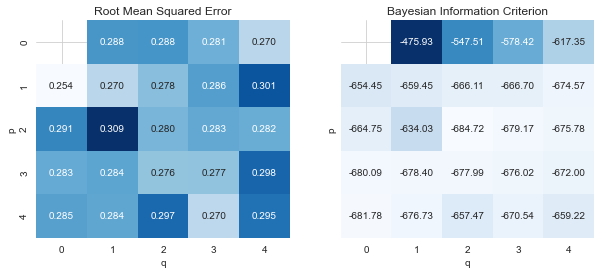

In [15]:
arma_results.nsmallest(5, columns=['RMSE'])
arma_results.nsmallest(5, columns=['BIC'])
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE < .5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues',
            ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

In [17]:
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()
best_arma_model = tsa.ARIMA(endog=industrial_production_log_diff, order=(best_p, 0,  best_q)).fit()
print(best_arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  264
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 649.721
Date:                Thu, 20 Apr 2023   AIC                          -1287.442
Time:                        10:15:43   BIC                          -1265.986
Sample:                    01-01-2001   HQIC                         -1278.820
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.018      0.152      0.879      -0.033       0.039
ar.L1          1.0065      0.531      1.896      0.058      -0.034       2.047
ar.L2         -0.0893      0.459     -0.195      0.8

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


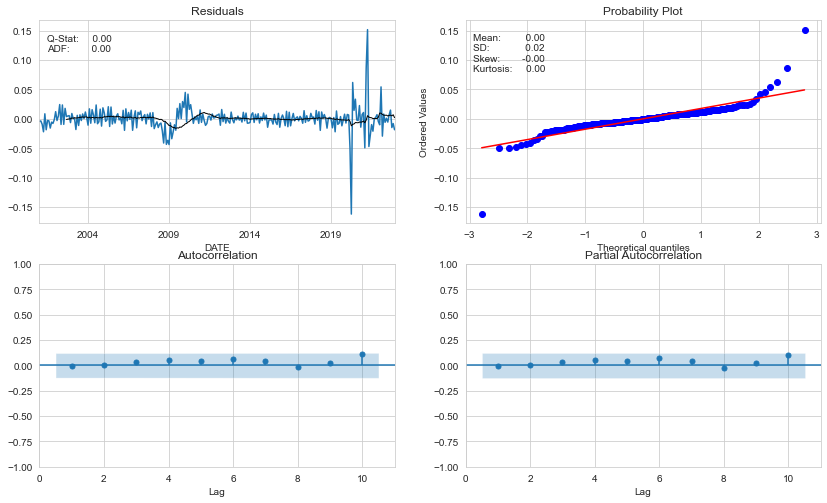

In [18]:
plot_correlogram(best_arma_model.resid)

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  264
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 704.356
Date:                              Thu, 20 Apr 2023   AIC                          -1394.713
Time:                                      10:16:06   BIC                          -1369.681
Sample:                                           0   HQIC                         -1384.654
                                              - 264                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1149      0.622      0.185      0.853      -1.104       1.334
ar.L2          0.86

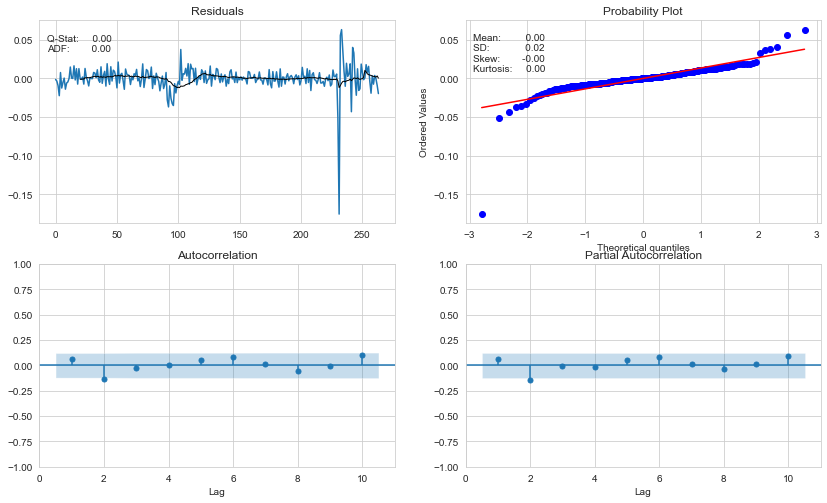

In [19]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values, order=(2, 0, 2),
                            seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])
print(sarimax_model.summary())
plot_correlogram(pd.Series(sarimax_model.resid))

In [20]:
l3 = list(range(3))
l4 = list(range(4))
params = [t for t in product(l4, l4, l3, l3) if t[0] > 0 and t[1] > 0]
print("Params's lenth: ", len(params))
train_size = 120  # 10 years of training data
results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1, q1, p2, q2 in tqdm(params):
    preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
    aic, bic = [], []
    if p1 == 0 and q1 == 0:
        continue
    convergence_error = stationarity_error = 0
    y_pred = []
    for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
        train_set = industrial_production_log_diff.iloc[T - train_size:T]
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = tsa.SARIMAX(endog=train_set.values,
                                    order=(p1, 0, q1),
                                    seasonal_order=(p2, 0, q2, 12)).fit(disp=0)
        except LinAlgError:
            convergence_error += 1
        except ValueError:
            stationarity_error += 1

        preds.iloc[i, 1] = model.forecast(steps=1)[0]
        aic.append(model.aic)
        bic.append(model.bic)

    preds.dropna(inplace=True)
    mse = mean_squared_error(preds.y_true, preds.y_pred)
    results[(p1, q1, p2, q2)] = [np.sqrt(mse), preds.y_true.sub(preds.y_pred).pow(2).std(), np.mean(aic),
                                 np.std(aic), np.mean(bic), np.std(bic), convergence_error, stationarity_error]

Params's lenth:  81


100%|██████████| 81/81 [1:50:15<00:00, 81.67s/it] 


In [21]:
sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()
with pd.HDFStore('data/arima.h5') as store:
    store.put('sarimax', sarimax_results)
with pd.HDFStore('data/arima.h5') as store:
    sarimax_results = store.get('sarimax')
sarimax_results.nsmallest(5, columns='RMSE')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 81 entries, (1, 1, 0, 0) to (3, 3, 2, 2)
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          81 non-null     float64
 1   RMSE_std      81 non-null     float64
 2   AIC           81 non-null     float64
 3   AIC_std       81 non-null     float64
 4   BIC           81 non-null     float64
 5   BIC_std       81 non-null     float64
 6   convergence   81 non-null     float64
 7   stationarity  81 non-null     float64
 8   CV            81 non-null     float64
dtypes: float64(9)
memory usage: 6.7 KB


RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
2  1  1  2   0.023368  0.003225 -704.510120  70.873855 -684.997678  70.873855   
      0  2   0.023538  0.003224 -701.062719  68.473917 -684.337768  68.473917   
      2  1   0.023847  0.003256 -699.486078  68.309474 -679.973636  68.309474   
1  1  0  2   0.024608  0.003230 -708.139904  69.109573 -694.202446  69.109573   
2  1  0  1   0.024610  0.003325 -706.469657  70.552487 -692.532198  70.552487   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
2  1  1  2           1.0           0.0  0.138028  
      0  2           0.0           0.0  0.136954  
      2  1           0.0           0.0  0.136520  
1  1  0  2           0.0           0.0  0.131255  
2  1  0  1           0.0           0.0  0.135128

Empty DataFrame
Columns: [RMSE, RMSE_std, AIC, AIC_std, BIC, BIC_std, convergence, stationarity, CV]
Index: []

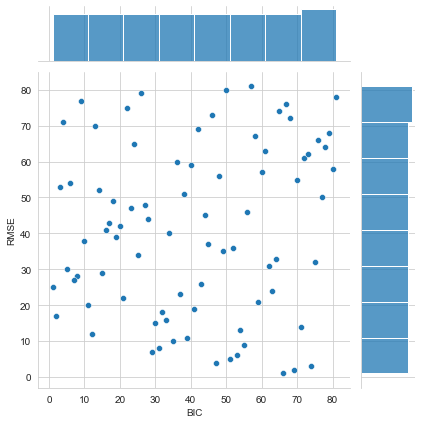

In [22]:
sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());
sarimax_results[(sarimax_results.RMSE < sarimax_results.RMSE.quantile(.05)) &
                (sarimax_results.BIC < sarimax_results.BIC.quantile(.1))].sort_values('RMSE')

In [23]:
p1, q1, p2, q2 = 2, 3, 1, 2
best_model = tsa.SARIMAX(endog=industrial_production_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  264
Model:             SARIMAX(2, 0, 3)x(1, 0, [1, 2], 12)   Log Likelihood                 710.915
Date:                                 Thu, 20 Apr 2023   AIC                          -1403.831
Time:                                         12:08:00   BIC                          -1371.647
Sample:                                              0   HQIC                         -1390.898
                                                 - 264                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2862      0.017     16.404      0.000       0.252       0

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


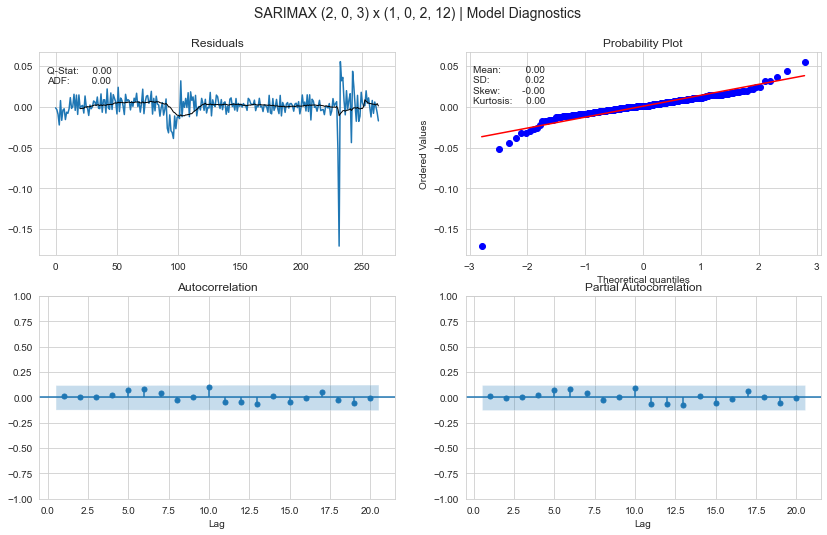

In [24]:
plot_correlogram(pd.Series(best_model.resid), lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')